In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i '../lib/utils/ipynb_setup.py'
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts


In [4]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 24)

In [7]:
from lib.lib import get_trajs,get_pt_plus

## Generate trajectory ensemble

In [5]:
df_traj=get_trajs()
df_traj.head()

seq  \
0  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
1  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
2  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
3  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
4  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   

                                                  Nt  nCorrectChoice  
0  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False  
1  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False  
2  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False  
3  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False  
4  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False

Compute $P_{T|t}^+$ for all trajectories

In [8]:
def dummy(row):
    return np.array([get_pt_plus(t,Nt) for t,Nt in enumerate(row)])
df_traj['Pt_plus']=df_traj.Nt.apply(lambda x: dummy(x))
# df_traj['evidence']=df_traj.Pt_plus.apply(lambda x: np.log(x/(1-x)))
df_traj['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)

In [11]:
para=dict()
para['T']=15
para['T_ITI']=para['T']/2
para['p']=1/2

## Random model

First fully random: Sample actions from uniform action policy. mean decision time is 2.5=1/p+1, p=2/3 so

In [12]:
p_act_rand=2/3
tdec_mean_fullrand=1/p_act_rand+1
gvec=np.linspace(0,1,100)
rew_fullrand=[1/2*1/(tdec_mean_fullrand+gamma*(para['T']-tdec_mean_fullrand)+para['T_ITI']) for gamma in gvec]

## Accuracy Bound Model

Show one example

In [14]:
b=0.8
alp=0.8
dfb=df_traj.copy()
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else para['T'])
dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else para['T'])
dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
reward_rate=dfb.prob_corr_at_tdec.mean()/(dfb.tb.mean()+(1-alp)*(para['T']-dfb.tb.mean())+para['T_ITI'])
print(reward_rate)

0.04761991948966346


## Dynamic Programming Model

In [15]:
from lib.dyn_prog_model import *

ReLu cost

18
0.10474377962085309
17
0.11932326621923937


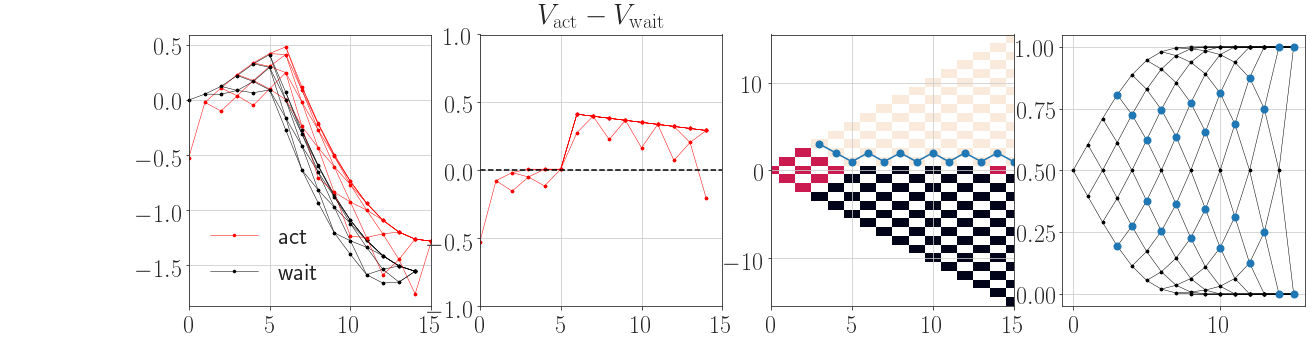

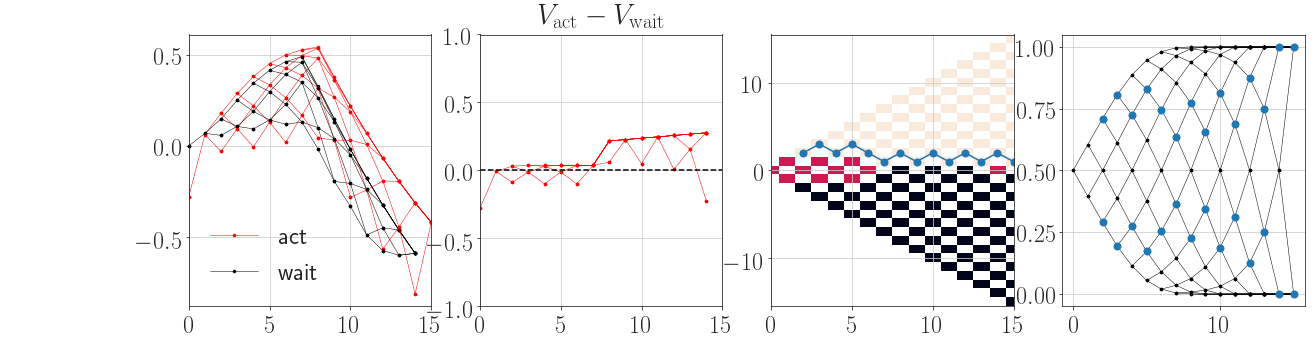

In [132]:
cost_rate_seq=np.zeros(para['T']+1)
for alp in [0.25,0.75]:
    tmin=8
    if alp==3/4:
        baseline=-0.07
        slope=0.02
        cost_rate_seq=baseline+np.asarray([0 if t<tmin else slope*(t-tmin) for t in np.arange(T+1)])
    else:
        baseline=-0.07
        slope=0.03
        tmin=tmin-2
        cost_rate_seq=baseline+np.asarray([0 if t<tmin else slope*(t-tmin) for t in np.arange(T+1)])
#     tmin=4
#     r_avg=0.01
#     time=np.arange(para['T']+1)
#     # cost_seq=r_avg*(1-1/(1+r_avg*(time-tmin)))
#     cost_rate_seq=r_avg*(time-tmin)
#     cost_rate_seq[time<tmin]=0
#     cost_rate_seq+=-0.2
#     alp=0.75
#     cost_rate_seq=np.zeros(T+1)
    cost_rate_seq[0]=-0.05
    rho,boundary=plot_dynprog_results(choice_value_update,cost_rate_seq,alp,pl)

Get reward distribution

In [19]:
dfdp=df_traj.copy()
#variable bound
tb,bv=boundary
num_repeats=np.where(tb[0]==tb[1:])[0].size
if num_repeats:
    tb=tb[num_repeats:]
    bv=bv[num_repeats:]
    
# boundvec=np.asarray([get_pt_plus(t,bo) if bo<np.Inf else np.Inf for t,bo in zip(tb,bv)])
dfdp['tb_vary']=dfdp.Nt.apply(lambda x: int(tb[0] + np.where(np.logical_or(x[int(tb[0]):]>=bv,x[int(tb[0]):]<=1-bv))[0][0] if np.where(np.logical_or(x[int(tb[0]):]>=bv,x[int(tb[0]):]<=1-bv))[0].size else T))
dfdp['prob_corr_at_tdec_vary']=dfdp.apply(lambda row:np.max([row.Pt_plus[row.tb_vary],1-row.Pt_plus[row.tb_vary]]),axis=1) 
dfdp['reward_rate_vary']=(dfdp.prob_corr_at_tdec_vary/(dfdp.tb_vary+(1-alp)*(para['T']-dfdp.tb_vary)+para['T_ITI']))

In [20]:
rho_joint=dfdp.groupby('tb_vary')['reward_rate_vary'].value_counts()
rho_joint

tb_vary  reward_rate_vary
2        0.055645            16384
5        0.055208             4096
7        0.051847             3072
9        0.049479             2304
11       0.048077             1728
13       0.047619             1296
14       0.045977             1944
15       0.044444             1944
Name: reward_rate_vary, dtype: int64

In [22]:
ind_t=rho_joint.index.get_level_values(0)
posterior_expected_reward_rate=np.asarray([(rho_joint[ind_t>t].index.get_level_values(1)*rho_joint[ind_t>t]/rho_joint[ind_t>t].sum()).sum() for t in range(para['T']+1)])

Assuming that the average belief as a function of time is the boundary. Confirm with Drugowitsch.
test cost reinference by getting boundary for cost, then reinferring cost. Only then can you trust

## No cost

In [23]:
from lib.plotting import plot_nocost_dec_times

0.05201892311014271


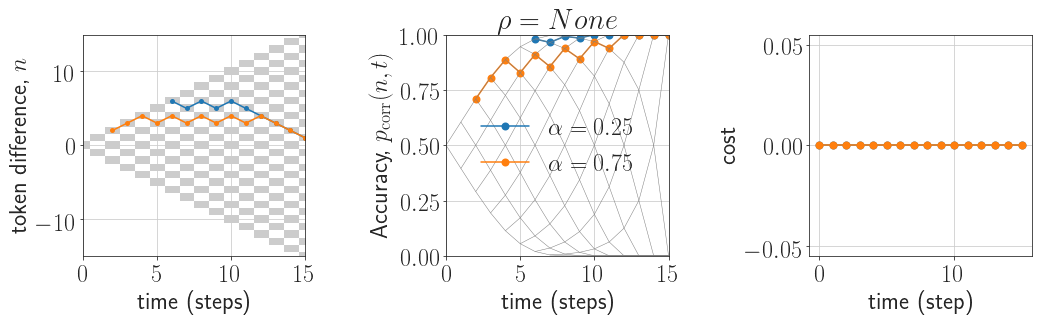

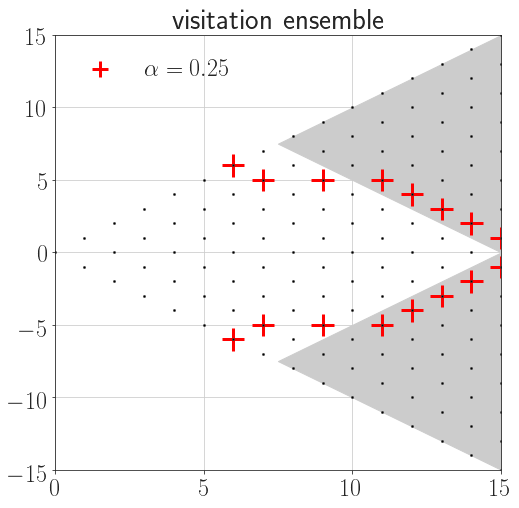

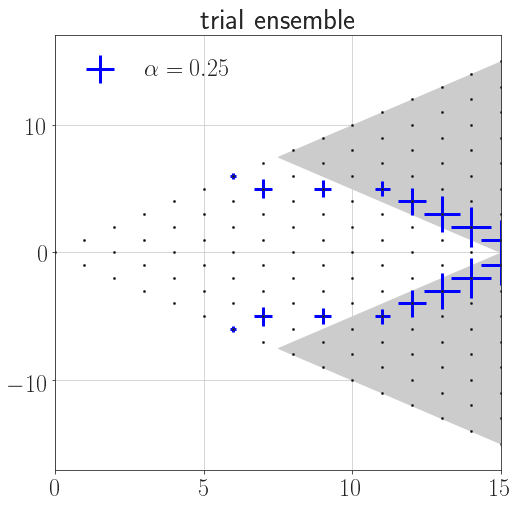

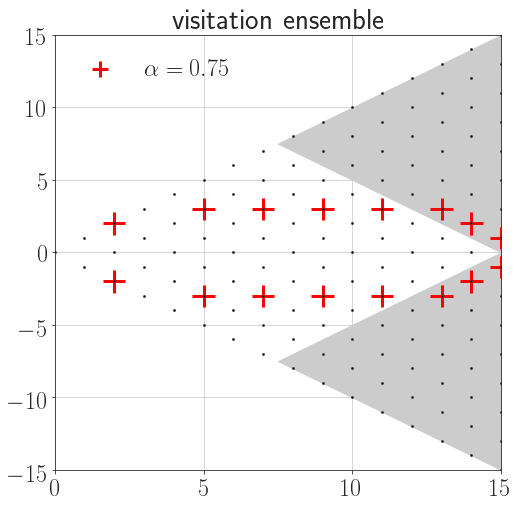

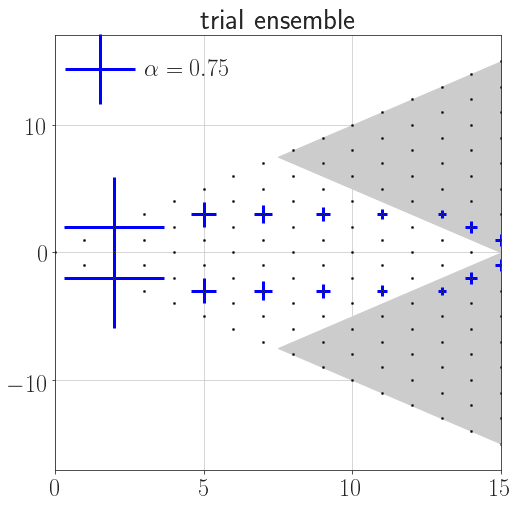

In [537]:
fig,ax=pl.subplots(1,3,figsize=(15,5))

alpvec=[0.25,0.75]
rhovec=[]
bias_index_vec=[]
avgtdec=[]

for it,alp in enumerate(alpvec):
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(np.zeros(para['T']+1),1-alp)
    rhovec.append(rho_zero)
    
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dfb=df_traj.copy()
   
    dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])

    dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
    dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)

    avgtdec.append(dfb['tDecision'].mean())
    fig2,ax2=pl.subplots()
    figbase,axbase=pl.subplots()
    bias_index=plot_nocost_dec_times(dfb,pl,'no_cost_alp'+str(alp),axbase,ax2,label_str=r"$\alpha="+str(alp)+r"$")
    bias_index_vec.append(bias_index)
    
    
    ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(alp)+'$')#',$'+str(i)+'$')
    ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(alp)+'$')#',M$'+str(i)+'$')
    #decision boundary in evidence space
    tb,b_evi=data_boundary[0]
    ax[0].plot(tb,b_evi,'.-')

ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')

for Nm in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,para['T'])
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho_zero))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((para['T']+1,2*para['T']+1))
for t in range(para['T']+1):
    state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)
    
ax[0].set_ylim(-para['T'],para['T'])
ax[0].set_xlim(0,para['T'])
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# fig.savefig('inferred_zero_costs.pdf', transparent=True,dpi=300)

In [497]:
rhovec

[0.04563047406790642, 0.05201892311014271]

In [494]:
Ttrials=[get_Ttrial(alp,t) for alp,t in zip(avgtdec,alpvec)]

In [495]:
Ttrials

[21.801483154296875, 15.54656982421875]

In [414]:
Ttrials[0]*rhovec[0]

0.9948120117140422

In [496]:
rhobar=(Ttrials[0]*rhovec[0]+Ttrials[1]*rhovec[1])/sum(Ttrials)
rhobar

0.048289741718638375

THura 2014 data

over stochastic policies

some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/plotting.py:56: RuntimeWarning: invalid value encountered in true_divide
  dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)


some decisions at t=0!
some decisions at t=0!
some decisions at t=0!
0.05201892311014271


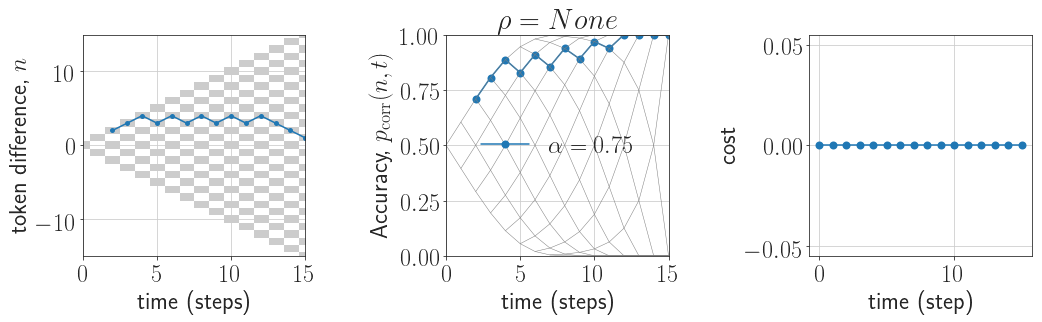

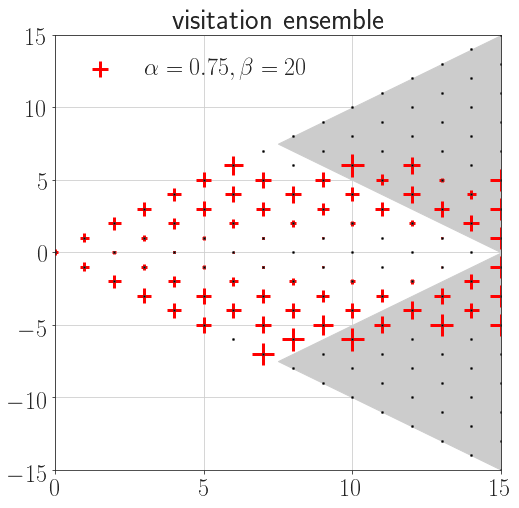

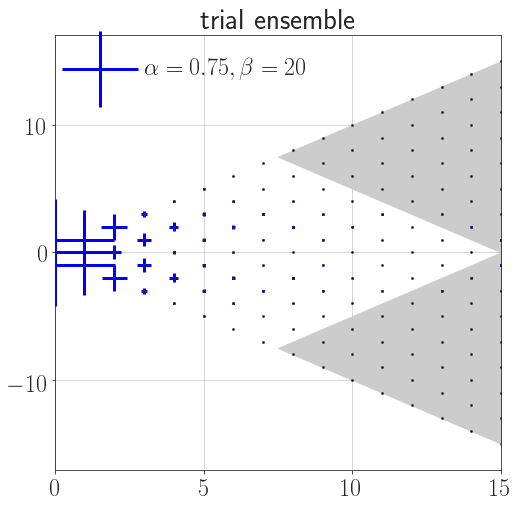

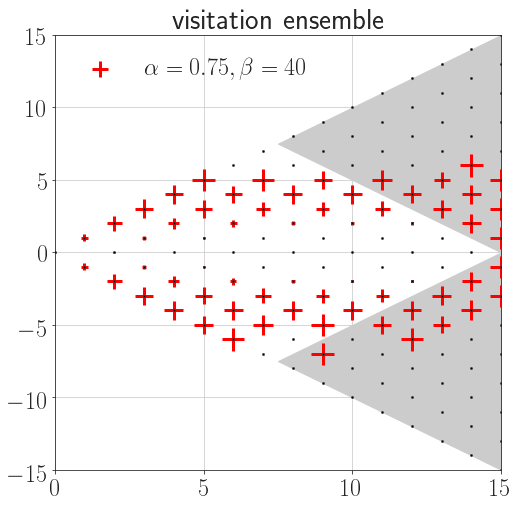

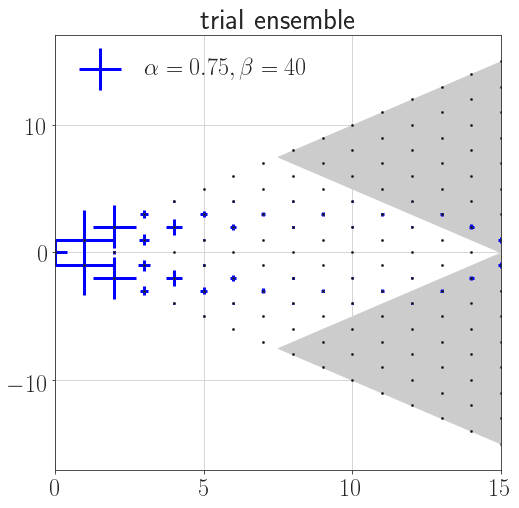

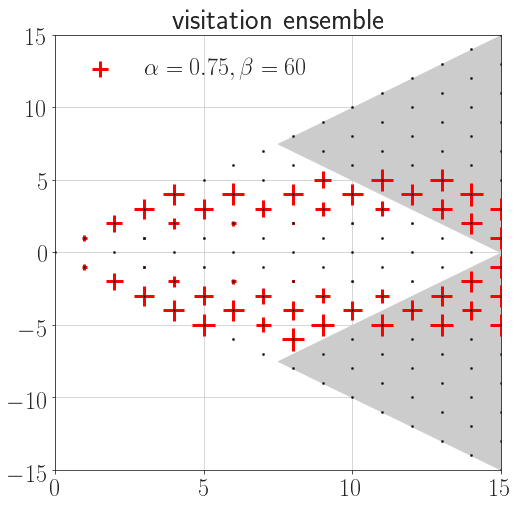

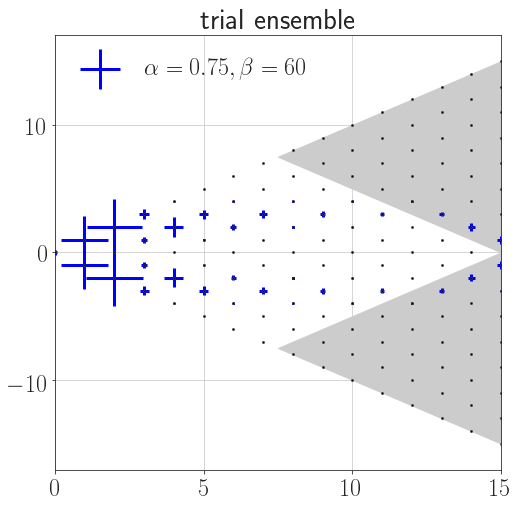

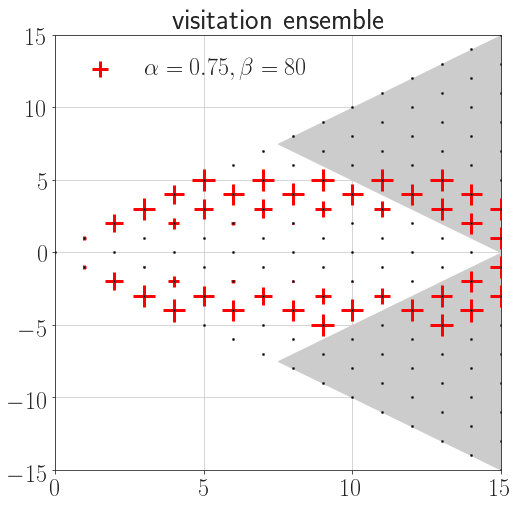

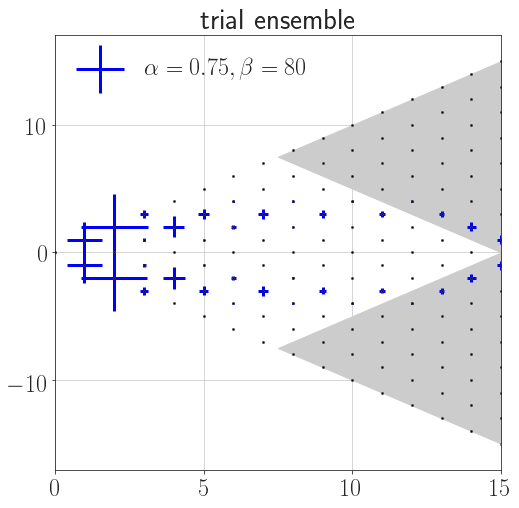

In [32]:
fig,ax=pl.subplots(1,3,figsize=(15,5))


rhovec=[]
bias_index_vec=[]
avgtdec=[]

# for it,post_interval in enumerate(block_times):

rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(np.zeros(para['T']+1),1-alp)
rhovec.append(rho_zero)

tb,b_bel=data_boundary[1]
b_beltmp=[]
for t in range(para['T']+1):
    teff=t-(para['T']-len(b_bel))-1
    b_beltmp.append(b_bel[teff] if teff>=0 else 1)
b_beltmp=np.asarray(b_beltmp)
dfb=df_traj.copy()
for bit,beta in enumerate([20,40,60,80]):
    get_action_trajs_part=partial(get_action_trajs,Q_value_fn=dec_data,beta=beta)
    dfb['dec_data']=dfb.Nt.apply(get_action_trajs_part)
    dfb['tDecision']=dfb.dec_data.apply(lambda x:x[0])
#     dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else T)

    dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
    dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)

    avgtdec.append(dfb['tDecision'].mean())
    fig2,ax2=pl.subplots()
    figbase,axbase=pl.subplots()
    bias_index=plot_nocost_dec_times(dfb,pl,'no_cost_'+str(post_interval),axbase,ax2,label_str=r"$\alpha="+str(alp)+r",\beta="+str(beta)+r"$")
bias_index_vec.append(bias_index)


ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(alp)+'$')#',$'+str(i)+'$')
ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(alp)+'$')#',M$'+str(i)+'$')
#decision boundary in evidence space
tb,b_evi=data_boundary[0]
ax[0].plot(tb,b_evi,'.-')

ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')

for Nm in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,para['T'])
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho_zero))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((para['T']+1,2*para['T']+1))
for t in range(para['T']+1):
    state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)
    
ax[0].set_ylim(-para['T'],para['T'])
ax[0].set_xlim(0,para['T'])
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# fig.savefig('inferred_zero_costs.pdf', transparent=True,dpi=300)

check optimal mixture

In [627]:
alpha_vec=np.linspace(0.01,0.99,40)
RR_Store=np.zeros((npoints,))
tdec_Store=np.zeros((npoints,))
dfb=df_traj.copy()
for it,alp in enumerate(alpha_vec):
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(np.zeros(para['T']+1),1-alp)
    RR_Store[it]=rho_zero
    
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)

    dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
#     dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
#     dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)

    tdec_Store[it]=dfb['tDecision'].mean()
   

In [937]:
alpha2_vec=np.asarray([0.25,0.75])
RR2_Store=np.zeros((2,))
tdec2_Store=np.zeros((2,))
dfb_low=df_traj.copy()
dfb_high=df_traj.copy()
for it,alp in enumerate(alpha2_vec):
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(np.zeros(para['T']+1),1-alp)
    RR2_Store[it]=rho_zero
    
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    if it==0:
        dfb_low['tdec']=dfb_low.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
        tdec2_Store[it]=dfb_low['tdec'].mean()
        dfb_low['p_tdec']=dfb_low.apply(lambda row:np.max([row.Pt_plus[int(row.tdec)],1-row.Pt_plus[int(row.tdec)]]),axis=1) 
        dfb_low['localRR']=dfb_low.p_tdec/(dfb_low.tdec+(1-alp)*(para['T']-dfb_low.tdec)+para['T_ITI'])
        dfb_low['corr']=dfb_low.Nt.apply(lambda x: np.sign(x[-1]))==dfb_low.apply(lambda row: row.Nt[row.tdec]>0,axis=1)
        dfb_low['Trial']=dfb_low.tdec+(1-alp)*(para['T']-dfb_low.tdec)+para['T_ITI']
    else:
        dfb_high['tdec']=dfb_high.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
        tdec2_Store[it]=dfb_high['tdec'].mean()
        dfb_high['p_tdec']=dfb_high.apply(lambda row:np.max([row.Pt_plus[int(row.tdec)],1-row.Pt_plus[int(row.tdec)]]),axis=1) 
        dfb_high['localRR']=dfb_high.p_tdec/(dfb_high.tdec+(1-alp)*(para['T']-dfb_high.tdec)+para['T_ITI'])
        dfb_high['corr']=dfb_high.Nt.apply(lambda x: np.sign(x[-1]))==dfb_high.apply(lambda row: row.Nt[row.tdec]>0,axis=1)
        dfb_high['Trial']=dfb_high.tdec+(1-alp)*(para['T']-dfb_high.tdec)+para['T_ITI']


In [821]:
sample.values

array([[           nan,            nan],
       [           nan,            nan],
       [           nan,            nan],
       ...,
       [1.46516300e+04, 4.56524532e-02],
       [1.47880400e+04, 4.56177093e-02],
       [1.45690100e+04, 4.56370211e-02]])

In [880]:
import matplotlib as mpl

In [933]:
np.repeat([1,2,3],[1,2,3])

array([1, 2, 2, 3, 3, 3])

In [934]:
dfb

seq  \
0      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
1      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
2      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
3      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
4      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
5      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
6      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
7      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
8      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
9      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
10     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
11     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
12     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
13     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
14     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
15     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1...   
16     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
17     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
18     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
19     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
20     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
21     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
22     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
23     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1...   
24     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1,...   
25     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1,...   
26     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1,...   
27     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1,...   
28     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1,...   
29     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1,...   
...                                                  ...   
32738  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1]   
32739   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1]   
32740  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1]   
32741   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1]   
32742   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1]   
32743    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1]   
32744  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1]   
32745   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1]   
32746   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1]   
32747    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1]   
32748   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1]   
32749    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1]   
32750    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1]   
32751     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1]   
32752  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1]   
32753   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1]   
32754   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1]   
32755    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1]   
32756   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1]   
32757    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1]   
32758    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1]   
32759     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1]   
32760   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1]   
32761    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1]   
32762    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1]   
32763     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1]   
32764    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1]   
32765     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1]   
32766     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1]   
32767      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]   

                                                      Nt  nCorrectChoice  \
0      [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   
1      [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   
2      [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   
3      [0, -1, -2, -3, -4, -

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


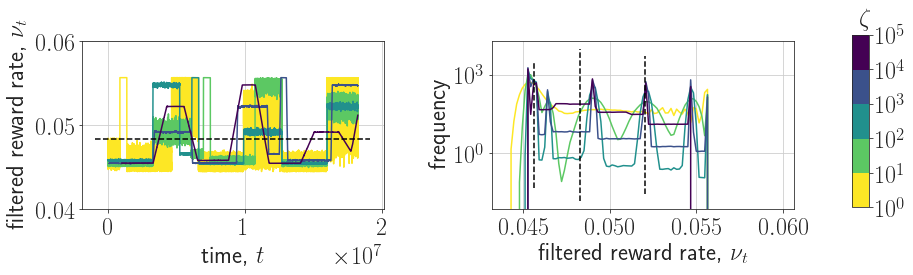

In [943]:
zeta=1000

seq_length=1e6
iters=2
zetavec=np.power(10,range(2,7)).astype('int')
colorsre = pl.cm.viridis_r(np.linspace(0., 1, len(zetavec)))
fig,ax=pl.subplots(1,2,figsize=(12,4))
p_slow=0.5
corr_time=10000
for zit,zeta in enumerate(zetavec):
#     for it in range(iters):
#     sample_data_low=dfb.loc[:,('localRR_low','Trial_low')]

#     sample_data=dfb.localRR_low.sample(n=int(seq_length*p_slow),replace=True).append(dfb.localRR_high.sample(n=int(seq_length*(1-p_slow)),replace=True)).to_frame(name='samp')
#     sample_data['sampind']=(sample_data.index.values/corr_time).astype(int)
#     ids = sample_data.sampind.unique()
#     np.random.shuffle(ids)
#     sample_data = sample_data.set_index("sampind").loc[ids].reset_index()
#     sample_data.samp=np.repeat(sample_data.samp,sample_data.Trial)
#     sample_data=sample_data.samp.rolling(zeta).mean()
    
    dfbt=dfb_low.sample(n=int(seq_length*p_slow),replace=True).append(dfb_high.sample(n=int(seq_length*(1-p_slow)),replace=True))
    dfbt['sampind']=(dfbt.index.values/corr_time).astype(int)
    ids = dfbt.sampind.unique()
    np.random.shuffle(ids)
    dfbt = dfbt.set_index("sampind").loc[ids].reset_index()
    sample_data=pd.Series(np.repeat(dfbt.localRR.values,dfbt.Trial.values.astype('int'))).rolling(zeta).mean()
    
    
#     sample_low=dfb.localRR_low.sample(n=seq_length,replace=True).reset_index(drop=True).rolling(zeta).mean()
#     sample_high=dfb.localRR_high.sample(n=seq_length,replace=True).reset_index(drop=True).rolling(zeta).mean()
#     if it==0:
    ax[0].plot(sample_data,color=colorsre[zit])
#     col=p[-1].get_color()
#     counts,bins=np.histogram(sample_low.values,np.linspace(0.044,0.06,100),density=True)
#     ax[1].plot(bins[:-1],counts,color=col)
#     counts,bins=np.histogram(sample_high.values,np.linspace(0.044,0.06,100),density=True)
#     ax[1].plot(bins[:-1],counts,color=col)
    counts,bins=np.histogram(sample_data.values,np.linspace(0.044,0.06,100),density=True)
    ax[1].plot(bins[:-1],counts,color=colorsre[zit],label=r'$\zeta=10^'+str(int(np.log10(zeta)))+'$')
#     else:
#     ax[0].plot(sample_low[:10000],color=col)
    ax[0].set_xlabel(r'time, $t$')
    ax[0].set_ylabel(r'filtered reward rate, $\nu_t$')
    ax[1].set_xlabel(r'filtered reward rate, $\nu_t$')
    ax[1].set_ylabel('frequency')
#     ax[1].set_xticks([rhoavg])
#     ax[1].set_xticklabels([r'$\bar{\rho}$'])
    ax[1].set_yscale('log')
ax[0].plot(ax[0].get_xlim(),[rhoavg]*2,'k--')
ax[0].set_ylim(0.04,0.06)
ax[1].plot([rhovec[0]]*2,ax[1].get_ylim(),'k--')
ax[1].plot([rhovec[1]]*2,ax[1].get_ylim(),'k--')
# ax[1].text(rhovec[0],ax[1].get_ylim()[1],r'$\rho_{\textmrm{fast}}$')
ax[1].plot([rhoavg]*2,ax[1].get_ylim(),'k--')
# ax[1].legend(frameon=False,bbox_to_anchor=(1.05, 1))
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', colorsre, len(colorsre))

# define the bins and normalize
bounds = np.arange(len(colorsre)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# create a second axes for the colorbar
ax2 = fig.add_axes([1.02, 0.3, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds,boundaries=bounds, format='%1i')
ax2.set_yticklabels([r'$10^{'+str(b)+'}$' for b in bounds])
ax2.text(0.5,1.05,r'$\zeta$')
fig.tight_layout()
fig.savefig('filtered_rew.pdf', transparent=True,bbox_inches='tight',dpi=300)

In [784]:
fast_dat=np.asarray([[0.10000000000000009, 19.235021459227468],
[0.3186666666666669, 21.66266094420601],
[0.5106666666666668, 21.643090128755368],
[0.724, 22.010472103004297],
[0.9213333333333331, 22.506094420600864],
[1.124, 23.77442060085837],
[1.3159999999999998, 25.428669527897],
[1.5346666666666664, 25.04944206008584],
[1.7053333333333334, 28.376824034334767],
[1.94, 25.96377682403434],
[2.1159999999999997, 23.162575107296142]])

slow_dat=np.asarray([[0.10000000000000009, 13.930300429184552],
[0.27600000000000025, 15.558283261802579],
[0.5106666666666668, 16.98214592274678],
[0.6813333333333336, 18.455450643776828],
[0.9053333333333331, 19.080686695278974],
[1.092, 20.116738197424894],
[1.3053333333333335, 21.51416309012876],
[1.492, 22.781974248927042],
[1.7053333333333334, 23.0206008583691],
[1.8973333333333335, 24.67484978540773],
[2.1213333333333333, 29.085493562231765]])

In [719]:
Ttrials

[21.801483154296875, 15.54656982421875]

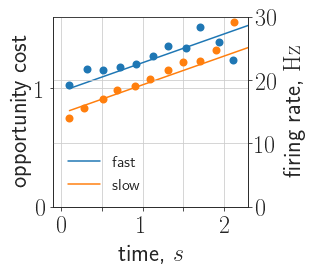

In [478]:
fig,ax=pl.subplots(figsize=(3.5,3.5))
timevec=np.arange(T+1)
strvec=['fast','slow']
for it,(T,rho) in enumerate(zip(Ttrials,rhovec)):
    ax.plot(timevec*.2+0.1,(rhobar*timevec+T*rho),label=strvec[it])
    ax.legend(frameon=False,prop={'size': 16})
ax2=ax.twinx()
ax2.plot(slow_dat[:,0],slow_dat[:,1],'o')
ax2.plot(fast_dat[:,0],fast_dat[:,1],'o')
ax2.set_ylabel(r'firing rate, $\textrm{Hz}$')
ax.set_ylabel('opportunity cost')
ax.set_xlim(-0.1,2.3)
# ax.set_ylim(0,ax.get_ylim())
# ax.set_ylim(0.8,1.5)
# ax2.set_ylim(16,30)
ax.set_ylim(0,1.6)
ax2.set_ylim(0,30)

ax.set_xticks([0,0.5,1.0,1.5,2])
ax.set_xticklabels([r'$0$','',r'$1$','',r'$2$'])
ax.set_xlabel(r'time, $s$')
# fig.tight_layout()
fig.savefig('cost_rate_match.eps', transparent=True,bbox_inches='tight',dpi=300)

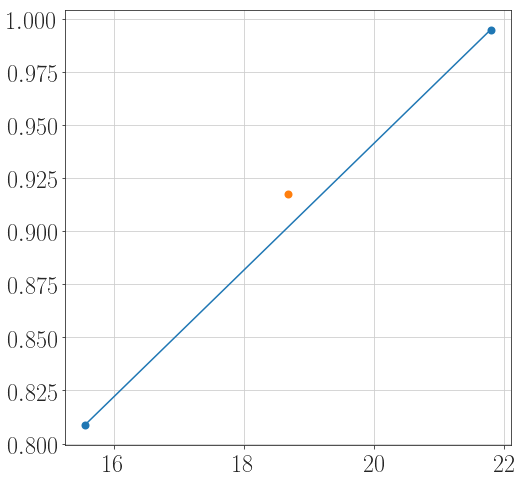

In [783]:
fig,ax=pl.subplots()
ax.plot(Ttrialvec,Ttrialvec*rhovec,'o-')
ax.plot([np.sum(Ttrialvec)/2],[np.sum(Ttrialvec*Ttrialvec*rhovec)/np.sum(Ttrialvec)],'o')

In [802]:
dfb=df_traj.copy()

seq  \
0  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
1  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
2  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
3  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
4  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   

                                                  Nt  nCorrectChoice  \
0  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   
1  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   
2  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   
3  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   
4  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...           False   

                                             Pt_plus   plus  
0  [0.5, 0.395263671875, 0.29052734375, 0.1938476...  False  
1  [0.5, 0.395263671875, 0.29052734375, 0.1938476...  False  
2  [0.5, 0.395263671875, 0.29052734375, 0.1938476...  False  
3  [0.5, 0.395263671875, 0.29052734375, 0.1938476...  False  
4  [0.5, 0.395263671875, 0.29052734375, 0.1938476...  False

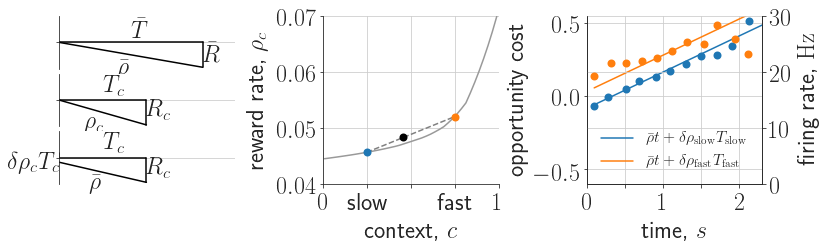

In [801]:
fig,ax=pl.subplots(3,3,figsize=(12,4))
cit=1
Ttrial2=tdec2_Store+(1-alpha2_vec)*(T-tdec2_Store)+para['T_ITI']
alp_avg=(alpha2_vec[0]*Ttrial2[0]+alpha2_vec[1]*Ttrial2[1])/sum(Ttrial2)
RR_avg=(Ttrial2[0]*RR2_Store[0]+Ttrial2[1]*RR2_Store[1])/sum(Ttrial2)
T_avg=(Ttrial2[0]+Ttrial2[1])/2

ax1 = pl.subplot2grid((3, 3), (0, 0),)
ax1.plot([0,T_avg],[0, 0],'k-')
ax1.plot([T_avg]*2,[0, -T_avg*RR_avg],'k-')
ax1.plot([0,T_avg],[0, -T_avg*RR_avg],'k-')
ax1.text(T_avg/2,0,r'$\bar{T}$',va='bottom')
ax1.text(T_avg,-T_avg*RR_avg,r'$\bar{R}$',ha='left',va='bottom')
ax1.text(T_avg/2,-T_avg*RR_avg/2,r'$\bar{\rho}$',va='top',ha='right',clip_on=False)

ax2 = pl.subplot2grid((3, 3), (1,0))
ax2.plot([0,Ttrial2[cit]],[0, 0],'k-')
ax2.plot([Ttrial2[cit]]*2,[0, -Ttrial2[cit]*RR2_Store[cit]],'k-')
ax2.plot([0,Ttrial2[cit]],[0, -Ttrial2[cit]*RR2_Store[cit]],'k-')
ax2.text(Ttrial2[cit]/2,0,r'$T_c$',va='bottom')
ax2.text(Ttrial2[cit],-Ttrial2[cit]*RR2_Store[cit],r'$R_c$',ha='left',va='bottom')
ax2.text(Ttrial2[cit]/2,-Ttrial2[cit]*RR2_Store[cit]/2,r'$\rho_c$',va='top',ha='right',clip_on=False)

ax3 = pl.subplot2grid((3, 3), (2,0))
ax3.plot([0,0],[0, Ttrial2[cit]*(RR2_Store[cit]-RR_avg)],'k-')
ax3.plot([0,Ttrial2[cit]],[0, 0],'k-')
ax3.plot([Ttrial2[cit]]*2,[0, -Ttrial2[cit]*RR2_Store[cit]],'k-')
ax3.plot([0,Ttrial2[cit]],[-Ttrial2[cit]*(RR2_Store[cit]-RR_avg), -Ttrial2[cit]*RR2_Store[cit]],'k-')
ax3.text(Ttrial2[cit]/2,0,r'$T_c$',va='bottom')
ax3.text(Ttrial2[cit],-Ttrial2[cit]*RR2_Store[cit],r'$R_c$',ha='left',va='bottom')
ax3.text(Ttrial2[cit]/2,-Ttrial2[cit]*RR2_Store[cit]/2,r'$\bar{\rho}$',va='top',ha='right',clip_on=False)
ax3.text(0,Ttrial2[cit]*(RR2_Store[cit]-RR_avg),r'$\delta\rho_cT_c$',va='top',ha='right',clip_on=False)
for axt in [ax1,ax2,ax3]:
    axt.set_ylim([axt.get_ylim()[0],-axt.get_ylim()[0]])
    axt.spines['right'].set_visible(False)
    axt.spines['top'].set_visible(False)
    axt.spines['bottom'].set_visible(False)
    axt.set_xticks([])
    axt.set_yticks([0])
    axt.set_yticklabels([''])
    axt.set_xlim(0,20)
fig.subplots_adjust(wspace=0.05, hspace=0.1)

rhovec=np.array([0.04563047, 0.05201892])
Ttrialvec=np.array([21.801483154296875, 15.54656982421875])
rhoavg=(rhovec[0]*Ttrialvec[0]+rhovec[1]*Ttrialvec[1])/sum(Ttrialvec)
Tavg=np.sum(Ttrialvec)/2
axRR = pl.subplot2grid((3, 3), (0,1),rowspan=3)
axRR.plot(alpha_vec,RR_Store,'-',color=[0.6]*3)
axRR.plot([0.25,0.75],rhovec,'--',color=[0.5]*3)
axRR.plot([0.25],rhovec[0],'o')
axRR.plot([0.75],rhovec[1],'o')
axRR.plot([(0.25*Ttrialvec[0]+0.75*Ttrialvec[1])/sum(Ttrialvec)],[rhoavg],'ko')
# Ttrial3=tdec3_Store+(1-alpha3_vec)*(T-tdec3_Store)+para['T_ITI']
# alp_avg3=(alpha3_vec[0]*Ttrial3[0]+alpha3_vec[1]*Ttrial3[1])/sum(Ttrial3)
# RR_avg3=(Ttrial3[0]*RR3_Store[0]+Ttrial3[1]*RR3_Store[1])/sum(Ttrial3)
# axRR.plot([alp_avg3],[RR_avg3],'o',color=[0.8]*3)
axRR.set_xlabel(r'context, $c$')
axRR.set_ylabel(r'reward rate, $\rho_c$')
axRR.set_xticks([0,0.25,0.5,0.75,1.0])
axRR.set_yticks([0.04,0.05,0.06,0.07])
axRR.set_xticklabels([r'$0$','slow','','fast',r'$1$'])
axRR.set_ylim([0.04,0.07])
axRR.set_xlim([0,1])
axRR.spines['right'].set_visible(False)
axRR.spines['top'].set_visible(False)

ax_data= pl.subplot2grid((3, 3), (0,2), rowspan=3)
timevec=np.arange(T+1)
strvec=[r'$\bar{\rho}t+\delta\rho_{\textrm{slow}}T_{\textrm{slow}}$',r'$\bar{\rho}t+\delta\rho_{\textrm{fast}}T_{\textrm{fast}}$']
for it,(T,rho) in enumerate(zip(Ttrialvec,rhovec)):
#     ax_data.plot(timevec*.2+0.1,RR_avg*timevec+T*rho,label=strvec[it])
    ax_data.plot(timevec*.2+0.1,RR_avg*timevec+T*(rho-rhoavg),label=strvec[it])
    ax_data.legend(frameon=False,prop={'size': 16})
ax2=ax_data.twinx()
ax2.plot(slow_dat[:,0],slow_dat[:,1],'o')
ax2.plot(fast_dat[:,0],fast_dat[:,1],'o')
ax2.set_ylabel(r'firing rate, $\textrm{Hz}$')
ax_data.set_ylabel('opportunity cost')
ax_data.set_xlim(-0.1,2.3)
ax_data.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax_data.set_ylim(-0.6,0.55)
# ax_data.set_ylim(0,1.6)
ax2.set_ylim(0,30)

ax_data.set_xticks([0,0.5,1.0,1.5,2])
ax_data.set_xticklabels([r'$0$','',r'$1$','',r'$2$'])
ax_data.set_xlabel(r'time, $s$')
ax_data.set_xlim([0,2.3])
fig.tight_layout()
fig.subplots_adjust(wspace=0.5, hspace=0.1)
# ax[0].plot(alpha_vec,RR_Store)
# ax[0].plot(alpha2_vec,RR2_Store,'o--')
# ax[0].plot([alp_avg],[RR_avg],'o')
# ax[1].plot(alpha_vec,tdec_Store)
# ax[1].plot(alpha_vec,tdec_Store)
# ax[1].plot(alpha_vec,tdec_Store+(1-alpha_vec)*(T-tdec_Store)+para['T_ITI'])

# Ttrial3=tdec3_Store+(1-alpha3_vec)*(T-tdec3_Store)+para['T_ITI']
# alp_avg3=(alpha3_vec[0]*Ttrial3[0]+alpha3_vec[1]*Ttrial3[1])/sum(Ttrial3)
# RR_avg3=(Ttrial3[0]*RR3_Store[0]+Ttrial3[1]*RR3_Store[1])/sum(Ttrial3)
# ax[0].plot([alp_avg3],[RR_avg3],'o')


fig.savefig('context_strategies.pdf', transparent=True,dpi=300,bbox_inches='tight')

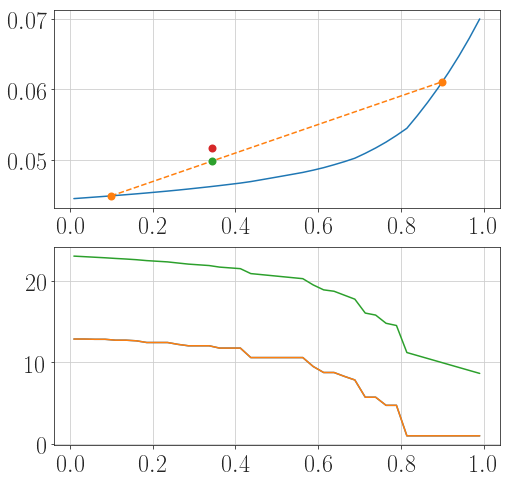

In [687]:
fig,ax=pl.subplots(1,1)


In [617]:
alpha3_vec=np.asarray([0.1,0.9])
RR3_Store=np.zeros((2,))
tdec3_Store=np.zeros((2,))
dfb=df_traj.copy()

RR_dev=RR2_Store-RR_avg
for it,alp in enumerate(alpha3_vec):
    cost_seq=np.zeros(para['T']+1)
    cost_seq[0]=RR_dev[it]*Ttrial2[it]
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alp)
    RR3_Store[it]=rho_zero
    
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)

    dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
#     dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
#     dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)

    tdec3_Store[it]=dfb['tDecision'].mean()

## $(\alpha,c)$ Grid

In [581]:
import time
from lib.lib import get_survprob

In [587]:
npoints=40
cost_vec=np.linspace(0,0.05,npoints)
alpha_vec=np.linspace(0.001,0.999,npoints)
RR_Store=np.zeros((npoints,npoints))
tdec_Store=np.zeros((npoints,npoints))
st=time.time()
for ait,alp in enumerate(alpha_vec):
    for cit,scalar_cost_value in enumerate(cost_vec):
        cost_seq=scalar_cost_value*np.ones(para['T']+1)
        rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alp)
        RR_Store[ait,cit]=rho_zero
        
        tb,b_bel=data_boundary[1]
        b_beltmp=[]
        for t in range(T+1):
            teff=t-(T-len(b_bel))-1
            b_beltmp.append(b_bel[teff] if teff>=0 else 1)
        b_beltmp=np.asarray(b_beltmp)
        dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else T)
        tdec_Store[ait,cit]=dfb['tDecision'].mean()
print(time.time()-st)

In [586]:
alpvec_test=[0.1,0.25,0.4,0.6,0.75,0.9]
ax[0].plot(alpvec,RR_Store)
cost_alpvec_test=0.0
costvec_test=[0,0.01,0.02,0.03,0.04]
alp_costvec_test=0.25

boundary_list=[]

scalar_cost_value=cost_alpvec_test
cost_seq=scalar_cost_value*np.ones(para['T']+1)
tmplist=[]
for ait,alp in enumerate(alpvec_test):
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alp)
    tmplist.append(data_boundary)  
boundary_list.append(tmplist)

alpha=alp_costvec_test 
tmplist=[]
for cit,scalar_cost_value in enumerate(costvec_test):
    cost_seq=scalar_cost_value*np.ones(para['T']+1)
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alpha)
    tmplist.append(data_boundary)
boundary_list.append(tmplist)


ValueError: x and y must have same first dimension, but have shapes (2,) and (40, 40)

In [136]:
RR_onedone_store=np.zeros((npoints,npoints))
st=time.time()
for ait,alp in enumerate(alpha_vec):
    for cit,scalar_cost_value in enumerate(cost_vec):
        RR_onedone_store[ait,cit]=(get_pt_plus(1,1)-scalar_cost_value)/(1+(1-alp)*(T-1)+para['T_ITI'])

In [137]:
b=1
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b,x<=1-b))[0][0] if np.where(np.logical_or(x>=b,x<=1-b))[0].size else T)
#         dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1)
RR_wait4certain_store=np.zeros((npoints,npoints))
for ait,alp in enumerate(alpha_vec): 
    for cit,scalar_cost_value in enumerate(cost_vec):
        RR_wait4certain_store[ait,cit]=(dfb.prob_corr_at_tdec-scalar_cost_value*dfb.tb).mean()/(dfb.tb+(1-alp)*(T-dfb.tb)+para['T_ITI']).mean()    

In [138]:
dfb=df_traj.copy()
Nt_samples=np.cumsum(np.asarray(dfb.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
survprob_data=[]
tmplist=[]
for dit,data_boundary in enumerate(boundary_list[0][::-1]):
    tmplist.append(get_survprob(dfb,Nt_samples,data_boundary,T=para['T']))
survprob_data.append(tmplist) 
tmplist=[]
for dit,data_boundary in enumerate(boundary_list[1][::-1]):
    tmplist.append(get_survprob(dfb,Nt_samples,data_boundary,T=para['T']))
survprob_data.append(tmplist) 

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


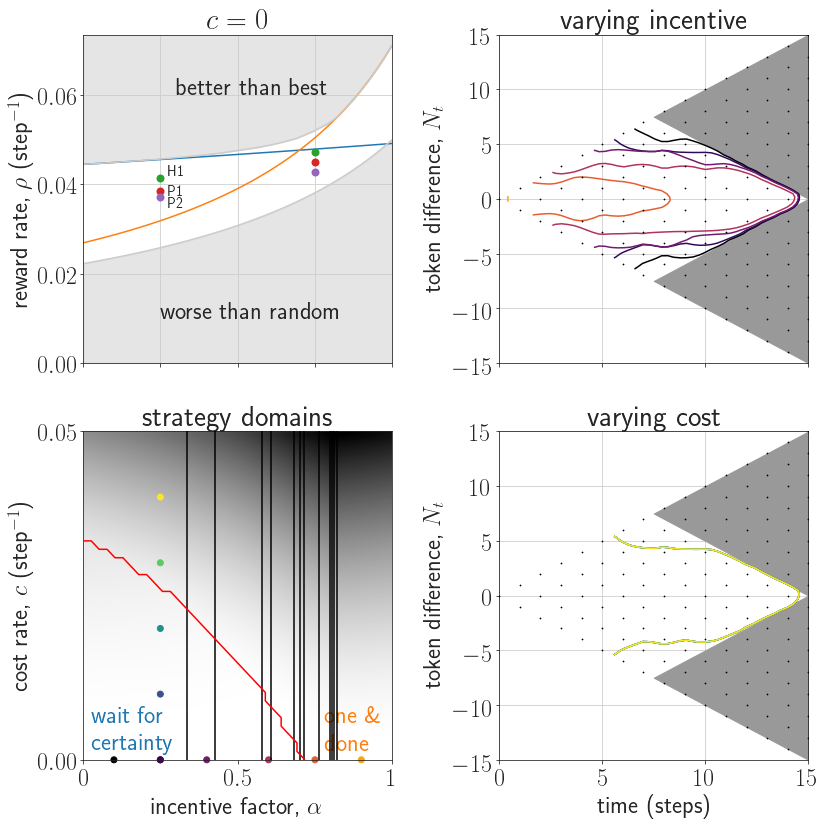

In [141]:
fig,ax=pl.subplots(2,2,figsize=(12,12))

#strategies
colors=pl.rcParams['axes.prop_cycle'].by_key()['color']
# ax.plot(gamma_vec,rew_b,'-',label=r'optimal fixed bound: $b=b_{\textrm{opt}}(\alpha)$')
p=ax[0,0].plot(alpha_vec,RR_wait4certain_store[:,0],'-')#,label=r'100\% accuracy $(b=1)$')
wait4cer_color=p[-1].get_color()
# ax.text(0.6,1.07/(T+T_I),r'$\frac{1}{\bar{t}_{b=1}+\alpha (T-\bar{t}_{b=1})+T_{\textrm{I}}}$',color=colors[2])
p=ax[0,0].plot(alpha_vec,get_pt_plus(1,1)/(1+(1-alpha_vec)*(para['T']-1)+para['T_ITI']),'-')#,label='one-and-done')#step: $a_{1}=N_{1}$')
onedone_color=p[-1].get_color()
# ax.text(0.1,3/(2*(T+T_I)),r'$\frac{p_{\textrm{success}}(t^\pi_{\textrm{dec}}=1)}{1+\alpha(T-1)+T_{\textrm{I}}}$',color=colors[3])
ax[0,0].plot(alpha_vec,RR_Store[:,0],'-',color=[0.8]*3)#,label='optimal belief bound',clip_on=False)
# gvec=np.linspace(0,1,100)
# ax.plot(gvec,1/(2*(gvec*T+T_I)),'-',label=r'zero-step: $a_{0}=1$')
# ax.text(0.7,0.8/(2*(T+T_I)),r'$\frac{1/2}{\alpha T+T_{\textrm{I}}}$',color=colors[4])
p_act_rand=2/3
tdec_mean_fullrand=1/p_act_rand+1
rew_fullrand=[1/2*1/(tdec_mean_fullrand+(1-alp)*(para['T']-tdec_mean_fullrand)+para['T_ITI']) for alp in alpha_vec]
ax[0,0].plot(alpha_vec,rew_fullrand,'-',color=[0.8]*3)#,label=r'uniform random: $p_{a_t}=1/3$')
# ax.text(0.1,1.3/(2*(T+T_I)),r'$\frac{1/2}{5/2+\alpha(T-5/2)+T_{\textrm{I}}}$',color=colors[5])
ylim=ax[0,0].get_ylim()
gray_val=0.8
ax[0,0].fill_between(alpha_vec,RR_Store[:,0], [ylim[1]]*(len(alpha_vec)),color=[gray_val]*3,alpha=0.5)
ax[0,0].fill_between(alpha_vec,np.zeros(alpha_vec.shape),rew_fullrand,color=[gray_val]*3,alpha=0.5)
ax[0,0].text(0.3,0.06,r'better than best')
ax[0,0].text(0.25,0.01,r'worse than random')

#data
rr_M1_fast=0.04489874703443582
rr_M1_slow=0.038475184652453864
rr_M2_fast=0.0427570104760277
rr_M2_slow=0.03724601256317603
rr_H1_fast=0.04716158428767893
rr_H1_slow=0.04132889498676728
ax[0,0].plot([1-1/4,1-3/4],[rr_H1_fast,rr_H1_slow],'o',label='H1')
ax[0,0].plot([1-1/4,1-3/4],[rr_M1_fast,rr_M1_slow],'o',label='P1')
ax[0,0].plot([1-1/4,1-3/4],[rr_M2_fast,rr_M2_slow],'o',label='P2')
shift=0.025
ax[0,0].text(1-3/4+shift,rr_H1_slow,'H1',ha='left',va='bottom',fontsize=14)
ax[0,0].text(1-3/4+shift,rr_M1_slow,'P1',ha='left',va='center',fontsize=14)
ax[0,0].text(1-3/4+shift,rr_M2_slow,'P2',ha='left',va='top',fontsize=14)
ax[0,0].set_ylabel(r'reward rate, $\rho$ (step$^{-1}$)')#'=\frac{\langle p_{\textrm{success}}(t^\pi_{\textrm{dec}}) \rangle_{\tau}}{\langle T_{\textrm{trial}}(t^\pi_{\textrm{dec}})\rangle_{\tau}}$')
ax[0,0].set_xlim(0,1)
# ax[0,0].legend(frameon=False,loc=7,fontsize=10)#,bbox_to_anchor=(1.0, 1.05))
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim([0,ylim[1]])
ax[0,0].set_title(r'$c=0$')
# ax[0,0].set_yticklabels([r'$0$','',r'$0.02$','',r'$0.04$','',r'$0.06$',''])
# ax[0,0].text(-0.3,0.077,r'\underline{action policy}')
# ax.set_title(r'$p_\textrm{jump}=1/2$, $T=15$ steps, $T_\textrm{inter}=T/2$')


#phase diagra1

tmpdat=deepcopy(tdec_Store)
tmpdat[tdec_Store>1]=np.nan
# ax[1,0].contourf(alpha_vec,cost_vec,((RR_Store-np.maximum(RR_wait4certain_store,RR_onedone_store))**2).T,cmap='gray_r',levels=22)
ax[1,0].contour(alpha_vec,cost_vec,tdec_Store.T,levels=range(1,16),colors=['k'],zorder=30)
# ax[1,0].contour(alpha_vec,cost_vec,tdec_Store.T,levels=[1.00001],colors=['k'],zorder=30)
ax[1,0].contour(alpha_vec,cost_vec,(RR_wait4certain_store>RR_onedone_store).T,levels=[1.0000],colors=['r'],zorder=30)

# ax[1,0].imshow(tdec_Store.T,cmap='gray_r',interpolation='none',extent=[alpha_vec.min(),alpha_vec.max(),cost_vec.min(),cost_vec.max()],aspect='auto',origin='lower')
ax[1,0].imshow(((RR_Store-np.maximum(RR_wait4certain_store,RR_onedone_store))**2).T,cmap='gray_r',interpolation='spline36',extent=[alpha_vec.min(),alpha_vec.max(),cost_vec.min(),cost_vec.max()],aspect='auto',origin='lower')
# CS=ax[1,0].contour(alpha_vec,cost_vec,RR_Store,levels=10)
ax[1,0].set_ylabel(r'cost rate, $c$ (step$^{-1}$)')
ax[1,0].grid(None)
ax[1,0].set_xlabel(r'incentive factor, $\alpha$')
ax[1,0].set_yticks([0,0.05,0.1])
ax[1,0].set_xlim(0,1)
ax[1,0].set_ylim(0,0.05)
ax[1,0].set_xticks([0,0.5,1.0])
ax[1,0].set_title('strategy domains')
ax[1,0].set_xticklabels([r'$0$',r'$0.5$',r'$1$'])
# ax[1,0].text(0.,-0.022,'no \n incentive',ha='center')
# ax[1,0].text(1.,-0.022,'max \n incentive',ha='center')
ax[1,0].text(0.025,0.0015,'wait for \n certainty',color=wait4cer_color)
ax[1,0].text(0.78,0.0015,'one \& \n done',color=onedone_color)
# pl.colorbar(CS)

col_arr=[pl.cm.inferno(np.linspace(0, 0.8, len(alpvec_test))),pl.cm.viridis(np.linspace(0, 1, len(costvec_test)))]
ax[1,0].scatter(alpvec_test,[cost_alpvec_test]*len(alpvec_test),marker='o',c=col_arr[0],clip_on=False)
ax[1,0].scatter([alp_costvec_test]*len(costvec_test),costvec_test,marker='o',c=col_arr[1],clip_on=False)


        
offset=[np.asarray(alpvec_test)[::-1]/2,10*np.asarray(costvec_test[::-1])]
for test_strat in range(2):
#     for dit,data_boundary in enumerate(boundary_list[test_strat][::-1]):
#         tb,b_evi=data_boundary
        
#         ax[test_strat,1].plot(tb,np.asarray(b_evi)+offset[test_strat][dit],'.-')
        
#     state_space=-np.inf*np.ones((para['T']+1,2*T+1))
#     for t in range(para['T']+1):
#         state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
#     ax[test_strat,1].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic')
    for dit, data in enumerate(survprob_data[test_strat][::-1]):
        ax[test_strat,1].contour(*data,levels=[0.5],linewidths=(1.5,),colors=[col_arr[test_strat][dit]],zorder=20)
    ax[test_strat,1].set_xlim(0,15)
    ax[test_strat,1].set_ylim(-para['T'],para['T'])
    ax[test_strat,1].set_xticks([0,1/3*para['T'],2/3*para['T'],para['T']]) 
    ax[test_strat,1].set_xlim(0,para['T'])
    ax[test_strat,1].set_ylabel(r'token difference, $N_t$')
    ax[test_strat,1].set_xlabel(r'time (steps)')
    if test_strat==0:
        ax[test_strat,1].set_xticklabels([])
        ax[test_strat,1].set_xlabel('')
        ax[test_strat,1].set_title('varying incentive')
    else:
        ax[test_strat,1].set_title('varying cost')
    point=8
    offset=0.5
    ax[test_strat,1].fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
    ax[test_strat,1].fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
    for Nm in 2*np.arange(T):
        ax[test_strat,1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    for Np in 2*np.arange(T):
        ax[test_strat,1].plot(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
fig.tight_layout()
# fig.savefig('optimal_strategies.pdf', transparent=True,dpi=300,bbox_inches='tight')

# Constant cost

In [553]:
[T*(rho-rhobar) for T,rho in zip(Ttrials,rhovec)]

[-0.05797597889019933, 0.05797597889019937]

In [523]:
alpvec

array([0.25, 0.75])

How to add a constant term to the integrated cost? Since value function recursvely defined from end of trial, a cost added at the beginning of the trial, plays no role in determing the the value function later in the trial...how is this possible?

In [569]:
data=dfb.pcorratDectime.value_counts()

In [574]:
data.index.values

Float64Index([1.0, 0.80615234375, 0.828125, 0.85546875, 0.9375, 0.96875], dtype='float64')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0538731239235627


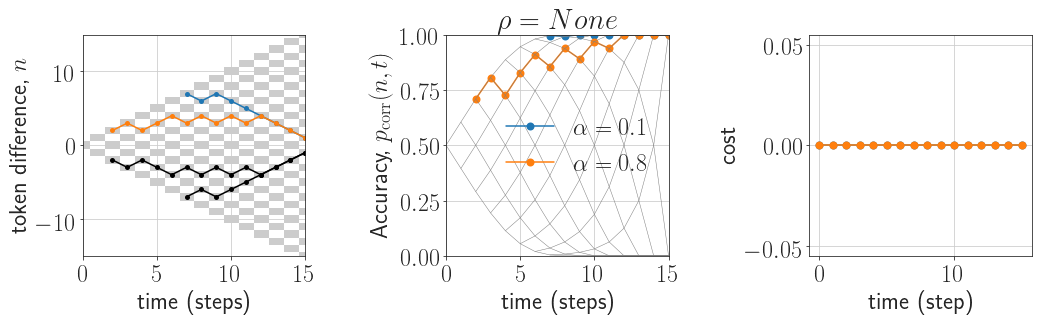

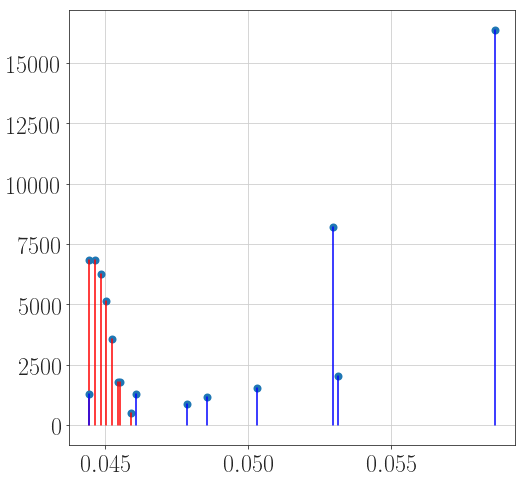

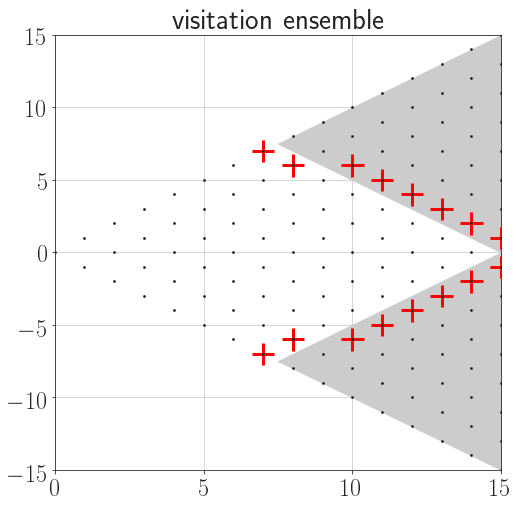

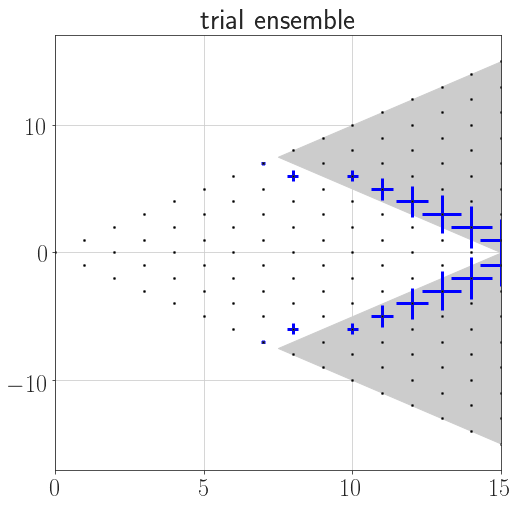

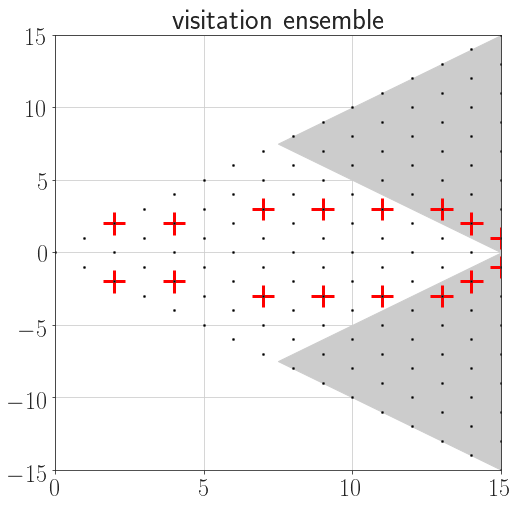

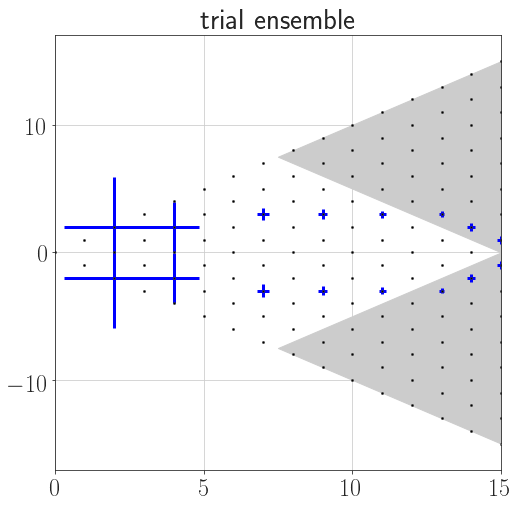

In [626]:
fig,ax=pl.subplots(1,3,figsize=(15,5))
figp,axp=pl.subplots()
col='rb'
alpvec=[0.25,0.75]
for it,alp in enumerate(alpvec):
#    

#     Tavgvec=[]
#     rhovec=[]
#     bias_index_vec=[]
#     for cit,scalar_cost_value in enumerate([-0.05,-0.025,0,0.025,0.05]):
#     for cit,scalar_cost_value in enumerate(np.linspace(0,0.1,20)+1e-4):#[0,0.005,0.01,0.015,0.02]):
    cost_seq=np.zeros(para['T']+1)
#     cost_seq[0]=10#Ttrials[it]*(rhovec[it]-rhobar)
#     cost_seq=scalar_cost_value*np.ones(para['T']+1)
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alp)
#     rhovec.append(rho_zero)

    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dfb=df_traj.copy()
    dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
    dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])
    dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)
    
    dfb['pcorratDectime']=dfb.apply(lambda row:np.max([row.Pt_plus[int(row.tDecision)],1-row.Pt_plus[int(row.tDecision)]]),axis=1) 
#     dfb.pcorratDectime.plot.hist(ax=axp)
    dfb['localRR']=dfb.pcorratDectime/(dfb.tDecision+(1-alp)*(para['T']-dfb.tDecision)+para['T_ITI'])
    data=dfb.localRR.value_counts()
    axp.stem(data.index.values,data.values,linefmt =col[it],basefmt=" ")
#     data=dfb.pcorratDectime.value_counts()
#     axp.stem(data.index.values,data.values,linefmt =col[it],basefmt=" ")
    
    Tavgvec.append(dfb.tDecision.mean())
    if it==0 :#and cit==0:
        Tavg_slow=dfb.tDecision.mean()
        rho_slow=rho_zero
    if it==1:# and cit==1:
        rho_fast=rho_zero
        Tavg_fast=dfb.tDecision.mean()
#         if it==1 and cit==19:
    fig2,ax2=pl.subplots()
    figbase,axbase=pl.subplots()
    bias_index=plot_nocost_dec_times(dfb,pl,'const_cost_'+str(alp),axbase,ax2)


    ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(alp)+'$')#',$'+str(i)+'$')
    ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(alp)+'$')#',M$'+str(i)+'$')
#                 decision boundary in evidence space
    tb,b_evi=data_boundary[0]
    ax[0].plot(tb,b_evi+8*scalar_cost_value,'.-')
    ax[0].plot(tb,-b_evi,'k.-')
    print(cost_seq)
ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')
# ax[1].legend(frameon=False)

for Nm in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,para['T'])
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho_zero))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((para['T']+1,2*para['T']+1))
for t in range(para['T']+1):
    state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)

ax[0].set_ylim(-para['T'],para['T'])
ax[0].set_xlim(0,para['T'])
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# #     fig.savefig('inferred_const_costs'+str(post_interval)+'.pdf', transparent=True,dpi=300)

In [540]:
Ttrials

[21.801483154296875, 15.54656982421875]

In [541]:
rhovec

[0.04563047406790642, 0.05201892311014271]

In [548]:
[rho*T/sum(Ttrials) for rho,T in zip(rhovec,Ttrials)]

[0.02663624827474421, 0.021653493443894164]

In [556]:
Tslow=get_Ttrial(Tavg_slow,0.25)
Tslow

21.801483154296875

In [557]:
rho_slow

0.04828974171889774

In [558]:
Tslow*rho_slow/(Tslow+Tfast)

0.031146206981632542

In [559]:
rho_fast

0.04828974171863839

In [560]:
Tfast=get_Ttrial(Tavg_fast,0.75)
Tfast

15.54656982421875

In [561]:
Tfast*rho_fast/(Tslow+Tfast)

0.020101177479162357

In [562]:
(Tfast*rho_fast+Tslow*rho_slow)/(Tfast+Tslow)*(sum(Ttrials)/(Tfast+Tslow))

0.048289741718789775

In [563]:
rhobar

0.048289741718638375

In [531]:
(Tfast+Tslow)

31.0

In [533]:
sum(Ttrials)

37.348052978515625

In [387]:
get_Ttrial(1,0.25)

19.0

In [388]:
get_Ttrial(1,0.75)

12.0

In [389]:
Tslow*rho_slow

0.9935914184498064

In [390]:
Tfast*rho_fast

0.8081429443359376

reward rate gain if could avoid slow completely

In [391]:
mixture_RR=(rho_fast*Tfast+rho_slow*Tslow)/(Tslow+Tfast)
mixture_RR

0.04824172129728388

In [392]:
allfast_RR=(rho_fast-mixture_RR)/mixture_RR #8% gain if could avoid slow context completely
allfast_RR

0.0775335681425019

in tokens task, subjet can only 'bail' insofar as skipping deliberation (e.g. 1 and done), in this case 

In [393]:
Tavg_slow-get_Ttrial(1,0.25)

-6.7940673828125

In [394]:
mix_slow2onedone_RR=(rho_fast*(Tfast+(Tslow-get_Ttrial(1,0.25)))+get_pt_plus(1,1))/(Tslow+Tfast)
mix_slow2onedone_RR

0.04172924832857649

## context biasing

In [395]:
from lib.dyn_prog_model import get_Ttrial

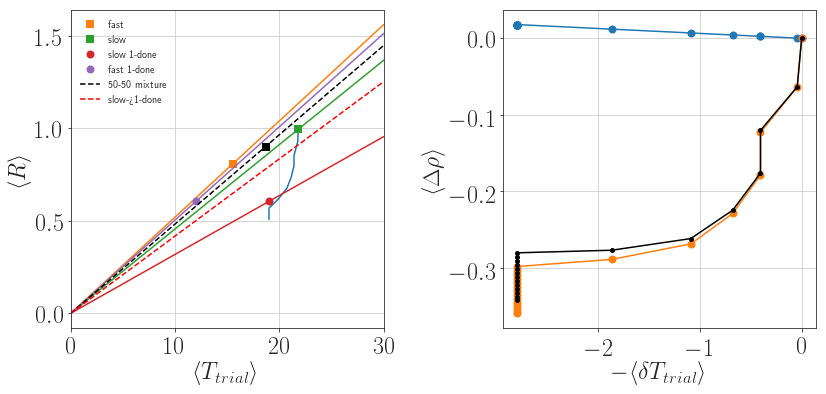

In [397]:
fig, ax=pl.subplots(1,2,figsize=(12,6))
Tdummy=np.linspace(0,2*para['T'],100)

Tavgvec=np.asarray(Tavgvec)
#look at slow block with increasing constant cost (over full interval, so offset to reward rate)
# for rit,rho in enumerate(rhovec):
#     p=ax[0].plot([get_Ttrial(Tavgvec[rit],0.25)],[get_Ttrial(Tavgvec[rit],0.25)*rho],'o')
#     ax[0].plot(Tdummy,rho*Tdummy,'-',color=p[-1].get_color())
ax[0].plot(get_Ttrial(Tavgvec,0.25),get_Ttrial(Tavgvec,0.25)*np.asarray(rhovec),'-')

#add gain from giving more time to fast block
p=ax[0].plot([get_Ttrial(Tavgfast,0.75)],[rho_fast*get_Ttrial(Tavgfast,0.75)],'s',label='fast')
ax[0].plot(Tdummy,rho_fast*Tdummy,'-',color=p[-1].get_color())
#add gain from giving more time to fast block
p=ax[0].plot([get_Ttrial(Tavg_slow,0.25)],[rho_slow*get_Ttrial(Tavg_slow,0.25)],'s',label='slow')
ax[0].plot(Tdummy,rho_slow*Tdummy,'-',color=p[-1].get_color())
#one and done baseline
p=ax[0].plot([get_Ttrial(1,0.25)],[get_pt_plus(1,1)],'o',label='slow 1-done')#,label=r'uniform random: $p_{a_t}=1/3$')
ax[0].plot(Tdummy,(get_pt_plus(1,1)/get_Ttrial(1,0.25))*Tdummy,'-',color=p[-1].get_color())
p=ax[0].plot([get_Ttrial(1,0.75)],[get_pt_plus(1,1)],'o',label='fast 1-done')#,label=r'uniform random: $p_{a_t}=1/3$')
ax[0].plot(Tdummy,(get_pt_plus(1,1)/get_Ttrial(1,0.75))*Tdummy,'-',color=p[-1].get_color())
ax[0].plot(Tdummy,mixture_RR*Tdummy,'k--',label='50-50 mixture')
ax[0].plot([(Tfast+Tslow)/2],[(rho_fast*Tfast+rho_slow*Tslow)/2],'ks')
ax[0].plot(Tdummy,mix_slow2onedone_RR*Tdummy,'r--',label='slow->1-done')

ax[0].legend(frameon=False,fontsize=10)


deltaTslow_vec=get_Ttrial(Tavgvec,0.25)-get_Ttrial(Tavgvec[0],0.25)
# ax[0].plot(Tavgfast+deltaTslow_vec,rho_fast*Tavgfast+rho_fast*deltaTslow_vec,'-')
ax[0].set_xlabel(r'$\langle T_{trial} \rangle$')
ax[0].set_ylabel(r'$\langle R \rangle$')
ax[0].set_xlim(0,2*para['T'])

# for rit,rho in enumerate(rhovec):
#     ax[1].plot([-deltaTslow_vec[rit]],[rhovec[2]-rhovec[rit]],'o-')
#     ax[1].plot([deltaTslow_vec[rit]],[rhovec[2]*deltaTslow_vec[rit]+get_Ttrial(Tavgvec[rit],0.25)*(rhovec[rit]-rhovec[2])],'o-')
    
# ax[1].plot(deltaTslow_vec,[rho_fastvec[2]*deltaTslow_vec[rit]+get_Ttrial(Tavgvec[rit],0.25)*(rhovec[rit]-rhovec[2]) for rit in range(len(rhovec))],'k-')
ax[1].plot(deltaTslow_vec,[(rho_fast-rho_slow)*(-deltaTslow_vec[rit]) for rit in range(len(deltaTslow_vec))],'o-')
ax[1].plot(deltaTslow_vec,[get_Ttrial(Tavgvec[rit],0.25)*(rhovec[rit]-rho_slow) for rit in range(len(rhovec))],'o-')
ax[1].plot(deltaTslow_vec,[rho_fast*(-deltaTslow_vec[rit])+rho_slow*deltaTslow_vec[rit]+get_Ttrial(Tavgvec[rit],0.25)*(rhovec[rit]-rho_slow) for rit in range(len(rhovec))],'k.-')
    
# ax[1].plot(ax[1].get_xlim(),[rhovec[2]-get_pt_plus(1,1)/get_Ttrial(1,0.25)]*2,'-')
ax[1].set_xlabel(r'$-\langle \delta T_{trial} \rangle$')
ax[1].set_ylabel(r'$\langle \Delta \rho \rangle$')
fig.tight_layout()

# Linear cost

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/plotting.py:56: RuntimeWarning: invalid value encountered in true_divide
  dec_dist=np.where(occupancy_predec_counts>0,dec_counts/occupancy_predec_counts,0)


0.08444444444445309


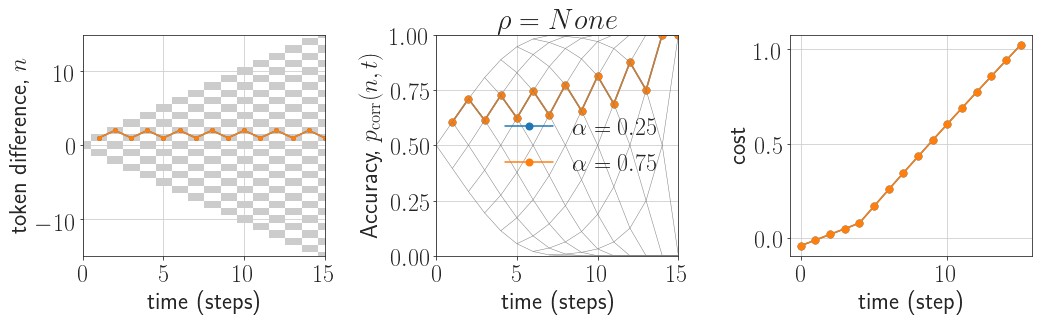

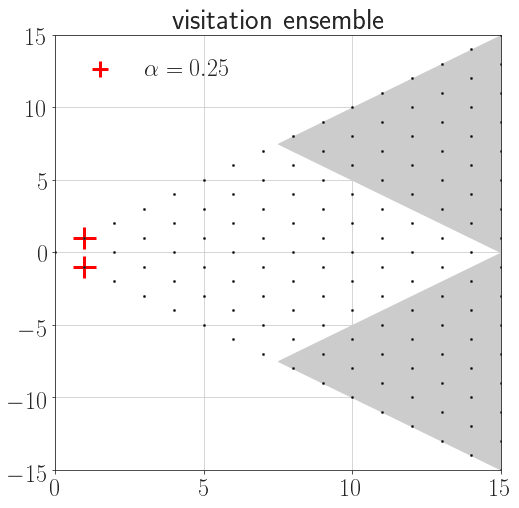

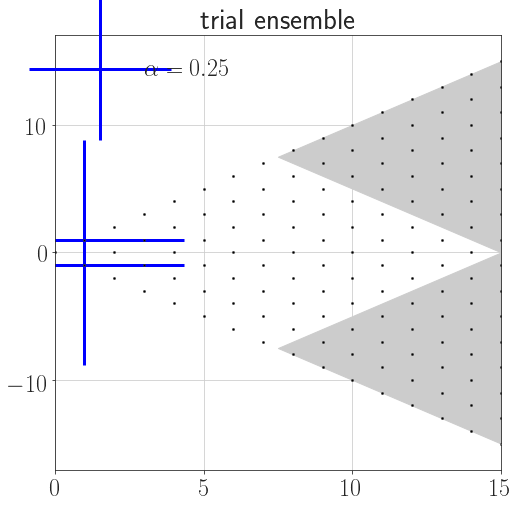

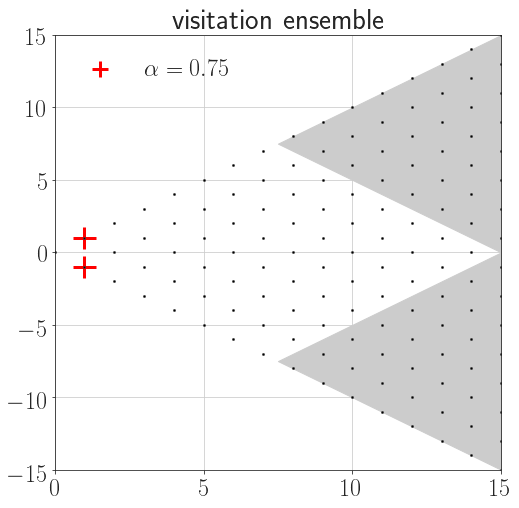

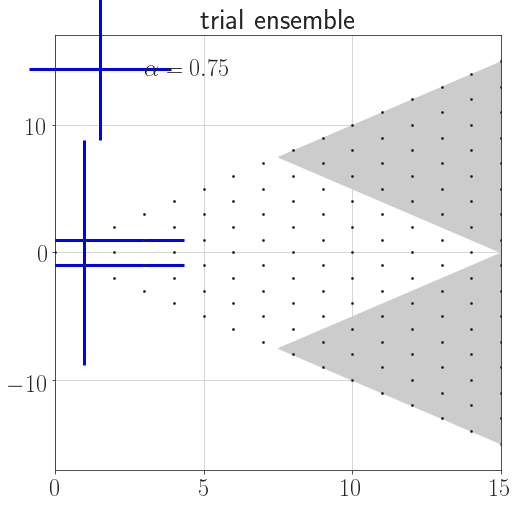

In [263]:
fig,ax=pl.subplots(1,3,figsize=(15,5))

# figamb,axamb=pl.subplots(1,2)
block_times=[150,50]#[170,20]#
gamvec=np.asarray(block_times)/200
alpvec=1-gamvec
rhovec=[]
bias_index_vec=[]
avgtdec=[]

# cost_seq=0.04*np.arange(para['T']+1)-0.04
tmin=4
r_avg=0.03
time=np.arange(para['T']+1)
# cost_seq=r_avg*(1-1/(1+r_avg*(time-tmin)))
cost_seq=1*(r_avg*(time-tmin)+np.log(1+r_avg*(time-tmin)))
cost_seq[time<tmin]=0
cost_seq+=r_avg*time -0.04
# cost_seq*=8
for it,post_interval in enumerate(block_times):
    rho_zero,data_boundary,dec_data,cost_seq=get_DP_boundary(cost_seq,gamvec[it])
    rhovec.append(rho_zero)
    
    tb,b_bel=data_boundary[1]
    b_beltmp=[]
    for t in range(para['T']+1):
        teff=t-(para['T']-len(b_bel))-1
        b_beltmp.append(b_bel[teff] if teff>=0 else 1)
    b_beltmp=np.asarray(b_beltmp)
    dfb=df_traj.copy()
   
    dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else para['T'])

    dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
    dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)

    avgtdec.append(dfb['tDecision'].mean())
    fig2,ax2=pl.subplots()
    figbase,axbase=pl.subplots()
    bias_index=plot_nocost_dec_times(dfb,pl,'no_cost_'+str(post_interval),axbase,ax2,label_str=r"$\alpha="+str(alpvec[it])+r"$")
    bias_index_vec.append(bias_index)
    
    
    ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(1-gamvec[it])+'$')#',$'+str(i)+'$')
    ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(1-gamvec[it])+'$')#',M$'+str(i)+'$')
    #decision boundary in evidence space
    tb,b_evi=data_boundary[0]
    ax[0].plot(tb,b_evi,'.-')

ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')

for Nm in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Nm/2)+Nm/2,np.arange(para['T']+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(para['T']):
    ax[1].plot(np.arange(para['T']+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(para['T']+1-Np/2)+Np/2,np.arange(para['T']+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,para['T'])
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho_zero))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((para['T']+1,2*para['T']+1))
for t in range(para['T']+1):
    state_space[t,slice(para['T']-t,para['T']+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)
    
ax[0].set_ylim(-para['T'],para['T'])
ax[0].set_xlim(0,para['T'])
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# fig.savefig('inferred_zero_costs.pdf', transparent=True,dpi=300)

## bayesian inference

In [42]:
dfb=df_traj.copy()

get decision times and rewards for no cost strategy

In [43]:
c=0
alpha=0.75

cost_seq=c*np.ones(para['T']+1)
rho_c,data_boundary_c,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alpha)
    
reward_rate_dec_time_distr=get_reward_rate_dec_time_distr(data_boundary_c,dfb,1-alpha,T=para['T'],T_ITI=para['T_ITI'],c=c)
    
mean_reward=(reward_rate_dec_time_distr.index.get_level_values(1) \
                *reward_rate_dec_time_distr \
                /reward_rate_dec_time_distr.sum() \
                 ).sum()
t_vals=reward_rate_dec_time_distr.index.get_level_values(0)
r_vals=reward_rate_dec_time_distr.index.get_level_values(1)

In [46]:
Nt_samples=np.cumsum(np.asarray(dfb.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
z_d_data=get_survprob(dfb,Nt_samples,data_boundary_c,T=para['T'])

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/lib.py:49: RuntimeWarning: invalid value encountered in less
  return (tvecdense,Nvecdense,z_d)


In [47]:
tmin=4
r_avg=0.04
time=np.arange(para['T']+1)
cost_seq=r_avg*(1-1/(1+r_avg*(time-tmin)))
cost_seq[time<tmin]=0
cost_seq*=8
rho_part,data_boundary_part,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alpha)
z_d_data_part=get_survprob(dfb,Nt_samples,data_boundary_part,T=para['T'])

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


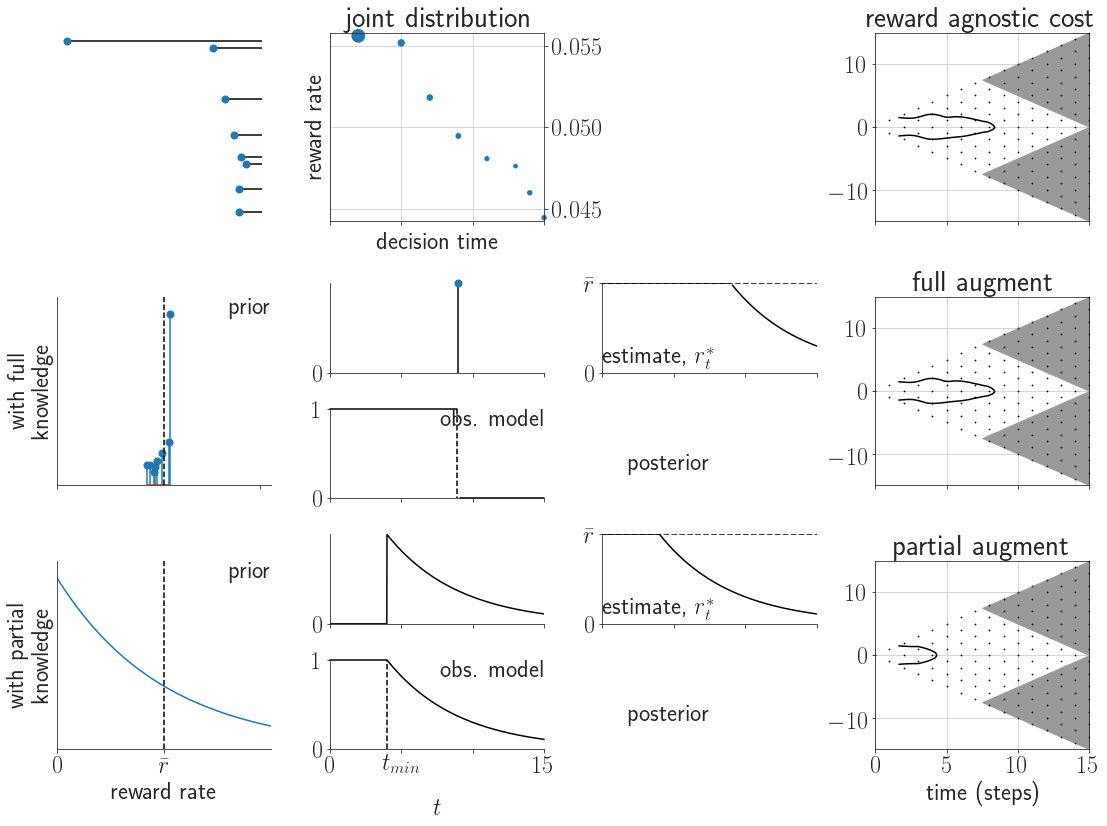

In [41]:
fig = pl.figure(figsize=(16,12))


T=15
#First row

ax_corr=fig.add_subplot(342)
ax_corr.scatter(t_vals,r_vals,s=reward_rate_dec_time_distr/100,clip_on=False)
ax_corr.yaxis.tick_right()
ax_corr.set_xticks([0,5,10,15])
ax_corr.set_xticklabels([])
ax_corr.set_title(r'joint distribution')
# ax_corr.xaxis.tick_top()
ax_corr.set_xlim(0,T)
ax_corr.set_ylabel('reward rate')
ax_corr.set_xlabel('decision time')
# ax_corr.plot([0,15],[posterior_expected_reward_rate[-1],posterior_expected_reward_rate[-1]],'k--')
ax_corr.set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)

ax_rew=fig.add_subplot(341)
ax_rew.set_yticks([])
ax_rew.hlines(r_vals, 0, reward_rate_dec_time_distr.values)#,color=p[-2][0].get_color())  # Stems
ax_rew.plot(reward_rate_dec_time_distr.values, r_vals, 'o')#,p[-2][0].get_color())  # Stem ends
ax_rew.set_xlabel('frequency')
ax_rew.set_ylabel('reward rate')
# ax_rew.set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)
# ax_rew.set_xlim(0,0.25)
ax_rew.invert_xaxis()
ax_rew.axis('off')

ax_cost=fig.add_subplot(344)
ax_cost.set_title('reward agnostic cost')
ax_cost.contour(*z_d_data,levels=[0.5],linewidths=(1.5,),colors=['k'],zorder=20)
ax_cost.set_xlim(0,15)
ax_cost.set_ylim(-para['T'],para['T'])
ax_cost.set_xticks([0,1/3*T,2/3*T,T]) 
ax_cost.set_xlim(0,para['T'])
# ax_cost.set_ylabel(r'token difference, $N_t$')
ax_cost.set_xticklabels([])
point=8
offset=0.5
ax_cost.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
ax_cost.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
for Nm in 2*np.arange(T):
    ax_cost.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
for Np in 2*np.arange(T):
    ax_cost.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)

#full case

ax_rew=fig.add_subplot(345)
ax_rew.set_yticks([])
ax_rew.set_xticklabels([])
ax_rew.stem(r_vals, reward_rate_dec_time_distr.values)#,color=p[-2][0].get_color())  # Stems
ax_rew.set_ylabel('with full \n knowledge')
ax_rew.set_ylim(0,reward_rate_dec_time_distr.max()*1.1)
ax_rew.plot([mean_reward]*2,ax_rew.get_ylim(),'k--')
ax_rew.set_xlim(0,2*mean_reward)
ax_rew.grid(None)
ax_rew.spines['right'].set_visible(False)
ax_rew.spines['top'].set_visible(False)
ax_rew.text(1,1,'prior',transform=ax_rew.transAxes,ha='right',va='top')
ax_rew.set_xlim(0,2*mean_reward)
time_vec=np.linspace(0,15,100)
# t_bmin_test=4.3
t_bmin_test=9
r_test=0.2
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=0

ax_denfull=fig.add_subplot(6,4,10)
ax_denfull.plot([t_bmin_test]*2,[0,1],'k-')
ax_denfull.plot([t_bmin_test],[1],'o',clip_on=False)
ax_denfull.grid(None)
# ax_denfull.set_ylabel(r'$\rho(t_\textrm{dec}|r)$')
ax_denfull.set_xticks([0,5,10,15])
ax_denfull.set_xticklabels([])
ax_denfull.set_yticks([0])
ax_denfull.set_xlim([0,T])
ax_denfull.set_ylim([0,1])
ax_denfull.spines['right'].set_visible(False)
ax_denfull.spines['top'].set_visible(False)

ax_survfull=fig.add_subplot(6,4,14)
ax_survfull.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
ax_survfull.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
ax_survfull.plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
# ax_survfull.set_xlabel(r'$t$',labelpad=20)
# ax_survfull.set_ylabel(r'$P(t<t_{dec}|r)$')
ax_survfull.set_xticks([0,5,10,15])
ax_survfull.set_xticklabels([])
ax_survfull.set_yticks([0,1])
ax_survfull.set_xlim([0,T])
ax_survfull.set_ylim([0,1])
ax_survfull.grid(None)
ax_survfull.spines['right'].set_visible(False)
ax_survfull.spines['top'].set_visible(False)
ax_survfull.text(1,1,'obs. model',transform=ax_survfull.transAxes,ha='right',va='top')

ax_postfull=fig.add_subplot(6,4,15)
ax_postfull.text(0.5,0.5,'posterior',transform=ax_postfull.transAxes,ha='right',va='top')
ax_postfull.axis('off')

ax_MAPfull=fig.add_subplot(6,4,11)
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
ax_MAPfull.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-')
ax_MAPfull.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-')
ax_MAPfull.plot(ax_MAPfull.get_xlim(),[1]*2,'k--')
# ax_MAPpart.set_xlabel(r'$t$',labelpad=20)
# ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
ax_MAPfull.set_xticks([0,5,10,15])
ax_MAPfull.set_xticklabels([])
ax_MAPfull.set_yticklabels(['$0$',r'$\bar{r}$'])
ax_MAPfull.set_yticks([0,1])
ax_MAPfull.set_xlim([0,T])
ax_MAPfull.set_ylim([0,1])
ax_MAPfull.grid(None)
ax_MAPfull.spines['right'].set_visible(False)
ax_MAPfull.spines['top'].set_visible(False)
ax_MAPfull.text(0,0,'estimate, $r^*_t$',transform=ax_MAPfull.transAxes,ha='left',va='bottom')

# part case

rvec=np.linspace(0,2*np.max(r_vals),100)
ax_rew=fig.add_subplot(349)
ax_rew.set_yticks([])
ax_rew.plot(rvec, reward_rate_dec_time_distr.max()*np.exp(-rvec/mean_reward))#,color=p[-2][0].get_color())  # Stems
ax_rew.set_ylim(0,reward_rate_dec_time_distr.max()*1.1)
ax_rew.plot([mean_reward]*2,ax_rew.get_ylim(),'k--')
ax_rew.set_xticks([0,mean_reward])
ax_rew.set_xticklabels([r'$0$',r'$\bar{r}$'])
ax_rew.set_xlim(0,2*mean_reward)
ax_rew.text(1,1,'prior',transform=ax_rew.transAxes,ha='right',va='top')
ax_rew.set_ylabel('with partial \n knowledge')
ax_rew.set_xlabel('reward rate')
# ax_rew.set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)
ax_rew.grid(None)
ax_rew.spines['right'].set_visible(False)
ax_rew.spines['top'].set_visible(False)

time_vec=np.linspace(0,15,1000)
t_bmin_test=4
r_test=0.2

ax_denpart=fig.add_subplot(6,4,18)
surv_func_theory=np.zeros(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
ax_denpart.plot(time_vec,surv_func_theory,'k-')
ax_denpart.set_clip_on('False')
# ax_denpart.set_ylabel(r'$\rho(t_\textrm{dec}|r)$')
ax_denpart.set_xticks([0,5,10,15])
ax_denpart.set_xticklabels([])
ax_denpart.set_yticks([0])
ax_denpart.set_xlim([0,T])
ax_denpart.set_ylim([0,1])
ax_denpart.grid(None)
ax_denpart.spines['right'].set_visible(False)
ax_denpart.spines['top'].set_visible(False)

ax_survpart=fig.add_subplot(6,4,22)
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
ax_survpart.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
ax_survpart.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
ax_survpart.plot([4]*2,[0,1],'k--',clip_on=False)
ax_survpart.set_xlabel(r'$t$',labelpad=20)
# ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
ax_survpart.set_xticks([0,5,10,15])
ax_survpart.set_xticklabels(['$0$',r'$t_{min}$','',r'$15$'])
ax_survpart.set_yticks([0,1])
ax_survpart.set_xlim([0,T])
ax_survpart.set_ylim([0,1])
ax_survpart.grid(None)
ax_survpart.spines['right'].set_visible(False)
ax_survpart.spines['top'].set_visible(False)
ax_survpart.text(1,1,'obs. model',transform=ax_survpart.transAxes,ha='right',va='top')

ax_MAPpart=fig.add_subplot(6,4,19)
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
ax_MAPpart.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-')
ax_MAPpart.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-')
ax_MAPpart.plot(ax_MAPpart.get_xlim(),[1]*2,'k--')
# ax_MAPpart.set_xlabel(r'$t$',labelpad=20)
# ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
ax_MAPpart.set_xticks([0,5,10,15])
ax_MAPpart.set_xticklabels([])
ax_MAPpart.set_yticklabels(['$0$',r'$\bar{r}$'])
ax_MAPpart.set_yticks([0,1])
ax_MAPpart.set_xlim([0,T])
ax_MAPpart.set_ylim([0,1])
ax_MAPpart.grid(None)
ax_MAPpart.spines['right'].set_visible(False)
ax_MAPpart.spines['top'].set_visible(False)
ax_MAPpart.text(0,0,r'estimate, $r^*_t$',transform=ax_MAPpart.transAxes,ha='left',va='bottom')

ax_postpart=fig.add_subplot(6,4,23)
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
# ax_postpart.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
# # ax_postpart.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
# ax_postpart.plot([4]*2,[0,1],'k--',clip_on=False)
ax_postpart.set_xticklabels(['$0$','','',r'$15$'])
ax_postpart.set_xlabel(r'$t$',labelpad=20)
ax_postpart.text(0.5,0.5,'posterior',transform=ax_postpart.transAxes,ha='right',va='top')
# ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
ax_postpart.set_xticks([0,5,10,15])
ax_postpart.set_yticks([0,1])
ax_postpart.set_xlim([0,T])
ax_postpart.set_ylim([0,1])
ax_postpart.grid(None)
ax_postpart.spines['right'].set_visible(False)
ax_postpart.spines['top'].set_visible(False)
ax_postpart.axis('off')


#last strategies

ax_cost=fig.add_subplot(348)
ax_cost.contour(*z_d_data,levels=[0.5],linewidths=(1.5,),colors=['k'],zorder=20)
ax_cost.set_xlim(0,15)
ax_cost.set_ylim(-para['T'],para['T'])
ax_cost.set_xticks([0,1/3*T,2/3*T,T]) 
ax_cost.set_xlim(0,para['T'])
# ax_cost.set_ylabel(r'token difference, $N_t$')
ax_cost.set_xticklabels([])
ax_cost.set_title('full augment')
point=8
offset=0.5
ax_cost.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
ax_cost.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
for Nm in 2*np.arange(T):
    ax_cost.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
for Np in 2*np.arange(T):
    ax_cost.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    
ax_cost=fig.add_subplot(3,4,12)
ax_cost.contour(*z_d_data_part,levels=[0.5],linewidths=(1.5,),colors=['k'],zorder=20)
ax_cost.set_xlim(0,15)
ax_cost.set_ylim(-para['T'],para['T'])
ax_cost.set_xticks([0,1/3*T,2/3*T,T]) 
ax_cost.set_xlim(0,para['T'])
# ax_cost.set_ylabel(r'token difference, $N_t$')
ax_cost.set_xlabel(r'time (steps)')
# ax_cost.set_xticklabels([])
ax_cost.set_title('partial augment')
point=8
offset=0.5
ax_cost.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
ax_cost.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
for Nm in 2*np.arange(T):
    ax_cost.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
for Np in 2*np.arange(T):
    ax_cost.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    
fig.tight_layout(h_pad=0.03,w_pad=0.04)

# fig.savefig('bayesianflow.pdf', transparent=True,dpi=300)

## Inferred cost

FileNotFoundError: [Errno 2] No such file or directory: 'data_bel_boundary_subj_1_postint_150.npy'

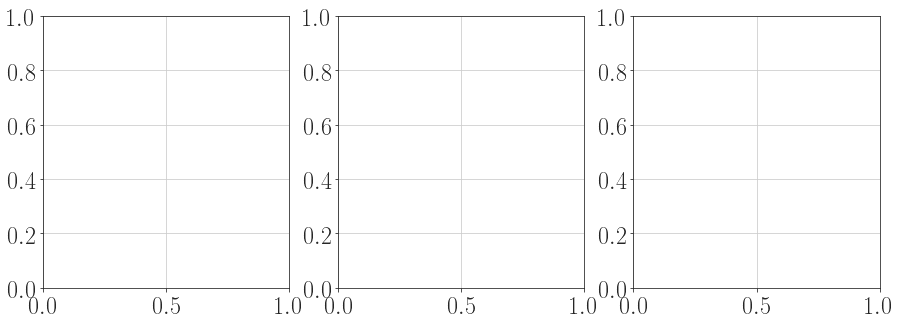

In [33]:
fig,ax=pl.subplots(1,3,figsize=(15,5))
gamvec=[3/4,1/4]
block_times=[150,50]
rhovec=[]
for i in range(1,3):
    for it,post_interval in enumerate(block_times):
        file_path='data_bel_boundary_subj_'+str(i)+'_postint_'+str(post_interval)+'.npy'
        rho,cost_seq,data_boundary=solve_DP_cost_strategy(file_path,gamvec[it],plot=False,T=para['T'])
        
        tb,b_bel=data_boundary[1]
        b_beltmp=[]
        for t in range(T+1):
            teff=t-(T-len(b_bel))-1
            b_beltmp.append(b_bel[teff] if teff>=0 else 1)
        b_beltmp=np.asarray(b_beltmp)
        dfb=df_traj.copy()
        dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
        dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else T)
        dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)
        fig2,ax2=pl.subplots(1,3)
        plot_dec_times(dfb,pl,'oppor_cost_'+str(post_interval),ymax=0.3,ax=ax2)
        
        rhovec.append(rho)
        ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(gamvec[it])+'$,$'+str(i)+'$')
        ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(gamvec[it])+'$,M$'+str(i)+'$')
        tb,b_evi=data_boundary[0]
        ax[0].plot(tb,b_evi,'.-')
        
ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')
# ax[1].legend(frameon=False)

T=15
for Nm in 2*np.arange(T):
    ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
    ax[1].plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,T)
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((T+1,2*T+1))
for t in range(T+1):
    state_space[t,slice(T-t,T+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)
    
ax[0].set_ylim(-T,T)
ax[0].set_xlim(0,T)
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
fig.savefig('inferred_costs.png', transparent=True,dpi=300)

In [38]:
c=0
alpha=0.75

cost_seq=c*np.ones(para['T']+1)
rho_c,data_boundary_c,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alpha)
    
reward_rate_dec_time_distr=get_reward_rate_dec_time_distr(data_boundary_c,dfb,1-alpha,T=para['T'],T_ITI=para['T_ITI'],c=c)
    
mean_reward=(reward_rate_dec_time_distr.index.get_level_values(1) \
                *reward_rate_dec_time_distr \
                /reward_rate_dec_time_distr.sum() \
                 ).sum()
t_vals=reward_rate_dec_time_distr.index.get_level_values(0)
r_vals=reward_rate_dec_time_distr.index.get_level_values(1)

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each a

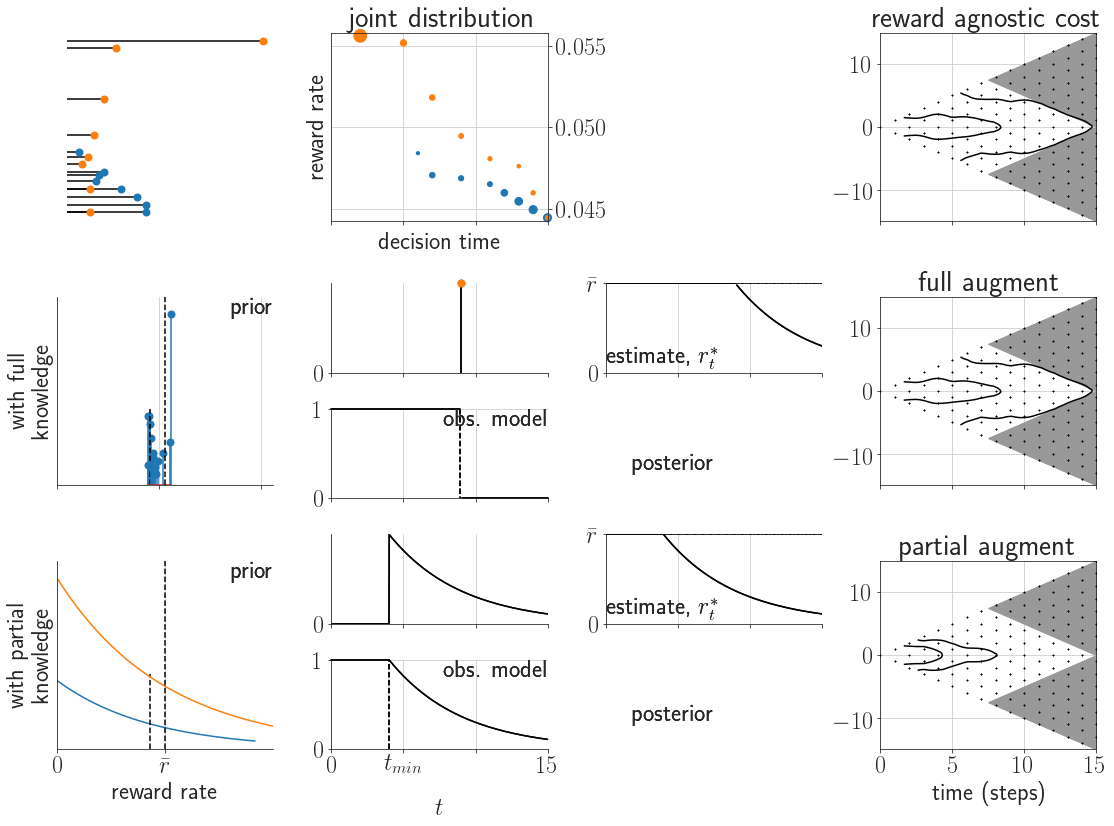

In [42]:
fig = pl.figure(figsize=(16,12))
for alpha in (1/4,3/4):
    c=0

    cost_seq=c*np.ones(para['T']+1)
    rho_c,data_boundary_c,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alpha)

    reward_rate_dec_time_distr=get_reward_rate_dec_time_distr(data_boundary_c,dfb,1-alpha,T=para['T'],T_ITI=para['T_ITI'],c=c)

    mean_reward=(reward_rate_dec_time_distr.index.get_level_values(1) \
                    *reward_rate_dec_time_distr \
                    /reward_rate_dec_time_distr.sum() \
                     ).sum()
    t_vals=reward_rate_dec_time_distr.index.get_level_values(0)
    r_vals=reward_rate_dec_time_distr.index.get_level_values(1)
    
    Nt_samples=np.cumsum(np.asarray(dfb.seq.tolist()),axis=1) #note that this starts at t=1, so indexing adjusted by -1 below.
    z_d_data=get_survprob(dfb,Nt_samples,data_boundary_c,T=para['T'])
    
    tmin=4
    r_avg=0.04
    time=np.arange(para['T']+1)
    cost_seq=r_avg*(1-1/(1+r_avg*(time-tmin)))
    cost_seq[time<tmin]=0
    cost_seq*=8
    rho_part,data_boundary_part,dec_data,cost_seq=get_DP_boundary(cost_seq,1-alpha)
    z_d_data_part=get_survprob(dfb,Nt_samples,data_boundary_part,T=para['T'])
    
    T=15
    #First row

    ax_corr=fig.add_subplot(342)
    ax_corr.scatter(t_vals,r_vals,s=reward_rate_dec_time_distr/100,clip_on=False)
    ax_corr.yaxis.tick_right()
    ax_corr.set_xticks([0,5,10,15])
    ax_corr.set_xticklabels([])
    ax_corr.set_title(r'joint distribution')
    # ax_corr.xaxis.tick_top()
    ax_corr.set_xlim(0,T)
    ax_corr.set_ylabel('reward rate')
    ax_corr.set_xlabel('decision time')
    # ax_corr.plot([0,15],[posterior_expected_reward_rate[-1],posterior_expected_reward_rate[-1]],'k--')
    ax_corr.set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)

    ax_rew=fig.add_subplot(341)
    ax_rew.set_yticks([])
    ax_rew.hlines(r_vals, 0, reward_rate_dec_time_distr.values)#,color=p[-2][0].get_color())  # Stems
    ax_rew.plot(reward_rate_dec_time_distr.values, r_vals, 'o')#,p[-2][0].get_color())  # Stem ends
    ax_rew.set_xlabel('frequency')
    ax_rew.set_ylabel('reward rate')
    # ax_rew.set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)
    # ax_rew.set_xlim(0,0.25)
    ax_rew.invert_xaxis()
    ax_rew.axis('off')

    ax_cost=fig.add_subplot(344)
    ax_cost.set_title('reward agnostic cost')
    ax_cost.contour(*z_d_data,levels=[0.5],linewidths=(1.5,),colors=['k'],zorder=20)
    ax_cost.set_xlim(0,15)
    ax_cost.set_ylim(-para['T'],para['T'])
    ax_cost.set_xticks([0,1/3*T,2/3*T,T]) 
    ax_cost.set_xlim(0,para['T'])
    # ax_cost.set_ylabel(r'token difference, $N_t$')
    ax_cost.set_xticklabels([])
    point=8
    offset=0.5
    ax_cost.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
    ax_cost.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
    for Nm in 2*np.arange(T):
        ax_cost.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    for Np in 2*np.arange(T):
        ax_cost.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)

    #full case

    ax_rew=fig.add_subplot(345)
    ax_rew.set_yticks([])
    ax_rew.set_xticklabels([])
    ax_rew.stem(r_vals, reward_rate_dec_time_distr.values)#,color=p[-2][0].get_color())  # Stems
    ax_rew.set_ylabel('with full \n knowledge')
    ax_rew.set_ylim(0,reward_rate_dec_time_distr.max()*1.1)
    ax_rew.plot([mean_reward]*2,ax_rew.get_ylim(),'k--')
    ax_rew.set_xlim(0,2*mean_reward)
    ax_rew.grid(None)
    ax_rew.spines['right'].set_visible(False)
    ax_rew.spines['top'].set_visible(False)
    ax_rew.text(1,1,'prior',transform=ax_rew.transAxes,ha='right',va='top')
    ax_rew.set_xlim(0,2*mean_reward)
    time_vec=np.linspace(0,15,100)
    # t_bmin_test=4.3
    t_bmin_test=9
    r_test=0.2
    surv_func_theory=np.ones(time_vec.shape)
    surv_func_theory[time_vec>t_bmin_test]=0

    ax_denfull=fig.add_subplot(6,4,10)
    ax_denfull.plot([t_bmin_test]*2,[0,1],'k-')
    ax_denfull.plot([t_bmin_test],[1],'o',clip_on=False)
    ax_denfull.grid(None)
    # ax_denfull.set_ylabel(r'$\rho(t_\textrm{dec}|r)$')
    ax_denfull.set_xticks([0,5,10,15])
    ax_denfull.set_xticklabels([])
    ax_denfull.set_yticks([0])
    ax_denfull.set_xlim([0,T])
    ax_denfull.set_ylim([0,1])
    ax_denfull.spines['right'].set_visible(False)
    ax_denfull.spines['top'].set_visible(False)

    ax_survfull=fig.add_subplot(6,4,14)
    ax_survfull.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
    ax_survfull.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
    ax_survfull.plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
    # ax_survfull.set_xlabel(r'$t$',labelpad=20)
    # ax_survfull.set_ylabel(r'$P(t<t_{dec}|r)$')
    ax_survfull.set_xticks([0,5,10,15])
    ax_survfull.set_xticklabels([])
    ax_survfull.set_yticks([0,1])
    ax_survfull.set_xlim([0,T])
    ax_survfull.set_ylim([0,1])
    ax_survfull.grid(None)
    ax_survfull.spines['right'].set_visible(False)
    ax_survfull.spines['top'].set_visible(False)
    ax_survfull.text(1,1,'obs. model',transform=ax_survfull.transAxes,ha='right',va='top')

    ax_postfull=fig.add_subplot(6,4,15)
    ax_postfull.text(0.5,0.5,'posterior',transform=ax_postfull.transAxes,ha='right',va='top')
    ax_postfull.axis('off')

    ax_MAPfull=fig.add_subplot(6,4,11)
    surv_func_theory=np.ones(time_vec.shape)
    surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
    ax_MAPfull.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-')
    ax_MAPfull.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-')
    ax_MAPfull.plot(ax_MAPfull.get_xlim(),[1]*2,'k--')
    # ax_MAPpart.set_xlabel(r'$t$',labelpad=20)
    # ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
    ax_MAPfull.set_xticks([0,5,10,15])
    ax_MAPfull.set_xticklabels([])
    ax_MAPfull.set_yticklabels(['$0$',r'$\bar{r}$'])
    ax_MAPfull.set_yticks([0,1])
    ax_MAPfull.set_xlim([0,T])
    ax_MAPfull.set_ylim([0,1])
    ax_MAPfull.grid(None)
    ax_MAPfull.spines['right'].set_visible(False)
    ax_MAPfull.spines['top'].set_visible(False)
    ax_MAPfull.text(0,0,'estimate, $r^*_t$',transform=ax_MAPfull.transAxes,ha='left',va='bottom')

    # part case

    rvec=np.linspace(0,2*np.max(r_vals),100)
    ax_rew=fig.add_subplot(349)
    ax_rew.set_yticks([])
    ax_rew.plot(rvec, reward_rate_dec_time_distr.max()*np.exp(-rvec/mean_reward))#,color=p[-2][0].get_color())  # Stems
    ax_rew.set_ylim(0,reward_rate_dec_time_distr.max()*1.1)
    ax_rew.plot([mean_reward]*2,ax_rew.get_ylim(),'k--')
    ax_rew.set_xticks([0,mean_reward])
    ax_rew.set_xticklabels([r'$0$',r'$\bar{r}$'])
    ax_rew.set_xlim(0,2*mean_reward)
    ax_rew.text(1,1,'prior',transform=ax_rew.transAxes,ha='right',va='top')
    ax_rew.set_ylabel('with partial \n knowledge')
    ax_rew.set_xlabel('reward rate')
    # ax_rew.set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)
    ax_rew.grid(None)
    ax_rew.spines['right'].set_visible(False)
    ax_rew.spines['top'].set_visible(False)

    time_vec=np.linspace(0,15,1000)
    t_bmin_test=4
    r_test=0.2

    ax_denpart=fig.add_subplot(6,4,18)
    surv_func_theory=np.zeros(time_vec.shape)
    surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
    ax_denpart.plot(time_vec,surv_func_theory,'k-')
    ax_denpart.set_clip_on('False')
    # ax_denpart.set_ylabel(r'$\rho(t_\textrm{dec}|r)$')
    ax_denpart.set_xticks([0,5,10,15])
    ax_denpart.set_xticklabels([])
    ax_denpart.set_yticks([0])
    ax_denpart.set_xlim([0,T])
    ax_denpart.set_ylim([0,1])
    ax_denpart.grid(None)
    ax_denpart.spines['right'].set_visible(False)
    ax_denpart.spines['top'].set_visible(False)

    ax_survpart=fig.add_subplot(6,4,22)
    surv_func_theory=np.ones(time_vec.shape)
    surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
    ax_survpart.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
    ax_survpart.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
    ax_survpart.plot([4]*2,[0,1],'k--',clip_on=False)
    ax_survpart.set_xlabel(r'$t$',labelpad=20)
    # ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
    ax_survpart.set_xticks([0,5,10,15])
    ax_survpart.set_xticklabels(['$0$',r'$t_{min}$','',r'$15$'])
    ax_survpart.set_yticks([0,1])
    ax_survpart.set_xlim([0,T])
    ax_survpart.set_ylim([0,1])
    ax_survpart.grid(None)
    ax_survpart.spines['right'].set_visible(False)
    ax_survpart.spines['top'].set_visible(False)
    ax_survpart.text(1,1,'obs. model',transform=ax_survpart.transAxes,ha='right',va='top')

    ax_MAPpart=fig.add_subplot(6,4,19)
    surv_func_theory=np.ones(time_vec.shape)
    surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
    ax_MAPpart.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-')
    ax_MAPpart.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-')
    ax_MAPpart.plot(ax_MAPpart.get_xlim(),[1]*2,'k--')
    # ax_MAPpart.set_xlabel(r'$t$',labelpad=20)
    # ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
    ax_MAPpart.set_xticks([0,5,10,15])
    ax_MAPpart.set_xticklabels([])
    ax_MAPpart.set_yticklabels(['$0$',r'$\bar{r}$'])
    ax_MAPpart.set_yticks([0,1])
    ax_MAPpart.set_xlim([0,T])
    ax_MAPpart.set_ylim([0,1])
    ax_MAPpart.grid(None)
    ax_MAPpart.spines['right'].set_visible(False)
    ax_MAPpart.spines['top'].set_visible(False)
    ax_MAPpart.text(0,0,r'estimate, $r^*_t$',transform=ax_MAPpart.transAxes,ha='left',va='bottom')

    ax_postpart=fig.add_subplot(6,4,23)
    surv_func_theory=np.ones(time_vec.shape)
    surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
    # ax_postpart.plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
    # # ax_postpart.plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
    # ax_postpart.plot([4]*2,[0,1],'k--',clip_on=False)
    ax_postpart.set_xticklabels(['$0$','','',r'$15$'])
    ax_postpart.set_xlabel(r'$t$',labelpad=20)
    ax_postpart.text(0.5,0.5,'posterior',transform=ax_postpart.transAxes,ha='right',va='top')
    # ax_survpart.set_ylabel(r'$P(t<t_{dec}|r)$')
    ax_postpart.set_xticks([0,5,10,15])
    ax_postpart.set_yticks([0,1])
    ax_postpart.set_xlim([0,T])
    ax_postpart.set_ylim([0,1])
    ax_postpart.grid(None)
    ax_postpart.spines['right'].set_visible(False)
    ax_postpart.spines['top'].set_visible(False)
    ax_postpart.axis('off')


    #last strategies

    ax_cost=fig.add_subplot(348)
    ax_cost.contour(*z_d_data,levels=[0.5],linewidths=(1.5,),colors=['k'],zorder=20)
    ax_cost.set_xlim(0,15)
    ax_cost.set_ylim(-para['T'],para['T'])
    ax_cost.set_xticks([0,1/3*T,2/3*T,T]) 
    ax_cost.set_xlim(0,para['T'])
    # ax_cost.set_ylabel(r'token difference, $N_t$')
    ax_cost.set_xticklabels([])
    ax_cost.set_title('full augment')
    point=8
    offset=0.5
    ax_cost.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
    ax_cost.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
    for Nm in 2*np.arange(T):
        ax_cost.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    for Np in 2*np.arange(T):
        ax_cost.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)

    ax_cost=fig.add_subplot(3,4,12)
    ax_cost.contour(*z_d_data_part,levels=[0.5],linewidths=(1.5,),colors=['k'],zorder=20)
    ax_cost.set_xlim(0,15)
    ax_cost.set_ylim(-para['T'],para['T'])
    ax_cost.set_xticks([0,1/3*T,2/3*T,T]) 
    ax_cost.set_xlim(0,para['T'])
    # ax_cost.set_ylabel(r'token difference, $N_t$')
    ax_cost.set_xlabel(r'time (steps)')
    # ax_cost.set_xticklabels([])
    ax_cost.set_title('partial augment')
    point=8
    offset=0.5
    ax_cost.fill_between(-offset+np.arange(point,2*point+1),-offset+point-np.arange(point+1),-offset+point+np.arange(point+1),color=[0.6,0.6,0.6])
    ax_cost.fill_between(-offset+np.arange(point,2*point+1),offset-point-np.arange(point+1),offset-point+np.arange(point+1),color=[0.6,0.6,0.6])
    for Nm in 2*np.arange(T):
        ax_cost.plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)
    for Np in 2*np.arange(T):
        ax_cost.plot(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2,'ko',ms=1,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',zorder=20)

    fig.tight_layout(h_pad=0.03,w_pad=0.04)

    # fig.savefig('bayesianflow.pdf', transparent=True,dpi=300)

(0, 15.070000000000002)

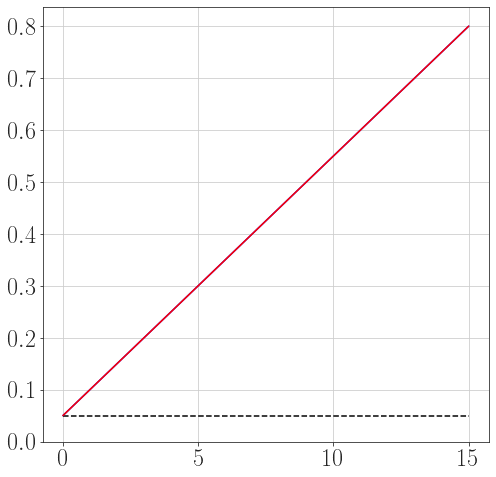

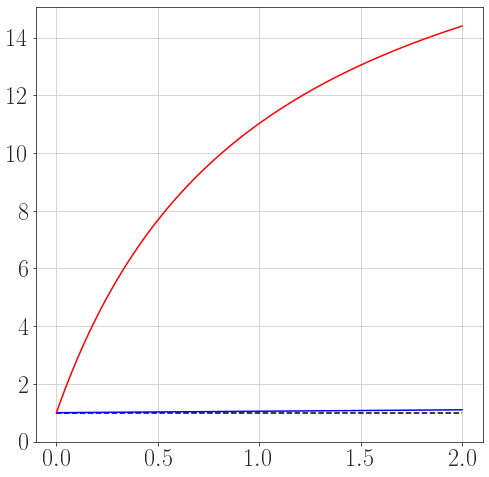

In [65]:
#tokens
fig,ax=pl.subplots()
RR=0.05
timevec=np.linspace(0,T,100)
tmin=4

opp_context=RR*np.ones(np.size(timevec))
opp_wait=RR*timevec
opp_wait_correction=RR*(1-1/(1+RR*(timevec-tmin)*(timevec>tmin)))
opp_trial=RR*(1-1/(1+RR*(timevec-tmin)*(timevec>tmin)))

k_context=1
k_wait=1
k_trial=1
ax.plot(timevec,opp_context,'k--')
ax.plot(timevec,k_wait*opp_wait+k_context*opp_context,'b-')
ax.plot(timevec,k_wait*(opp_wait-opp_wait_correction)+k_context*opp_context+k_trial*opp_trial,'r-')
# ax.plot(timevec,opp_wait_correction,'r-')
ax.set_ylim([0,ax.get_ylim()[1]])

#random dots
fig,ax=pl.subplots()
RR=1
timevec=np.linspace(0,2,100)
tmin=0

opp_context=RR*np.ones(np.size(timevec))
opp_wait=RR*timevec
opp_wait_correction=RR*(1-1/(1+RR*(timevec-tmin)*(timevec>tmin)))
opp_trial=RR*(1-1/(1+RR*(timevec-tmin)*(timevec>tmin)))

k_context=1
k_wait=1/20
k_trial=20
ax.plot(timevec,opp_context,'k--')
ax.plot(timevec,k_wait*opp_wait+k_context*opp_context,'b-')
ax.plot(timevec,k_wait*(opp_wait-opp_wait_correction)+k_context*opp_context+k_trial*opp_trial,'r-')
# ax.plot(timevec,opp_wait_correction,'r-')
ax.set_ylim([0,ax.get_ylim()[1]])

Text(0.5, 1.0, '$(k_{trial}-k_{trial/wait})\\bar{r}_{|t}$')

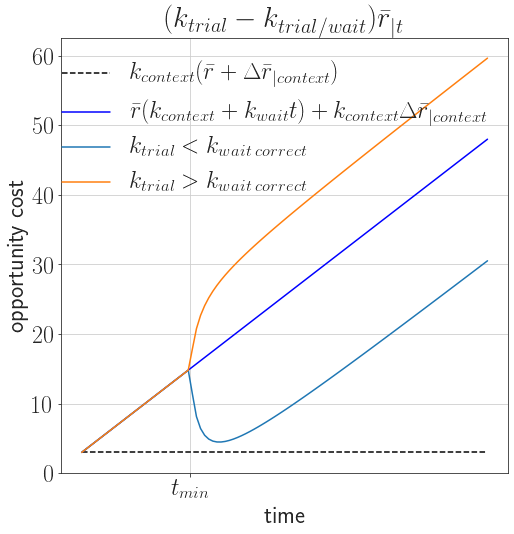

In [91]:
#tokens
fig,ax=pl.subplots()
RR=3
timevec=np.linspace(0,T,100)
tmin=4

opp_context=RR*np.ones(np.size(timevec))
opp_wait=RR*timevec
opp_wait_correction=RR*(1-1/(1+RR*(timevec-tmin)*(timevec>tmin)))
opp_trial=RR*(1-1/(1+RR*(timevec-tmin)*(timevec>tmin)))
post_RR=1/(1+RR*(timevec-tmin)*(timevec>tmin))
k_context=1
k_wait=1
ax.plot(timevec,opp_context,'k--',label=r'$k_{context}(\bar{r}+\Delta\bar{r}_{|context})$')
ax.plot(timevec,k_wait*opp_wait+k_context*opp_context,'b-',label=r'$\bar{r}(k_{context}+k_{wait}t) + k_{context}\Delta\bar{r}_{|context}$')
labelvec=(r'$k_{trial}<k_{wait\;correct}$',r'$k_{trial}>k_{wait\;correct}$')
for kit,k_trial in enumerate([-5,5]):
    ax.plot(timevec,k_wait*(opp_wait-opp_wait_correction)+k_context*opp_context+k_trial*opp_trial,'-',label=labelvec[kit])
# ax.plot(timevec,opp_wait_correction,'r-')
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xticks([tmin])
ax.set_xticklabels([r'$t_{min}$'])
ax.legend(frameon=False)
ax.set_ylabel('opportunity cost')
ax.set_xlabel('time')
ax.set_title(r'$(k_{trial}-k_{trial/wait})\bar{r}_{|t}$')

In [78]:
xlabs[0]

Text(0, 0, '')

In [ ]:
time_vec=np.linspace(0,15,1000)
# t_bmin_test=4.3
t_bmin_test=7
r_test=0.4
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))

fig,ax=pl.subplots(2,1,figsize=(4,4))
time_vec=np.linspace(0,15,1000)
# t_bmin_test=4.3
t_bmin_test=4
r_test=0.4
surv_func_theory=np.zeros(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
ax[0].plot(time_vec,surv_func_theory,'k-')
# ax[0].stem([t_bmin_test],[1],'k-')
ax[0].set_clip_on('False')
# ax[0].plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
# ax[0].plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
# ax[0].set_xlabel(r'$t$',labelpad=20)
ax[0].set_ylabel(r'$\rho(t_\textrm{dec}|r)$')
# ax[0].set_title(r'$.$')
# ax[0].text(3,-0.7,r'$t_{min}$')
ax[0].set_xticks([0,5,10,15])
ax[0].set_xticklabels(['',r'$t_{min}$','',''])
ax[0].set_yticks([0])
ax[0].set_xlim([0,T])
ax[0].set_ylim([0,1])
ax[0].grid(None)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))

ax[1].plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
ax[1].plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
# ax[1].plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
ax[1].set_xlabel(r'$t$',labelpad=20)
ax[1].set_ylabel(r'$P(t<t_{dec}|r)$')
ax[1].set_xticks([0,5,10,15])
ax[1].set_xticklabels([])
ax[1].set_yticks([0,1])
ax[1].set_xlim([0,T])
ax[1].set_ylim([0,1])
ax[1].grid(None)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# ax.text(t_bmin_test-0.8,-0.29,r'$t_{\text{dec$')
fig.tight_layout()
fig.savefig('survfunc_high_partial.pdf', transparent=True,dpi=300,bbox_inches='tight')


## Opportunity cost

zero-cost RR=0.035260368810064543
0.75 3 0.041341145833333336 0.04418000051983445 0.04597701149425287
[-0.04418000051983445, -0.04418000051983445, -0.04418000051983445, -0.04418000051983445, -0.021748552551543288, -0.0011382324856981652, 0.01786408441916512, 0.035439515796032994, 0.05174296328279809, 0.06690769018799583, 0.08104897233708303, 0.09426703387679242, 0.10664942625930493, 0.11827296984181229, 0.12920534912932036, 0.13950643166271637]
oppor-cost RR=0.04663338618333672


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


zero-cost RR=0.04872802734375
0.25 1 0.050394694010416664 0.050394694010416664 0.050394694010416664
[-0.050394694010416664, -0.050394694010416664, -0.02138131229150623, 0.004975574897490891, 0.02902484285219003, 0.05105683899098023, 0.07131516223587622, 0.09000570759850873, 0.10730368912954777, 0.12335914948402998, 0.13830132338605092, 0.1522421238199484, 0.16527895004803794, 0.1774969665350915, 0.188970965546737, 0.19976689953269142]
oppor-cost RR=0.058865741460311344


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


zero-cost RR=0.035260368810064543
0.75 3 0.041341145833333336 0.04418000051983445 0.04597701149425287
[-0.04418000051983445, -0.04418000051983445, -0.04418000051983445, -0.04418000051983445, -0.021748552551543288, -0.0011382324856981652, 0.01786408441916512, 0.035439515796032994, 0.05174296328279809, 0.06690769018799583, 0.08104897233708303, 0.09426703387679242, 0.10664942625930493, 0.11827296984181229, 0.12920534912932036, 0.13950643166271637]
oppor-cost RR=0.04663338618333672


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


zero-cost RR=0.04872802734375
0.25 1 0.050394694010416664 0.050394694010416664 0.050394694010416664
[-0.050394694010416664, -0.050394694010416664, -0.02138131229150623, 0.004975574897490891, 0.02902484285219003, 0.05105683899098023, 0.07131516223587622, 0.09000570759850873, 0.10730368912954777, 0.12335914948402998, 0.13830132338605092, 0.1522421238199484, 0.16527895004803794, 0.1774969665350915, 0.188970965546737, 0.19976689953269142]
oppor-cost RR=0.058865741460311344


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


0.058865741460311344


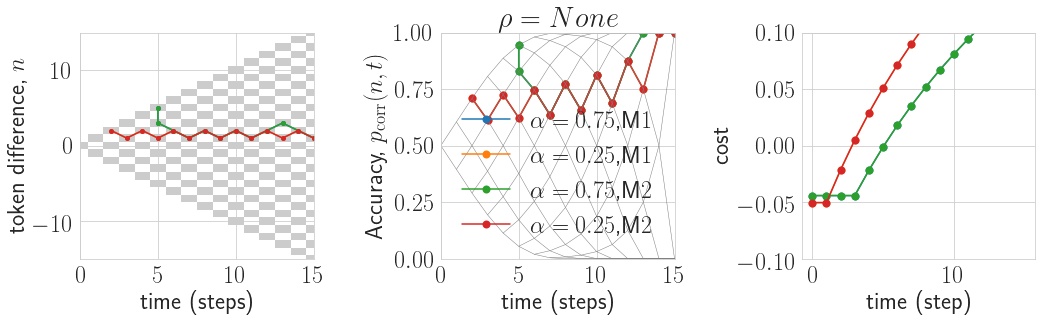

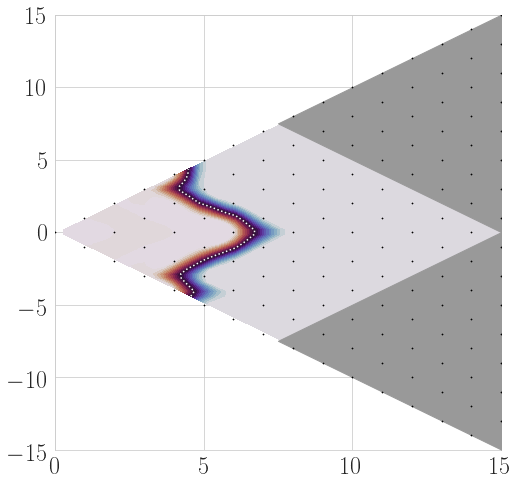

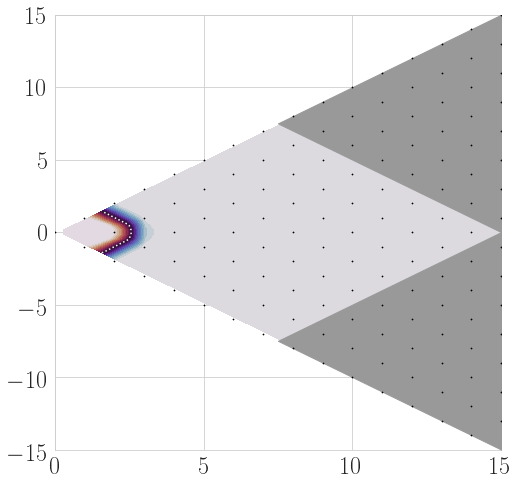

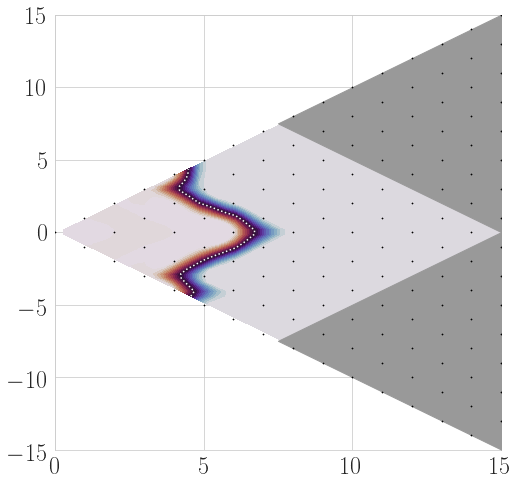

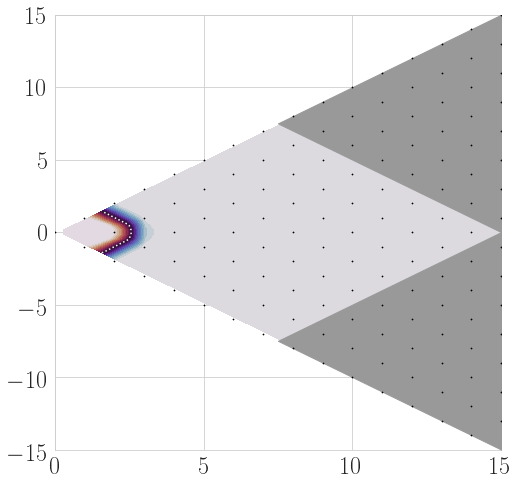

In [68]:
fig,ax=pl.subplots(1,3,figsize=(15,5))
gamvec=[3/4,1/4]
block_times=[150,50]
rhovec=[]
T=15
for i in range(1,3):
    for it,post_interval in enumerate(block_times):
        bound_constr='none'
        knowledge_mode='part'
        data_dict=solve_opporcost_strategy(knowledge_mode,bound_constr,gamvec[it],plot=False,T=para['T'])
        rho=data_dict['rho_opp']
        data_boundary=data_dict['b_opp']
        cost_seq=data_dict['c_seq']
        rhovec.append(rho)
        ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(gamvec[it])+'$,$'+str(i)+'$')
        ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(gamvec[it])+'$,M$'+str(i)+'$')
#                 decision boundary in evidence space
        tb,b_evi=data_boundary[0]
        ax[0].plot(tb,b_evi,'.-')
#         ax[0].plot(tb,-b_evi,'k.-')
#         print(cost_seq)
        tb,b_bel=data_boundary[1]
        b_beltmp=[]
        for t in range(T+1):
            teff=t-(T-len(b_bel))-1
            b_beltmp.append(b_bel[teff] if teff>=0 else 1)
        b_beltmp=np.asarray(b_beltmp)
        dfb=df_traj.copy()
        dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
        dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else T)
        dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)
        fig2,ax2=pl.subplots()
        plot_dec_times(dfb,pl,'oppor_cost_'+str(post_interval),None,ax2)
        
ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')
ax[2].set_ylim(-0.1,0.1)
# ax[1].legend(frameon=False)

T=15
for Nm in 2*np.arange(T):
    ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
    ax[1].plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,T)
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((T+1,2*T+1))
for t in range(T+1):
    state_space[t,slice(T-t,T+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)
    
ax[0].set_ylim(-T,T)
ax[0].set_xlim(0,T)
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# fig.savefig('partial_DP_costs.pdf', transparent=True,dpi=300)

zero-cost RR=0.04563047406790642
0.75 6 0.044444444444444446 0.04566024121765459 0.04841820987654321
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023925832264139052, 0.045849577533492, 0.0660124424702799, 0.08461838302511315, 0.10184102813155951, 0.11782911448172725, 0.13271079300955296, 0.14659707122261306, 0.15958458713928103]
oppor-cost RR=0.03738984050702215


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


zero-cost RR=0.05201892311014271
0.25 2 0.044444444444444446 0.05284615644079287 0.05564491421568627
[0.0, 0.0, 0.0, 0.03183047665773722, 0.060618301522669754, 0.08677984174244557, 0.11065880908192688, 0.13254144527454753, 0.15266805160795277, 0.17124184991770625, 0.18843586882876373, 0.2043983502967807, 0.2192570345709584, 0.23312258595480156, 0.2460913538621905, 0.2582476149243214]
oppor-cost RR=0.050394694010463266


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


zero-cost RR=0.04563047406790642
0.75 6 0.044444444444444446 0.04566024121765459 0.04841820987654321
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023925832264139052, 0.045849577533492, 0.0660124424702799, 0.08461838302511315, 0.10184102813155951, 0.11782911448172725, 0.13271079300955296, 0.14659707122261306, 0.15958458713928103]
oppor-cost RR=0.03738984050702215


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


zero-cost RR=0.05201892311014271
0.25 2 0.044444444444444446 0.05284615644079287 0.05564491421568627
[0.0, 0.0, 0.0, 0.03183047665773722, 0.060618301522669754, 0.08677984174244557, 0.11065880908192688, 0.13254144527454753, 0.15266805160795277, 0.17124184991770625, 0.18843586882876373, 0.2043983502967807, 0.2192570345709584, 0.23312258595480156, 0.2460913538621905, 0.2582476149243214]
oppor-cost RR=0.050394694010463266


C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in less


0.050394694010463266


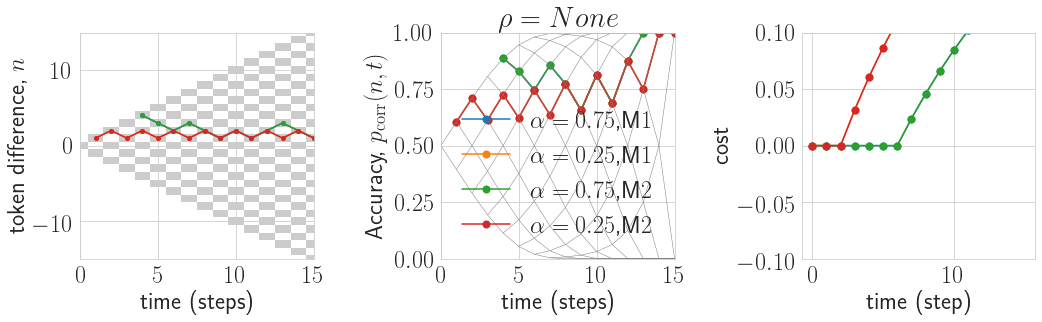

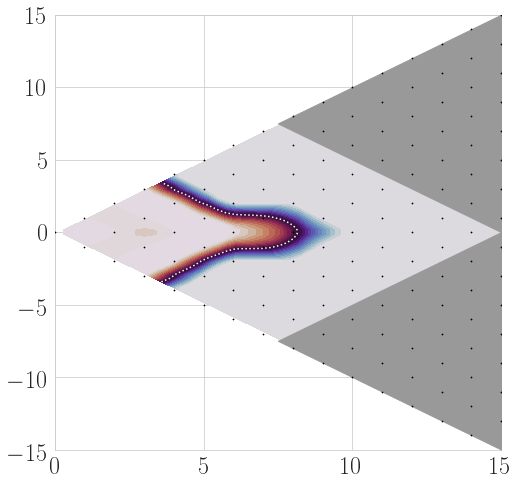

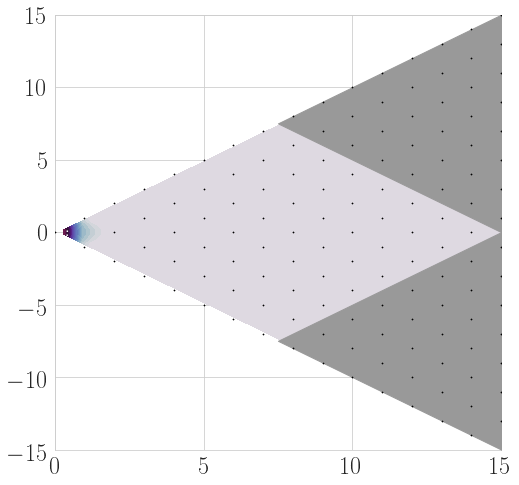

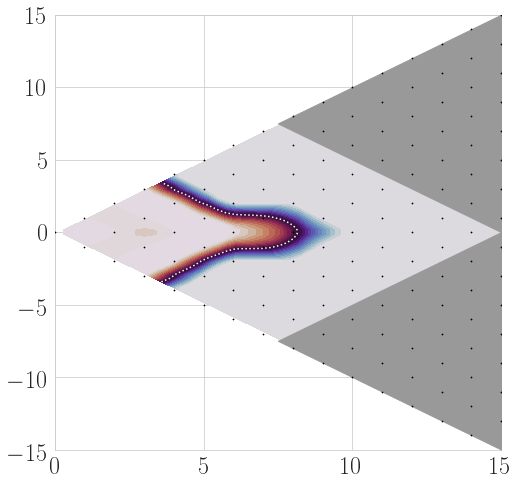

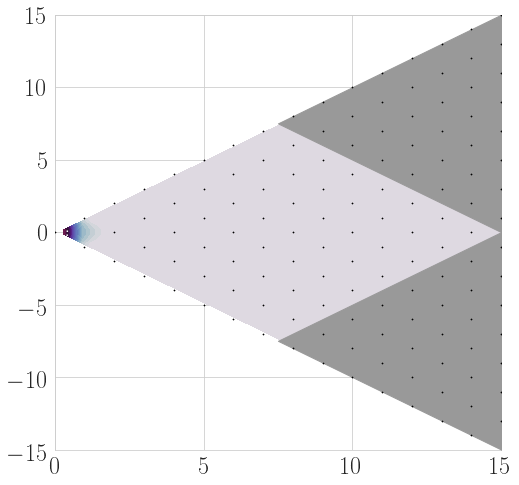

In [74]:
fig,ax=pl.subplots(1,3,figsize=(15,5))
gamvec=[3/4,1/4]
block_times=[150,50]
rhovec=[]
T=15
for i in range(1,3):
    for it,post_interval in enumerate(block_times):
        bound_constr='none'
        knowledge_mode='part'
        data_dict=solve_opporcost_strategy(knowledge_mode,bound_constr,gamvec[it],plot=False,T=para['T'])
        rho=data_dict['rho_opp']
        data_boundary=data_dict['b_opp']
        cost_seq=data_dict['c_seq']
        rhovec.append(rho)
        ax[2].plot(cost_seq,'o-',label=r'$\alpha='+str(gamvec[it])+'$,$'+str(i)+'$')
        ax[1].plot(*data_boundary[1],'o-',label=r'$\alpha='+str(gamvec[it])+'$,M$'+str(i)+'$')
#                 decision boundary in evidence space
        tb,b_evi=data_boundary[0]
        ax[0].plot(tb,b_evi,'.-')
#         ax[0].plot(tb,-b_evi,'k.-')
#         print(cost_seq)
        tb,b_bel=data_boundary[1]
        b_beltmp=[]
        for t in range(T+1):
            teff=t-(T-len(b_bel))-1
            b_beltmp.append(b_bel[teff] if teff>=0 else 1)
        b_beltmp=np.asarray(b_beltmp)
        dfb=df_traj.copy()
        dfb['nCorrectChoice']=dfb.Nt.apply(lambda x: np.sign(x[-1]))
        dfb['tDecision']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0][0] if np.where(np.logical_or(x>=b_beltmp,x<=1-b_beltmp))[0].size else T)
        dfb['nChoiceMade']=dfb.apply(lambda row: row.Nt[row.tDecision]>0,axis=1)
        fig2,ax2=pl.subplots()
        plot_dec_times(dfb,pl,'oppor_cost_'+str(post_interval),None,ax2)
        
ax[2].set_ylabel('cost')
ax[2].set_xlabel('time (step)')
ax[2].set_ylim(-0.1,0.1)
# ax[1].legend(frameon=False)

T=15
for Nm in 2*np.arange(T):
    ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
    ax[1].plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'-',ms=5,lw=0.5,color=[0.5]*3,mew=0.5,mfc='k',mec='k')
ax[1].set_ylim(0,1)
ax[1].set_xlim(0,T)
ax[1].set_ylabel(r'Accuracy, $p_{\textrm{corr}}(n,t)$')
ax[1].set_xlabel(r'time (steps)')
ax[1].set_title(r'$\rho='+str(print(rho))+'$')
ax[1].legend(frameon=False)

state_space=-np.inf*np.ones((T+1,2*T+1))
for t in range(T+1):
    state_space[t,slice(T-t,T+1+t,2)]=0.8
ax[0].imshow(state_space.T,origin='lower',cmap='gray',extent=[-0.5,15.5,-15.5,15.5],vmin=0,vmax=1,aspect='auto',)#'none', 'nearest', 'bilinear', 'bicubic',


ax[0].set_xlim(0,15)
    
ax[0].set_ylim(-T,T)
ax[0].set_xlim(0,T)
ax[0].set_ylabel(r'token difference, $n$')
ax[0].set_xlabel(r'time (steps)')
fig.tight_layout()
# fig.savefig('partial_DP_costs.pdf', transparent=True,dpi=300)

In [77]:
data_bel_boundary=np.load(file_path)
tb,b=data_bel_boundary
b.append(1)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [66]:
data_bel_boundary=np.load('data_bel_boundary.npy')

In [63]:
tb,b_bel=data_bel_boundary

In [65]:
tb

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

In [55]:
file_path='primate_p_success_'+'monkey_pcorr_'+str(1)+'_post_'+str(150)+'.npy'
P_plus_est=np.load(file_path)
file_path='primate_p_success_'+'monkey_pcorr_'+str(1)+'_post_'+str(150)+'_num.npy'
num_dec=np.load(file_path)
P_plus_est[num_dec<21]=1.0#-np.Inf
P_plus_est[8:,]=1.
P_plus_est[:,8:]=1.

num_dec[num_dec==0]=-np.Inf
for row in P_plus_est:
    print(' '.join('%1.2f' % i for i in row))
print('\n')
for row in num_dec:
    print(' '.join('%4.0f' % i for i in row))

1.00 0.73 0.78 0.85 0.92 0.97 0.95 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
0.69 0.62 0.74 0.81 0.89 0.93 0.96 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
0.79 0.75 0.62 0.72 0.83 0.89 0.95 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
0.87 0.83 0.75 0.66 0.75 0.83 0.92 0.92 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
0.91 0.89 0.84 0.75 0.66 0.71 0.80 0.90 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
0.93 0.94 0.90 0.82 0.72 0.67 0.69 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
1.00 0.95 0.94 0.90 0.79 0.69 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
1.00 1.00 1.00 0.94 0.90 1.00 1.00 0.45 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 

Look at DP curve

In [169]:
rho_data=np.zeros((10,20))
gam_vec=np.linspace(0,1,20)
for cit,cost in enumerate(np.linspace(0,0.1,10)):
    for git,gamma in enumerate(gam_vec):
        cost_rate_seq=cost*np.ones((para['T']+1))
        rho,boundary,_=get_DP_boundary(cost_rate_seq,gamma,T=para['T'])
        rho_data[cit,git]=deepcopy(rho)

In [159]:
boundary

((array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
  array([4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 1])),
 (array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
  array([0.88671875, 0.9453125 , 0.91015625, 0.96484375, 0.9375    ,
         0.984375  , 0.96875   , 1.        , 1.        , 1.        ,
         1.        , 1.        ])))

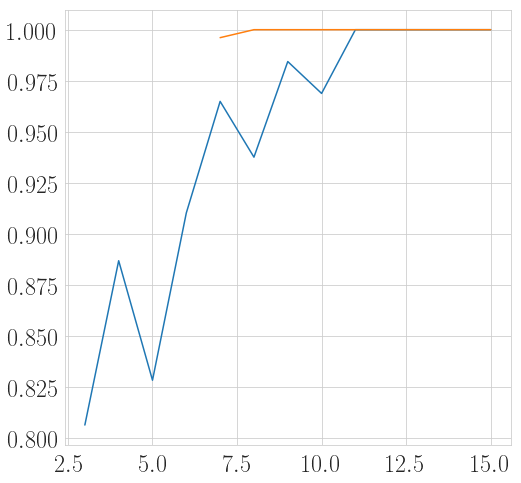

In [166]:
fig,ax=pl.subplots()
rho,boundary,_=get_DP_boundary(cost_rate_seq,1/4,T=para['T'])
ax.plot(*boundary[1])
rho,boundary,_=get_DP_boundary(cost_rate_seq,3/4,T=para['T'])
ax.plot(*boundary[1])

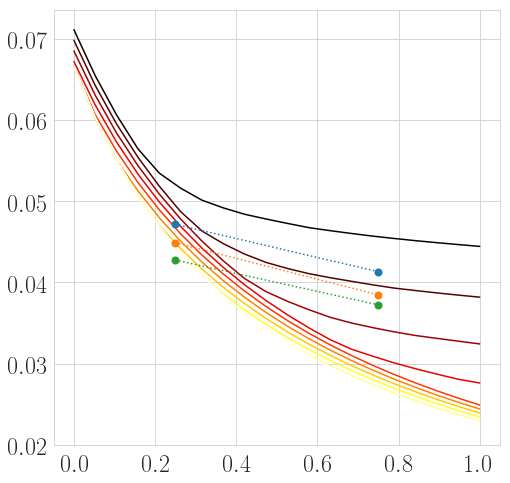

In [179]:
fig,ax=pl.subplots()
for cit,col_value in enumerate(np.linspace(0,1,10)):
    ax.plot(gam_vec,rho_data[cit,:],color=pl.cm.hot(col_value))
#data
rr_M1_fast=0.04489874703443582
rr_M1_slow=0.038475184652453864
rr_M2_fast=0.0427570104760277
rr_M2_slow=0.03724601256317603
rr_H1_fast=0.04716158428767893
rr_H1_slow=0.04132889498676728
ax.plot([1/4,3/4],[rr_H1_fast,rr_H1_slow],'o:',label='Human 1')
ax.plot([1/4,3/4],[rr_M1_fast,rr_M1_slow],'o:',label='Primate 1')
ax.plot([1/4,3/4],[rr_M2_fast,rr_M2_slow],'o:',label='Primate 2')

old curve:

In [105]:
fig,ax=pl.subplots()
tmin=4
np.asarray([-0.07*(1 if t<tmin else 1-0.2*t) for t in range(16)])
ax.plot(range(16),np.asarray([-0.07*(1 if t<tmin else 1-0.2*t) for t in range(16)]))

In [113]:
def normed_costfn(reward_rate_seq,rr_min,rr_max=None,offset=0):
    if rr_max==None:
        rr_max=np.max(reward_rate_seq)
    return (np.max(reward_rate_seq)-rr_min)/ (reward_rate_seq-reward_rate_min)-1+offset

In [ ]:
solve_strategy(normed_costfn,know_mode,bound_constr,gamma,plot=True)

0.25 part none
zero-cost RR=0.05201892311014271
oppor-cost RR=0.06830282258081492
0.25 part fixed
opt_b=0.6896551724137931
zero-cost RR=0.05186308041152303
oppor-cost RR=0.04985793161446288
0.25 full none
zero-cost RR=0.05201892311014271
oppor-cost RR=0.06830282258081492
0.25 full fixed
opt_b=0.6896551724137931
zero-cost RR=0.05186308041152303
oppor-cost RR=0.04985793161446288
0.75 part none
zero-cost RR=0.04563047406815481


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


oppor-cost RR=0.05153051823417871
0.75 part fixed
opt_b=0.9827586206896551
zero-cost RR=0.0456378827861703
oppor-cost RR=0.04556726761907598
0.75 full none
zero-cost RR=0.04563047406815481
oppor-cost RR=0.05153051823417871
0.75 full fixed


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


opt_b=0.9827586206896551
zero-cost RR=0.0456378827861703
oppor-cost RR=0.04556726761907598


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


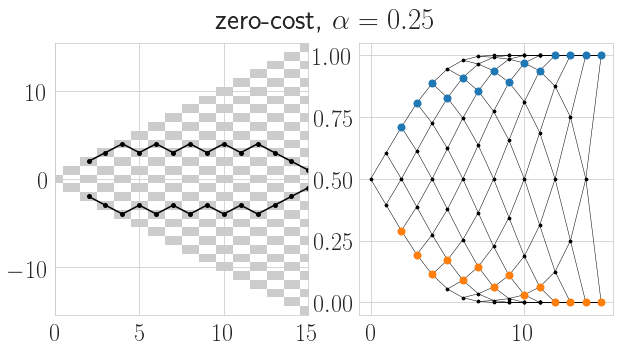

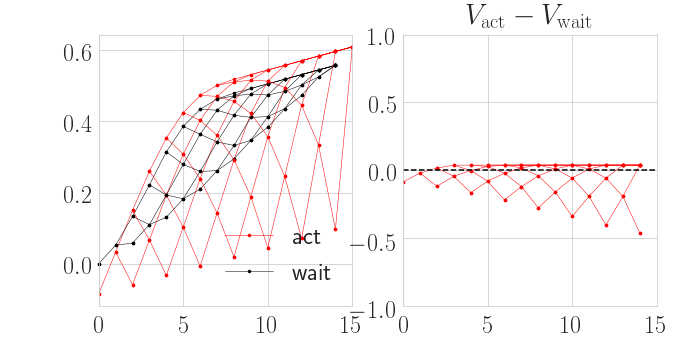

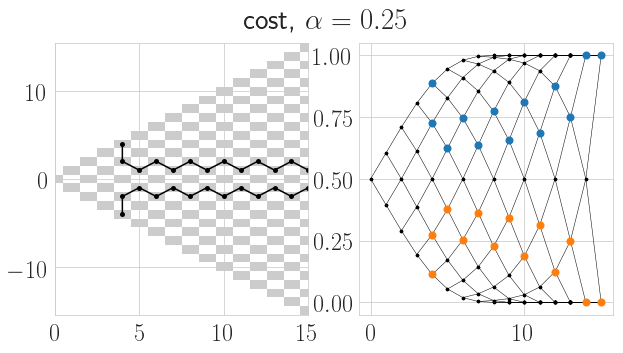

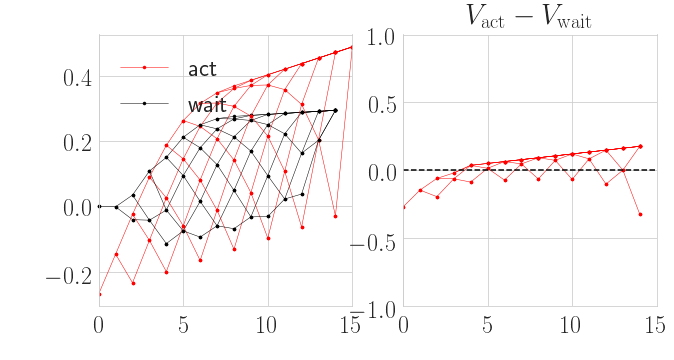

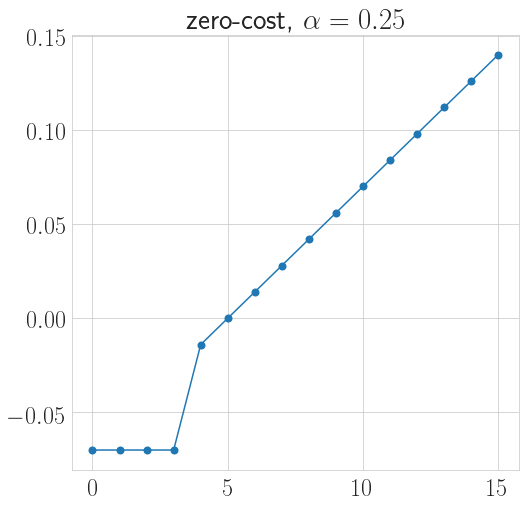

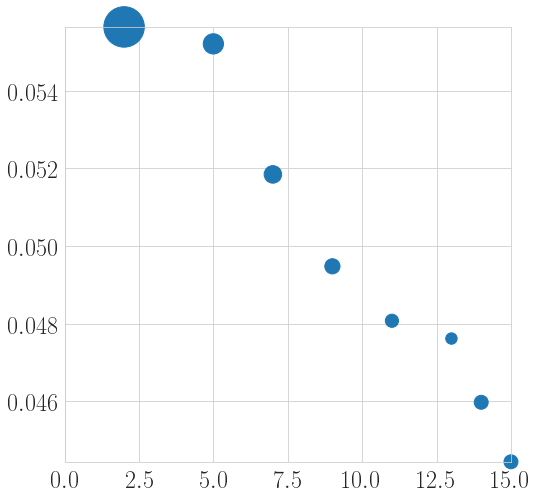

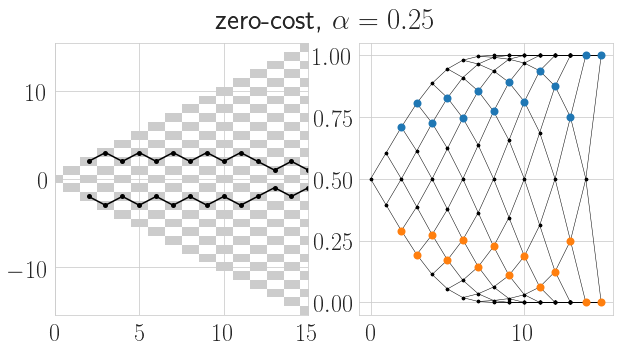

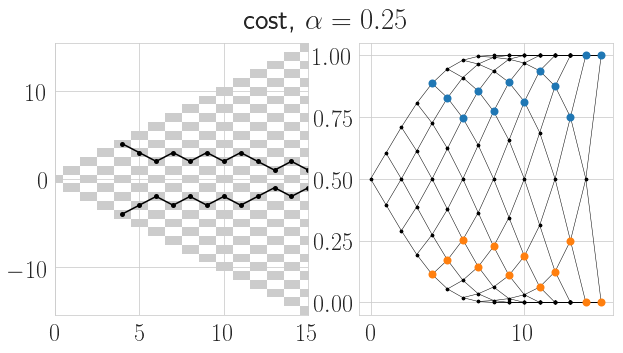

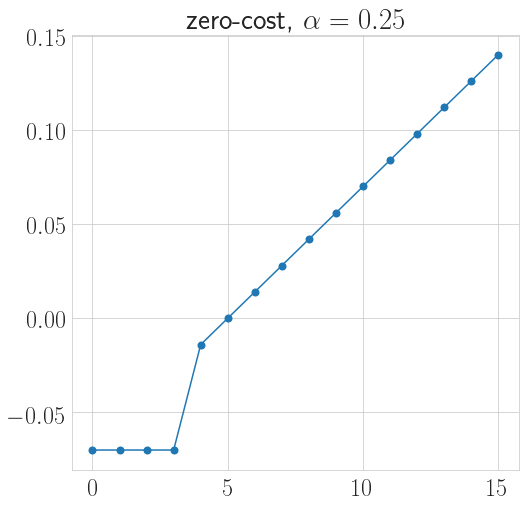

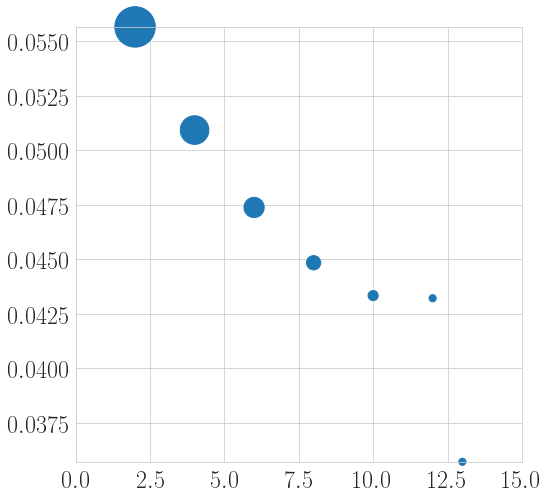

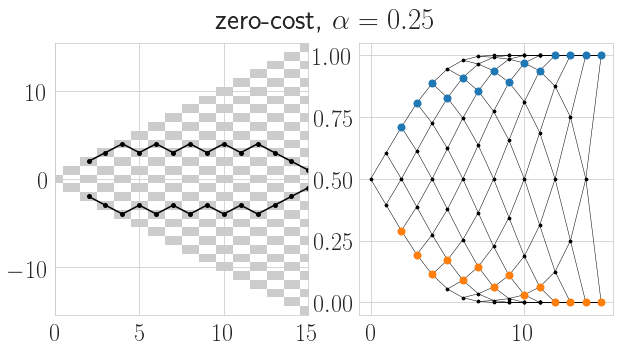

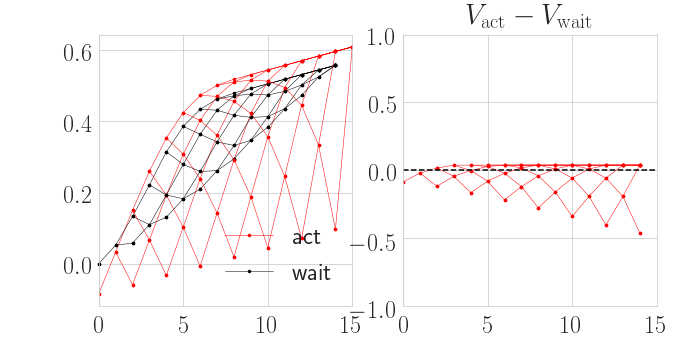

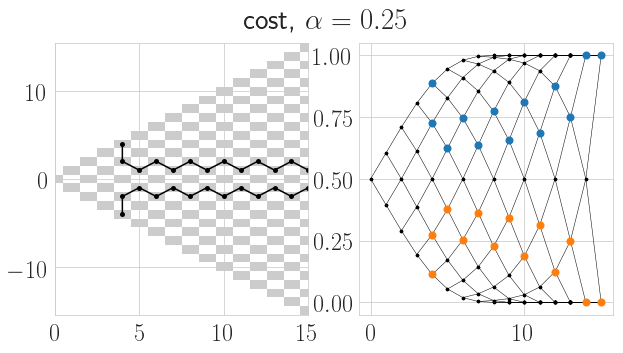

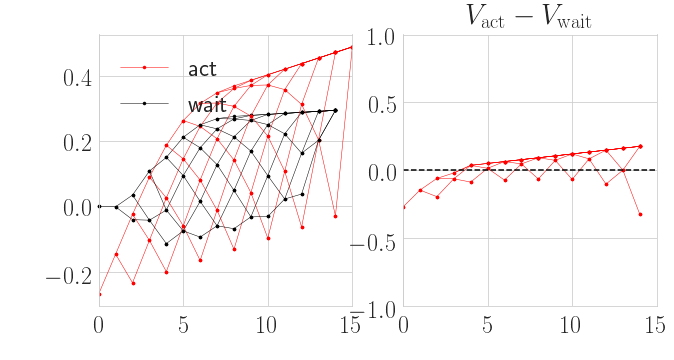

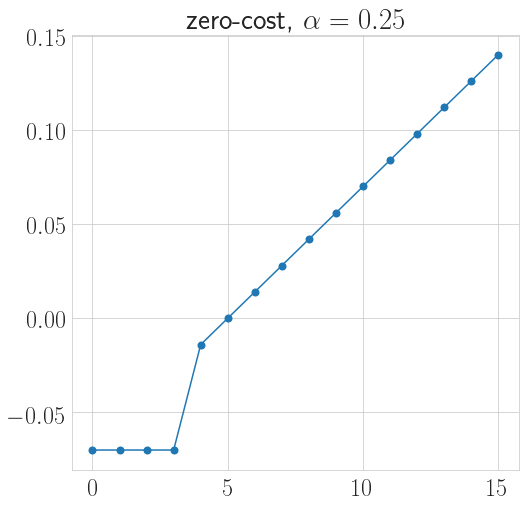

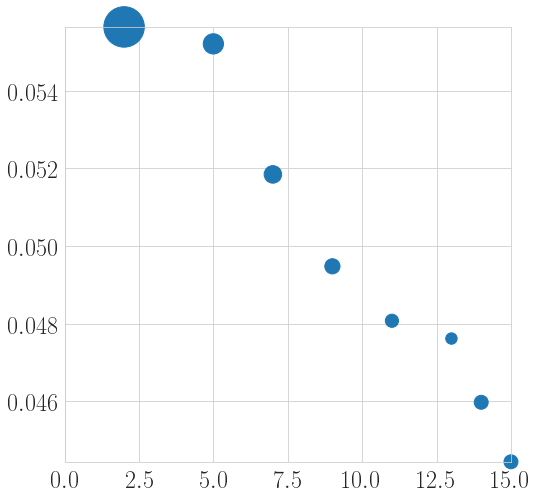

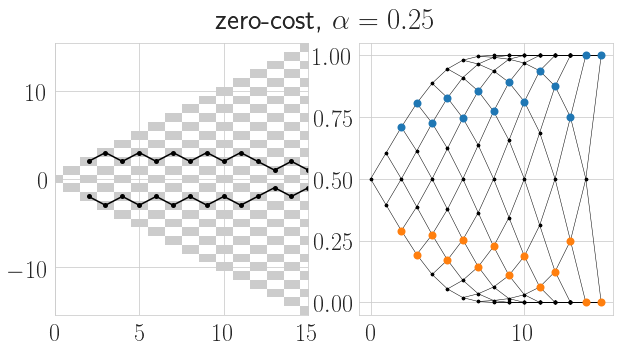

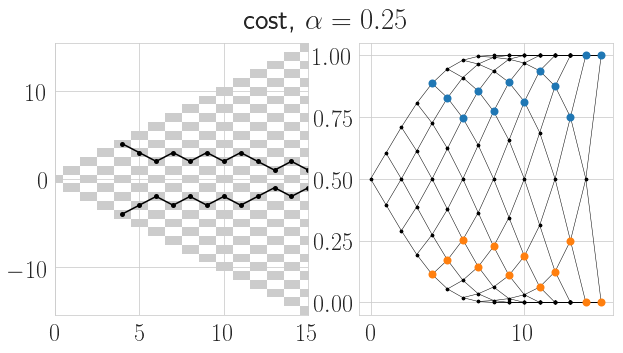

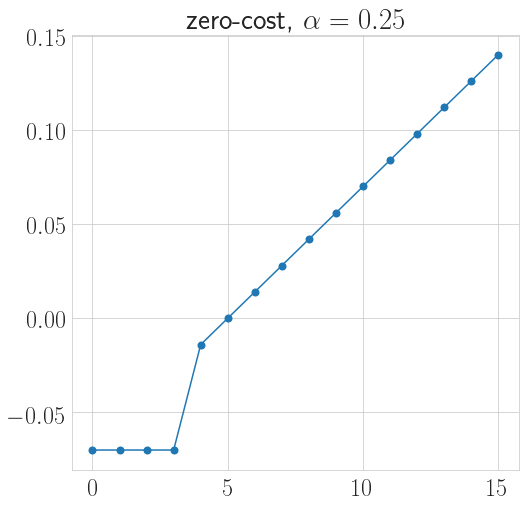

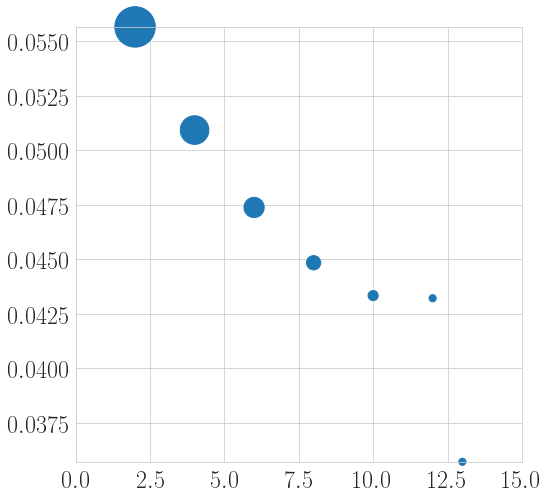

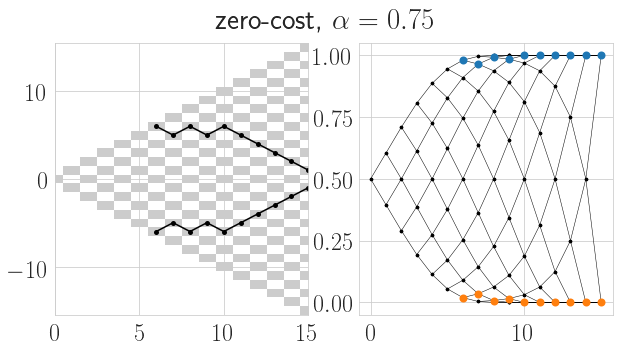

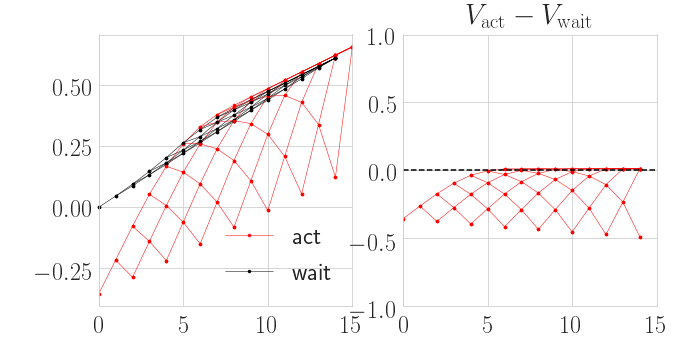

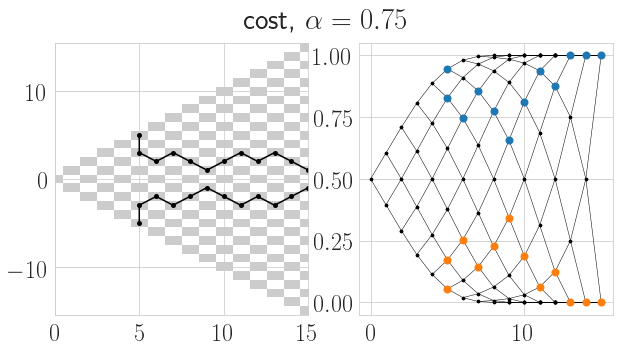

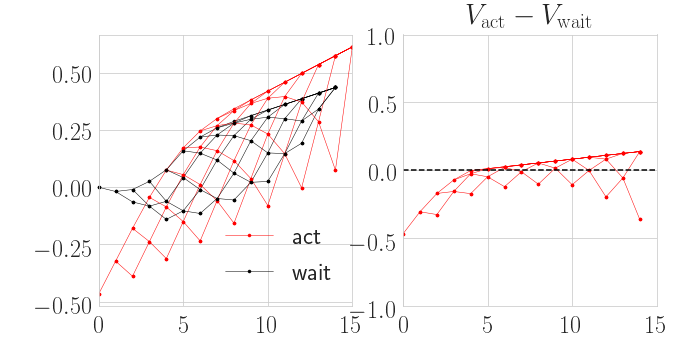

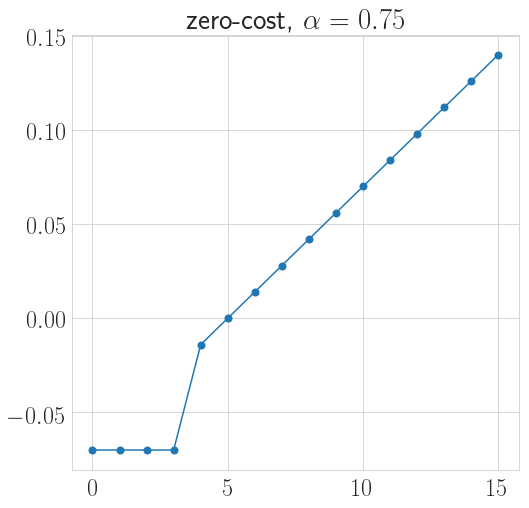

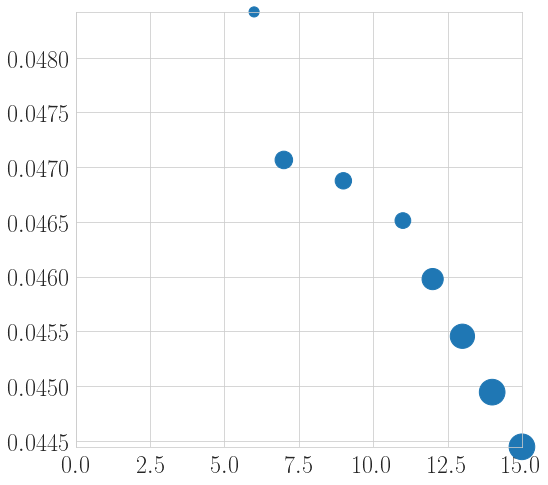

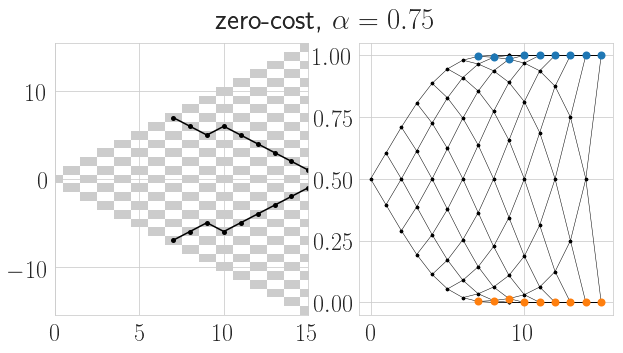

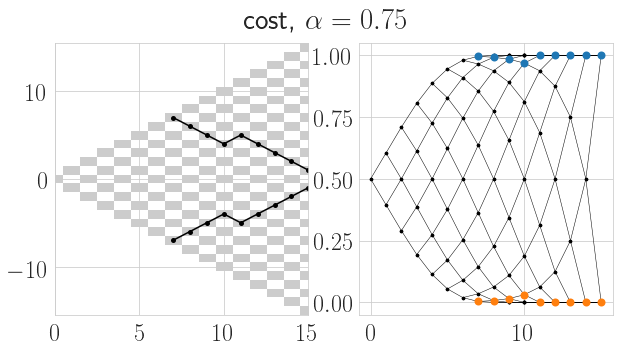

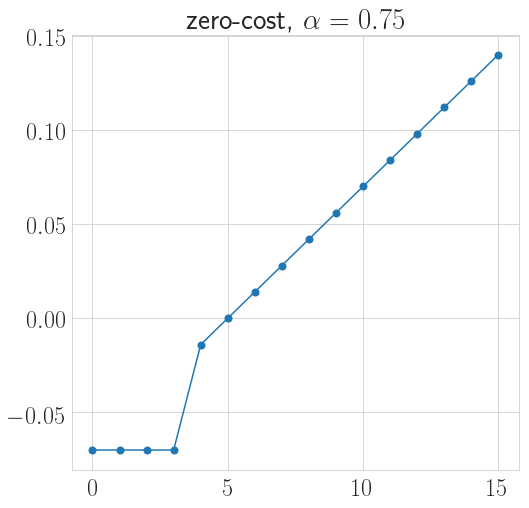

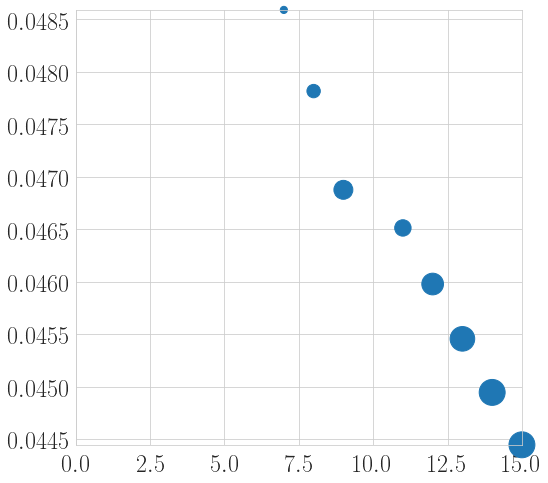

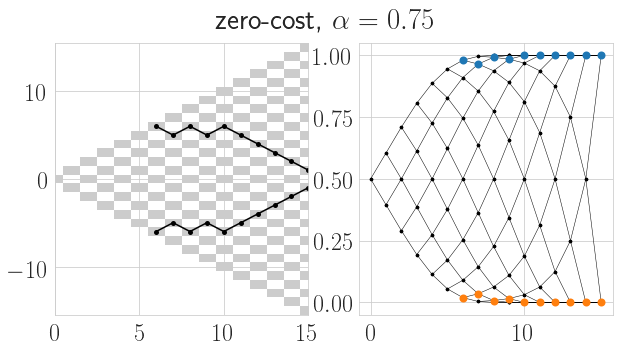

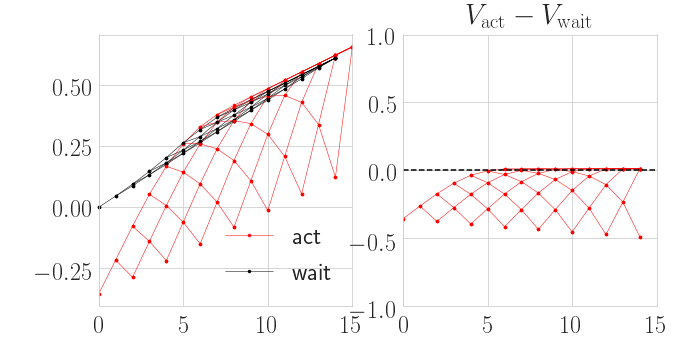

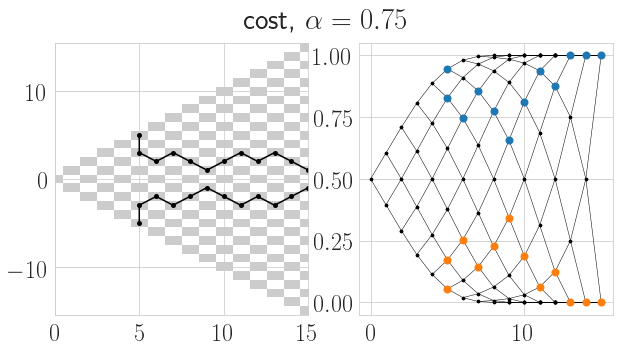

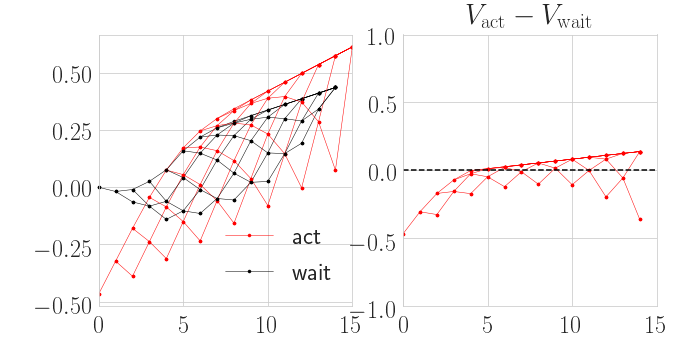

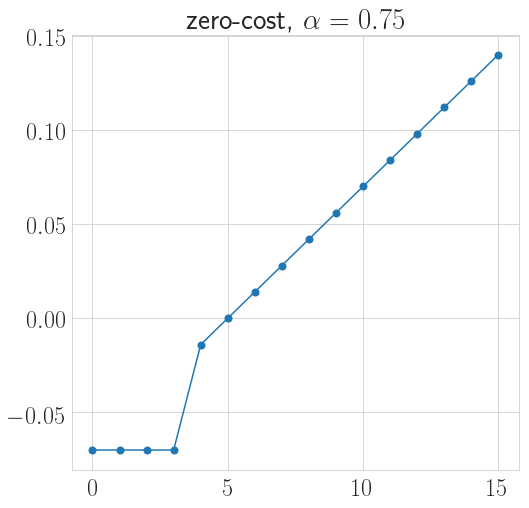

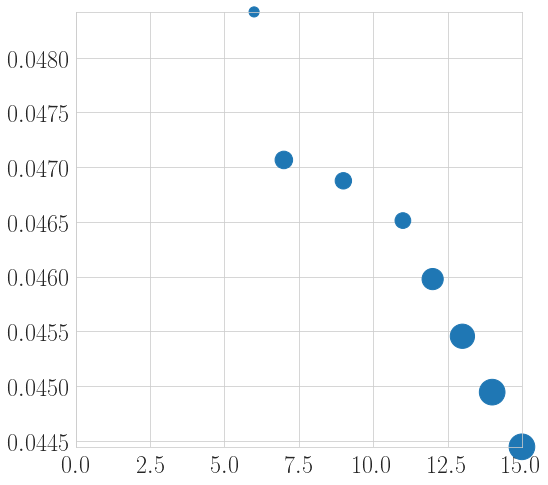

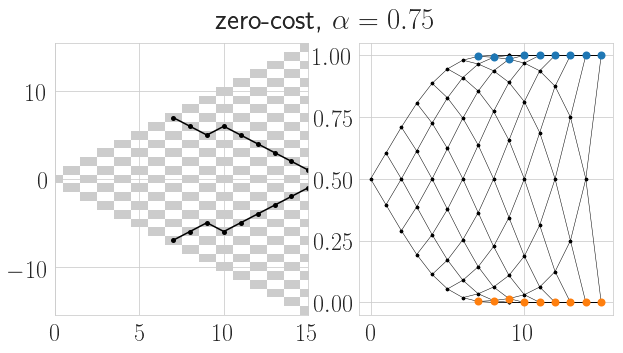

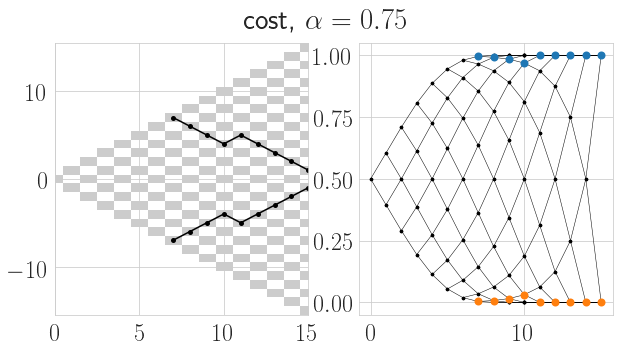

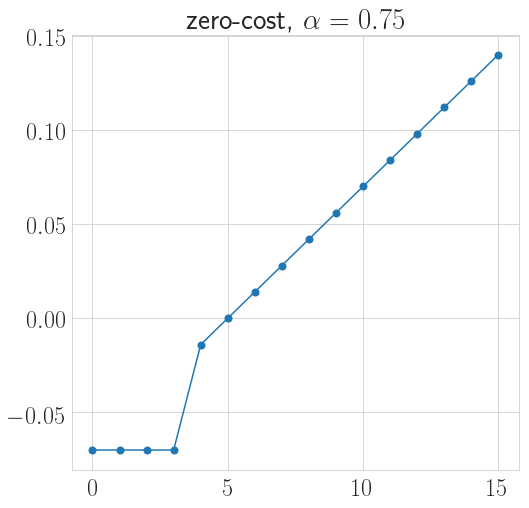

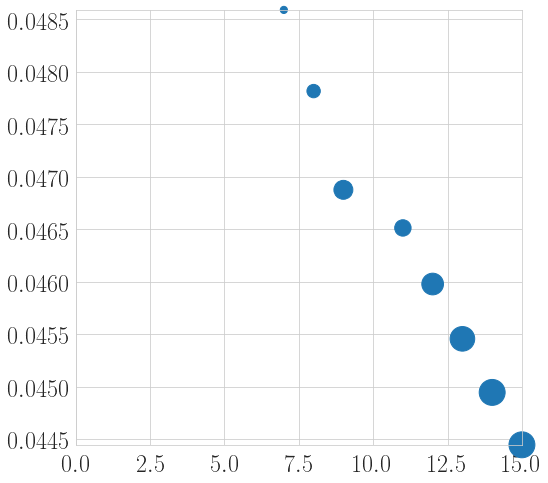

In [112]:
for costfn in (normed_costfn,regret_costfn,normed_offset_costfn,)
data=dict()
for gamma in [1/4,3/4]:
    data[gamma]=dict()
    for know_mode in ['part','full']:
        data[gamma][know_mode]=dict()
        for bound_constr in ['none','fixed']:
            print(str(gamma)+' '+str(know_mode)+' '+str(bound_constr))
            data[gamma][know_mode][bound_constr]=solve_strategy(normed_costfn,know_mode,bound_constr,gamma,plot=True)

In [108]:
from copy import deepcopy
data_m=deepcopy(data)

0.25 part none
zero-cost RR=0.05201892311014271
oppor-cost RR=0.050394694010483625
0.25 part fixed
opt_b=0.6896551724137931
zero-cost RR=0.05186308041152303
oppor-cost RR=0.05186308041152303
0.25 full none
zero-cost RR=0.05201892311014271


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


oppor-cost RR=0.05039469401041685
0.25 full fixed
opt_b=0.6896551724137931
zero-cost RR=0.05186308041152303


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


oppor-cost RR=0.05186308041152303
0.75 part none
zero-cost RR=0.04563047406815481


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


oppor-cost RR=0.03712684753015752
0.75 part fixed
opt_b=0.9827586206896551
zero-cost RR=0.0456378827861703
oppor-cost RR=0.04517330761259192
0.75 full none
zero-cost RR=0.04563047406815481


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


oppor-cost RR=0.04310672545568452
0.75 full fixed
opt_b=0.9827586206896551
zero-cost RR=0.0456378827861703


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


oppor-cost RR=0.0456378827861703


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


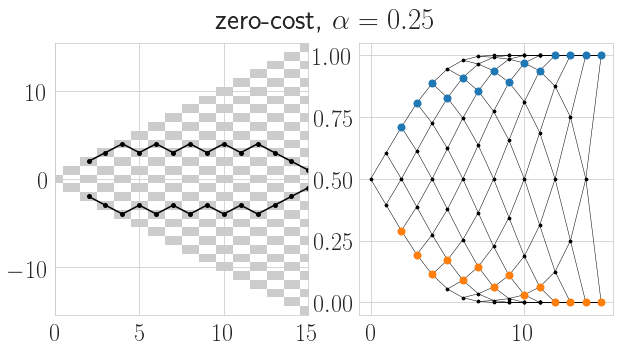

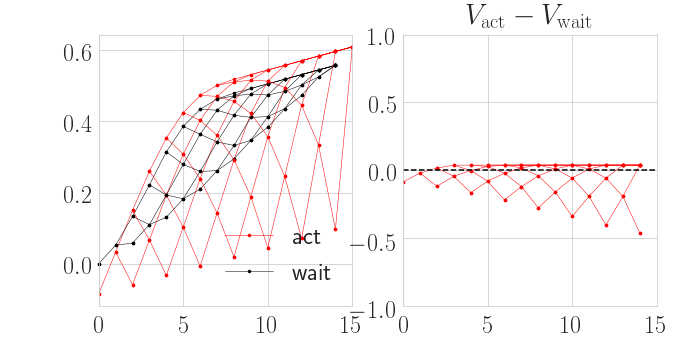

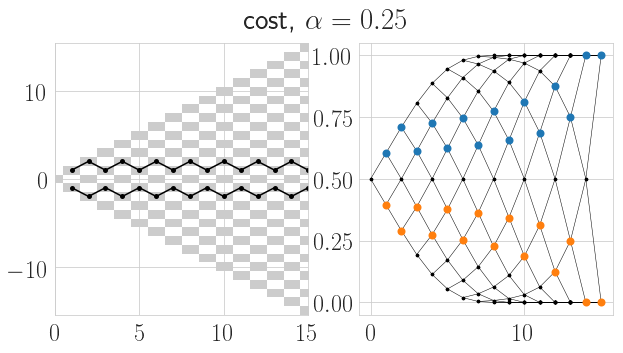

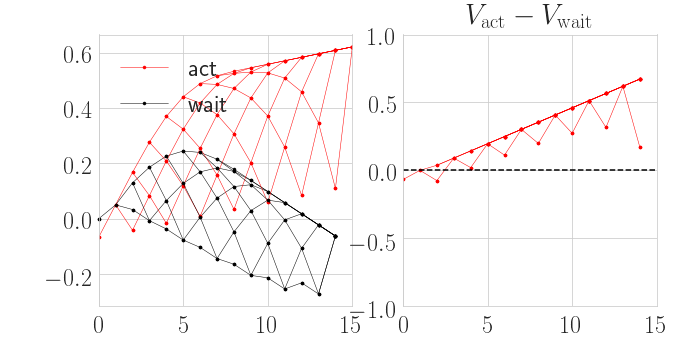

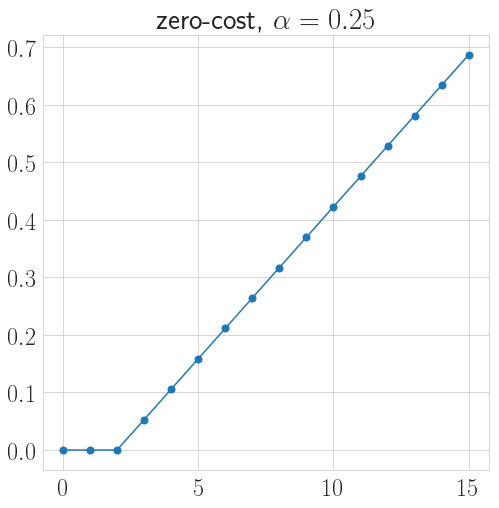

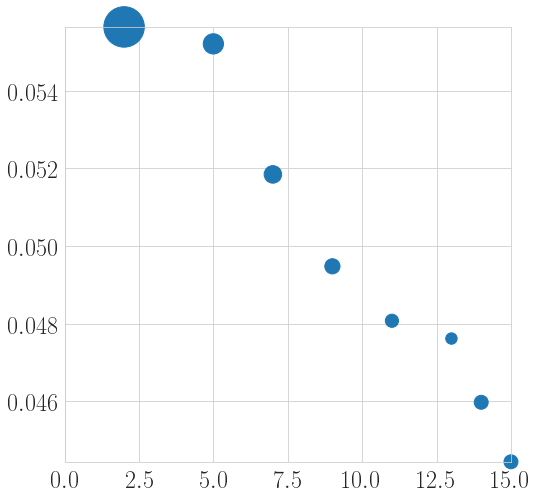

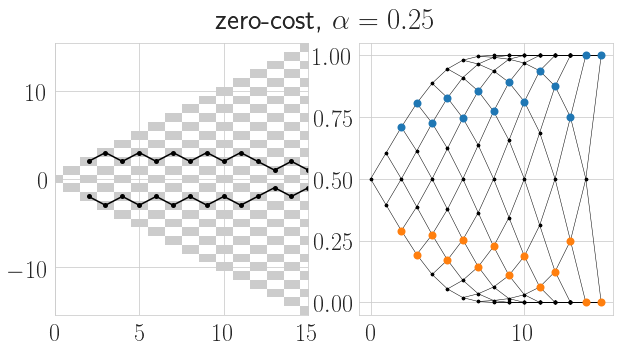

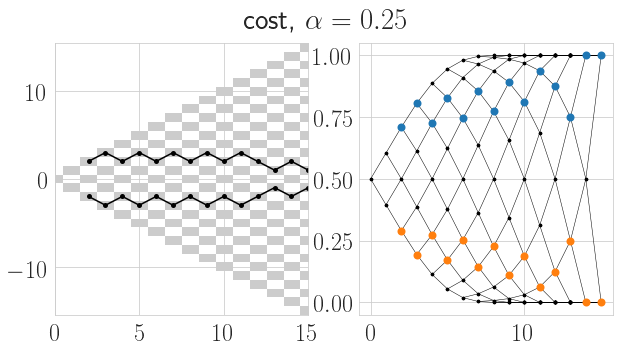

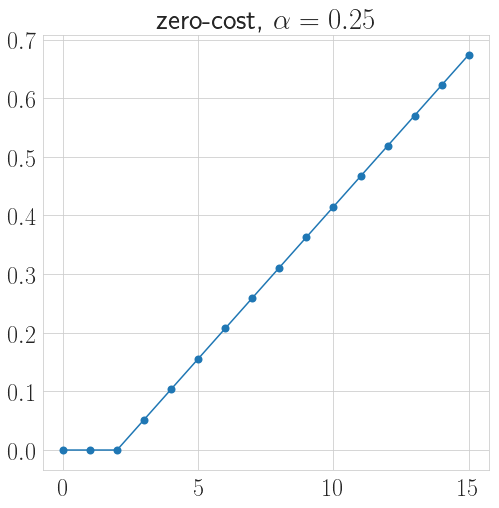

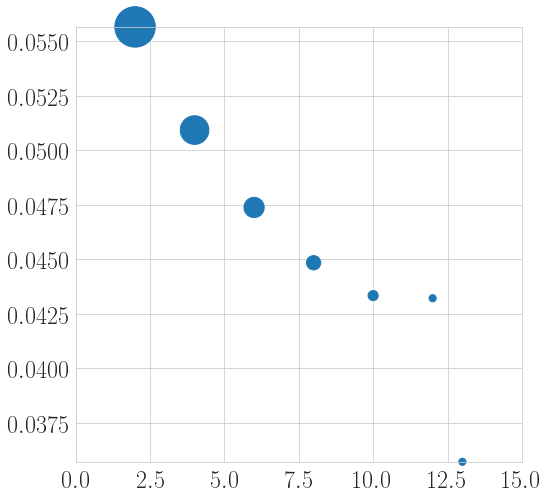

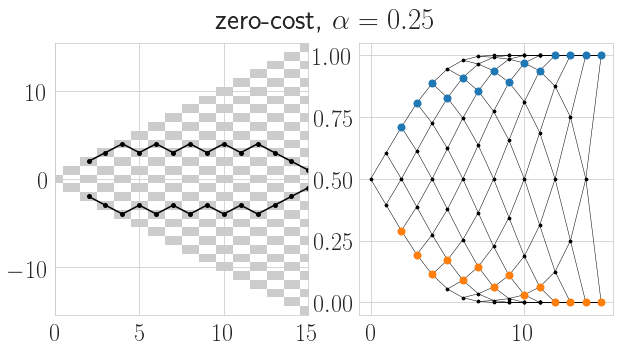

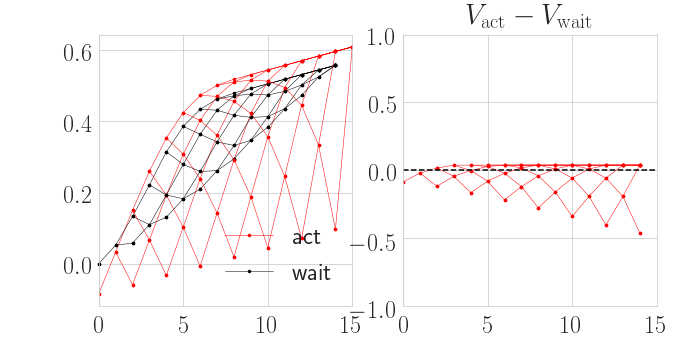

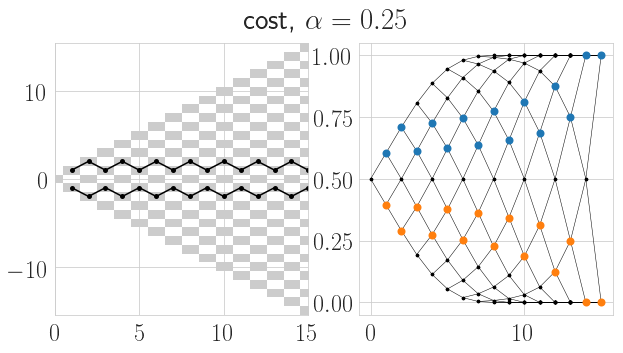

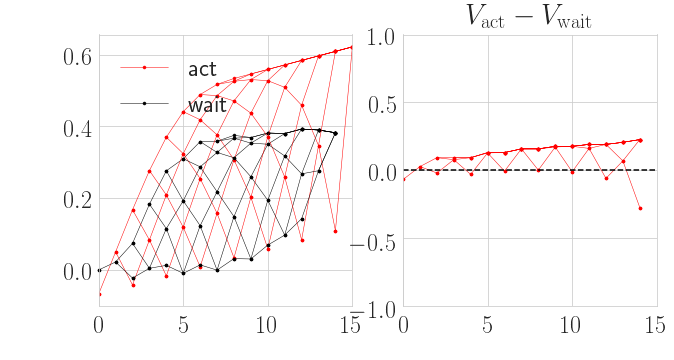

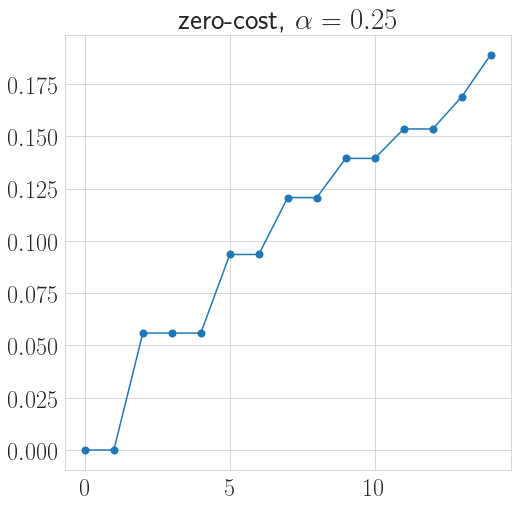

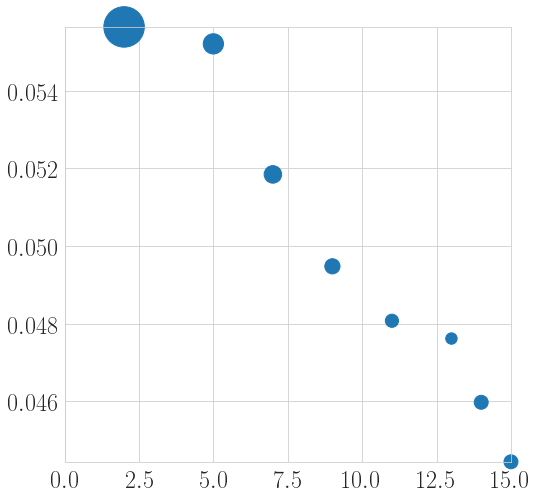

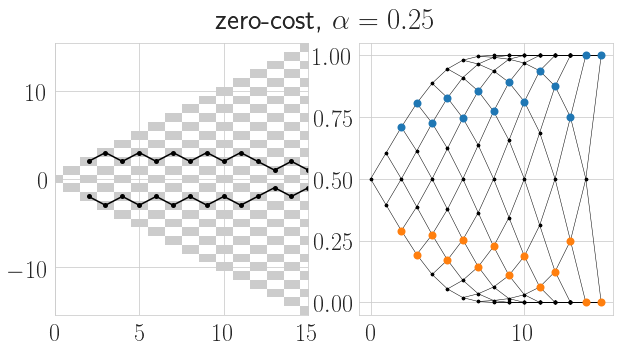

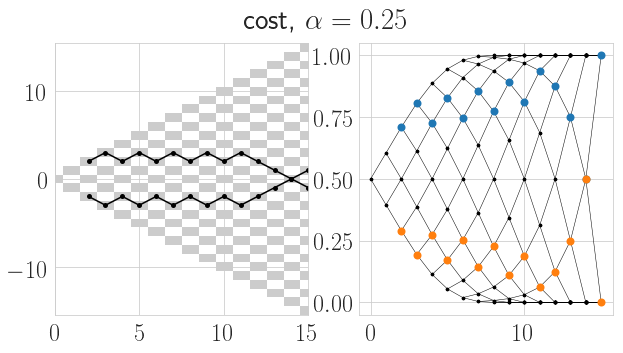

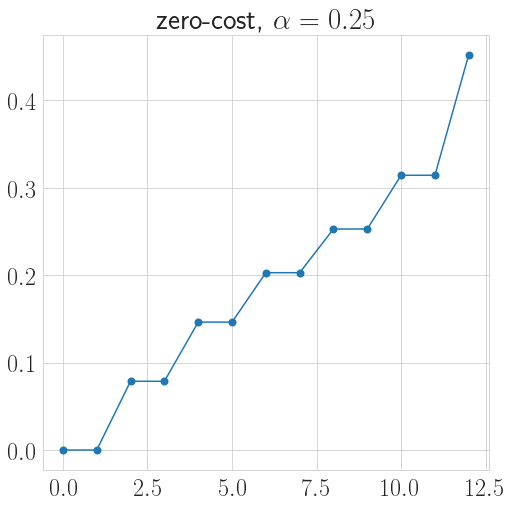

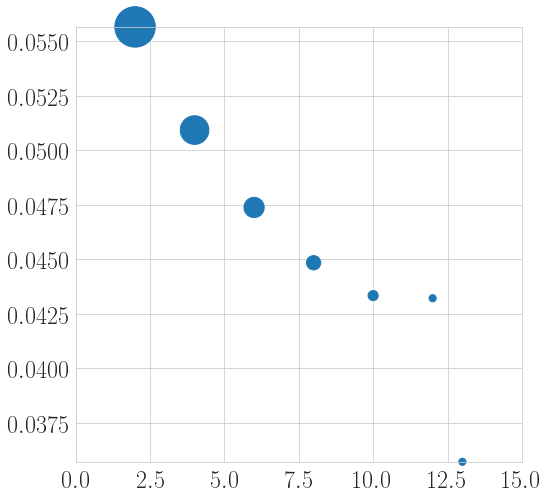

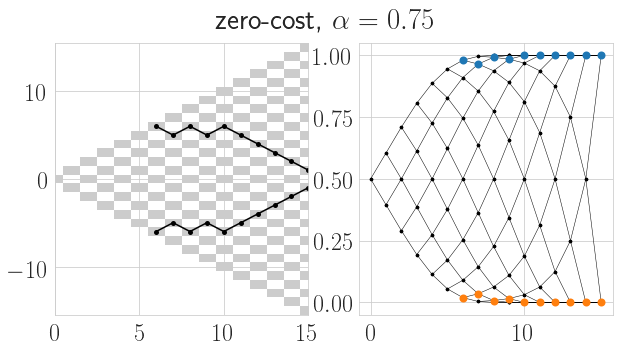

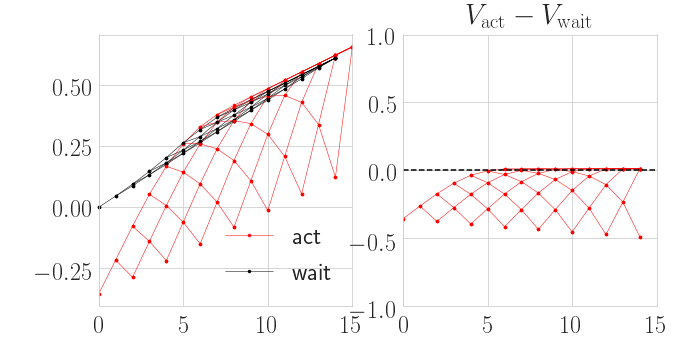

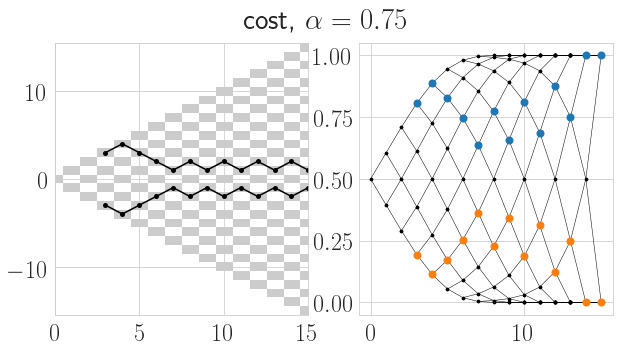

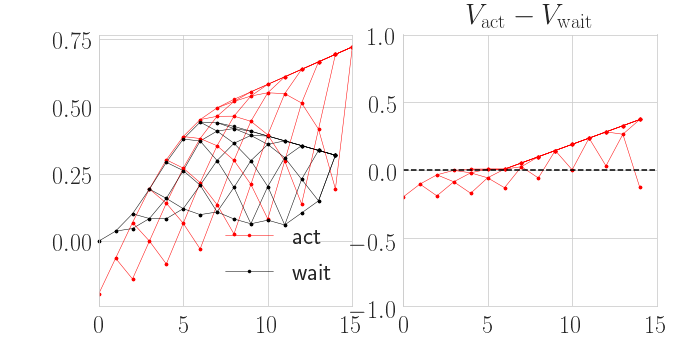

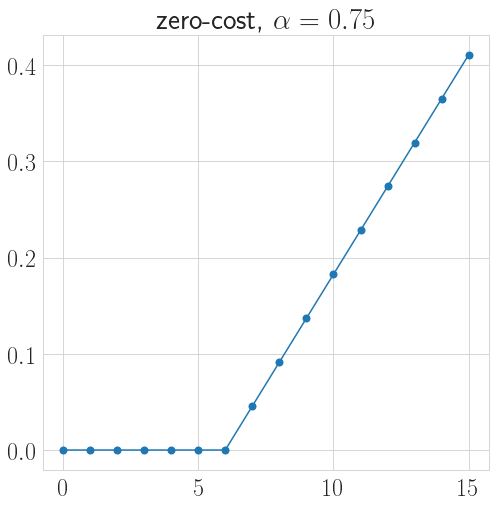

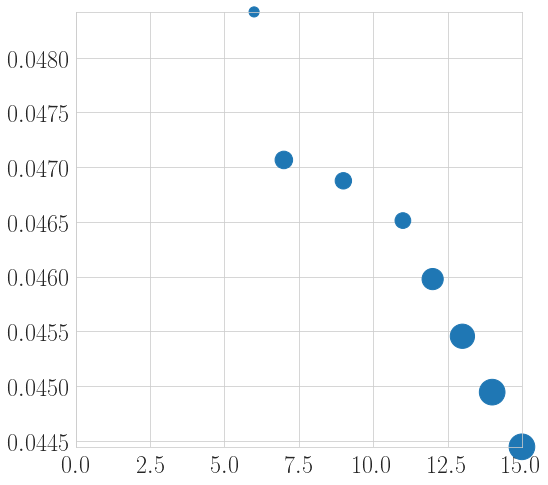

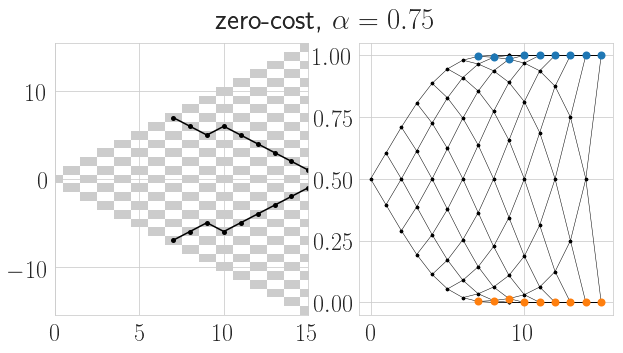

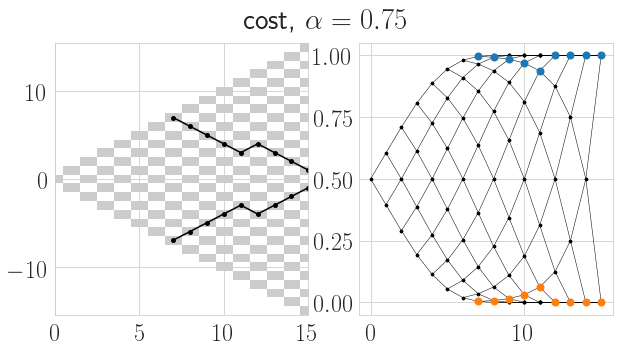

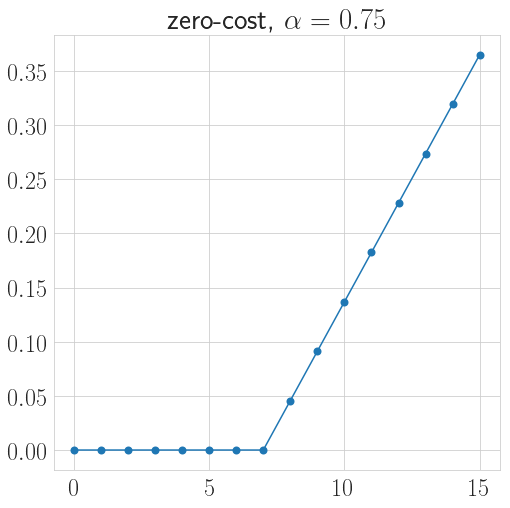

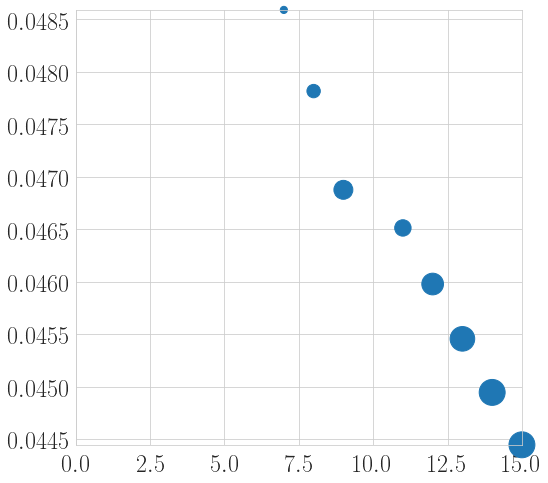

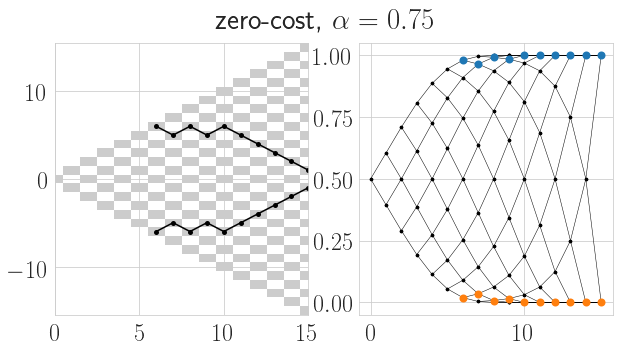

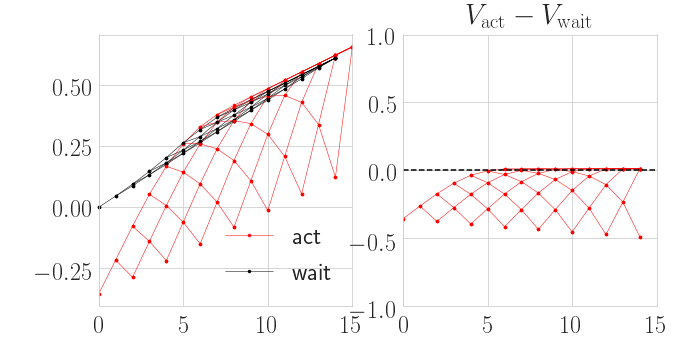

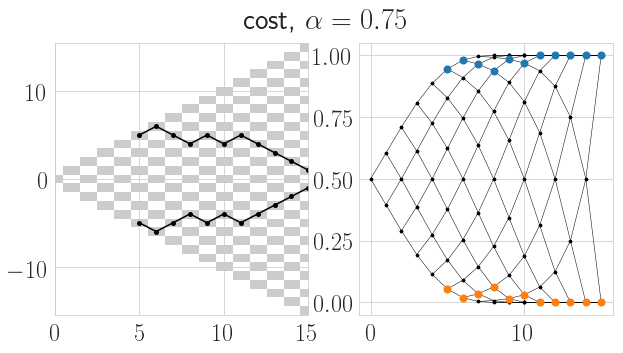

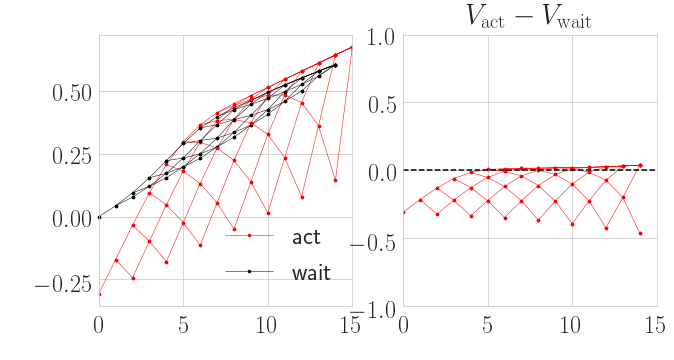

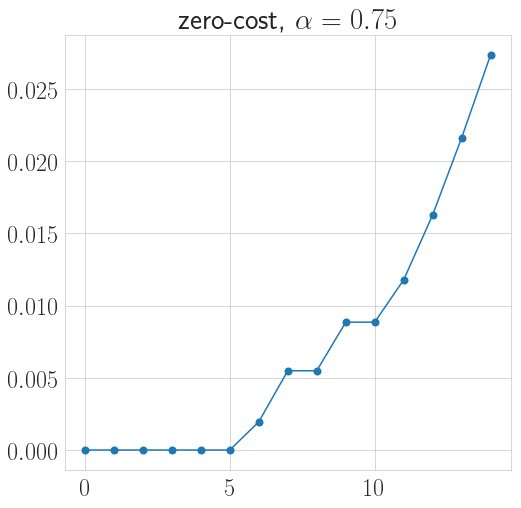

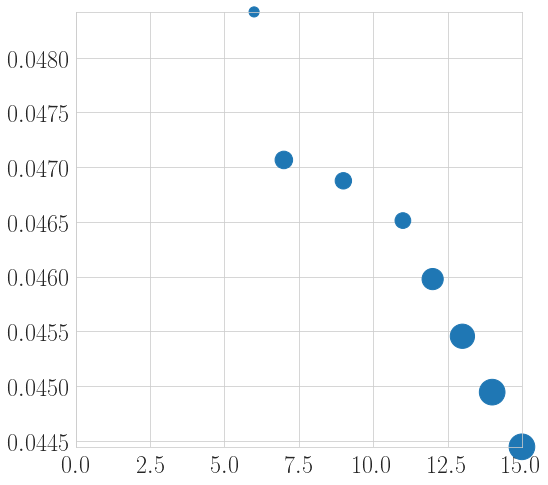

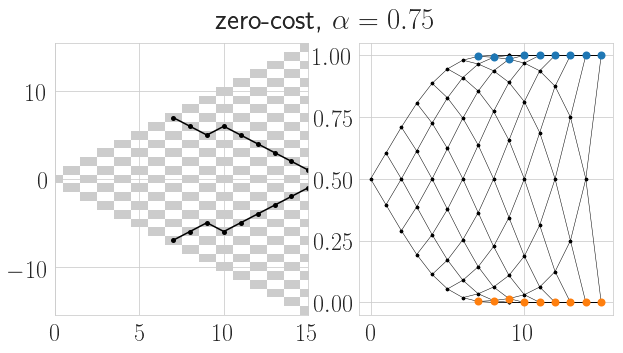

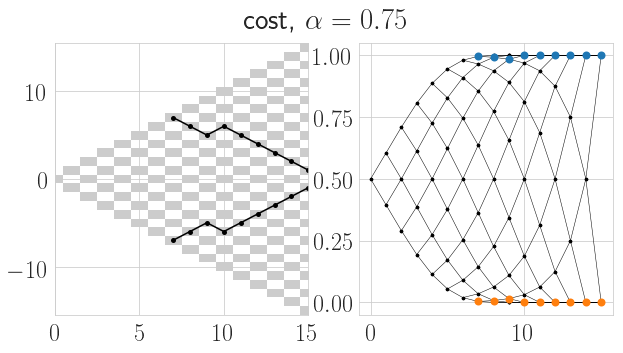

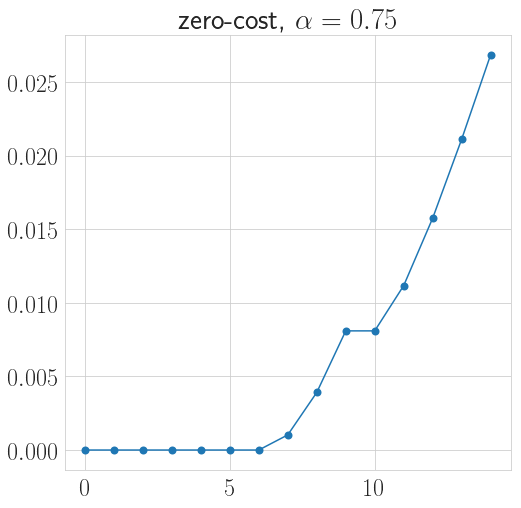

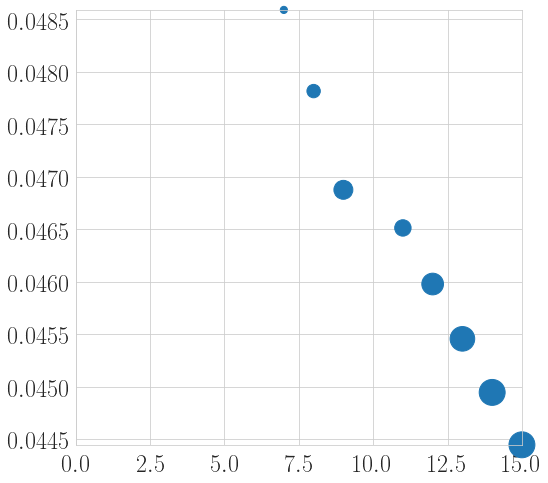

In [104]:
data=dict()
for gamma in [1/4,3/4]:
    data[gamma]=dict()
    for know_mode in ['part','full']:
        data[gamma][know_mode]=dict()
        for bound_constr in ['none','fixed']:
            print(str(gamma)+' '+str(know_mode)+' '+str(bound_constr))
            data[gamma][know_mode][bound_constr]=solve_strategy(normed_costfn,know_mode,bound_constr,gamma,plot=True)

In [717]:
dfb=df_traj.copy()
bvec=np.linspace(0.5,1,30)
gamma=0.2
bound=bvec[np.argmax(rewardvec_b_vec[np.where(gamma_vec==gamma)[0],:])]

#fixed bound
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=bound,x<=1-bound))[0][0] if np.where(np.logical_or(x>=bound,x<=1-bound))[0].size else T)
#         dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
dfb['reward_rate']=(dfb.prob_corr_at_tdec/(dfb.tb+gamma*(T-dfb.tb)+T_ITI))

#variable bound
boundvec=np.concatenate(([np.Inf,np.Inf],np.asarray([get_pt_plus(t,bo) for bo in b[2:]])))
dfb['tb_vary']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=boundvec,x<=1-boundvec))[0][0] if np.where(np.logical_or(x>=boundvec,x<=1-boundvec))[0].size else T)
dfb['prob_corr_at_tdec_vary']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb_vary],1-row.Pt_plus[row.tb_vary]]),axis=1) 
dfb['reward_rate_vary']=(dfb.prob_corr_at_tdec_vary/(dfb.tb_vary+gamma*(T-dfb.tb_vary)+T_ITI))


0.0003669221961815003


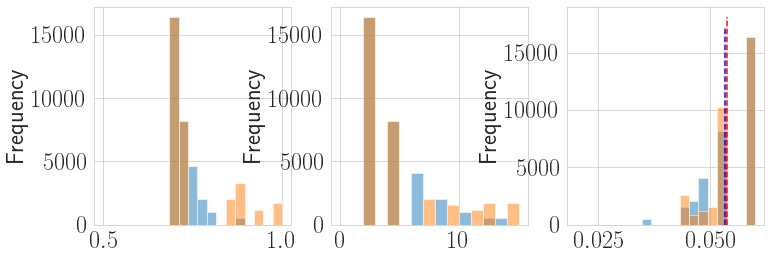

In [726]:
fig,ax=pl.subplots(1,3,figsize=(12,4))
dfb['prob_corr_at_tdec'].plot.hist(ax=ax[0],bins=np.linspace(0.5,1,20),alpha=0.5)
dfb['prob_corr_at_tdec_vary'].plot.hist(ax=ax[0],bins=np.linspace(0.5,1,20),alpha=0.5)
dfb['tb'].plot.hist(ax=ax[1],bins=np.arange(T+1),alpha=0.5)
dfb['tb_vary'].plot.hist(ax=ax[1],bins=np.arange(T+1),alpha=0.5)
dfb['reward_rate'].plot.hist(ax[2],bins=np.linspace(0.02,0.06,20),alpha=0.5)
avgR=dfb.prob_corr_at_tdec.mean()/(dfb.tb+gamma*(T-dfb.tb)+T_ITI).mean()
ax[2].plot([avgR]*2,ax[2].get_ylim(),'b--')
dfb['reward_rate_vary'].plot.hist(ax[2],bins=np.linspace(0.02,0.06,20),alpha=0.5)
avgR_vary=dfb.prob_corr_at_tdec_vary.mean()/(dfb.tb_vary+gamma*(T-dfb.tb_vary)+T_ITI).mean()
ax[2].plot([avgR_vary]*2,ax[2].get_ylim(),'r--')
print(avgR_vary-avgR)

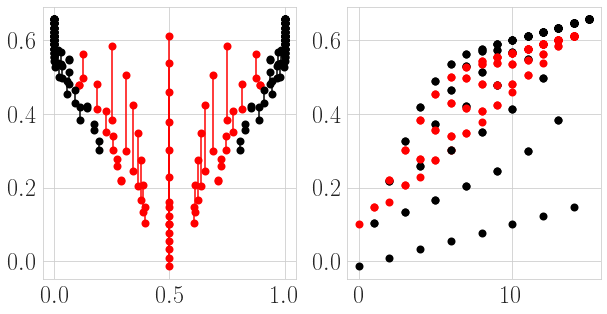

In [141]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
value=np.zeros((T+1,2*T+1))
g=1/4
for t in np.arange(T+1)[::-1]:
    for Nt in range(-t,t+1):
        if (t+Nt-1)%2:
           
            discount=(1)# if t<tmin else 1/(1+m*(t-tmin)))
            R=np.eye(2)*discount   #reward matrix N_T<0,N_T>0 by h_T<0,h_T>0
            prob=np.asarray([get_pt_plus(t,Nt),1-get_pt_plus(t,Nt)]).reshape([1,2]) #prob
            avgR=prob@R
            avgR-=((T-t)*g+T_ITI)*rho #subtract integrated reward over remainder of trial
            Vwait=-np.Inf if t==T else p*value[t+1,T+Nt+1]+(1-p)*value[t+1,T+Nt-1]
            Vwait-=1*rho #subtract integrated reward over step
#             dec_plus[t,T+Nt]=avgR[0,0]
#             dec_minus[t,T+Nt]=avgR[0,1]
#             dec_wait[t,T+Nt]=Vwait
            value[t,T+Nt]=max([avgR[0,1],Vwait,avgR[0,0]])
#             decide[t,T+Nt]=np.argmax([avgR[0,1],Vwait,avgR[0,0]])-1
            
#             ax[0].plot([get_pt_plus(t,Nt)],[max([avgR[0,1],avgR[0,0]])],'ko')
#             ax.plot([get_pt_plus(t,Nt)],[Vwait],'ro')
            if Vwait>max([avgR[0,1],avgR[0,0]]):
                ax[0].plot([get_pt_plus(t,Nt),get_pt_plus(t,Nt)],[max([avgR[0,1],avgR[0,0]]),Vwait],'ro-')
                
            else:
                ax[0].plot([get_pt_plus(t,Nt),get_pt_plus(t,Nt)],[max([avgR[0,1],avgR[0,0]]),Vwait],'ko-')
            ax[1].plot([t],[max([avgR[0,1],avgR[0,0]])],'ko')
            ax[1].plot([t],[Vwait],'ro')
                #             ax.plot([1-get_pt_plus(t,Nt)],[max([avgR[0,1],avgR[0,0]])],'ko')
            
# ax.plot([np.max([dec_minus[int(t),int(T+Nt)],dec_plus[int(t),int(T+Nt)]])] for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])

C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


0.9978330135345459
0.04560653863696436
0.04835048630350189


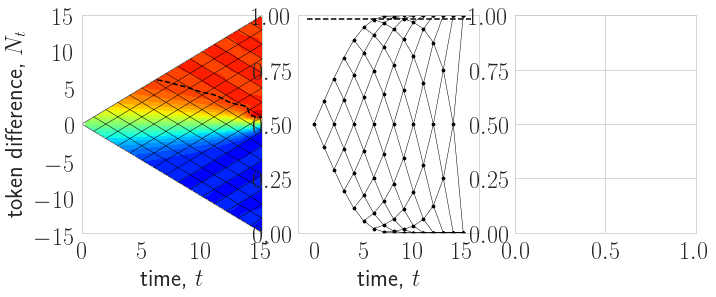

In [234]:
fig,ax=pl.subplots(1,3,figsize=(11,4))
# bound=0.9
prob_p=np.zeros((T+1,T+1))
for Nm in np.arange(0,2*(T+1),2):
    for Np in np.arange(0,2*(T+1),2):
        t=(Np+Nm)/2
        Nt=(Np-Nm)/2
        prob_p[int(Nm/2),int(Np/2)]=get_pt_plus(t,Nt)
        
from scipy.interpolate import griddata
mesh=np.meshgrid(range(T+1),range(T+1))
Npvec=mesh[0].flatten()
Nmvec=mesh[1].flatten()
tvec=Npvec+Nmvec
Nvec=Npvec-Nmvec

tvecdense=np.linspace(min(tvec),max(tvec),100)
Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
z=griddata((tvec,Nvec),prob_p.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

CS=ax[0].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet)
ax[0].set_xlim(0,T)

for Nm in 2*np.arange(T):
    ax[0].plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
    ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
    ax[0].plot(np.arange(T+1-Np/2)+Np/2,Np/2-np.arange(T+1-Np/2),'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
    ax[1].plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
   
CS=ax[0].contour(tvecdense,Nvecdense,z,[bound],colors='k',linestyles='--')
# ax[0].plot([7.5,15],[8,0],'k--',linewidth=2)
ax[0].grid('off')

ax[0].set_ylabel(r'token difference, $N_t$')
ax[0].set_xlabel(r'time, $t$')

ax[1].plot(ax[1].get_xlim(),[bound,bound],'k--',clip_on=False)
ax[1].set_xlabel(r'time, $t$')
ax[1].set_xticks([0,5,10,15])
ax[1].set_ylim(0,1)
# ax[1].plot(np.arange(6),p*(1+p**2*np.arange(6)),'k-')
ax[1].grid('off')

# fig.suptitle('$\mathrm{Prob}(\mathrm{Right}|N_t=n)$',y=1.01)

ax[0].set_xticks([0,5,10,15])
ax[0].set_yticks([-15,-10,-5,0,5,10,15])

#response times
reward_rate_slow=dfb.prob_corr_at_tdec.mean()/(dfb.tb.mean()+gamma_slow*(T-dfb.tb.mean())+T_ITI)
reward_rate_fast=dfb.prob_corr_at_tdec.mean()/(dfb.tb.mean()+gamma_fast*(T-dfb.tb.mean())+T_ITI)

print(dfb.prob_corr_at_tdec.mean())
print(reward_rate_slow)
print(reward_rate_fast)
#dfb.tb.hist(ax=ax[2],bins=np.arange(T+2)-0.5)
# counts,bins=np.histogram(dfb.tb.values,bins=np.arange(T+2)-0.5)
# ax[2].stem(np.arange(T+1),counts)
# ax[2].set_clip_on(False)
# ax[2].set_ylabel('counts')
# ax[2].set_xlabel('decision time')
# ax[2].set_xticks([0,5,10,15])
# ax[2].set_yticks([0,1e4,2e4])
# ax[2].set_xlim(0,15)
# ax[2].set_ylim(0,1e4)
# # ax[2].text(4,1e4,r'$R_\textrm{slow}='+str(round(reward_rate_slow*10000)/10000)+'$')
# # ax[2].text(4,6e3,r'$R_\textrm{fast}='+str(round(reward_rate_fast*10000)/10000)+'$')
fig.tight_layout()
# # fig.savefig('prob_map_bound_0.9.pdf', transparent=True,dpi=300,bbox_inches='tight')

C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


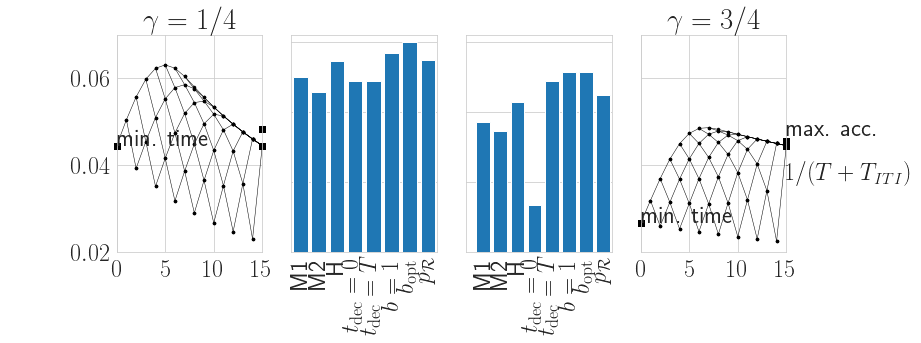

In [213]:

fig=pl.figure(figsize=(12,4))
# for Nm in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
# for Np in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')

# gamma=1
# color=[0.8,0.8,0.8]
# for Nm in 2*np.arange(T):
#     ax.plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)],'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
# for Np in 2*np.arange(T-7):
#     ax.plot(np.arange(Np/2+1)+Np/2,[(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)],'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)

rr_M1_fast=0.04489874703443582
rr_M1_slow=0.038475184652453864
rr_M2_fast=0.0427570104760277
rr_M2_slow=0.03724601256317603
rr_H1_fast=0.04716158428767893
rr_H1_slow=0.04132889498676728
kslow=0.04560653863696436*(T+T_ITI)
kfast=0.04835048630350189*(T+T_ITI)
optb_fast=0.0499
optb_slow=0.0456
pr_slow=0.04241943776709402
pr_fast=0.0473903703878341
# 0.038453036189653934
# 0.044383197633765234

0.0473903703878341

ax1=fig.add_subplot(1,4,1)
gamma=gamma_fast
for Nm in 2*np.arange(T):
    ax1.plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',clip_on=False)
for Np in 2*np.arange(T-7):
    ax1.plot(np.arange(Np/2+1)+Np/2,[(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',clip_on=False)
ax1.set_title(r'$\gamma=1/4$')
ax1.set_xlim(0,T)
ax1.plot([T],[1/(T+T_ITI)],'ks',markersize=5,clip_on=False)
# ax1.text(T,1/(T+T_ITI),r'$1/(T+T_{ITI})$',va='top')
ax1.plot([T],[kfast/(T+T_ITI)],'ks',markersize=5,clip_on=False)
# ax1.text(T,kfast/(T+T_ITI),r'max. acc.',va='bottom')
ax1.plot([0],[1/(2*(gamma_fast*T+T_ITI))],'ks',markersize=5,clip_on=False)
ax1.text(0,1/(2*(gamma_fast*T+T_ITI)),r'min. time')
# ax1.plot([0],[rr_M1_fast],'ks',markersize=5)
# ax1.text(0,rr_M1_fast,r'M1')
# ax1.plot([0],[rr_M2_fast],'ks',markersize=5)
# ax1.text(0,rr_M2_fast,r'M2')
# ax1.plot([0],[rr_H1_fast],'ks',markersize=5)
# ax1.text(0,rr_H1_fast,r'H1')
ax1.set_ylim(0.02,0.07) 
ax1.set_xticks([0,5,10,15])

axbar1=fig.add_subplot(1,4,2)
axbar1.bar(range(1,9),[rr_M1_fast,rr_M2_fast,rr_H1_fast,1/(2*(gamma_fast*T+T_ITI)),1/(T+T_ITI),kfast/(T+T_ITI),optb_fast,pr_fast])
axbar1.set_xticks(range(1,9))
axbar1.set_xticklabels(['M1','M2','H',r'$t_\textrm{dec}=0$',r'$t_\textrm{dec}=T$',r'$b=1$',r'$b_{\textrm{opt}}$',r'$p_\mathcal{R}$'], rotation='vertical')
axbar1.set_xlim(0.5,8.5)
axbar1.grid('off',axis='x')
axbar1.set_yticklabels([])
axbar1.set_ylim(0.02,0.051)

axbar2=fig.add_subplot(1,4,3)
axbar2.bar(range(1,9),[rr_M1_slow,rr_M2_slow,rr_H1_slow,1/(2*(gamma_slow*T+T_ITI)),1/(T+T_ITI),kslow/(T+T_ITI),optb_slow,pr_slow])
axbar2.set_xticks(range(1,9))
axbar2.set_xticklabels(['M1','M2','H',r'$t_\textrm{dec}=0$',r'$t_\textrm{dec}=T$',r'$b=1$',r'$b_{\textrm{opt}}$',r'$p_\mathcal{R}$'], rotation='vertical')
axbar2.set_xlim(0.,8.5)
axbar2.grid('off',axis='x')
axbar2.set_yticklabels([])
axbar2.set_ylim(0.02,0.051)

ax2=fig.add_subplot(1,4,4)
gamma=gamma_slow
for Nm in 2*np.arange(T):
    ax2.plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)],'o-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',clip_on=False)
for Np in 2*np.arange(T-7):
    ax2.plot(np.arange(Np/2+1)+Np/2,[(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)],'o-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k',clip_on=False)
ax2.set_title(r'$\gamma=3/4$')
ax2.set_xlim(0,T)
ax2.plot([T],[1/(T+T_ITI)],'ks',markersize=5,clip_on=False)
ax2.text(T,1/(T+T_ITI)*0.9,r'$1/(T+T_{ITI})$',va='top')
ax2.plot([T],[kslow/(T+T_ITI)],'ks',markersize=5,clip_on=False)
ax2.text(T,kslow/(T+T_ITI),r'max. acc.',va='bottom')
ax2.plot([0],[1/(2*(gamma_slow*T+T_ITI))],'ks',markersize=5,clip_on=False)
ax2.text(0,1/(2*(gamma_slow*T+T_ITI)),r'min. time')
# ax2.plot([0],[rr_M1_slow],'ks',markersize=5)
# ax2.text(0,rr_M1_slow,r'M1')
# ax2.plot([0],[rr_M2_slow],'ks',markersize=5)
# ax2.text(0,rr_M2_slow,r'M2')
# ax2.plot([0],[rr_H1_slow],'ks',markersize=5)
# ax2.text(0,rr_H1_slow,r'H1')
ax2.set_ylim(0.02,0.07) 
ax2.set_yticklabels([])
ax2.set_xticks([0,5,10,15])
ax2.set_clip_on('False')
fig.tight_layout(pad=0.01)

fig.savefig('rewardrate_comparison.pdf', transparent=True,dpi=300,bbox_inches='tight')

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in reciprocal
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in reciprocal
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


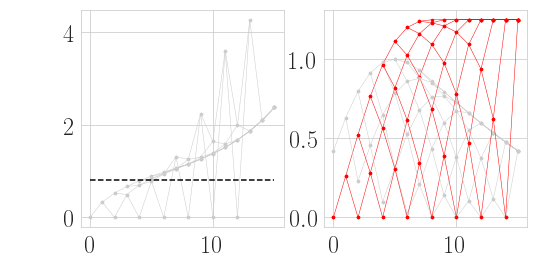

In [119]:
fig,ax=pl.subplots(1,2,figsize=(8,4))
# for Nm in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
# for Np in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
bound=0.9
gamma=0.25
color=[0.8,0.8,0.8]
dmin=np.Inf
dmax=0
for Nm in 2*np.arange(T):
    datam=np.asarray([get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
#     datam=np.asarray([get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
    if Nm<=T:
        dmintmp=np.min(datam)
        dmin=np.min((dmin,dmintmp))
        dmaxtmp=np.max(datam)
        dmax=np.max((dmax,dmaxtmp))
    

for Np in 2*np.arange(T-7):
    datap=np.asarray([(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])
#     datap=np.asarray([(1-get_pt_plus(15,t,Nt)) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])
    if Np>T:
        dmintmp=np.min(datam)
        dmin=np.min((dmin,dmintmp))
        dmaxtmp=np.max(datam)
        dmax=np.max((dmax,dmaxtmp))

for Nm in 2*np.arange(T):
    datam=np.asarray([get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
    r_scale=(datam-dmin)/(dmax-dmin)
    Rsubj=-r_scale**(-1)+1
    Probi=np.exp(Rsubj)
    ax[1].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
    datam=np.asarray([get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
    ax[1].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,(2*datam-1)/(2*bound-1),'o-',ms=3,lw=0.5,color='r',mew=0.5,mfc='r',mec='r',clip_on=False)
    ax[0].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,(2*datam-1)/Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
    
for Np in 2*np.arange(T-7):
    datap=np.asarray([(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])
    r_scale=(datap-dmin)/(dmax-dmin)
    Rsubj=-r_scale**(-1)+1
    Probi=np.exp(Rsubj)
    ax[1].plot(np.arange(Np/2+1)+Np/2,Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
    datap=np.asarray([(1-get_pt_plus(15,t,Nt)) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])
    ax[1].plot(np.arange(Np/2+1)+Np/2,(2*datap-1)/(2*bound-1),'o-',ms=3,lw=0.5,color='r',mew=0.5,mfc='r',mec='r',clip_on=False)
    ax[0].plot(np.arange(Np/2+1)+Np/2,(2*datap-1)/Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
ax[0].plot(np.arange(16),(2*bound-1)*np.ones(16),'k--')


In [151]:
dec_crit
def dummy(row,dec_crit):
    return np.where(row.values>dec_crit)[0]
rowdf_traj.Nt.apply()

seq  \
0  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
1  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
2  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
3  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
4  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   

                                                  Nt  \
0  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
1  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
2  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
3  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
4  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   

                                             Pt_plus  \
0  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
1  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
2  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
3  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
4  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   

                                            evidence   plus  
0  [0.0, -0.4252394758117244, -0.8928242580246532...  False  
1  [0.0, -0.4252394758117244, -0.8928242580246532...  False  
2  [0.0, -0.4252394758117244, -0.8928242580246532...  False  
3  [0.0, -0.4252394758117244, -0.8928242580246532...  False  
4  [0.0, -0.4252394758117244, -0.8928242580246532...  False

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log


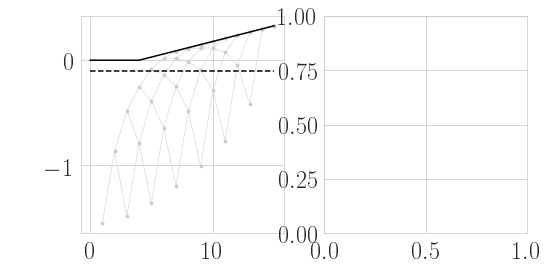

In [60]:
fig,ax=pl.subplots(1,2,figsize=(8,4))
# for Nm in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
# for Np in 2*np.arange(T):
#     ax.plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
bound=0.95
gamma=0.25
color=[0.8,0.8,0.8]
dmin=np.Inf
dmax=0
for Nm in 2*np.arange(T):
    datam=np.asarray([get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
#     datam=np.asarray([get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
    if Nm<=T:
        dmintmp=np.min(datam)
        dmin=np.min((dmin,dmintmp))
        dmaxtmp=np.max(datam)
        dmax=np.max((dmax,dmaxtmp))
    

for Np in 2*np.arange(T-7):
    datap=np.asarray([(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])
#     datap=np.asarray([(1-get_pt_plus(15,t,Nt)) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])
    if Np>T:
        dmintmp=np.min(datam)
        dmin=np.min((dmin,dmintmp))
        dmaxtmp=np.max(datam)
        dmax=np.max((dmax,dmaxtmp))

# ravg=0.3
# tmin=5

ravg=0.3
tmin=7

ravg=0.03
tmin=4

Urgency=-bigR


for Nm in 2*np.arange(T):
    datam=np.asarray([get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
#     ax[1].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
#     datam=np.asarray([get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
    datam=[]
    for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2):
        if t<=tmin:
            datam.append(np.log(2*get_pt_plus(15,t,Nt)-1))
#             datam.append(get_pt_plus(15,t,Nt))
        else:
            datam.append(np.log(2*get_pt_plus(15,t,Nt)-1)+ravg*(t-tmin))
#             datam.append(get_pt_plus(15,t,Nt))
    #     ax[1].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,(2*datam-1)/(2*bound-1),'o-',ms=3,lw=0.5,color='r',mew=0.5,mfc='r',mec='r',clip_on=False)
#     r_scale=(datam-dmin)/(dmax-dmin)
#     Rsubj=-r_scale**(-1)+1
#     Probi=np.exp(Rsubj)
    ax[0].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,datam,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)

for Np in 2*np.arange(T-7):
#     datap=np.asarray([(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])
    
#     ax[1].plot(np.arange(Np/2+1)+Np/2,Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
    datap=[]
    for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2):
        if t<=tmin:
            datap.append(np.log(2*(1-get_pt_plus(15,t,Nt))-1))
#             datap.append(1-get_pt_plus(15,t,Nt))
        else:
            datap.append(np.log(2*(1-get_pt_plus(15,t,Nt))-1)+ravg*(t-tmin))
#             datap.append(1-get_pt_plus(15,t,Nt))
#     r_scale=(datap-dmin)/(dmax-dmin)
#     Rsubj=-r_scale**(-1)+1
#     Probi=np.exp(Rsubj)
#     ax[1].plot(np.arange(Np/2+1)+Np/2,(2*datap-1)/(2*bound-1),'o-',ms=3,lw=0.5,color='r',mew=0.5,mfc='r',mec='r',clip_on=False)
    ax[0].plot(np.arange(Np/2+1)+Np/2,datap,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
ax[0].plot(np.arange(16),np.log(2*bound-1)*np.ones(16),'k--')
ax[0].plot(np.arange(16),ravg*(np.concatenate((tmin*np.ones(tmin),np.arange(tmin,16)))-tmin),'k-')

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  """


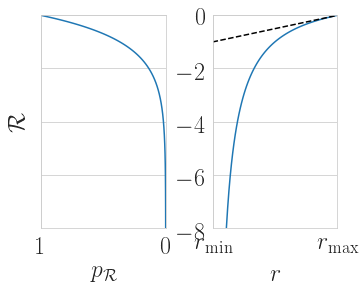

In [176]:
rmin=0#0.03
rmax=1#0.045
rvectmp=np.linspace(rmin,rmax,100)
r_scale=(rvectmp-rmin)/(rmax-rmin)
Rsubj=-r_scale**(-1)+1
fig,ax=pl.subplots(1,2,figsize=(5,4))
ax[0].plot(np.exp(Rsubj),Rsubj)
ax[0].set_ylim(-8,0)
ax[0].set_xlim(1,0)
ax[0].set_xticks([1,0])
ax[0].set_yticklabels([])
ax[0].set_ylabel(r'$\mathcal{R}$')
ax[0].set_xlabel(r'$p_\mathcal{R}$')
ax[1].plot(rvectmp,Rsubj)
ax[1].plot(rvectmp,r_scale-1,'k--')
ax[1].set_ylim(-8,0)
ax[1].set_xlim(0,1)
ax[1].set_xlabel('$r$')
ax[1].set_xticks((0,1))
# ax[1].set_yticklabels([])
ax[1].set_xticklabels((r'$r_\textrm{min}$',r'$r_\textrm{max}$'))
# ax[1].set_ylabel('$$')
fig.tight_layout(pad=0.2)
fig.savefig('reward_coord.pdf', transparent=True,dpi=300,bbox_inches='tight')

In [62]:
print(reward_rate_fast)
print(reward_rate_slow)

0.04835048630350189
0.04560653863696436


PLot phase space

In [545]:
rewardvec_b_vec[0,:]/(T)

array([0.06666667, 0.06255458, 0.06255458, 0.06255458, 0.06255458,
       0.06255458, 0.06255458, 0.05866834, 0.05896665, 0.05896665,
       0.05933609, 0.05981562, 0.05981562, 0.05757323, 0.05670151,
       0.05738876, 0.05750189, 0.05750189, 0.05601863, 0.05630279,
       0.05537131, 0.05485243, 0.05525752, 0.05408366, 0.05325439,
       0.05325439, 0.05189688, 0.05132042, 0.05051584, 0.04949848])

In [70]:
dfb=df_traj.copy()
bvec=np.linspace(0.5,1,30)
gamma_vec=np.linspace(0.01,1,30)
phi_b_vec=np.zeros(bvec.shape)
meanprob_b_vec=np.zeros(bvec.shape)
nbins=100
b_counts=np.zeros((len(bvec),nbins-1))
rewardvec_b_vec=np.zeros((len(gamma_vec),len(bvec)))
for it,b in enumerate(bvec):
    dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else T)
    dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
    dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
    phi_b_vec[it]=dfb.tb.mean()/T
    meanprob_b_vec[it]=dfb.prob_corr_at_tdec.mean()
    counts,_=np.histogram(dfb.prob_corr_at_tdec.values,bins=np.linspace(0,1,nbins))
    b_counts[it,:]=counts
    for git,gamma in enumerate(gamma_vec):
        rewardvec_b_vec[git,it]=(dfb.prob_corr_at_tdec/(dfb.tb/T+gamma*(1-dfb.tb/T)+T_ITI/T)).mean()

In [563]:
b=0.501
it=0
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b,x<=1-b))[0][0] if np.where(np.logical_or(x>=b,x<=1-b))[0].size else T)
# dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
phi_b_vec[it]=dfb.tb.mean()/T
meanprob_b_vec[it]=dfb.prob_corr_at_tdec.mean()
# counts,_=np.histogram(dfb.prob_corr_at_tdec.values,bins=np.linspace(0,1,nbins))
# b_counts[it,:]=counts
# dfb['tb'].unique()
# dfb.prob_corr_at_tdec.mean/(dfb.tb/T+gamma*(1-dfb.tb/T)+T_ITI/T)).mean()

In [619]:
dfb=df_traj.copy()
bvec=np.linspace(0.5,1,30)
gamma_vec=np.arange(50)/50
phi_b_vec=np.zeros(bvec.shape)
meanprob_b_vec=np.zeros(bvec.shape)
nbins=100
b_counts=np.zeros((len(bvec),nbins-1))
rewardvec_b_vec=np.zeros((len(gamma_vec),len(bvec)))
for git,gamma in enumerate(gamma_vec):
    for it,b in enumerate(bvec):
        dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(np.logical_or(x>=b,x<=1-b))[0][0] if np.where(np.logical_or(x>=b,x<=1-b))[0].size else T)
#         dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
        dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
        phi_b_vec[it]=dfb.tb.mean()/T
        meanprob_b_vec[it]=dfb.prob_corr_at_tdec.mean()
        counts,_=np.histogram(dfb.prob_corr_at_tdec.values,bins=np.linspace(0,1,nbins))
        b_counts[it,:]=counts
        rewardvec_b_vec[git,it]=(dfb.prob_corr_at_tdec/(dfb.tb/T+gamma*(1-dfb.tb/T)+T_ITI/T)).mean()
#         rewardvec_b_vec[git,it]=(dfb.prob_corr_at_tdec.mean/(dfb.tb/T+gamma*(1-dfb.tb/T)+T_ITI/T)).mean()

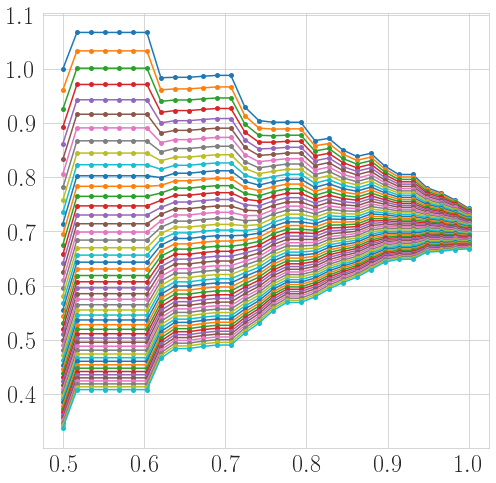

In [628]:
fig,ax=pl.subplots()
ax.plot(bvec,rewardvec_b_vec.T,'.-');

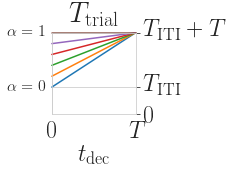

In [4]:
T=15
T_ITI=7.5
fig,ax=pl.subplots(figsize=(1.5,1.5))
for gamma in np.arange(6)/5:
    ax.plot(np.arange(T+1),np.arange(T+1)+gamma*(T-np.arange(T+1))+T_ITI,'-',clip_on=False)
ax.set_yticks([0,T_ITI,T_ITI+T])
ax.set_yticklabels([r'$0$',r'$T_\textrm{ITI}$',r'$T_\textrm{ITI}+T$'])
ax.set_xticks([0,T])
ax.set_xticklabels([r'$0$',r'$T$'])
ax.grid('off')    
ax.set_xlabel(r'$t_{\textrm{dec}}$')
ax.set_title(r'$T_{\textrm{trial}}$')
# ax.text(4,T_ITI+T+1,r'$\alpha=1$',fontsize=16)
# ax.text(6,T_ITI+3,r'$\alpha=0$',fontsize=16)
ax.text(-8,T_ITI+T-1,r'$\alpha=1$',fontsize=16)
ax.text(-8,T_ITI-1,r'$\alpha=0$',fontsize=16)
ax.yaxis.tick_right()
ax.set_ylim(0,T+T_ITI)
ax.set_xlim(0,T)
fig.savefig('T_trial.pdf', transparent=True,dpi=300,bbox_inches='tight')

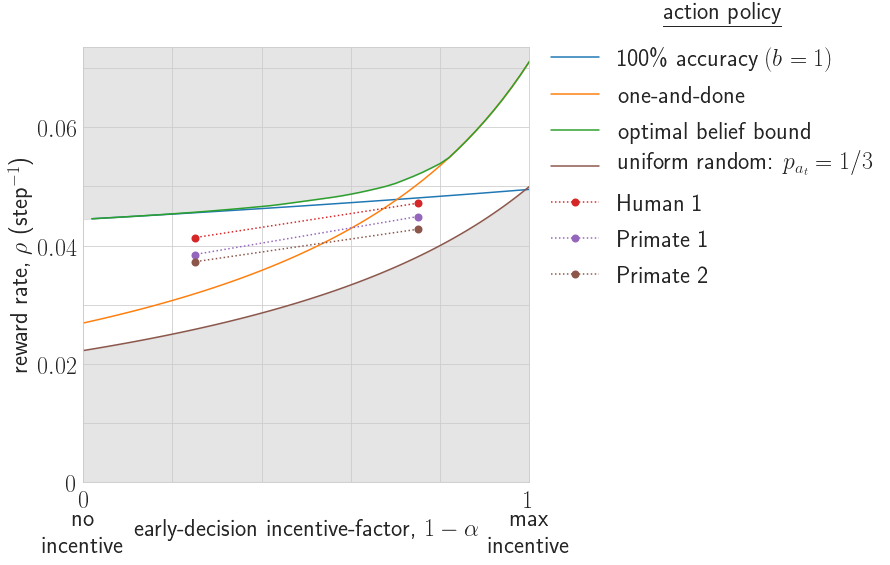

In [103]:
# np.save('rewardvec_b_vec.npy',rewardvec_b_vec)
# np.save('rew_DP.npy',rew_DP)
rew_DP=np.load('rew_DP.npy')
rewardvec_b_vec=np.load('rewardvec_b_vec.npy')
gamma_vec=np.arange(50)/50
# bvec=np.linspace(0.5,1,30)
T_I=7.5
fig,ax=pl.subplots(figsize=(8,8))
colors=pl.rcParams['axes.prop_cycle'].by_key()['color']


# ax.plot(gamma_vec,rew_b,'-',label=r'optimal fixed bound: $b=b_{\textrm{opt}}(\alpha)$')

ax.plot(gamma_vec,rewardvec_b_vec[:,-1]/T,'-',label=r'100\% accuracy $(b=1)$')
# ax.text(0.6,1.07/(T+T_I),r'$\frac{1}{\bar{t}_{b=1}+\alpha (T-\bar{t}_{b=1})+T_{\textrm{I}}}$',color=colors[2])

ax.plot(np.append(gamma_vec,1),get_pt_plus(1,1)/(1+np.append(gamma_vec,1)*(T-1)+T_I),'-',label='one-and-done')#step: $a_{1}=N_{1}$')
# ax.text(0.1,3/(2*(T+T_I)),r'$\frac{p_{\textrm{success}}(t^\pi_{\textrm{dec}}=1)}{1+\alpha(T-1)+T_{\textrm{I}}}$',color=colors[3])

rew_b=np.max(rewardvec_b_vec,axis=1)/T
ax.plot(gamma_vec,rew_DP,'-',label='optimal belief bound',clip_on=False)

# gvec=np.linspace(0,1,100)
# ax.plot(gvec,1/(2*(gvec*T+T_I)),'-',label=r'zero-step: $a_{0}=1$')
# ax.text(0.7,0.8/(2*(T+T_I)),r'$\frac{1/2}{\alpha T+T_{\textrm{I}}}$',color=colors[4])

p_act_rand=2/3
tdec_mean_fullrand=1/p_act_rand+1
rew_fullrand=[1/2*1/(tdec_mean_fullrand+gamma*(T-tdec_mean_fullrand)+T_I) for gamma in gvec]
ax.plot(gvec,rew_fullrand,'-',label=r'uniform random: $p_{a_t}=1/3$',color=colors[5])
# ax.text(0.1,1.3/(2*(T+T_I)),r'$\frac{1/2}{5/2+\alpha(T-5/2)+T_{\textrm{I}}}$',color=colors[5])

ylim=ax.get_ylim()
gray_val=0.8
ax.fill_between(np.append(gamma_vec,1),np.append(rew_DP,1/(T+T_I)), [ylim[1]]*(len(gamma_vec)+1),color=[gray_val]*3,alpha=0.5)
ax.fill_between(gvec,np.zeros(gvec.shape),rew_fullrand,color=[gray_val]*3,alpha=0.5)
# ax.text(0.65,0.06,r'better than best')
# ax.text(0.7,0.01,r'worse than random')

#data
rr_M1_fast=0.04489874703443582
rr_M1_slow=0.038475184652453864
rr_M2_fast=0.0427570104760277
rr_M2_slow=0.03724601256317603
rr_H1_fast=0.04716158428767893
rr_H1_slow=0.04132889498676728
ax.plot([1/4,3/4],[rr_H1_fast,rr_H1_slow],'o:',label='Human 1')
ax.plot([1/4,3/4],[rr_M1_fast,rr_M1_slow],'o:',label='Primate 1')
ax.plot([1/4,3/4],[rr_M2_fast,rr_M2_slow],'o:',label='Primate 2')

ax.set_ylabel(r'reward rate, $\rho$ (step$^{-1}$)')#'=\frac{\langle p_{\textrm{success}}(t^\pi_{\textrm{dec}}) \rangle_{\tau}}{\langle T_{\textrm{trial}}(t^\pi_{\textrm{dec}})\rangle_{\tau}}$')
ax.set_xlabel(r'early-decision incentive-factor, $1-\alpha$')
ax.text(1.,-0.012,'no \n incentive',ha='center')
ax.text(0.,-0.012,'max \n incentive',ha='center')
ax.legend(frameon=False,bbox_to_anchor=(1.0, 1.05))
ax.set_xlim(1.0,0)
# ax.set_xticklabels([r'${0:3.1f}$'.format(x) for x in np.linspace(0,1.0,6)[::-1]])
ax.set_xticklabels([r'$1$','','','','',r'$0$'])
ax.set_ylim([0,ylim[1]])
ax.set_yticklabels([r'$0$','',r'$0.02$','',r'$0.04$','',r'$0.06$',''])


# left, bottom, width, height = [0.45, 0.65, 0.2, 0.2] #inset
# left, bottom, width, height = [1.05, 0.12, 0.2, 0.2] #outset
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(gamma_vec,bvec[np.argmax(rewardvec_b_vec,axis=1)],'.',clip_on=False,color=colors[1])
# ax2.set_ylabel(r'$b_{\textrm{opt}}$')
# ax2.set_xlabel(r'$\alpha$')
# ax2.set_xlim(0,1)
# ax2.set_ylim(0.5,1)
# ax2.set_yticks([0.5,0.75,1])
# ax2.set_yticklabels([r'$1/2$','',r'$1$'])
# ax2.set_xticks([0,0.5,1.])
# ax2.set_xticklabels(['$0$','','$1$'])
# ax.grid('off')
ax.text(-0.3,0.077,r'\underline{action policy}')
# ax.set_title(r'$p_\textrm{jump}=1/2$, $T=15$ steps, $T_\textrm{inter}=T/2$')
fig.savefig('reward_vs_alpha.pdf', transparent=True,dpi=300,bbox_inches='tight')

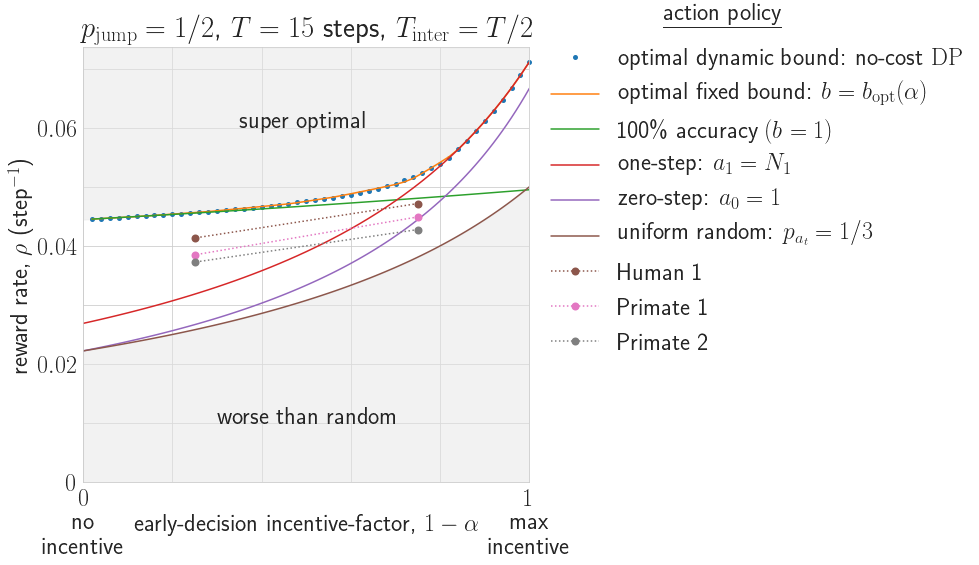

In [904]:
# np.save('rewardvec_b_vec.npy',rewardvec_b_vec)
# np.save('rew_DP.npy',rew_DP)
rew_DP=np.load('rew_DP.npy')
# rewardvec_b_vec=np.load('rewardvec_b_vec.npy')

# bvec=np.linspace(0.5,1,30)
T_I=T_ITI
fig,ax=pl.subplots(figsize=(8,8))
colors=pl.rcParams['axes.prop_cycle'].by_key()['color']

rew_b=np.max(rewardvec_b_vec,axis=1)/T
ax.plot(gamma_vec,rew_DP,'.',label=r'optimal dynamic bound: no-cost $\textrm{DP}$',clip_on=False)

ax.plot(gamma_vec,rew_b,'-',label=r'optimal fixed bound: $b=b_{\textrm{opt}}(\alpha)$')

ax.plot(gamma_vec,rewardvec_b_vec[:,-1]/T,'-',label=r'100\% accuracy $(b=1)$')
# ax.text(0.6,1.07/(T+T_I),r'$\frac{1}{\bar{t}_{b=1}+\alpha (T-\bar{t}_{b=1})+T_{\textrm{I}}}$',color=colors[2])

ax.plot(np.append(gamma_vec,1),get_pt_plus(T,1,1)/(1+np.append(gamma_vec,1)*(T-1)+T_I),'-',label=r'one-step: $a_{1}=N_{1}$')
# ax.text(0.1,3/(2*(T+T_I)),r'$\frac{p_{\textrm{success}}(t^\pi_{\textrm{dec}}=1)}{1+\alpha(T-1)+T_{\textrm{I}}}$',color=colors[3])

gvec=np.linspace(0,1,100)
ax.plot(gvec,1/(2*(gvec*T+T_I)),'-',label=r'zero-step: $a_{0}=1$')
# ax.text(0.7,0.8/(2*(T+T_I)),r'$\frac{1/2}{\alpha T+T_{\textrm{I}}}$',color=colors[4])

p_act_rand=2/3
tdec_mean_fullrand=1/p_act_rand+1
rew_fullrand=[1/2*1/(tdec_mean_fullrand+gamma*(T-tdec_mean_fullrand)+T_I) for gamma in gvec]
ax.plot(gvec,rew_fullrand,'-',label=r'uniform random: $p_{a_t}=1/3$',color=colors[5])
# ax.text(0.1,1.3/(2*(T+T_I)),r'$\frac{1/2}{5/2+\alpha(T-5/2)+T_{\textrm{I}}}$',color=colors[5])

ylim=ax.get_ylim()
ax.fill_between(np.append(gamma_vec,1),np.append(rew_DP,1/(T+T_I)), [ylim[1]]*(len(gamma_vec)+1),color=[0.9,0.9,0.9],alpha=0.5)
ax.fill_between(gvec,np.zeros(gvec.shape),rew_fullrand,color=[0.9,0.9,0.9],alpha=0.5)
ax.text(0.65,0.06,r'super optimal')
ax.text(0.7,0.01,r'worse than random')

#data
rr_M1_fast=0.04489874703443582
rr_M1_slow=0.038475184652453864
rr_M2_fast=0.0427570104760277
rr_M2_slow=0.03724601256317603
rr_H1_fast=0.04716158428767893
rr_H1_slow=0.04132889498676728
ax.plot([1/4,3/4],[rr_H1_fast,rr_H1_slow],'o:',label='Human 1')
ax.plot([1/4,3/4],[rr_M1_fast,rr_M1_slow],'o:',label='Primate 1')
ax.plot([1/4,3/4],[rr_M2_fast,rr_M2_slow],'o:',label='Primate 2')

ax.set_ylabel(r'reward rate, $\rho$ (step$^{-1}$)')#'=\frac{\langle p_{\textrm{success}}(t^\pi_{\textrm{dec}}) \rangle_{\tau}}{\langle T_{\textrm{trial}}(t^\pi_{\textrm{dec}})\rangle_{\tau}}$')
ax.set_xlabel(r'early-decision incentive-factor, $1-\alpha$')
ax.text(1.,-0.012,'no \n incentive',ha='center')
ax.text(0.,-0.012,'max \n incentive',ha='center')
ax.legend(frameon=False,bbox_to_anchor=(1.0, 1.05))
ax.set_xlim(1.0,0)
# ax.set_xticklabels([r'${0:3.1f}$'.format(x) for x in np.linspace(0,1.0,6)[::-1]])
ax.set_xticklabels([r'$1$','','','','',r'$0$'])
ax.set_ylim([0,ylim[1]])
ax.set_yticklabels([r'$0$','',r'$0.02$','',r'$0.04$','',r'$0.06$',''])


# left, bottom, width, height = [0.45, 0.65, 0.2, 0.2] #inset
# left, bottom, width, height = [1.05, 0.12, 0.2, 0.2] #outset
# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.plot(gamma_vec,bvec[np.argmax(rewardvec_b_vec,axis=1)],'.',clip_on=False,color=colors[1])
# ax2.set_ylabel(r'$b_{\textrm{opt}}$')
# ax2.set_xlabel(r'$\alpha$')
# ax2.set_xlim(0,1)
# ax2.set_ylim(0.5,1)
# ax2.set_yticks([0.5,0.75,1])
# ax2.set_yticklabels([r'$1/2$','',r'$1$'])
# ax2.set_xticks([0,0.5,1.])
# ax2.set_xticklabels(['$0$','','$1$'])

ax.text(-0.3,0.077,r'\underline{action policy}')
ax.set_title(r'$p_\textrm{jump}=1/2$, $T=15$ steps, $T_\textrm{inter}=T/2$')
fig.savefig('reward_vs_alpha.pdf', transparent=True,dpi=300,bbox_inches='tight')

In [901]:
1/(T+T_ITI)

0.044444444444444446

In [791]:
pl.rcParams['axes.prop_cycle'].by_key()['color']


['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

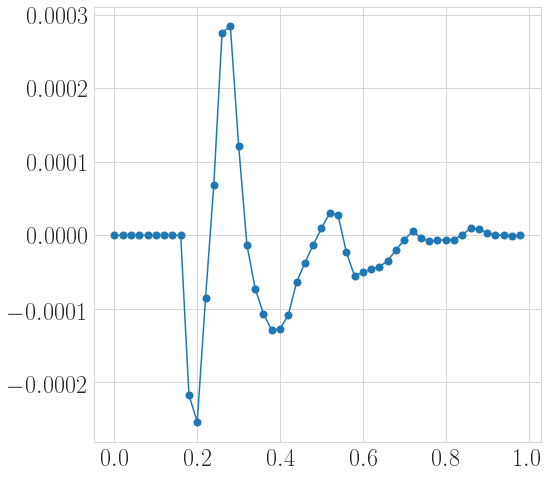

In [727]:
fig,ax=pl.subplots()
ax.plot(gamma_vec,(rew_DP-np.max(rewardvec_b_vec,axis=1)/T),'o-')
# ax.plot(ax.get_xlim(),ax.get_xlim(),'k--')

Discrepancy between lowerbound and actual prob correct:

Text(0, 0.5, '$p_{\\textrm{corr}}$')

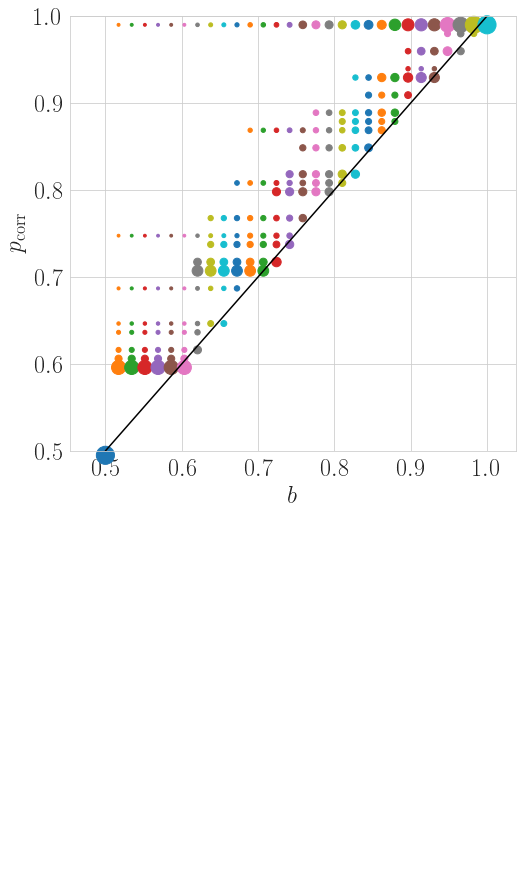

In [45]:
fig,ax=pl.subplots()
for bit,b in enumerate(bvec):
    ax.scatter(b*np.ones(nbins),np.linspace(0,1,nbins),s=b_counts[bit,:]/1e2,clip_on=False)
ax.plot(bvec,bvec,'k-')
ax.set_ylim([0.5,1])
ax.set_xlabel(r'$b$')
ax.set_ylabel(r'$p_{\textrm{corr}}$')

Discrepancy between mean of ratio and ratio of means

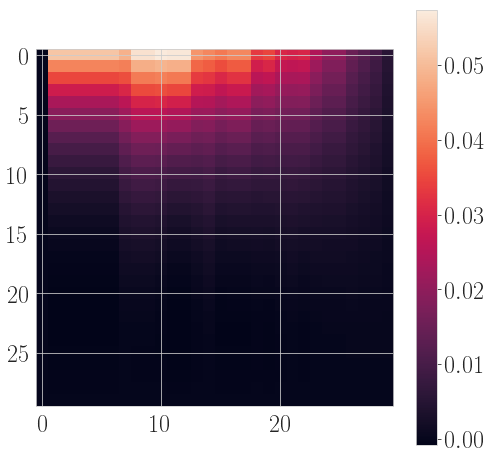

In [47]:
CS=pl.imshow(rewardvec_b_vec-(meanprob_b_vec[np.newaxis,:]/(phi_b_vec[np.newaxis,:]+gamma_vec[:,np.newaxis]*(1-phi_b_vec[np.newaxis,:])+T_IT/T)
))
pl.colorbar()

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


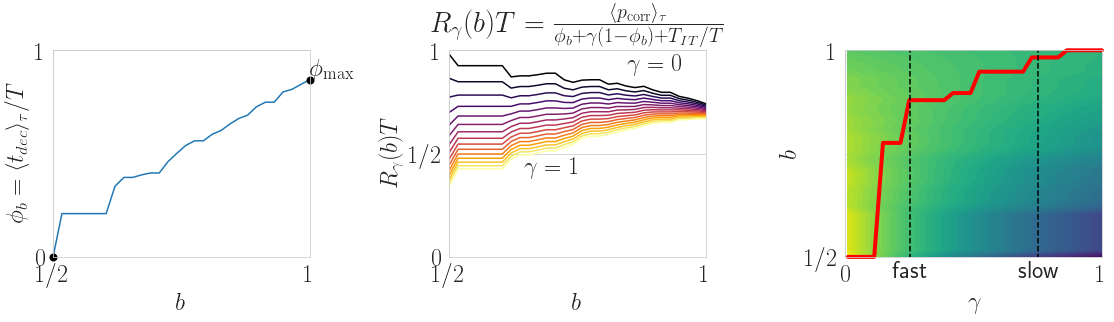

In [117]:
#setup

if False: #for P_corr=b version with fake :
#     gamma_vec=np.linspace(0.01,1,100)
#     bvec=np.linspace(0.5,1,100)
#     phi_max=0.8
#     phitmp=phi_max*2*(bvec-0.5)#np.exp(2*(bvec-0.5)-1)-np.exp(2*(bvec[0]-0.5)-1)
#     phi_b_vec=phi_max*phitmp/phitmp[-1]
    R=bvec[np.newaxis,:]/(phi_b_vec[np.newaxis,:]+gamma_vec[:,np.newaxis]*(1-phi_b_vec[np.newaxis,:])+T_IT/T)
else:
    R=rewardvec_b_vec
#     R=meanprob_b_vec[np.newaxis,:]/(phi_b_vec[np.newaxis,:]+gamma_vec[:,np.newaxis]*(1-phi_b_vec[np.newaxis,:])+T_IT/T)

    

R_tdec0=1/(2*(gamma_vec[:,np.newaxis]+T_IT/T))
bopt_vec=bvec[np.argmax(R.T,axis=0)]

fig,ax=pl.subplots(1,3,figsize=(16,5))

#reward
#over gamma
# ax[0].set_title(r'$R_\gamma(b)T=\frac{p_{\textrm{corr}}}{\phi_b+\gamma(1-\phi_b)+T_{IT}/T}$')
# ax[0].plot(gamma_vec,R_tdec0,'k-')
# colors=pl.cm.inferno(np.linspace(0,1,len(bvec)))
# for it,row in enumerate(R.T):
#     ax[0].plot(gamma_vec,row,'-',color=colors[it])
# ax[0].plot([1,1,0],[1/2/(1+T_IT/T),1/(1+T_IT/T),R[0,-1]],'ko',clip_on=False)
# ax[0].text(1.05,1/2/(1+T_IT/T),r'$b=1/2$',horizontalalignment='left')
# ax[0].text(1.05,1/(1+T_IT/T),r'$b=1$',horizontalalignment='left')
# ax[0].set_xticks([0,1/4,1/2,3/4,1.0])
# ax[0].set_yticks([0,0.5,1.0,R[0,-1]])
# ax[0].set_yticklabels(['$0$','$1/2$','$1$',r'$\frac{p_{\textrm{corr}}}{\phi_b+T_{IT}/T}$'])
# ax[0].set_xticklabels(['$0$','fast',r'$1/2$','slow','$1$'])
# ax[0].text(0.7,0.2,r'$\frac{1}{2(\gamma+T_{IT}/T)}$',horizontalalignment='center')
# ax[0].text(0.7,0.8,r'$\frac{1}{\phi_{\textrm{max}}+\gamma(1-\phi_{\textrm{max}})+T_{IT}/T}$',horizontalalignment='center')
# ax[0].set_xlim(0,1)
# ax[0].set_ylim(0,1)
# ax[0].set_ylabel(r'$R_\gamma(b)T$')
# ax[0].set_xlabel('$\gamma$') #wrong! Tdec=0 allowed for full range of gamma

#over beta
ax[1].set_title(r'$R_\gamma(b)T=\frac{\langle p_{\textrm{corr}}\rangle_{\tau}}{\phi_b+\gamma(1-\phi_b)+T_{IT}/T}$')
# ax[0].plot(gamma_vec,R_tdec0,'k-')
colors=pl.cm.inferno(np.linspace(0,1,len(gamma_vec)/2))
for it,row in enumerate(R[::2,:]):
    ax[1].plot(bvec,row,'-',color=colors[it])
# ax[0].plot([1,1,0],[1/2/(1+T_IT/T),1/(1+T_IT/T),R[0,-1]],'ko',clip_on=False)
# ax[0].text(1.05,1/2/(1+T_IT/T),r'$b=1/2$',horizontalalignment='left')
# ax[0].text(1.05,1/(1+T_IT/T),r'$b=1$',horizontalalignment='left')
ax[1].set_xticks([0.5,1.0])
ax[1].set_yticks([0,0.5,1.0])
ax[1].set_yticklabels(['$0$','$1/2$','$1$'])
ax[1].set_xticklabels(['$1/2$','$1$'])
ax[1].text(0.7,0.4,r'$\gamma=1$',horizontalalignment='center')
ax[1].text(0.9,0.9,r'$\gamma=0$',horizontalalignment='center')
ax[1].set_xlim(0.5,1)
ax[1].set_ylim(0,1)
ax[1].set_ylabel(r'$R_\gamma(b)T$')
ax[1].set_xlabel('$b$') #wrong! Tdec=0 allowed for full range of gamma


#inset
# rect = [0.45,0.15,0.3,0.3]
# ax[0] = add_subplot_axes(ax[0],rect)
ax[0].plot(bvec,phi_b_vec)
ax[0].plot([bvec[0],bvec[-1]],[phi_b_vec[0],phi_b_vec[-1]],'ko',clip_on=False)
ax[0].text(bvec[-1],phi_b_vec[-1],r'$\phi_{\textrm{max}}$')
ax[0].set_xticks([0.5,1])
ax[0].set_xticklabels([r'$1/2$',r'$1$'])
ax[0].set_yticks([0,1])
ax[0].set_xlim([0.5,1])
ax[0].set_ylim([0,1])
ax[0].set_ylabel(r'$\phi_b=\langle t_{dec}\rangle_{\tau} /T$')
ax[0].set_xlabel(r'$b$')

#phase diagram
CS=ax[2].contourf(gamma_vec,bvec,np.log10(R).T,60,cmap=pl.cm.viridis)
# ax[2].text(0.6,0.75,r'$b_{opt}$',color='r',horizontalalignment='center',fontsize=48)
ax[2].set_xticks([0,0.25,0.5,0.75,1.0])
ax[2].set_yticks([0.5,0.75,1.0])
ax[2].set_xticklabels(['$0$','','','','$1$'])
ax[2].set_yticklabels(['$1/2$','','$1$'])
ax[2].plot(gamma_vec,bopt_vec,'r-',lw=4,clip_on=False)
ax[2].plot([gamma_fast,gamma_fast],[0,1],'k--')
ax[2].plot([gamma_slow,gamma_slow],[0,1],'k--')
ax[2].text(gamma_fast,0.45,'fast',horizontalalignment='center')
ax[2].text(gamma_slow,0.45,'slow',horizontalalignment='center')
# ax[2].text(1.0,1.0,r'$\phi_b=\phi_{max}$',horizontalalignment='center',color='r')
# ax[2].text(0.1,0.51,r'$\phi_b=0$',horizontalalignment='center',color='r')
ax[2].set_xlim(0,1)
ax[2].set_ylim(0.5,1)
ax[2].set_ylabel(r'$b$')
ax[2].set_xlabel('$\gamma$') 
fig.tight_layout()
fig.savefig('accuracy_bound_model.png', transparent=True,bbox_inches="tight",dpi=300)
    

Responce time distributions for optimal b in fast and slow

In [11]:
bopt_fastslow=[0.879,0.983]

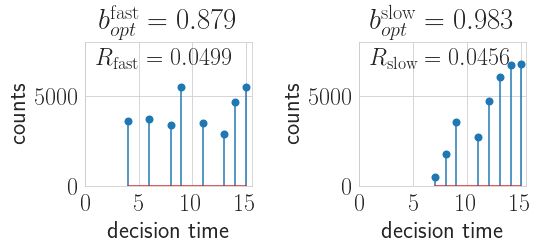

In [16]:
fig,ax=pl.subplots(1,2,figsize=(8,4))
strvec=['fast','slow']
dfb=df_traj.copy()
bopt_fastslow=[0.879,0.983]
for git,gamma in enumerate([gamma_fast,gamma_slow]):
#     bopt=bopt_vec[np.argmin(np.fabs(gamma_vec-gamma))]
    bopt=bopt_fastslow[git]
    dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=bopt)[0][0] if np.where(x>=bopt)[0].size else T)
    dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-bopt)[0][0] if np.where(x<=1-bopt)[0].size else T)
    dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
    reward_rate=dfb.prob_corr_at_tdec.mean()/(dfb.tb.mean()+gamma*(T-dfb.tb.mean())+T_IT)
    
    ax[git].text(1,65e2,r'$R_\textrm{'+str(strvec[git])+'}='+str(round(reward_rate*10000)/10000)+'$')
    ax[git].stem(dfb.tb.value_counts().index.values, dfb.tb.value_counts().values)
    ax[git].set_title(r'$b_{opt}^{\mathrm{'+strvec[git]+'}}='+str(round(bopt*1000)/1000)+'$')
    ax[git].set_ylabel('counts')
    ax[git].set_xlabel('decision time')
    ax[git].set_xticks([0,5,10,15])
    ax[git].set_ylim(0,8000)
#     ax[git].set_yticks([0,1e4,2e4])
#     ax[git].set_ylim(0,2e4)
fig.tight_layout()
# fig.savefig('optimal_response_time_distributions.png', transparent=True,bbox_inches="tight",dpi=300)

Compute reward rate

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide


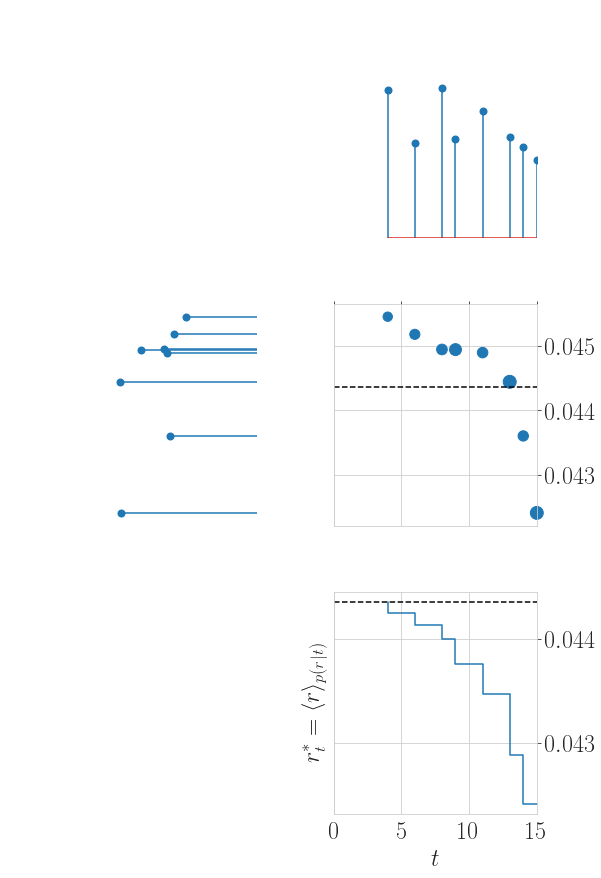

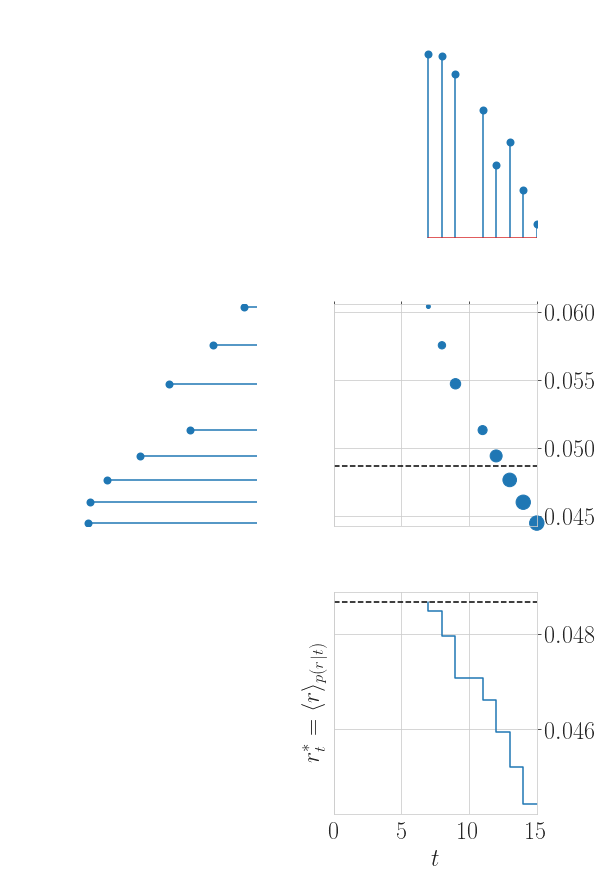

In [13]:
# fig,ax=pl.subplots(3,2,figsize=(8,4))
# fig2,ax2=pl.subplots(1,2,figsize=(8,4))
# fig3,ax3=pl.subplots(1,2,figsize=(8,4))
# fig4,ax4=pl.subplots(1,2,figsize=(8,4))
# fig5,ax5=pl.subplots(1,2,figsize=(8,4))
# fig6,ax6=pl.subplots(1,2,figsize=(8,4))
# fig7,ax7=pl.subplots(1,2,figsize=(8,4))
dfb=df_traj.copy()
T_IT=T_ITI
setstr='expmax'
# setstr='expinv'
strvec=['slow','fast']
bigR_store=[]
tvals_store=[]
post_store=[]
for git,gamma in enumerate([gamma_slow,gamma_fast]):
    fig,ax=pl.subplots(3,2,figsize=(8,12))
   #     bopt=bopt_vec[np.argmin(np.fabs(gamma_vec-gamma))]
    bopt=bopt_fastslow[git]
    dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=bopt)[0][0] if np.where(x>=bopt)[0].size else T)
    dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-bopt)[0][0] if np.where(x<=1-bopt)[0].size else T)
    dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
    dfb['reward']=dfb.prob_corr_at_tdec/(dfb.tb+gamma*(T-dfb.tb)+T_IT)
    
    posterior_mean=dfb.reward.mean()
    posterior_median=dfb.reward.median()
    prob=dfb.reward.value_counts()/len(dfb)
    r_vals=prob.index.sort_values().values
    posterior=prob[prob.index.sort_values()].values
    t_vals=dfb.tb.value_counts().index.sort_values().values
#     prob_invest=np.exp(-(np.max(r_vals)-r_vals)/posterior_mean)
#     bigR=-(np.max(r_vals)-np.min(r_vals))/(r_vals-np.min(r_vals))+1

#     prob_invest/=np.sum(prob_invest)
#     expected_prob_invest=np.sum(prob_invest*posterior)
#     bigR_store.append(prob_invest)
    
    #posterior mean estiamte
    posterior_expected_reward_rate=np.zeros(r_vals.shape)
    for rit,r in enumerate(r_vals):
        posterior_expected_reward_rate[rit]=np.sum(r_vals[:rit+1]*posterior[:rit+1]/np.sum(posterior[:rit+1])) 
    ax[2,1].step(t_vals,posterior_expected_reward_rate[::-1],where='pre',clip_on=False)
    ax[2,1].plot([0,T],[posterior_mean,posterior_mean],'k--')
    ax[2,1].set_ylabel(r'$r^*_t=\langle r \rangle_{p(r|t)}$')
    ax[2,1].set_xlabel(r'$t$')
    ax[2,1].set_xticks([0,5,10,15])
    ax[2,1].set_xlim(0,15)
    ax[2,1].yaxis.tick_right()
    ax[0,0].axis('off')
    ax[2,0].axis('off')
    
    
    ax[1,1].scatter(t_vals,r_vals[::-1],s=posterior[::-1]*1000,clip_on=False)
    ax[1,1].yaxis.tick_right()
    ax[1,1].set_xticks([0,5,10,15])
    ax[1,1].set_xticklabels([])
#     ax[1,1].set_title(r'$t_\text{dec}$')
    ax[1,1].xaxis.tick_top()
    ax[1,1].set_xlim(0,T)
    ax[1,1].plot([0,15],[posterior_expected_reward_rate[-1],posterior_expected_reward_rate[-1]],'k--')
    
    ax[1,1].set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)
#     ax[0,1].plot(ax[1,1].get_xlim(),[dfb.reward.median(),dfb.reward.median()],'k--')
#     ax[1,1].set_xlabel(r'$t_{dec}$')
#     ax[1,1].set_ylabel(r'reward rate')
#     ax[0,1].set_ylim(0.6,0.95)
    
    p=ax[0,1].stem(t_vals,posterior)
#     ax[0,1].set_xlabel(r'$t_{dec}$')
    ax[0,1].set_ylabel('frequency')
    ax[0,1].set_xlim(0,15)
    ax[0,1].set_ylim(0,0.25)
    ax[0,1].set_xticks([])
    ax[0,1].axis('off')
    
    ax[1,0].set_yticks([])
    ax[1,0].hlines(r_vals, 0, posterior,color=p[-2][0].get_color())  # Stems
#     col=pl.gca()[0][0].get_color()
    ax[1,0].plot(posterior, r_vals, 'o',p[-2][0].get_color())  # Stem ends
#     ax[git].stem(r_vals, posterior)
#     ax[0,0].set_title(r'$b_{opt}^{\mathrm{'+strvec[git]+'}}='+str(round(bopt*1000)/1000)+'$')
    ax[1,0].set_xlabel('frequency')
    ax[1,0].set_ylabel('reward rate')
    ax[1,0].set_ylim(np.min(r_vals)-0.0002,np.max(r_vals)+0.0002)
    ax[1,0].set_xlim(0,0.25)
    ax[1,0].invert_xaxis()
    ax[1,0].axis('off')
#     rvec=np.linspace(r_vals[0]-(r_vals[1]-r_vals[0])/2,r_vals[1]+(r_vals[1]-r_vals[0])/2,100)
    
#     posterior_survfunc=1-np.cumsum(posterior[::-1]) #starting low to high: S(t)=Prob[actual_reward_rate>reward_rate(t)]
#     ax[2,1].step(np.insert(t_vals,0,0),np.insert(posterior_survfunc,0,1),where='post',clip_on=False)
#     ax[2,1].set_ylabel(r'$S(t)$')#r'$r^*_t=\langle r \rangle_{p(r|t)}$')
#     ax[2,1].set_xlabel(r'$t$')
#     ax[2,1].set_xticks([0,5,10,15])
#     ax[2,1].set_ylim(0,1)
    
    #posterior mean estiamte
    posterior_expected_reward_rate=np.zeros(r_vals.shape)
    for rit,r in enumerate(r_vals):
        posterior_expected_reward_rate[rit]=np.sum(r_vals[:rit+1]*posterior[:rit+1]/np.sum(posterior[:rit+1])) 
    tvals_store.append(t_vals)
    post_store.append(posterior_expected_reward_rate[::-1])
    
    bigR=-(np.max(posterior_expected_reward_rate)-np.min(posterior_expected_reward_rate))/(posterior_expected_reward_rate-np.min(posterior_expected_reward_rate))+1
    prob_invest=np.exp(bigR)
    bigR_store.append(bigR)
#     posterior_expected_prob_invest=np.zeros(r_vals.shape)
#     for rit,r in enumerate(r_vals):
#         posterior_expected_prob_invest[rit]=np.sum(prob_invest[:rit+1]*posterior[:rit+1]/np.sum(posterior[:rit+1]))    
#     ax6[git].step(t_vals,posterior_expected_prob_invest[::-1],where='pre',clip_on=False)
#     ax6[git].plot([0,T],[expected_prob_invest,expected_prob_invest],'k--')
#     ax6[git].set_ylabel(r'$p^{i}(r^*_t)$')
#     ax6[git].set_xlabel(r'$t$')
#     ax6[git].set_xticks([0,5,10,15])
    
#     ax4[git].set_ylim(0,1)
    
#     ax4 = ax3[git].twiny()
#     new_tick_locations = np.array([.4, .5, .6])
#     def tick_function(X):
#         V = 1/(1+X)
#         return ["%.3f" % z for z in V]
#     ax4.set_xlim(ax3[git].get_xlim())
#     ax4.set_xticks(new_tick_locations)
#     ax4.set_xticklabels(tick_function(new_tick_locations))
    
#     ax5[git].stem(prob_invest, posterior)
#     ax5[git].set_title(r'$b_{opt}^{\mathrm{'+strvec[git]+'}}='+str(round(bopt*1000)/1000)+'$')
#     ax5[git].set_ylabel('frequency')
#     ax5[git].set_xlabel(r'$p^i$')
#     ax5[git].set_ylim(0,0.3)

    fig.tight_layout(pad=0)
    fig.savefig('reward_distributions_'+strvec[git]+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

    #Urgency
#     fig1,ax1=pl.subplots(1,1,figsize=(6,6))

#     prob_p=np.zeros((T+1,T+1))
#     for Nm in np.arange(0,2*(T+1),2):
#         for Np in np.arange(0,2*(T+1),2):
#             t=(Np+Nm)/2
#             Nt=(Np-Nm)/2
#             prob_p[int(Nm/2),int(Np/2)]=get_pt_plus(t,Nt)
# #     rel_est=(posterior_expected_reward_rate-np.min(posterior_expected_reward_rate))/(np.max(posterior_expected_reward_rate)-np.min(posterior_expected_reward_rate))
#     for Nm in 2*np.arange(T):
#         ax1.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     for Np in 2*np.arange(T):
#         ax1.plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt)) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
# #     ax1.step(np.insert(t_vals,0,0),np.insert(rel_est[::-1],0,1),where='post',clip_on=False)
#     ax1.step(t_vals,bopt*prob_invest[::-1],where='post',clip_on=False)
#     # ax.step(np.insert(t_vals,0,0),bopt*np.insert(posterior_survfunc,0,1),where='post',clip_on=False)
# #     ax1.plot([0,T],[bopt,bopt],'k--')
#     ax1.set_xlabel(r'time, $t$')
#     ax1.set_ylim(0,1)
#     ax1.set_xticks([0,5,10,15])
#     # ax.plot(np.arange(6),p*(1+p**2*np.arange(6)),'k-')
#     ax1.grid('off')
#     fig1.savefig('new_boundary_'+strvec[git]+'.png', transparent=True,dpi=300,bbox_inches='tight')


# fig.savefig('optimal_reward_distributions_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
#  
# fig2.tight_layout()
# fig3.tight_layout()
# fig4.tight_layout()
# fig5.tight_layout()
# fig6.tight_layout()
# fig.savefig('optimal_reward_distributions_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig2.savefig('optimal_reward_tdec_correlation_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig4.savefig('reward_estimate_accmodel_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig6.savefig('invest_estimate_accmodel_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig5.savefig('investprob_hist_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)

In [174]:
# bigR_store[0][0]=-6
# bigR_store[1][0]=-6
bigR_store[0][0]=-np.Inf
bigR_store[1][0]=-np.Inf

In [181]:
tvals_store

[array([ 4,  6,  8,  9, 11, 13, 14, 15], dtype=int64),
 array([ 7,  8,  9, 11, 12, 13, 14, 15], dtype=int64)]

In [182]:
bigR_store

[array([       -inf, -3.17234689, -0.83139124, -0.44403157, -0.22353216,
        -0.12936995, -0.05724191,  0.        ]),
 array([       -inf, -4.5498624 , -1.80488521, -0.94656307, -0.60333425,
        -0.20222942, -0.04570703,  0.        ])]

In [198]:
# if t<=tvals_store[it][0]:
#         Rvaltmp=bigR_store[it][0]
#         print(t)
#     else:
#         print(tvals_store[it][np.where(np.logical_and(tvals_store[it][1:]>t,tvals_store[it][:-1]<=t))[0][0]])
#         Rvaltmp=bigR_store[it][np.where(np.logical_and(tvals_store[it][1:]>t,tvals_store[it][:-1]<=t))]

bigR_store_t=[]
for it in range(2):
    tmpbigR=np.zeros(T+1)
    for t in range(16):
        if t<=tvals_store[it][0]:
            tmpbigR[t]=bigR_store[it][::-1][0]
        else:
            tmpind=np.where(np.logical_and(tvals_store[it][1:]>t,tvals_store[it][:-1]<=t))[0]
            if tmpind:
                tmpbigR[t]=bigR_store[it][::-1][tmpind[0]]
            else:
                tmpbigR[t]=bigR_store[it][::-1][0]
    bigR_store_t.append(tmpbigR)

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  app.launch_new_instance()


In [197]:
bigR_store_t=[]

(0, 5)

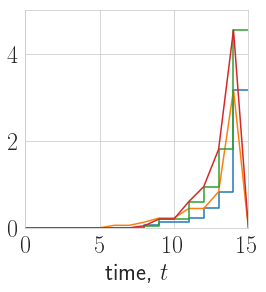

In [199]:
fig1,ax1=pl.subplots(figsize=(4,4))
# ax1.step(np.insert(t_vals,0,0),-np.log(np.insert(prob_invest[::-1],0,1)),where='post')
for it in range(2):
    ax1.step(np.insert(t_vals,0,0),np.insert(-bigR_store[it][::-1],0,0),where='post')
    ax1.plot(range(T+1),-bigR_store_t[it])
#     ax1.set_ylim(0,1)
    # ax.step(np.insert(t_vals,0,0),bopt*np.insert(posterior_survfunc,0,1),where='post',clip_on=False)
    #     ax1.plot([0,T],[bopt,bopt],'k--')
    ax1.set_xlabel(r'time, $t$')
    # ax1.set_ylim(0,5)
    ax1.set_xticks([0,5,10,15])
    # ax.plot(np.arange(6),p*(1+p**2*np.arange(6)),'k-')
#     ax1.grid('off')
ax1.set_xlim(0,15)
ax1.set_ylim(0,5)
# fig1.savefig('urgency.pdf', transparent=True,bbox_inches="tight",dpi=300)

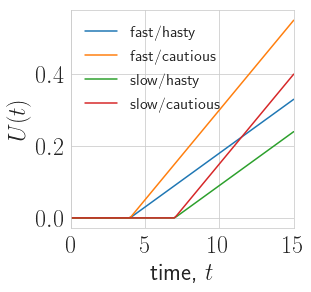

In [223]:
fig,ax=pl.subplots(figsize=(4,4))
# ax1.step(np.insert(t_vals,0,0),-np.log(np.insert(prob_invest[::-1],0,1)),where='post')
tminvec=[4,7]
r_avgvec=[0.03,0.05]
tstrvec=['fast','slow']
tavgstrvec=['hasty','cautious']
for it in range(2):
    for rit in range(2):
        timevec=np.linspace(0,15,100)
        Urg=r_avgvec[rit]*(timevec-tminvec[it])
        Urg[timevec<tminvec[it]]=0

        ax.plot(timevec,Urg,label=tstrvec[it]+'/'+tavgstrvec[rit])
ax.legend(frameon=False,fontsize=16)
ax.set_xlabel(r'time, $t$')
ax.set_xticks([0,5,10,15])
    # ax.plot(np.arange(6),p*(1+p**2*np.arange(6)),'k-')
#     ax1.grid('off')
ax.set_xlim(0,15)
# ax1.set_ylim(0,5)
ax.set_ylabel(r'$U(t)$')
fig.savefig('urgency_priors.pdf', transparent=True,bbox_inches="tight",dpi=300)

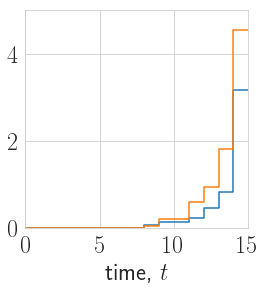

In [16]:
fig1,ax1=pl.subplots(figsize=(4,4))
# ax1.step(np.insert(t_vals,0,0),-np.log(np.insert(prob_invest[::-1],0,1)),where='post')
for it in range(2):
    ax1.step(np.insert(t_vals,0,0),np.insert(-bigR_store[it][::-1],0,0),where='post')
    ax1.plot(range(T+1),bigR_Store_t[it])
#     ax1.set_ylim(0,1)
    # ax.step(np.insert(t_vals,0,0),bopt*np.insert(posterior_survfunc,0,1),where='post',clip_on=False)
    #     ax1.plot([0,T],[bopt,bopt],'k--')
    ax1.set_xlabel(r'time, $t$')
    # ax1.set_ylim(0,5)
    ax1.set_xticks([0,5,10,15])
    # ax.plot(np.arange(6),p*(1+p**2*np.arange(6)),'k-')
#     ax1.grid('off')
ax1.set_xlim(0,15)
ax1.set_ylim(0,5)
fig1.savefig('urgency.pdf', transparent=True,bbox_inches="tight",dpi=300)

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDe

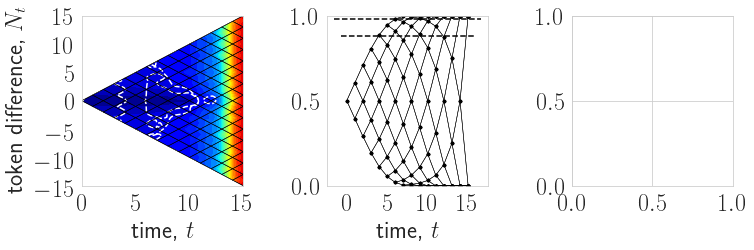

In [173]:
fig,ax=pl.subplots(1,3,figsize=(11,4))
for it in range(2):
    bound=bopt_fastslow[it]
    prob_p=np.zeros((T+1,T+1))
    for Nm in np.arange(0,2*(T+1),2):
        for Np in np.arange(0,2*(T+1),2):
            t=(Np+Nm)/2
            Nt=(Np-Nm)/2
            if t<=tvals_store[it][0]:
                Rvaltmp=bigR_store[it][::-1][0]
            else:
#                 print(t)
                indtmp=np.where(np.logical_and(tvals_store[it][1:]>t,tvals_store[it][:-1]<=t))[0]
#                 print(indtmp)
                if indtmp:
                    Rvaltmp=bigR_store[it][::-1][indtmp[0]]
                else:
                    Rvaltmp=bigR_store[it][::-1][-1]
            if get_pt_plus(t,Nt)>=0.5:
#                 prob_p[int(Nm/2),int(Np/2)]=np.log(2*get_pt_plus(t,Nt)-1)-Rvaltmp
                prob_p[int(Nm/2),int(Np/2)]=np.log(get_pt_plus(t,Nt))-Rvaltmp
            elif get_pt_plus(t,Nt)<0.5:
#                 prob_p[int(Nm/2),int(Np/2)]=np.log(2*(1-get_pt_plus(t,Nt))-1)-Rvaltmp
                prob_p[int(Nm/2),int(Np/2)]=np.log(1-get_pt_plus(t,Nt))-Rvaltmp
            else:
                prob_p[int(Nm/2),int(Np/2)]=-2-Rvaltmp
#     for Nm in np.arange(0,2*(T+1),2):
#                 prob_p[int(Nm/2),int(Nm/2)]=(prob_p[int(Nm/2),int(Nm/2)]+prob_p[int(Nm/2),int(Nm/2)])/2

    from scipy.interpolate import griddata
    mesh=np.meshgrid(range(T+1),range(T+1))
    Npvec=mesh[0].flatten()
    Nmvec=mesh[1].flatten()
    tvec=Npvec+Nmvec
    Nvec=Npvec-Nmvec

    tvecdense=np.linspace(min(tvec),max(tvec),100)
    Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
    z=griddata((tvec,Nvec),prob_p.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
    if it==1:
        CS=ax[0].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet)
    ax[0].set_xlim(0,T)

    for Nm in 2*np.arange(T):
        ax[0].plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
        ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
    for Np in 2*np.arange(T):
        ax[0].plot(np.arange(T+1-Np/2)+Np/2,Np/2-np.arange(T+1-Np/2),'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
        ax[1].plot(np.arange(T+1-Np/2)+Np/2,[1-get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')

#     CS=ax[0].contour(tvecdense,Nvecdense,z,[np.log(2*bound-1)],colors='k',linestyles='--')
    CS=ax[0].contour(tvecdense,Nvecdense,z,[np.log(bound)],colors='w',linestyles='--')
    # ax[0].plot([7.5,15],[8,0],'k--',linewidth=2)
    ax[0].grid('off')

    ax[0].set_ylabel(r'token difference, $N_t$')
    ax[0].set_xlabel(r'time, $t$')

    ax[1].plot(ax[1].get_xlim(),[bound,bound],'k--',clip_on=False)
    ax[1].set_xlabel(r'time, $t$')
    ax[1].set_xticks([0,5,10,15])
    ax[1].set_ylim(0,1)
    # ax[1].plot(np.arange(6),p*(1+p**2*np.arange(6)),'k-')
    ax[1].grid('off')
    ax[0].set_xticks([0,5,10,15])
    ax[0].set_yticks([-15,-10,-5,0,5,10,15])
# fig.suptitle('$\mathrm{Prob}(\mathrm{Right}|N_t=n)$',y=1.01)



#response times
reward_rate_slow=dfb.prob_corr_at_tdec.mean()/(dfb.tb.mean()+gamma_slow*(T-dfb.tb.mean())+T_ITI)
reward_rate_fast=dfb.prob_corr_at_tdec.mean()/(dfb.tb.mean()+gamma_fast*(T-dfb.tb.mean())+T_ITI)

# #dfb.tb.hist(ax=ax[2],bins=np.arange(T+2)-0.5)
# counts,bins=np.histogram(dfb.tb.values,bins=np.arange(T+2)-0.5)
# ax[2].stem(np.arange(T+1),counts)
# ax[2].set_clip_on(False)
# ax[2].set_ylabel('counts')
# ax[2].set_xlabel('decision time')
# ax[2].set_xticks([0,5,10,15])
# ax[2].set_yticks([0,1e4,2e4])
# ax[2].set_xlim(0,15)
# ax[2].set_ylim(0,1e4)
# # ax[2].text(4,1e4,r'$R_\textrm{slow}='+str(round(reward_rate_slow*10000)/10000)+'$')
# # ax[2].text(4,6e3,r'$R_\textrm{fast}='+str(round(reward_rate_fast*10000)/10000)+'$')
fig.tight_layout()
# fig.savefig('prob_map_optpR.pdf', transparent=True,dpi=300,bbox_inches='tight')

Write code to compute decision boundary:

In [128]:
it=0
for t in range(16):
    if t<=tvals_store[it][0]:
        Rvaltmp=bigR_store[it][-1]
        print(t)
    else:
        print(tvals_store[it][np.where(np.logical_and(tvals_store[it][1:]>t,tvals_store[it][:-1]<=t))[0][0]])
        Rvaltmp=bigR_store[it][::-1][np.where(np.logical_and(tvals_store[it][1:]>t,tvals_store[it][:-1]<=t))]

0
1
2
3
4
4
6
6
8
9
9
11
11
13
14


IndexError: index 0 is out of bounds for axis 0 with size 0

In [245]:
tvals_store[0]<5

array([ True, False, False, False, False, False, False, False])

In [ ]:
tvals_store[0]<5

ValueError: x and y must have same first dimension, but have shapes (16,) and (1,)

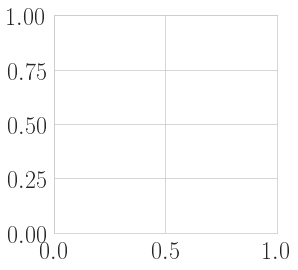

In [152]:
fig,ax=pl.subplots(1,1,figsize=(4,4))
timevec=range(16)
ax.plot(timevec,1/(t+gamma_slow*(T-t)+T_ITI))
ax.plot(timevec,1/(t+gamma_fast*(T-t)+T_ITI))

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


ValueError: setting an array element with a sequence.

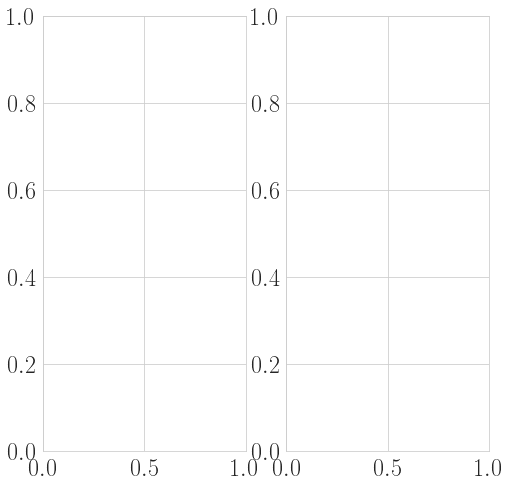

In [240]:
fig,ax=pl.subplots(1,2)
for it in range(2):
    for Nm in 2*np.arange(T):
        datam=np.asarray([get_pt_plus(15,t,Nt)/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
    #     ax[1].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
    #     datam=np.asarray([get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2)])
        datam=[]
        for t,Nt in zip(np.arange(Nm/2,T+1-Nm/2)+Nm/2,np.arange(Nm/2,T+1-Nm/2)-Nm/2):
            if t<=tvals_store[it][0]:
                datam.append(bigR_store[it][0])
            else:
                datam.append(bigR_store[it][np.where(np.logical_and(tvals_store[it][1:]>t,tvals_store[it][:-1]<=t))])
    #             datam.append(get_pt_plus(15,t,Nt))
        #     ax[1].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,(2*datam-1)/(2*bound-1),'o-',ms=3,lw=0.5,color='r',mew=0.5,mfc='r',mec='r',clip_on=False)
    #     r_scale=(datam-dmin)/(dmax-dmin)
    #     Rsubj=-r_scale**(-1)+1
    #     Probi=np.exp(Rsubj)
        ax[0].plot(np.arange(Nm/2,T+1-Nm/2)+Nm/2,datam,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)

    for Np in 2*np.arange(T-7):
    #     datap=np.asarray([(1-get_pt_plus(15,t,Nt))/(t+gamma*(T-t)+T_ITI) for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2)])

    #     ax[1].plot(np.arange(Np/2+1)+Np/2,Probi,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
        datap=[]
        for t,Nt in zip(np.arange(Np/2+1)+Np/2,np.arange(Np/2+1)-Np/2):
            if t<=tmin:
                datap.append(np.log(2*(1-get_pt_plus(15,t,Nt))-1))
    #             datap.append(1-get_pt_plus(15,t,Nt))
            else:
                datap.append(np.log(2*(1-get_pt_plus(15,t,Nt))-1)+ravg*(t-tmin))
    #             datap.append(1-get_pt_plus(15,t,Nt))
    #     r_scale=(datap-dmin)/(dmax-dmin)
    #     Rsubj=-r_scale**(-1)+1
    #     Probi=np.exp(Rsubj)
    #     ax[1].plot(np.arange(Np/2+1)+Np/2,(2*datap-1)/(2*bound-1),'o-',ms=3,lw=0.5,color='r',mew=0.5,mfc='r',mec='r',clip_on=False)
        ax[0].plot(np.arange(Np/2+1)+Np/2,datap,'o-',ms=3,lw=0.5,color=[0.8,0.8,0.8],mew=0.5,mfc=[0.8,0.8,0.8],mec=[0.8,0.8,0.8],clip_on=False)
    ax[0].plot(np.arange(16),np.log(2*bound-1)*np.ones(16),'k--')
    ax[0].plot(np.arange(16),bigR_store[it],'k-')

In [ ]:
fig,ax=pl.subplots(2,1)
for it in range(2):
    ax[0].step(t_vals,post_store[it],where='pre',clip_on=False)
    ax[0].plot([0,T],[post_store[it][0],post_store[it][0]],'k--')
    ax[0].step(t_vals,post_store[it],where='pre',clip_on=False)
    ax[0].plot([0,T],[post_store[it][0],posterior[it][0]],'k--')
    ax[1].step(t_vals,-bigR_store[it])
ax[0].set_ylabel(r'$r^*_t=\langle r \rangle_{p(r|t)}$')
ax[0].set_xlabel(r'$t$')
ax[0].set_xticks([0,5,10,15])

In [ ]:
# fig,ax=pl.subplots(3,2,figsize=(8,4))
# fig2,ax2=pl.subplots(1,2,figsize=(8,4))
# fig3,ax3=pl.subplots(1,2,figsize=(8,4))
# fig4,ax4=pl.subplots(1,2,figsize=(8,4))
# fig5,ax5=pl.subplots(1,2,figsize=(8,4))
# fig6,ax6=pl.subplots(1,2,figsize=(8,4))
# fig7,ax7=pl.subplots(1,2,figsize=(8,4))

setstr='expmax'
setstr='expinv'
strvec=['slow','fast']
for git,gamma in enumerate([gamma_slow,gamma_fast]):
    fig,ax=pl.subplots(2,3,figsize=(8,12))
   #     bopt=bopt_vec[np.argmin(np.fabs(gamma_vec-gamma))]
    bopt=bopt_fastslow[git]
    dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=bopt)[0][0] if np.where(x>=bopt)[0].size else T)
    dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-bopt)[0][0] if np.where(x<=1-bopt)[0].size else T)
    dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
    dfb['reward']=dfb.prob_corr_at_tdec/(dfb.tb+gamma*(T-dfb.tb)+T_IT)
    
    posterior_mean=dfb.reward.mean()
    posterior_median=dfb.reward.median()
    prob=dfb.reward.value_counts()/len(dfb)
    r_vals=prob.index.sort_values().values
    posterior=prob[prob.index.sort_values()].values
    t_vals=dfb.tb.value_counts().index.sort_values().values
#     prob_invest=np.exp(-(np.max(r_vals)-r_vals)/posterior_mean)
    prob_invest=np.exp(-(posterior_mean-np.min(r_vals))/(r_vals-np.min(r_vals))+1)
#     prob_invest/=np.sum(prob_invest)
#     expected_prob_invest=np.sum(prob_invest*posterior)
 
    
    ax[0,0].axis('off')
    ax[2,0].axis('off')
    ax[1,0].yaxis.tick_right()
    ax[1,0].hlines(r_vals, 0, posterior)  # Stems
#     col=pl.gca()[0][0].get_color()
    ax[1,0].plot(posterior, r_vals, 'o')  # Stem ends
#     ax[git].stem(r_vals, posterior)
    ax[1,0].set_title(r'$b_{opt}^{\mathrm{'+strvec[git]+'}}='+str(round(bopt*1000)/1000)+'$')
    ax[1,0].set_xlabel('frequency')
    ax[1,0].set_ylabel('reward rate')
    ax[1,0].set_ylim(0.6,0.95)
    ax[1,0].set_xlim(0,0.25)
    ax[1,0].invert_xaxis()
    
    ax[1,1].scatter(t_vals,r_vals[::-1],s=posterior*1000,clip_on=False)
    ax[1,1].set_xlim(0,T)
    ax[1,1].plot(ax[1,1].get_xlim(),[dfb.reward.median(),dfb.reward.median()],'k--')
    ax[1,1].set_xlabel(r'$t_{dec}$')
    ax[1,1].set_ylabel(r'reward rate')
    ax[1,1].set_ylim(0.6,0.95)
    
#     rvec=np.linspace(r_vals[0]-(r_vals[1]-r_vals[0])/2,r_vals[1]+(r_vals[1]-r_vals[0])/2,100)
    
    posterior_survfunc=1-np.cumsum(posterior[::-1]) #starting low to high: S(t)=Prob[actual_reward_rate>reward_rate(t)]
    ax[2,1].step(np.insert(t_vals,0,0),np.insert(posterior_survfunc,0,1),where='post',clip_on=False)
    ax[2,1].set_ylabel(r'$S(t)$')#r'$r^*_t=\langle r \rangle_{p(r|t)}$')
    ax[2,1].set_xlabel(r'$t$')
    ax[2,1].set_xticks([0,5,10,15])
    ax[2,1].set_ylim(0,1)
    
    #posterior mean estiamte
    posterior_expected_reward_rate=np.zeros(r_vals.shape)
    for rit,r in enumerate(r_vals):
        posterior_expected_reward_rate[rit]=np.sum(r_vals[:rit+1]*posterior[:rit+1]/np.sum(posterior[:rit+1])) 
    ax[0,1].step(t_vals,posterior_expected_reward_rate[::-1],where='pre',clip_on=False)
    ax[0,1].plot([0,T],[posterior_mean,posterior_mean],'k--')
    ax[0,1].set_ylabel(r'$r^*_t=\langle r \rangle_{p(r|t)}$')
    ax[0,1].set_xlabel(r'$t$')
    ax[0,1].set_xticks([0,5,10,15])
    
    
#     posterior_expected_prob_invest=np.zeros(r_vals.shape)
#     for rit,r in enumerate(r_vals):
#         posterior_expected_prob_invest[rit]=np.sum(prob_invest[:rit+1]*posterior[:rit+1]/np.sum(posterior[:rit+1]))    
#     ax6[git].step(t_vals,posterior_expected_prob_invest[::-1],where='pre',clip_on=False)
#     ax6[git].plot([0,T],[expected_prob_invest,expected_prob_invest],'k--')
#     ax6[git].set_ylabel(r'$p^{i}(r^*_t)$')
#     ax6[git].set_xlabel(r'$t$')
#     ax6[git].set_xticks([0,5,10,15])
    
#     ax4[git].set_ylim(0,1)
    
#     ax4 = ax3[git].twiny()
#     new_tick_locations = np.array([.4, .5, .6])
#     def tick_function(X):
#         V = 1/(1+X)
#         return ["%.3f" % z for z in V]
#     ax4.set_xlim(ax3[git].get_xlim())
#     ax4.set_xticks(new_tick_locations)
#     ax4.set_xticklabels(tick_function(new_tick_locations))
    
#     ax5[git].stem(prob_invest, posterior)
#     ax5[git].set_title(r'$b_{opt}^{\mathrm{'+strvec[git]+'}}='+str(round(bopt*1000)/1000)+'$')
#     ax5[git].set_ylabel('frequency')
#     ax5[git].set_xlabel(r'$p^i$')
#     ax5[git].set_ylim(0,0.3)

#     fig.tight_layout()
    fig.savefig('reward_distributions_'+strvec[git]+'_'+setstr+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

    
    fig1,ax1=pl.subplots(1,1,figsize=(6,6))

    prob_p=np.zeros((T+1,T+1))
    for Nm in np.arange(0,2*(T+1),2):
        for Np in np.arange(0,2*(T+1),2):
            t=(Np+Nm)/2
            Nt=(Np-Nm)/2
            prob_p[int(Nm/2),int(Np/2)]=get_pt_plus(t,Nt)
#     rel_est=(posterior_expected_reward_rate-np.min(posterior_expected_reward_rate))/(np.max(posterior_expected_reward_rate)-np.min(posterior_expected_reward_rate))
    for Nm in 2*np.arange(T):
        ax1.plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
    for Np in 2*np.arange(T):
        ax1.plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt)) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     ax1.step(np.insert(t_vals,0,0),np.insert(rel_est[::-1],0,1),where='post',clip_on=False)
    ax1.step(t_vals,bigR,where='post',clip_on=False)
    # ax.step(np.insert(t_vals,0,0),bopt*np.insert(posterior_survfunc,0,1),where='post',clip_on=False)
#     ax1.plot([0,T],[bopt,bopt],'k--')
    ax1.set_xlabel(r'time, $t$')
    ax1.set_ylim(0,1)
    ax1.set_xticks([0,5,10,15])
    # ax.plot(np.arange(6),p*(1+p**2*np.arange(6)),'k-')
    ax1.grid('off')
    fig1.savefig('new_boundary_'+strvec[git]+'.png', transparent=True,dpi=300,bbox_inches='tight')

# fig2.tight_layout()
# fig3.tight_layout()
# fig4.tight_layout()
# fig5.tight_layout()
# fig6.tight_layout()
# fig.savefig('optimal_reward_distributions_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig2.savefig('optimal_reward_tdec_correlation_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig4.savefig('reward_estimate_accmodel_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig6.savefig('invest_estimate_accmodel_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)
# fig5.savefig('investprob_hist_'+setstr+'.png', transparent=True,bbox_inches="tight",dpi=300)

In [90]:
rmin=np.min(posterior_expected_reward_rate)
rmax=np.max(posterior_expected_reward_rate)
prob_invest=np.exp(-(rmax-rmin)/(posterior_expected_reward_rate-rmin)+1)

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

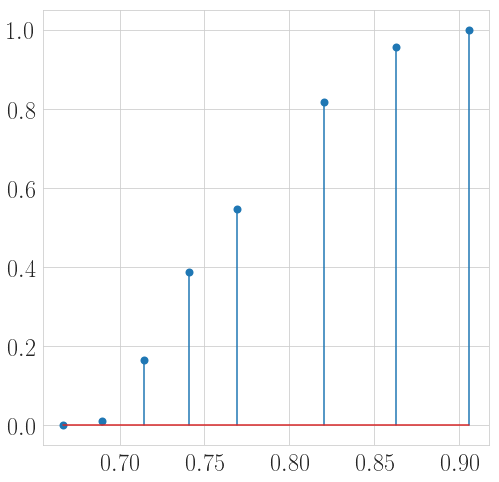

In [91]:
fig,ax=pl.subplots()
ax.stem(r_vals,prob_invest)

Compute decision rule for a specific bound.

In [12]:
dfp=df_traj.copy()

dfp['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)
dfp['reward_p']=dfp.Pt_plus.apply(lambda x: np.asarray([rel_est[::-1][np.argmin(np.fabs(t-t_vals))]*xval for t,xval in enumerate(x)]))
dfp['reward_m']=dfp.Pt_plus.apply(lambda x: np.asarray([rel_est[::-1][np.argmin(np.fabs(t-t_vals))]*(1-xval) for t,xval in enumerate(x)]))


NameError: name 'rel_est' is not defined

In [13]:
# #create index over a mtrix of statesset of states
# rel_est=(posterior_expected_reward_rate-np.min(posterior_expected_reward_rate))/(np.max(posterior_expected_reward_rate)-np.min(posterior_expected_reward_rate))
#     for Nm in 2*np.arange(T):
#         ax1.plot(np.arange(T+1-Nm/2)+Nm/2,[rel_est[::-1][np.argmin(np.fabs(t-t_vals))]*get_pt_plus(15,t,Nt) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     for Np in 2*np.arange(T):
#         ax1.plot(np.arange(T+1-Np/2)+Np/2,[rel_est[::-1][np.argmin(np.fabs(t-t_vals))]*(1-get_pt_plus(15,t,Nt)) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')

df_s=pd.DataFrame(index=pd.MultiIndex.from_product([range(T+1),range(T+1)]))
df_s['Nt']=[int(inds[0]-inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s['t']=[int(inds[0]+inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s=df_s.drop(df_s[df_s.t>T].index) #drop rows having time>T 
df_s=df_s.drop((0,0))
df_s['Pt_plus']=df_s.apply(lambda x: get_pt_plus(T,x.t,x.Nt),axis=1) #add success probability
df_s['reward_p']=df_s.apply(lambda x:  rel_est[::-1][np.argmin(np.fabs(x.t-t_vals))]*x.Pt_plus,axis=1) #add reward
df_s['reward_m']=df_s.apply(lambda x:  rel_est[::-1][np.argmin(np.fabs(x.t-t_vals))]*(1-x.Pt_plus),axis=1) #add reward

NameError: ("name 'rel_est' is not defined", 'occurred at index (0, 1)')

In [99]:
np.where(dec_plus==0)

(array([ 0,  8, 10, 11, 12, 13, 14], dtype=int64),)

In [103]:
np.where(dec_plus==0)[0][1]

8

In [104]:
dec_plus[np.where(dec_plus==0)[0][1]:]=0
dec_minus[np.where(dec_minus==0)[0][1]:]=0

In [1]:
fig,ax=pl.subplots(1,1,figsize=(4,4))
ax.plot(np.arange(T),dec_plus)
ax.plot(np.arange(T),dec_minus)
for Np in range(T+1):
    for Nm in range(T+1):
        if Np+Nm< T+1:
            ax.scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
ax.set_ylim(-15,15)
ax.set_xlim(0,15)
ax.set_yticks([-15,-10,-5,0,5,10,15])
ax.set_ylabel(r'token difference, $N_t$')
ax.set_xlabel(r'time, $t$')

NameError: name 'pl' is not defined

Text(0.5, 0, 'time, $t$')

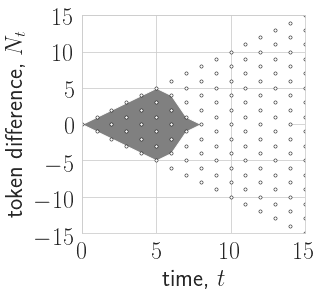

In [141]:
fig,ax=pl.subplots(1,1,figsize=(4,4))
ax.fill_between(np.arange(T),dec_plus,dec_minus,facecolor='gray')
for Np in range(T+1):
    for Nm in range(T+1):
        if Np+Nm< T+1:
            ax.scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
ax.set_ylim(-15,15)
ax.set_xlim(0,15)
ax.set_yticks([-15,-10,-5,0,5,10,15])
ax.set_ylabel(r'token difference, $N_t$')
ax.set_xlabel(r'time, $t$')

## Neural Heuristic Solution

Assumes shifted exponential bound crossing distribution

show theory and data collapse of choice of r:

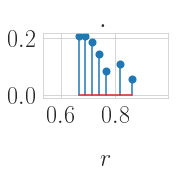

In [116]:
fig,ax=pl.subplots(1,1,figsize=(3,3))
r_vec=np.linspace(np.min(r_vals),np.max(r_vals),100)
# t_bmin_test=4.3
r_test=r_vals[6]
surv_func_theory=np.ones(r_vec.shape)
surv_func_theory[r_vec>r_test]=0
# ax.plot(time_vec,surv_func_theory,'k-')
ax.stem(r_vals[r_vals<=r_test],posterior[r_vals<=r_test])
# ax.plot(r_vec[r_vals>r_test],posterior[r_vals>r_test],'k-',clip_on=False)
# ax.plot(r_vec[r_vals<=r_test][-1]*np.ones(2),[1,0],'k--')
ax.set_xlabel(r'$r$',labelpad=20)
ax.set_title(r'$.$')
# ax.set_xticks([0,5,10,15])
# ax.set_xticklabels([])
# ax.set_yticks([0,1])
ax.set_xlim([0.8*np.min(r_vals),1.1*np.max(r_vals)])
# ax.set_ylim([0,1])
# ax.text(t_bmin_test-0.8,-0.29,r'$t_r$')
fig.tight_layout()
fig.savefig('reward_survfunc_high.png', transparent=True,dpi=300,bbox_inches='tight')


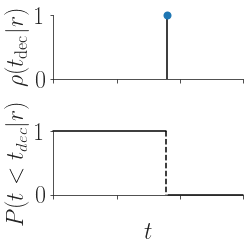

In [287]:
fig,ax=pl.subplots(2,1,figsize=(4,4))
time_vec=np.linspace(0,15,100)
# t_bmin_test=4.3
t_bmin_test=9
r_test=0.4
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=0
# ax.plot(time_vec,surv_func_theory,'k-')
ax[0].plot([t_bmin_test]*2,[0,1],'k-')
ax[0].plot([t_bmin_test],[1],'o',clip_on=False)
ax[0].grid(None)
# ax[0].plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
# ax[0].plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
# ax[0].set_xlabel(r'$t$',labelpad=20)
ax[0].set_ylabel(r'$\rho(t_\textrm{dec}|r)$')
# ax[0].set_title(r'$.$')
ax[0].set_xticks([0,5,10,15])
ax[0].set_xticklabels([])
ax[0].set_yticks([0,1])
ax[0].set_xlim([0,T])
ax[0].set_ylim([0,1])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
ax[1].plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
ax[1].plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
ax[1].set_xlabel(r'$t$',labelpad=20)
ax[1].set_ylabel(r'$P(t<t_{dec}|r)$')
ax[1].set_xticks([0,5,10,15])
ax[1].set_xticklabels([])
ax[1].set_yticks([0,1])
ax[1].set_xlim([0,T])
ax[1].set_ylim([0,1])
ax[1].grid(None)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# ax.text(t_bmin_test-0.8,-0.29,r'$t_{\text{dec$')
fig.tight_layout()
fig.savefig('survfunc_high.pdf', transparent=True,dpi=300,bbox_inches='tight')


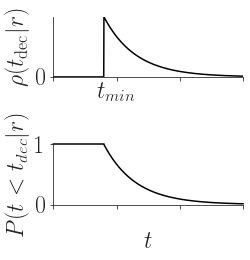

In [286]:
time_vec=np.linspace(0,15,1000)
# t_bmin_test=4.3
t_bmin_test=7
r_test=0.4
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))

fig,ax=pl.subplots(2,1,figsize=(4,4))
time_vec=np.linspace(0,15,1000)
# t_bmin_test=4.3
t_bmin_test=4
r_test=0.4
surv_func_theory=np.zeros(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
ax[0].plot(time_vec,surv_func_theory,'k-')
# ax[0].stem([t_bmin_test],[1],'k-')
ax[0].set_clip_on('False')
# ax[0].plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
# ax[0].plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
# ax[0].set_xlabel(r'$t$',labelpad=20)
ax[0].set_ylabel(r'$\rho(t_\textrm{dec}|r)$')
# ax[0].set_title(r'$.$')
# ax[0].text(3,-0.7,r'$t_{min}$')
ax[0].set_xticks([0,5,10,15])
ax[0].set_xticklabels(['',r'$t_{min}$','',''])
ax[0].set_yticks([0])
ax[0].set_xlim([0,T])
ax[0].set_ylim([0,1])
ax[0].grid(None)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))

ax[1].plot(time_vec[time_vec<=t_bmin_test],surv_func_theory[time_vec<=t_bmin_test],'k-',clip_on=False)
ax[1].plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
# ax[1].plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
ax[1].set_xlabel(r'$t$',labelpad=20)
ax[1].set_ylabel(r'$P(t<t_{dec}|r)$')
ax[1].set_xticks([0,5,10,15])
ax[1].set_xticklabels([])
ax[1].set_yticks([0,1])
ax[1].set_xlim([0,T])
ax[1].set_ylim([0,1])
ax[1].grid(None)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
# ax.text(t_bmin_test-0.8,-0.29,r'$t_{\text{dec$')
fig.tight_layout()
fig.savefig('survfunc_high_partial.pdf', transparent=True,dpi=300,bbox_inches='tight')


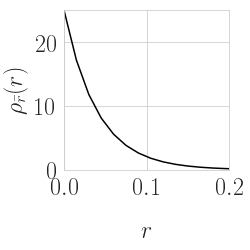

In [54]:
fig,ax=pl.subplots(1,1,figsize=(4,4))
r_vec=np.linspace(0,15,1000)
rbar=0.04
ax.plot(r_vec,np.exp(-r_vec/rbar)/rbar,'k-')
# ax[0].stem([t_bmin_test],[1],'k-')
ax.set_clip_on('False')
# ax[0].plot(time_vec[time_vec>t_bmin_test],surv_func_theory[time_vec>t_bmin_test],'k-',clip_on=False)
# ax[0].plot(time_vec[time_vec<=t_bmin_test][-1]*np.ones(2),[1,0],'k--')
ax.set_xlabel(r'$r$',labelpad=20)
ax.set_ylabel(r'$\rho_{\bar{r}}(r)$')
# ax[0].set_title(r'$.$')
# ax[0].set_xticks([0,5,10,15])
# ax[0].set_xticklabels([])
# ax[0].set_yticks([0,1])
ax.set_xlim([0,0.2])
ax.set_ylim([0,25])
fig.tight_layout()
fig.savefig('reward_prior.pdf', transparent=True,dpi=300,bbox_inches='tight')


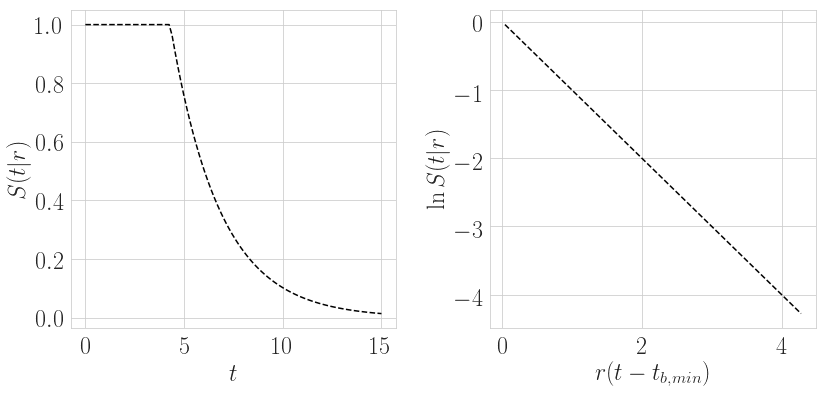

In [323]:
fig,ax=pl.subplots(1,2,figsize=(12,6))
time_vec=np.linspace(0,15,100)
t_bmin_test=4.3
r_test=0.4
surv_func_theory=np.ones(time_vec.shape)
surv_func_theory[time_vec>t_bmin_test]=np.exp(-r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test))
ax[0].plot(time_vec,surv_func_theory,'k-')
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$S(t|r)$')

ax[1].plot(r_test*(time_vec[time_vec>t_bmin_test]-t_bmin_test),np.log(surv_func_theory[time_vec>t_bmin_test]),'k--')
ax[1].set_xlabel(r'$r(t-t_{b,min})$')
ax[1].set_ylabel(r'$\ln S(t|r)$')

fig.tight_layout()

In [ ]:
fisher info of b optimization is what gives policy it's stochasticity...

(0, 10)

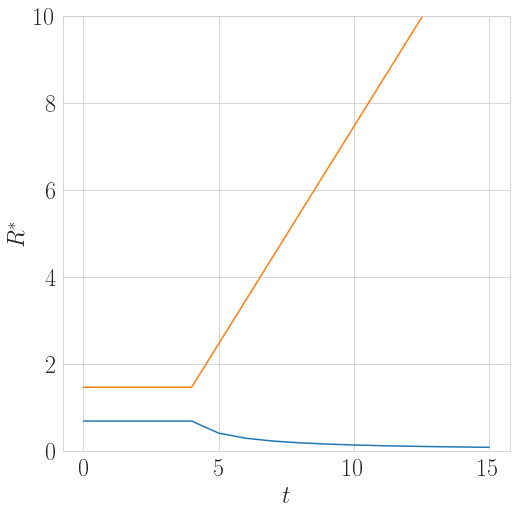

In [200]:
fig,ax=pl.subplots()
tbmin=4
posterior_mean_est=posterior_mean*np.concatenate((np.ones(tbmin+1),1/(1+posterior_mean*(np.arange(tbmin+1,T+1)-tbmin))))
ax.plot(np.arange(T+1),posterior_mean_est)
ax.plot(np.arange(T+1),1/posterior_mean_est)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$R^*$')   
ax.set_ylim(0,10)

In [ ]:
fig, ax=pl.subplots()
posterior_mean=dfb.reward.mean()
posterior=dfb.reward.value_counts()
r_vals=dfb.reward.value_counts().index
posterior_survfunc=1-np.cumsum(posterior) #starting low to high: S(t)=Prob[actual_reward_rate>reward_rate(t)]
expected_reward_rate=np.zeros(r_vals.shape)
for rit,r in enumerate(r_vals):
    expected_reward_rate[rit]=np.sum(r_vals[:rit]*posterior[:rit]) 

tcrit=tdec[np.argmin(posterior_survfunc<pthresh)]
ax.plot(tdec,posterior_prob)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 0, '$t_{dec}$')

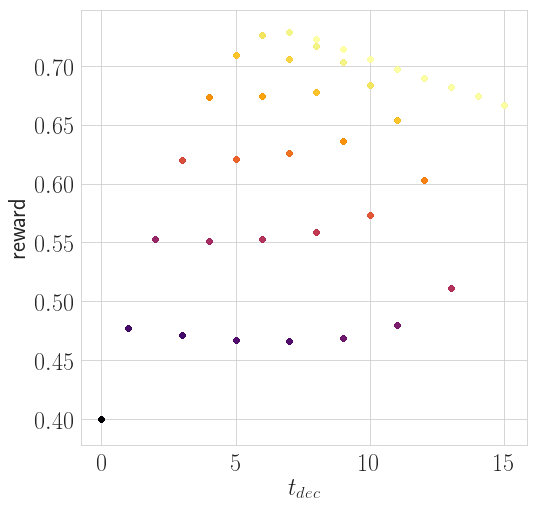

In [116]:
fig,ax=pl.subplots()
colors=pl.cm.inferno(np.linspace(0,1,len(bvec)))
for it,b in enumerate(bvec):
    dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else T)
    dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
    dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1) 
    dfb['reward']=dfb.prob_corr_at_tdec/(dfb.tb/T+gamma*(1-dfb.tb/T)+T_IT/T)
    dfb.plot.scatter(x='tb',y='reward',ax=ax,color=colors[it])
ax.set_xlabel(r'$t_{dec}$')

Idea is: as time goes on and the distribution of future trajectories narrows, so too does the distribution of possible reward rates with the posterior mean going down in time, such that the agent should never wait beyond the point where the probability that the reward rate will be above the mean of the full ensemble falls below some criterion (e.g. left: criteria=> at 0). Ok so this is clear with full knowledge of reward rates and how they relate to crossing times. In this case the optimal strategy is obtained over the joint optimization of b and null_prob for fixed T_IT and gamma. But agent won't know this a priori. so what can it do: take general form for P(r) using only some intrinsic value mean to serve as a prior. Observation model is P(t|r), survival probability given reward rate is r. computed from some . Use to compute posterior of reward rate. FOr fully unbiased, get hyperbolic discounting. For uniform get exponential  Intrinsic scale of reward rate will be different for different monkeys: new preference parameter.  How to infer reward? posterior reward distribution at t is just the set for t_b>t. Exploit decision times that have strong negative correlation with reward rate (at least for high b). Define observation model of t_cross given reward rate: see e.g.

How to scale tdec of bound model to avoid investing in hard trials



In [ ]:
#How to compute reward rate just from occupancy probabilities (pascal's triangle)

Assume hyperbolic and plot

C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


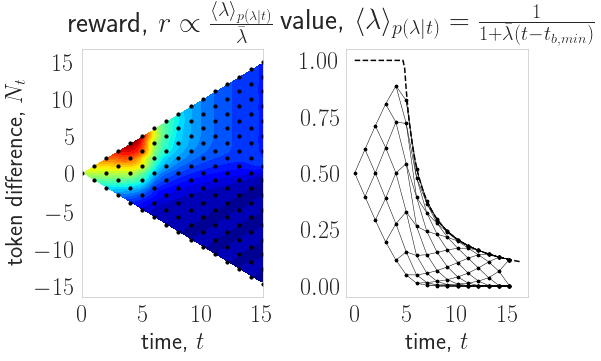

In [102]:
fig,ax=pl.subplots(1,2,figsize=(8,5))
lamb_mean=0.75#dfp.lamb.mean()
bound=0.9
p=0.5
prob_p=np.zeros((16,16))
bound_fn=1.5/(p**3)*(bound-p)
for Nm in np.arange(0,2*(T+1),2):
    for Np in np.arange(0,2*(T+1),2):
        t=(Np+Nm)/2
        Nt=(Np-Nm)/2
        prob_p[int(Nm/2),int(Np/2)]=get_pt_plus(15,t,Nt)/T*(np.heaviside(bound_fn-t,1)+np.heaviside(t-bound_fn,1)/(1+lamb_mean*(t-bound_fn))) #if t>4 else get_pt_plus(15,t,Nt)
#         prob_p[int(Nm/2),int(Np/2)]=get_pt_plus(15,t,Nt)*(np.heaviside(2*bound-t,1)/Tdur+np.heaviside(t-2*bound,1)/(Tdur+t-2*bound)) if t>4 else get_pt_plus(15,t,Nt)
        
from scipy.interpolate import griddata
mesh=np.meshgrid(range(16),range(16))
Npvec=mesh[0].flatten()
Nmvec=mesh[1].flatten()
tvec=Npvec+Nmvec
Nvec=Npvec-Nmvec

tvecdense=np.linspace(min(tvec),max(tvec),100)
Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
z=griddata((tvec,Nvec),prob_p.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

CS=ax[0].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet)
CS=ax[0].contour(tvecdense,Nvecdense,z,[bound],colors='k',linestyles='--')
ax[0].set_xlim(0,15)

for Nm in 2*np.arange(T):
#     ax[0].plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
    ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)*(np.heaviside(bound_fn-t,1)+np.heaviside(t-bound_fn,1)/(1+lamb_mean*(t-bound_fn))) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)*(np.heaviside(2*bound-t,1)/Tdur+np.heaviside(t-2*bound,1)/(Tdur+t-2*bound)) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
#     ax[0].plot(np.arange(T+1-Np/2)+Np/2,Np/2-np.arange(T+1-Np/2),'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
    ax[1].plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt))*(np.heaviside(bound_fn-t,1)+np.heaviside(t-bound_fn,1)/(1+lamb_mean*(t-bound_fn))) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     ax[1].plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt))*(np.heaviside(2*bound-t,1)/Tdur+np.heaviside(t-2*bound,1)/(Tdur+t-2*bound)) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
x=np.linspace(0,16,100)
ax[1].plot(x,np.heaviside(bound_fn-x,1)+np.heaviside(x-bound_fn,1)/(1+lamb_mean*(x-bound_fn)),'k--')
# ax[1].plot(x,np.heaviside(2*bound-x,1)/(Tdur)+np.heaviside(x-2*bound,1)/(Tdur+(x-2*bound)),'k--')                                      
ax[0].grid('off')
ax[1].grid('off')
ax[0].set_ylabel(r'token difference, $N_t$')
ax[0].set_xlabel(r'time, $t$')
# fig.suptitle('$\mathrm{Prob}(\mathrm{Right}|N_t=n)$',y=1.01)
ax[1].set_xlabel(r'time, $t$')
ax[1].set_xticks([0,5,10,15])
ax[0].set_xticks([0,5,10,15])
ax[0].set_yticks([-15,-10,-5,0,5,10,15])
fig.tight_layout()

for Nm in np.arange(0,2*(T+1),2):
    for Np in np.arange(0,2*(T+1),2):
        t=(Np+Nm)/2
        Nt=(Np-Nm)/2
        if t<16:
            ax[0].scatter(t,Nt,color='k',s=10)#60*prob_p[int(Nm/2),int(Np/2)])
fig.tight_layout()
ax[0].set_title(r'reward, $r\propto \frac{\langle\lambda\rangle_{p(\lambda|t)}}{\bar{\lambda}}$')
ax[1].set_title(r'value, $\langle\lambda\rangle_{p(\lambda|t)}=\frac{1}{1+\bar{\lambda}(t-t_{b,min})}$')
fig.savefig('prob_map_withcolor_discounted_b09_slow.png', transparent=True,dpi=300,bbox_inches='tight')
# for Np in 2*np.arange(T):
#     ax[0].plot(np.arange(T+1-Np/2)+Np/2,Np/2-np.arange(T+1-Np/2),'ko-',lw=0.5,color='k',mfc='w',mec='k',mew=0.5,ms=3)
    
#     ax[1].scatter(np.arange(T+1-Np/2)+Np/2,,'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='w',mec='k')


C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


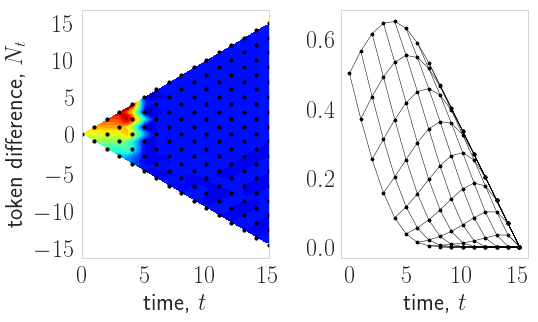

In [514]:
fig,ax=pl.subplots(1,2,figsize=(8,5))
lamb_mean=2#dfp.lamb.mean()
bound=0.9
p=0.5
gamma=1
bound_fn=0.5/(p**3)*(bound-p)


prob_p=np.zeros((16,16))
for Nm in np.arange(0,2*(T+1),2):
    for Np in np.arange(0,2*(T+1),2):
        t=(Np+Nm)/2
        Nt=(Np-Nm)/2
        prob_p[int(Nm/2),int(Np/2)]=get_pt_plus(15,t,Nt)/T*(np.heaviside(bound_fn-t,1)+np.heaviside(t-bound_fn,1)/(1+lamb_mean*(t-bound_fn))) if t>4 else get_pt_plus(15,t,Nt)
#         prob_p[int(Nm/2),int(Np/2)]=get_pt_plus(15,t,Nt)*(np.heaviside(2*bound-t,1)/Tdur+np.heaviside(t-2*bound,1)/(Tdur+t-2*bound)) if t>4 else get_pt_plus(15,t,Nt)
        
from scipy.interpolate import griddata
mesh=np.meshgrid(range(16),range(16))
Npvec=mesh[0].flatten()
Nmvec=mesh[1].flatten()
tvec=Npvec+Nmvec
Nvec=Npvec-Nmvec

tvecdense=np.linspace(min(tvec),max(tvec),100)
Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
z=griddata((tvec,Nvec),prob_p.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

CS=ax[0].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet)
CS=ax[0].contour(tvecdense,Nvecdense,z,[bound],colors='k',linestyles='--')
ax[0].set_xlim(0,15)

for Nm in 2*np.arange(T):
#     ax[0].plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
    ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)*gamma*(T-t)/T for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     ax[1].plot(np.arange(T+1-Nm/2)+Nm/2,[get_pt_plus(15,t,Nt)*(np.heaviside(2*bound-t,1)/Tdur+np.heaviside(t-2*bound,1)/(Tdur+t-2*bound)) for t,Nt in zip(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
for Np in 2*np.arange(T):
#     ax[0].plot(np.arange(T+1-Np/2)+Np/2,Np/2-np.arange(T+1-Np/2),'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
    ax[1].plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt))*gamma*(T-t)/T for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
#     ax[1].plot(np.arange(T+1-Np/2)+Np/2,[(1-get_pt_plus(15,t,Nt))*(np.heaviside(2*bound-t,1)/Tdur+np.heaviside(t-2*bound,1)/(Tdur+t-2*bound)) for t,Nt in zip(np.arange(T+1-Np/2)+Np/2,np.arange(T+1-Np/2)-Np/2)],'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='k',mec='k')
x=np.linspace(0,16,100)
# ax[1].plot(x,(np.heaviside(bound_fn-x,1)+np.heaviside(x-bound_fn,1)/(1+lamb_mean*(x-bound_fn)),'k--')
# ax[1].plot(x,np.heaviside(2*bound-x,1)/(Tdur)+np.heaviside(x-2*bound,1)/(Tdur+(x-2*bound)),'k--')                                      
ax[0].grid('off')
ax[1].grid('off')
ax[0].set_ylabel(r'token difference, $N_t$')
ax[0].set_xlabel(r'time, $t$')
# fig.suptitle('$\mathrm{Prob}(\mathrm{Right}|N_t=n)$',y=1.01)
ax[1].set_xlabel(r'time, $t$')
ax[1].set_xticks([0,5,10,15])
ax[0].set_xticks([0,5,10,15])
ax[0].set_yticks([-15,-10,-5,0,5,10,15])
fig.tight_layout()

for Nm in np.arange(0,2*(T+1),2):
    for Np in np.arange(0,2*(T+1),2):
        t=(Np+Nm)/2
        Nt=(Np-Nm)/2
        if t<16:
            ax[0].scatter(t,Nt,color='k',s=10)#60*prob_p[int(Nm/2),int(Np/2)])
fig.tight_layout()
# fig.savefig('prob_map_withcolor_discounted.png', transparent=True,dpi=300,bbox_inches='tight')

# for Np in 2*np.arange(T):
#     ax[0].plot(np.arange(T+1-Np/2)+Np/2,Np/2-np.arange(T+1-Np/2),'ko-',lw=0.5,color='k',mfc='w',mec='k',mew=0.5,ms=3)
    
#     ax[1].scatter(np.arange(T+1-Np/2)+Np/2,,'ko-',ms=3,lw=0.5,color='k',mew=0.5,mfc='w',mec='k')


When waiting fails to bring more than a desired threshold on information gain (As difference of entropies in resulting trajectory value density distributions (=log(number of trajectories left)/(max-min value)), then decide

Compute all trajectories

Analyze variation in bound

In [362]:
dfb=df_traj.copy()

In [293]:
reward_store=[]
corr_store=[]
T_trial_store=[]
gamma_vec=[0.01,0.25,0.75,1]

b=0.7
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)
dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)

for gamma in gamma_vec:
    dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1)
    dfb['T_trial']=dfb.apply(lambda row:row.tb+gamma*(T-row.tb),axis=1)
    dfb['reward_rate']=dfb['prob_corr_at_tdec']/dfb['T_trial']
    reward_store.append(dfb.reward_rate.mean())
    corr_store.append(dfb.prob_corr_at_tdec.mean())
    T_trial_store.append(dfb.T_trial.mean())

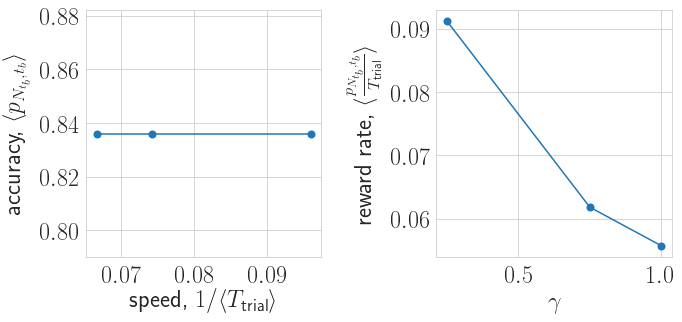

In [294]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
ax[0].plot(1/np.asarray(T_trial_store),corr_store,'o-')
ax[0].set_xlabel(r'speed, $1/\langle T_{\text{trial}}\rangle$')
ax[0].set_ylabel(r'accuracy, $\langle p_{N_{t_b},t_b}\rangle$')

ax[1].plot(gamma_vec,reward_store,'o-')
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'reward rate, $\langle \frac{p_{N_{t_b},t_b}}{T_{\text{trial}}}\rangle$')
fig.tight_layout()

Now vary in bound

In [447]:
reward_store=[]
reward_store_std=[]
corr_store=[]
T_trial_store=[]
bound_vec=np.linspace(0.5,1.0,15)
gamma=0.75
T_ITI=7.5
for b in bound_vec:
    dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else T)
    dfp.loc[~dfp.plus,'tb']=dfp.loc[~dfp.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
    dfb['prob_corr_at_tdec']=dfb.apply(lambda row:np.max([row.Pt_plus[row.tb],1-row.Pt_plus[row.tb]]),axis=1)
    dfb['T_trial']=dfb.apply(lambda row:row.tb+gamma*(T-row.tb)+T_ITI,axis=1)
    dfb['reward_rate']=dfb['prob_corr_at_tdec']/dfb['T_trial']
    reward_store.append(dfb.reward_rate.mean())
    reward_store_std.append(dfb.reward_rate.std())
    corr_store.append(dfb.prob_corr_at_tdec.mean())
    T_trial_store.append(dfb.T_trial.mean())

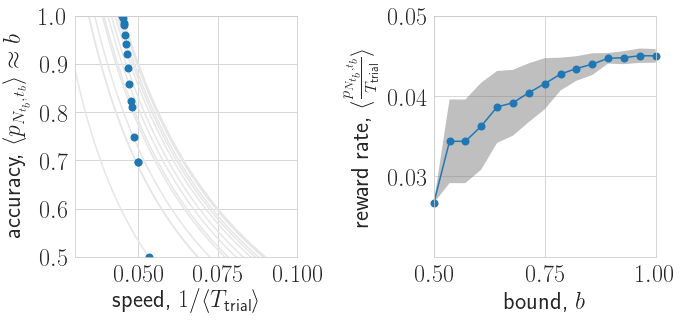

In [473]:
fig,ax=pl.subplots(1,2,figsize=(10,5))

for reward_rate in reward_store:
    trialvec=np.linspace(3e-2,1e-1,100)
    ax[0].plot(trialvec,reward_rate/trialvec,'-',color=[0.9,0.9,0.9])
ax[0].plot(1/np.asarray(T_trial_store),corr_store,'o')
# ax[0].set_xscale('log')
# ax[0].set_yscale('log')
ax[0].set_xlabel(r'speed, $1/\langle T_{\text{trial}}\rangle$')
ax[0].set_ylabel(r'accuracy, $\langle p_{N_{t_b},t_b}\rangle\approx b$')
ax[0].set_xlim(3e-2,1e-1)
ax[0].set_ylim(5e-1,1.0)
ax[1].plot(bound_vec,reward_store,'o-',clip_on=False)
ax[1].fill_between(bound_vec,np.asarray(reward_store)-np.asarray(reward_store_std),np.asarray(reward_store)+np.asarray(reward_store_std),alpha=0.5, edgecolor='None', facecolor='gray')
ax[1].set_xlabel(r'bound, $b$')
ax[1].set_ylabel(r'reward rate, $\langle \frac{p_{N_{t_b},t_b}}{T_{\text{trial}}}\rangle$')
ax[1].set_xlim([0.5,1.0])
ax[1].set_xticks([0.5,0.75,1.0])
#fast
# ax[1].set_ylim([0.035,0.055])
# ax[1].set_yticks([0.04,0.05])
#slow
ax[1].set_ylim([0.02,0.05])
ax[1].set_yticks([0.03,0.04,0.05])
fig.tight_layout()
fig.savefig('SAT_vary_bound_slow.pdf', transparent=True,dpi=300,bbox_inches='tight')

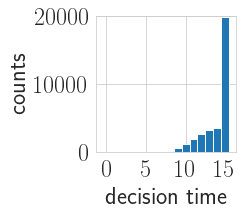

In [445]:
b_mon1=1.0
b=b_mon1
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else T)
dfp.loc[~dfp.plus,'tb']=dfp.loc[~dfp.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
fig,ax=pl.subplots(figsize=(2.5,2.5))
dfb.tb.hist(ax=ax,bins=np.arange(T+2)-0.5)
ax.set_ylabel('counts')
ax.set_xlabel('decision time')
ax.set_xticks([0,5,10,15])
ax.set_yticks([0,1e4,2e4])
ax.set_ylim(0,2e4)
fig.savefig('tdec_hist_perfect.pdf', transparent=True,dpi=300,bbox_inches='tight')

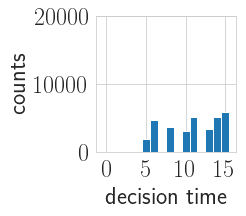

In [93]:
b_mon1=0.9
b=b_mon1
dfb['tb']=dfb.Pt_plus.apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else T)
dfb.loc[~dfb.plus,'tb']=dfb.loc[~dfb.plus,'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
fig,ax=pl.subplots(figsize=(2.5,2.5))
dfb.tb.hist(bins=np.arange(T+2)-0.5)
ax.set_ylabel('counts')
ax.set_xlabel('decision time')
ax.set_xticks([0,5,10,15])
ax.set_yticks([0,1e4,2e4])
ax.set_ylim(0,2e4)
fig.savefig('tdec_hist_b_09.pdf', transparent=True,dpi=300,bbox_inches='tight')

Now compute reward and decision times

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice.


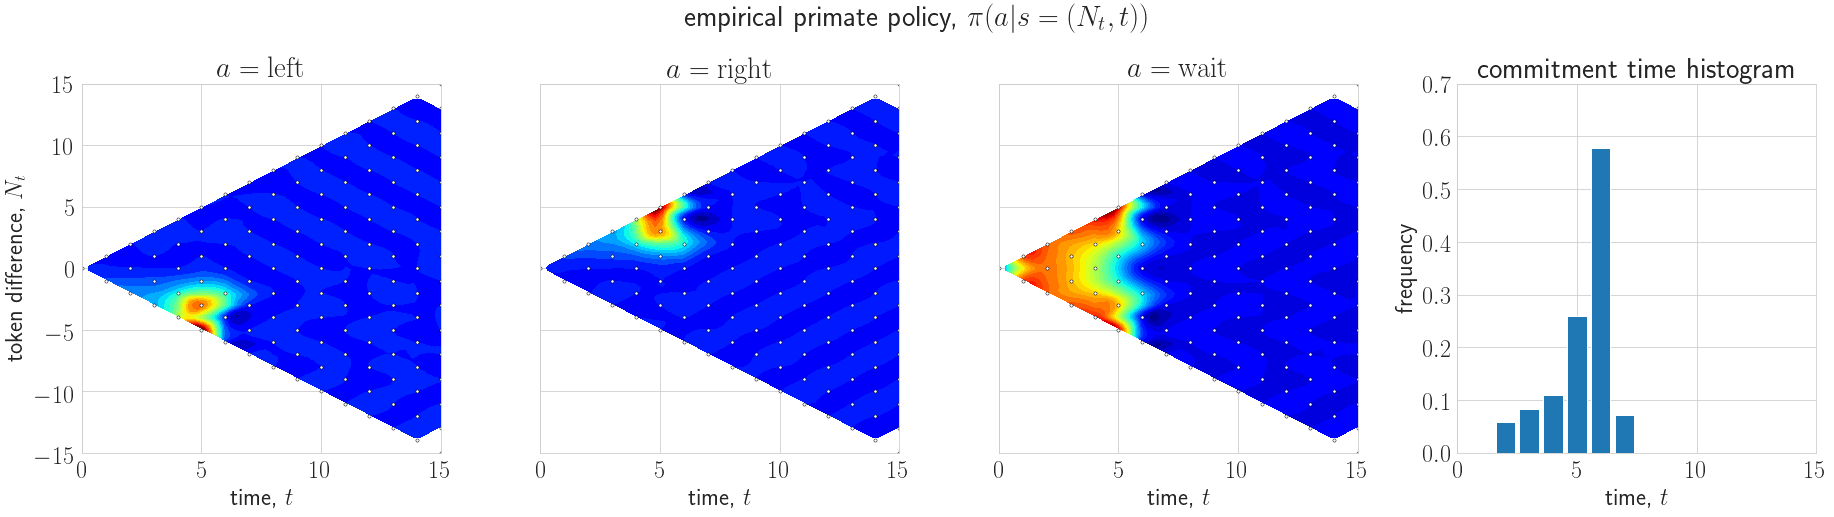

In [35]:
dfR=df_traj.copy()
lamb_mean=0.25#dfp.lamb.mean()
bound=0.85
p=0.5
prob_p=np.zeros((16,16))
bound_fn=1/(p**3)*(bound-p)
dfR['reward']=dfR.apply(lambda x:  x.Pt_plus*(np.heaviside(bound_fn-np.arange(16),1)+np.heaviside(np.arange(16)-bound_fn,1)/(1+lamb_mean*(np.arange(16)-bound_fn))),axis=1) #add reward  
dfR.loc[~dfR.plus,'reward']=dfR.apply(lambda x:  (1-x.Pt_plus)*(np.heaviside(bound_fn-np.arange(16),1)+np.heaviside(np.arange(16)-bound_fn,1)/(1+lamb_mean*(np.arange(16)-bound_fn))),axis=1) #add reward  
dfR['tDecision']=dfR.reward.apply(lambda x: np.argmax(x))
dfR['nChoiceMade']=dfR.apply(lambda x:x.Pt_plus[x.tDecision]>0.5,axis=1)
dfR['nChoiceCorrect']=dfR.seq.apply(lambda x:x[-1]>0)
plot_dec_times(dfR,pl,'design')

In [36]:
(dfR['nChoiceMade']==dfR['nChoiceCorrect']).mean()

0.57415771484375

In [40]:
gamma=0.25
dfR['reward_rate']=dfR.apply(lambda x:x.reward[x.tDecision]/(x.tDecision+gamma*(T-x.tDecision)),axis=1)

In [41]:
dfR.reward_rate.mean()

0.11389517026324547

In [42]:
(dfR['nChoiceMade']==dfR['nChoiceCorrect']).mean()/(dfR.tDecision+gamma*(T-dfR.tDecision)).mean()

0.08968400379443324

In [43]:
dfR.apply(lambda x:(x.nChoiceMade==x.nChoiceCorrect)/(x.tDecision+gamma*(T-x.tDecision)),axis=1).mean()

0.09567459495438099

Compute per-event $H(P_{T|t}^+)$ for all trajectories

In [104]:
def dummy2(row):
    return np.array([(0 if (p==0 or p==1) else (-p*np.log2(p)-(1-p)*np.log2(1-p))/(T+1-t)) for t,p in enumerate(row)])
df_traj['Hnorm']=df_traj.Pt_plus.apply(lambda x: dummy2(x))

plot

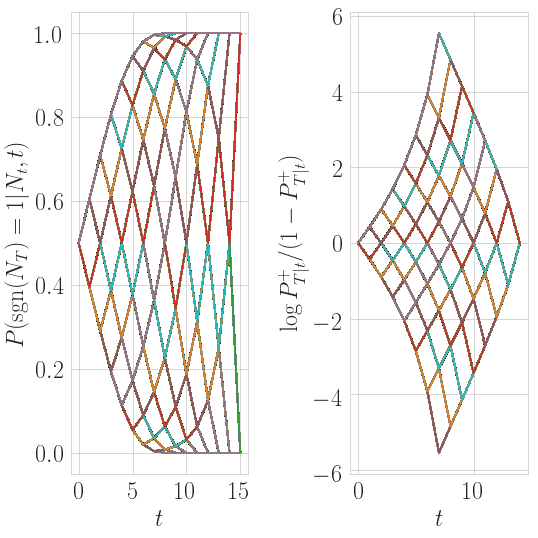

In [620]:
fig,ax=pl.subplots(1,2)#2,figsize=(8,4))
# ax.plot(np.arange(T+1),np.vstack(df[df['Nt'].apply(lambda x:x[-1])>0].Pt_plus.values).T);
ax[0].plot(np.arange(T+1),np.vstack(df_traj.Pt_plus.values).T);
ax[0].set_ylabel(r'$P(\textrm{sgn}(N_T)=1|N_t,t)$')
ax[0].set_xlabel(r'$t$')
ax[0].set_xticks([0,5,10,15])
# ax[0].set_title(r'trajectories ending in $N_T>0$')
ax[1].plot(np.arange(T+1),np.vstack(df_traj.evidence.values).T);
ax[1].set_ylabel(r'$\log P^+_{T|t}/(1-P^+_{T|t})$')
ax[1].set_xlabel(r'$t$')
#ax[1].plot(np.arange(T+1),np.vstack(df_traj.Hnorm.values).T,'.-');
#ax[1].set_ylabel(r'per-event $H(P^+_{T|t})$')

# ax.set_ylabel(r'$P^+_{T|t}$')
#ax[1].set_xlabel(r'$t$')
fig.tight_layout()

# ax[1].set_title(r'trajectories ending in $N_T>0$')
# fig,ax=pl.subplots(1,1)
# ax.plot(np.arange(T+1),np.vstack(df.H.values).T,'.-');
# ax.set_ylabel(r'per-event $I(N_T>0;N_t)$')
# ax.set_xlabel(r'$t$')
# ax.set_title(r'trajectories ending in $N_T>0$')

# fig.savefig('state_probspace.png',transparent=True,bbox_inches='tight')

Nnow, analyze tral value statistics

In [532]:
lamb_mean=2#dfp.lamb.mean()
bound=0.9
p=0.5
bound_fn=0.5/(p**3)*(bound-p)

dfp=df_traj.copy()

dfp['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)
# gamma=0.25
dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x))
dfp.loc[~dfp.plus,'lamb']=dfp.loc[~dfp.plus,'Pt_plus'].apply(lambda x: np.sum(1-x))
# lamb_mean=gamma#*dfp.lamb.mean()
dfp['reward_p']=dfp.Pt_plus.apply(lambda x: (x*(np.heaviside(bound_fn-np.arange(T+1),1)+np.heaviside(np.arange(16)-bound_fn,1)/(1+lamb_mean*(np.arange(16)-bound_fn)))))
dfp['reward_m']=dfp.Pt_plus.apply(lambda x: ((1-x)*(np.heaviside(bound_fn-t,1)+np.heaviside(np.arange(16)-bound_fn,1)/(1+lamb_mean*(np.arange(16)-bound_fn)))))

#     dfp['lamb']=dfp[dfp['plus']].reward_p.apply(lambda x: np.sum(x))
#     dfp.loc[~dfp.plus,'lamb']=dfp[~dfp.plus].reward_m.apply(lambda x: np.sum(x))

# dfp['tmax']=dfp.reward_p.apply(lambda x: np.argmax(x))
# dfp.loc[~dfp.plus,'tmax']=dfp.reward_m.apply(lambda x: np.argmax(x))
#define model
# b=0.9
# dfp['tb']=dfp.Pt_plus.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)
# dfp.loc[~dfp.plus,'tb']=dfp.loc[~dfp.plus,'Pt_plus'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)
# prob,vals=np.histogram(dfp['tb'].values,bins=range(T))



In [8]:
T=15

In [57]:
df_s=pd.DataFrame(index=pd.MultiIndex.from_product([range(T+1),range(T+1)]))
df_s['Nt']=[int(inds[0]-inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s['t']=[int(inds[0]+inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s=df_s.drop(df_s[df_s.t>T].index) #drop rows having time>T 
df_s=df_s.drop((0,0))
df_s['Ptplus']=df_s.apply(lambda x: get_pt_plus(T,x.t,x.Nt),axis=1) #add success probability
df_s.head()

Nt  t    Ptplus
0 1  -1  1  0.395264
  2  -2  2  0.290527
  3  -3  3  0.193848
  4  -4  4  0.113281
  5  -5  5  0.054688

In [104]:
grouped = df_s.groupby('t')
for key, group in grouped:
    print(group)

     Nt  t    Ptplus
0 1  -1  1  0.395264
1 0   1  1  0.604736
     Nt  t    Ptplus
0 2  -2  2  0.290527
1 1   0  2  0.500000
2 0   2  2  0.709473
     Nt  t    Ptplus
0 3  -3  3  0.193848
1 2  -1  3  0.387207
2 1   1  3  0.612793
3 0   3  3  0.806152
     Nt  t    Ptplus
0 4  -4  4  0.113281
1 3  -2  4  0.274414
2 2   0  4  0.500000
3 1   2  4  0.725586
4 0   4  4  0.886719
     Nt  t    Ptplus
0 5  -5  5  0.054688
1 4  -3  5  0.171875
2 3  -1  5  0.376953
3 2   1  5  0.623047
4 1   3  5  0.828125
5 0   5  5  0.945312
     Nt  t    Ptplus
0 6  -6  6  0.019531
1 5  -4  6  0.089844
2 4  -2  6  0.253906
3 3   0  6  0.500000
4 2   2  6  0.746094
5 1   4  6  0.910156
6 0   6  6  0.980469
     Nt  t    Ptplus
0 7  -7  7  0.003906
1 6  -5  7  0.035156
2 5  -3  7  0.144531
3 4  -1  7  0.363281
4 3   1  7  0.636719
5 2   3  7  0.855469
6 1   5  7  0.964844
7 0   7  7  0.996094
     Nt  t    Ptplus
0 8  -8  8  0.000000
1 7  -6  8  0.007812
2 6  -4  8  0.062500
3 5  -2  8  0.226562
4 4   0  8  0

In [58]:
def Psfit(t,Nt,a,b):
    return 1/(1+np.exp(-(b+a*t)*Nt))

In [59]:
from functools import partial
from scipy.optimize import minimize

In [60]:
def error_func(paras,Psfit,data):
    return np.sum(np.asarray([np.power(Psfit(datum.t,datum.Nt,paras[0],paras[1])-datum.Ptplus,2) for datum in data.itertuples()]))
error_func_part=partial(error_func,Psfit=Psfit,data=df_s[df_s.t<11])
init_paras=[0.1,0.1]
out_struct=minimize(error_func_part,init_paras)

In [61]:
out_struct

      fun: 0.004954359398586848
 hess_inv: array([[ 0.01894741, -0.10495446],
       [-0.10495446,  0.6965618 ]])
      jac: array([-6.95057679e-07, -1.29337423e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([0.03724982, 0.35565026])

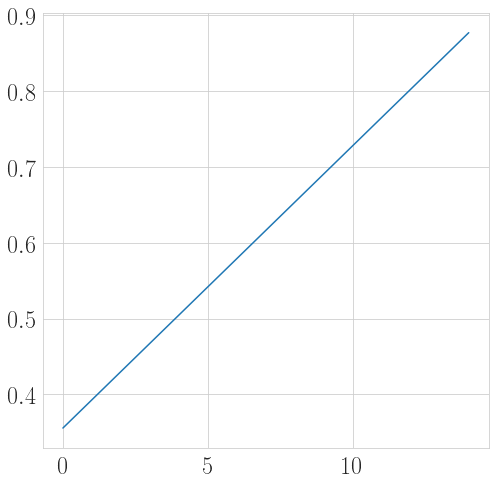

In [62]:
pl.plot((out_struct.x[1]+out_struct.x[0]*np.arange(15)))

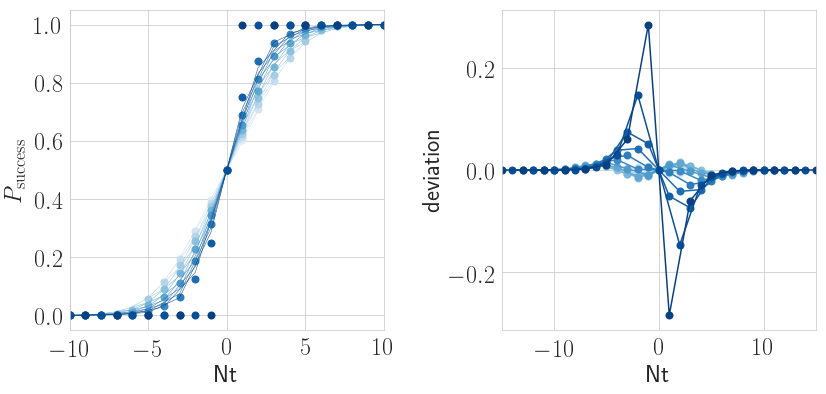

In [63]:
err_Store=[]
# for err in np.linspace(0.09,0.11,11):
fig,ax=pl.subplots(1,2,figsize=(12,6))
cmap = sns.color_palette("Blues", n_colors=16)
df_s['Ptplus_app']=1/(1+np.exp(-(out_struct.x[1]+out_struct.x[0]*df_s.t)*df_s.Nt))
df_s['Ptplus_err']=(df_s['Ptplus_app']-df_s['Ptplus'])
grouped = df_s.groupby('t')
for key, group in grouped:
#     group.plot(ax=ax[0], kind='line', x='Nt', y='Ptplus', marker='o',linestyle='None',color=cmap[key],legend=False)
    group.plot(ax=ax[0], kind='line', x='Nt', y='Ptplus', marker='o',linestyle='None',color=cmap[key],legend=False)
    group.plot(ax=ax[0], kind='line', x='Nt', y='Ptplus_app', marker='None',linestyle='-',linewidth=0.5,color=cmap[key],legend=False)
    group.groupby('t').plot(ax=ax[1], kind='line', x='Nt', y='Ptplus_err', marker='o',linestyle='-',color=cmap[key],legend=False)
ax[0].set_ylabel('$P_{\mathrm{success}}$')
ax[1].set_ylabel('deviation')
ax[0].set_xlim(-10,10)
fig.tight_layout()
fig.savefig('pplus_approx.png', transparent=True,bbox_inches="tight",dpi=300)

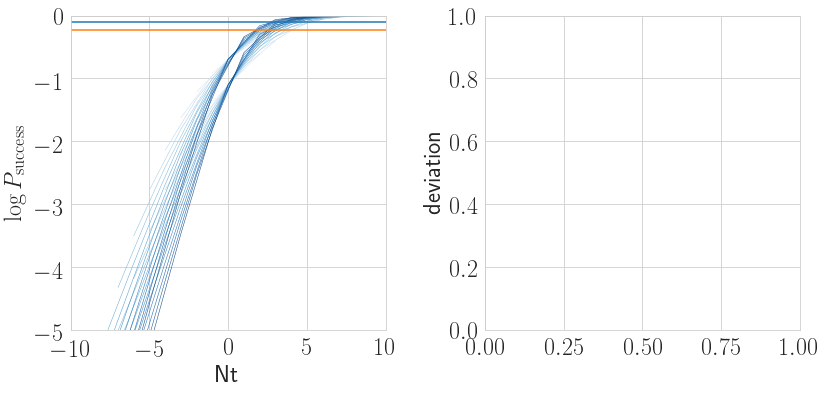

In [189]:
err_Store=[]
# for err in np.linspace(0.09,0.11,11):
fig,ax=pl.subplots(1,2,figsize=(12,6))
cmap = sns.color_palette("Blues", n_colors=16)
df_s['Ptplus_app']=-np.log(1+np.exp(-(out_struct.x[1]+out_struct.x[0]*df_s.t)*df_s.Nt))
df_s['Ptplus_app2']=-np.log(2*(1+np.exp(-(out_struct.x[1]+out_struct.x[0]*df_s.t)*df_s.Nt))-1)

grouped = df_s.groupby('t')
for key, group in grouped:
#     group.plot(ax=ax[0], kind='line', x='Nt', y='Ptplus', marker='o',linestyle='None',color=cmap[key],legend=False)
    group.plot(ax=ax[0], kind='line', x='Nt', y='Ptplus_app', marker='None',linestyle='-',linewidth=0.5,color=cmap[key],legend=False)
    group.plot(ax=ax[0], kind='line', x='Nt', y='Ptplus_app2', marker='None',linestyle='-',linewidth=0.5,color=cmap[key],legend=False)

    ax[0].set_ylabel('$\log P_{\mathrm{success}}$')
ax[0].plot([-10,10],np.log(bound)*np.ones(2))
ax[0].plot([-10,10],np.log(2*bound-1)*np.ones(2))
ax[1].set_ylabel('deviation')
ax[0].set_xlim(-10,10)
ax[0].set_ylim(-5,0)
fig.tight_layout()

(-15, 15)

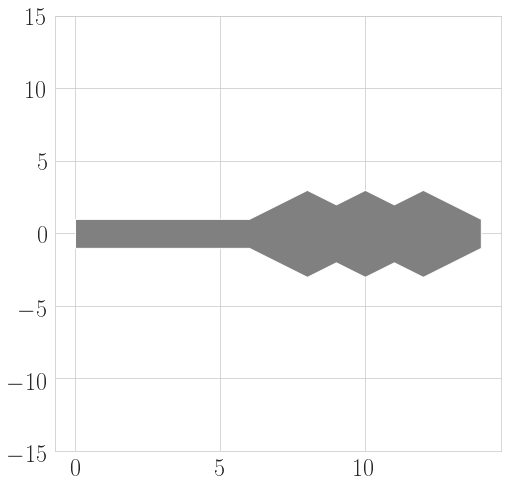

In [533]:
df_s=pd.DataFrame(index=pd.MultiIndex.from_product([range(T+1),range(T+1)]))
df_s['Nt']=[int(inds[0]-inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s['t']=[int(inds[0]+inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s=df_s.drop(df_s[df_s.t>T].index) #drop rows having time>T 
df_s=df_s.drop((0,0))
df_s['Pt_plus']=df_s.apply(lambda x: get_pt_plus(T,x.t,x.Nt),axis=1) #add success probability

#model
#compute posterior
#define prior as P(lambda)
df_s['reward_p']=df_s.apply(lambda x:  x.Pt_plus*(np.heaviside(bound_fn-x.t,1)+np.heaviside(x.t-bound_fn,1)/(1+lamb_mean*(x.t-bound_fn))),axis=1) #add reward
df_s['reward_m']=df_s.apply(lambda x:  (1-x.Pt_plus)*(np.heaviside(bound_fn-x.t,1)+np.heaviside(x.t-bound_fn,1)/(1+lamb_mean*(x.t-bound_fn))),axis=1) #add reward  

#take average over future trajectory maximums
# df_s['expected_reward_p']=df_s.apply(lambda row: 
#                                    dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_p.apply(lambda x: np.max(x[int(row.t)+1:])).mean() if row.t<T else 0,axis=1)
# df_s['expected_reward_m']=df_s.apply(lambda row: 
#                                    dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_m.apply(lambda x: np.max(x[int(row.t)+1:])).mean() if row.t<T else 0,axis=1)
#take maximum over future trajectory maximums
df_s['expected_reward_p']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_p.apply(lambda x: np.max(x[int(row.t):])).max() if row.t<T else 0,axis=1)
df_s['expected_reward_m']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_m.apply(lambda x: np.max(x[int(row.t):])).max() if row.t<T else 0,axis=1)
# 

# df_s['wait']=(~dfp.plus & (df_s.expected_reward_m>df_s.reward_m)) & (dfp.plus & (df_s.expected_reward_p>df_s.reward_p))
df_s['wait']=(df_s.expected_reward_m>df_s.reward_m) & (df_s.expected_reward_p>df_s.reward_p)

dec_plus=np.zeros(T)
dec_minus=np.zeros(T)
for row in df_s.itertuples():
    if row.wait==1:
        dec_plus[row.t]=row.Nt if dec_plus[row.t]< row.Nt else dec_plus[row.t]
        dec_minus[row.t]=row.Nt if dec_minus[row.t]> row.Nt else dec_minus[row.t]   

fig,ax=pl.subplots(1,1)               
ax.fill_between(np.arange(T),dec_plus+1,dec_minus-1,facecolor='gray')
ax.set_ylim(-T,T)
#     fig.savefig('decision_boundary_TITI_'+str(T_ITI),format='jpg',dpi=300,bbox_inches='tight')
#winsound.Beep(frequency, duration)

In [530]:


df_s['reward_p']=df_s.apply(lambda x:  x.Pt_plus*(np.heaviside(bound_fn-x.t,1)+np.heaviside(x.t-bound_fn,1)/(1+lamb_mean*(x.t-bound_fn))),axis=1) #add reward
df_s['reward_m']=df_s.apply(lambda x:  (1-x.Pt_plus)*(np.heaviside(bound_fn-x.t,1)+np.heaviside(x.t-bound_fn,1)/(1+lamb_mean*(x.t-bound_fn))),axis=1) #add reward  

df_s['expected_reward_p']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_p.apply(lambda x: np.max(x[int(row.t)+1:])).max() if row.t<T else 0,axis=1)
df_s['expected_reward_m']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_m.apply(lambda x: np.max(x[int(row.t)+1:])).max() if row.t<T else 0,axis=1)

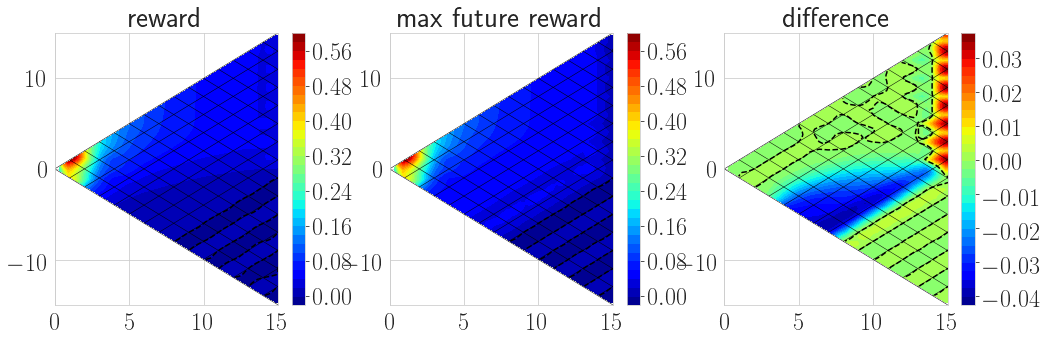

In [534]:
fig,ax=pl.subplots(1,3,figsize=(17,5))
prob_ER=np.zeros((16,16))
prob_R=np.zeros((16,16))
prob_diff=np.zeros((16,16))
bound_fn=1/(p**3)*(bound-p)
for Nm in np.arange(0,2*(T+1),2):
    for Np in np.arange(0,2*(T+1),2):
        t=(Np+Nm)/2
        Nt=(Np-Nm)/2
        if np.logical_and(df_s.t==t,df_s.Nt==Nt).any():
#             prob_p[int(Nm/2),int(Np/2)]=df_s.loc[np.logical_and(df_s.t==t,df_s.Nt==Nt)].reward_p
            prob_ER[int(Nm/2),int(Np/2)]=df_s.loc[np.logical_and(df_s.t==t,df_s.Nt==Nt)].expected_reward_p
            prob_R[int(Nm/2),int(Np/2)]=df_s.loc[np.logical_and(df_s.t==t,df_s.Nt==Nt)].reward_p
            prob_diff[int(Nm/2),int(Np/2)]=df_s.loc[np.logical_and(df_s.t==t,df_s.Nt==Nt)].reward_p-df_s.loc[np.logical_and(df_s.t==t,df_s.Nt==Nt)].expected_reward_p

from scipy.interpolate import griddata
mesh=np.meshgrid(range(16),range(16))
Npvec=mesh[0].flatten()
Nmvec=mesh[1].flatten()
tvec=Npvec+Nmvec
Nvec=Npvec-Nmvec

tvecdense=np.linspace(min(tvec),max(tvec),100)
Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
for it,(prob,title_str) in enumerate(zip([prob_R,prob_ER,prob_diff],['reward','max future reward','difference'])):
    z=griddata((tvec,Nvec),prob.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

    CS=ax[it].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet)
#     ax[it].figure.colorbar(CS)
    pl.colorbar(CS,ax=ax[it])
    ax[it].set_xlim(0,15)
    ax[it].set_title(title_str)
    ax[it].contour(tvecdense,Nvecdense,z,[0.],colors='k',linestyles='--')
    for Nm in 2*np.arange(T):
        ax[it].plot(np.arange(T+1-Nm/2)+Nm/2,np.arange(T+1-Nm/2)-Nm/2,'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)
    for Np in 2*np.arange(T):
        ax[it].plot(np.arange(T+1-Np/2)+Np/2,Np/2-np.arange(T+1-Np/2),'k-',lw=0.5,color='k',mfc='None',mec='k',mew=0.5,ms=3)


In [782]:
dec_plus=np.zeros(T)
dec_minus=np.zeros(T)
for row in df_s.itertuples():
    if row.wait==1:
        dec_plus[row.t]=row.Nt if dec_plus[row.t]< row.Nt else dec_plus[row.t]
        dec_minus[row.t]=row.Nt if dec_minus[row.t]> row.Nt else dec_minus[row.t]

In [196]:
b=0.7
dfp['tb']=dfp.Pt_plus.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)
dfp.loc[~dfp.plus,'tb']=dfp.loc[~dfp.plus,'Pt_plus'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)

dfp['pp']=(T-dfp['tb'])/T)

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


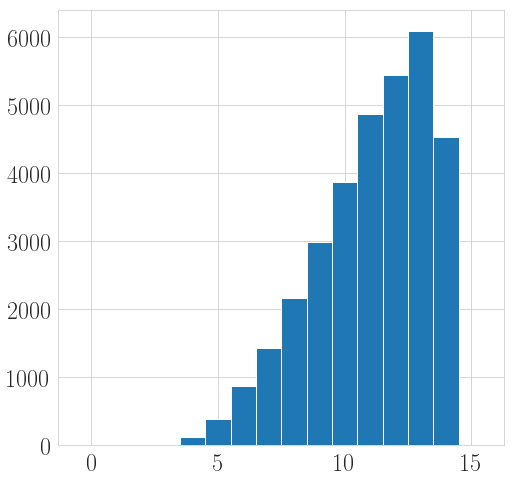

In [193]:
dfp.lamb.hist(bins=np.arange(17)-0.5)

Text(0, 0.5, '$f(t_b)=\\log[1-\\frac{t_b}{T}]$')

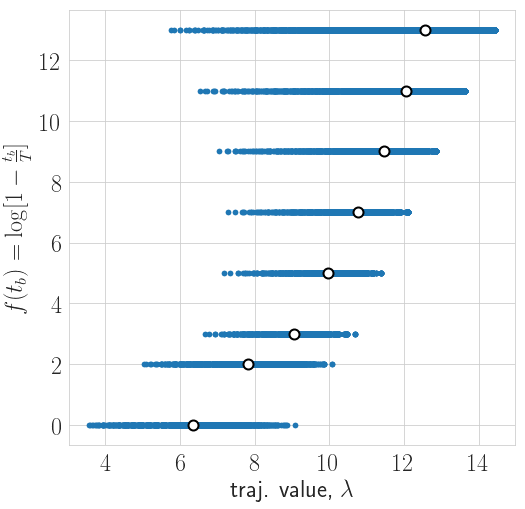

In [323]:
fig,ax=pl.subplots(1,1)
dfp['loglamb']=dfp['lamb']
dfp['logtb']=T-dfp['tb']
dfp.plot.scatter(x='loglamb',y='logtb',ax=ax)
# ax.set_ylim(,10)
# ax.set_yscale('log')
data_means=dfp.groupby(by='logtb').mean().reset_index().loc[:,('loglamb','logtb')]
ax.plot(data_means.loglamb,data_means.logtb,'ko',mfc='w',ms=10)
# xvals=np.linspace(dfp.lamb.min(),dfp.lamb.max(),10)
ax.set_xlabel(r'traj. value, $\lambda$')
ax.set_ylabel(r'$f(t_b)=\log[1-\frac{t_b}{T}]$')
# ax.plot(xvals,2*xvals-2.3,'k--')
# ax.set_xlim(0,2)

Text(0, 0.5, '$f(t_b)=\\log[1-\\frac{t_b}{T}]$')

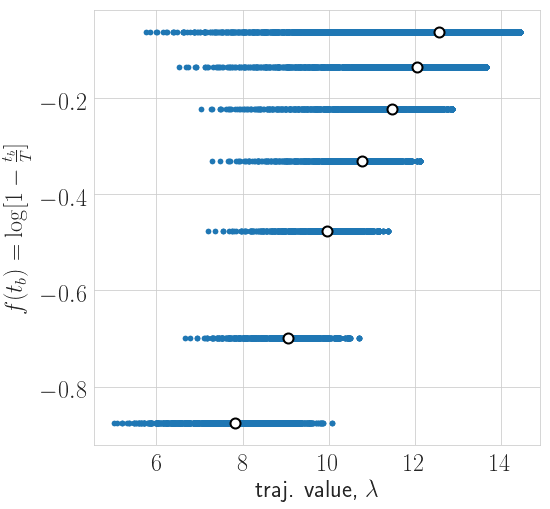

In [316]:
fig,ax=pl.subplots(1,1)
dfp.plot.scatter(x='lamb',y='pp',ax=ax)
# ax.set_ylim(,10)
# ax.set_yscale('log')
data_means=dfp.groupby(by='pp').mean().reset_index().loc[:,('lamb','pp')]
ax.plot(data_means.lamb,data_means.pp,'ko',mfc='w',ms=10)
xvals=np.linspace(dfp.lamb.min(),dfp.lamb.max(),10)
ax.set_xlabel(r'traj. value, $\lambda$')
ax.set_ylabel(r'$f(t_b)=\log[1-\frac{t_b}{T}]$')
# ax.plot(xvals,2*xvals-2.3,'k--')
# ax.set_xlim(0,2)

In [120]:
1+np.log(0.75)+np.log(1-dfp.tb.mean()/T)

0.1911991678673549

Define symmetrized value and plot

In [38]:
dfp=df_traj.copy()
dfp['plus']=(df_traj['Nt'].apply(lambda x:x[-1])>0)

In [99]:
#dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x/(T_ITI+np.arange(T+1))))
#dfp.loc[~dfp['plus'],'lamb']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.sum((1-x)/(T_ITI+np.arange(T+1))))

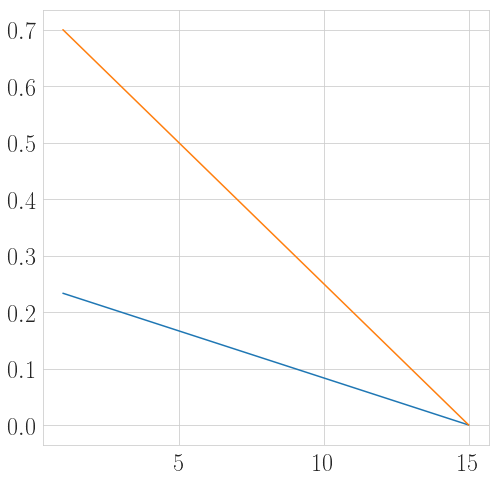

In [108]:
fig,ax=pl.subplots()
for gamma in [0.25,0.75]:
#     ax.plot(np.arange(T+1),(1+gamma*(T-np.arange(T+1)))/(1+np.arange(T+1)))
#     ax.plot(np.arange(T+1),(1+gamma*(T-np.arange(T+1)))/(1+(T-np.arange(T+1))))
#     ax.plot(np.arange(T+1),np.arange(T+1)+gamma*(T-np.arange(T+1)))
    ax.plot(np.arange(1,T+1),gamma*(T-np.arange(1,T+1))/T)


In [739]:
gamma=0.75
dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x*(1+gamma*(T-np.arange(16)))/(1+np.arange(16))/T))
dfp.loc[~dfp['plus'],'lamb']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.sum((1-x)*(1+gamma*(T-np.arange(16)))/(1+np.arange(16))/T))
# dfp['lamb_cumsum']=dfp.Pt_plus.apply(lambda x: np.cumsum(-np.log(x)/((1-gamma)*np.arange(T+1)+gamma*T))**(-1))
# dfp.loc[~dfp['plus'],'lamb_cumsum']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.cumsum(-np.log(1-x)/((1-gamma)*np.arange(T+1)+gamma*T))**(-1))

In [149]:
# gamma=0.25 #fast
# gamma=0.75 #slow
# dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(np.asarray([0 if xi==0 or xi==1 else -xi*np.log(xi)-(1-xi)*np.log(1-xi) for xi in x])))#1+gamma*(T-np.arange(T+1)))/(1+np.arange(T+1))))
# dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x*(1+gamma*(T-np.arange(T+1)))/(1+np.arange(T+1))))
dfp['lamb']=dfp['Pt_plus'].apply(lambda x: np.sum(x)/T)
dfp.loc[~dfp['plus'],'lamb']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.sum(1-x)/T)
dfp['lamb']=dfp['lamb']/dfp.lamb.mean()
# dfp['lamb_cumsum']=dfp.Pt_plus.apply(lambda x: np.cumsum(-np.log(x)/((1-gamma)*np.arange(T+1)+gamma*T))**(-1))
# dfp.loc[~dfp['plus'],'lamb_cumsum']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.cumsum(-np.log(1-x)/((1-gamma)*np.arange(T+1)+gamma*T))**(-1))

KeyError: 'lamb_cumsum'

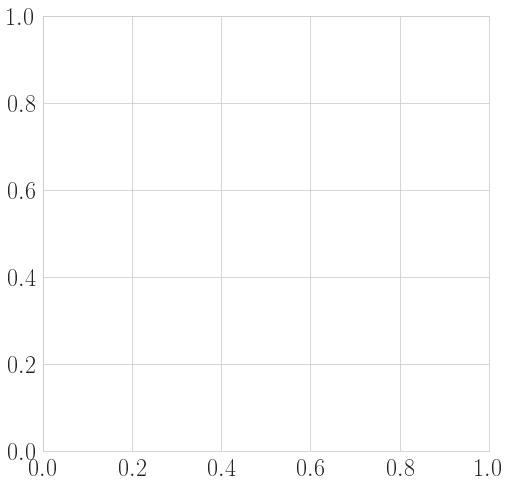

In [128]:
fig,ax=pl.subplots(1,1)
ax.plot(np.arange(T+1),np.vstack(dfp.loc[dfp['plus'],'lamb_cumsum'].values).T);


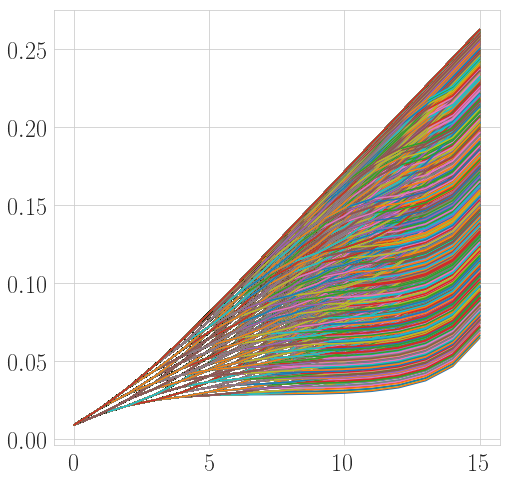

In [61]:
fig,ax=pl.subplots(1,1)
ax.plot(np.arange(T+1),np.vstack(dfp.loc[dfp['plus'],'lamb_cumsum'].values).T);


min:0.237548828125max:0.9619303385416667 mean:0.7375757137934627


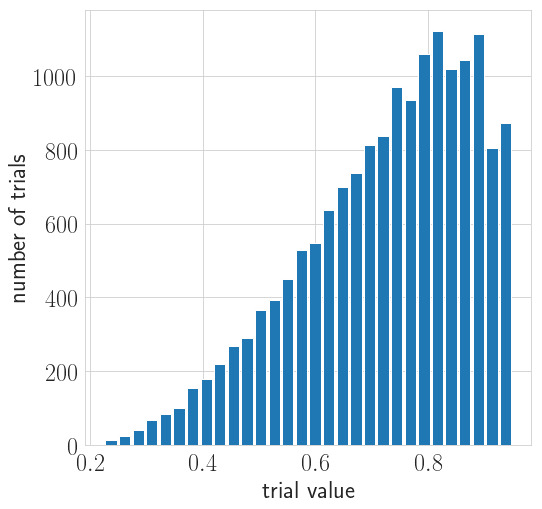

In [139]:
fig,ax=pl.subplots(1,1)
# counts, bins=np.histogram(-dfp.lamb.values*np.log2(dfp.lamb.values)-(1-dfp.lamb.values)*np.log2(1-dfp.lamb.values),30)
counts, bins=np.histogram(dfp.loc[dfp['plus']].lamb.values,30)

ax.bar(bins[:-1],counts,width=0.02)#0.1)
ax.set_xlabel('trial value')
ax.set_ylabel('number of trials')
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title('')
# ax.set_xlim(-4,0)
# xvalrange=np.linspace(-4,0,10)
# ax.plot(xvalrange,1e4*np.exp(3*xvalrange),'k--')
# ax.plot(np.sort(dfp.lamb.unique()))
# ax[1].set_xlabel('ranked trial value')
lamb_min=dfp.lamb.min()
lamb_max=dfp.lamb.max()
lamb_mean=dfp.lamb.mean()
print('min:'+str(dfp.lamb.min())+'max:'+str(dfp.lamb.max())+' mean:'+str(lamb_mean))
# fig.savefig('value_distribution.jpg',format='jpg',dpi=300,bbox_inches='tight')

C:\Users\mptouzel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log2
  


ValueError: autodetected range of [nan, nan] is not finite

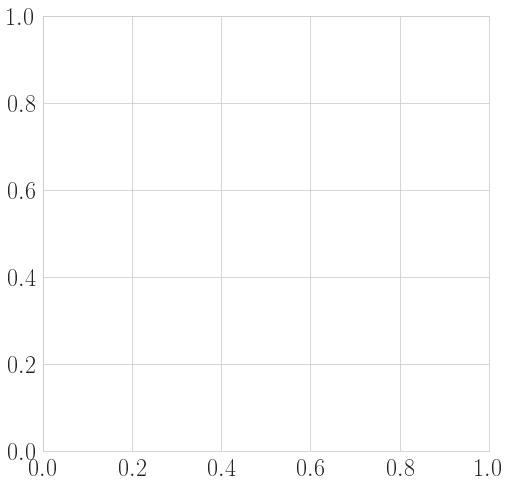

In [352]:
fig,ax=pl.subplots(1,1)
counts, bins=np.histogram(-dfp.lamb.values*np.log2(dfp.lamb.values)-(1-dfp.lamb.values)*np.log2(1-dfp.lamb.values),30)
# counts, bins=np.histogram(dfp.lamb.values,30)

ax.bar(bins[:-1],counts,width=0.005)
ax.set_xlabel('normalized trial value')
ax.set_ylabel('number of trials')
ax.set_title('')

# ax.plot(np.sort(dfp.lamb.unique()))
# ax[1].set_xlabel('ranked trial value')
lamb_min=dfp.lamb.min()
lamb_max=dfp.lamb.max()
lamb_mean=dfp.lamb.mean()
print('min:'+str(dfp.lamb.min())+'max:'+str(dfp.lamb.max())+' mean:'+str(lamb_mean))
# fig.savefig('value_distribution.jpg',format='jpg',dpi=300,bbox_inches='tight')

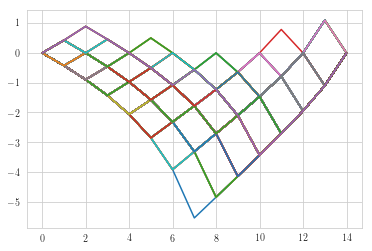

In [30]:
fig,ax=pl.subplots(1,1)
# ax.plot(np.arange(T+1),np.vstack(dfp.loc[(dfp.lamb>0.154) & (dfp.lamb<0.155) & dfp.plus,'evidence'].values).T);
# ax.plot(np.arange(T+1),np.vstack(dfp.loc[(dfp.lamb<0.1)  & dfp.plus,'evidence'].values).T);
ax.plot(np.arange(T+1),np.vstack(dfp.loc[(dfp.lamb<-0.3)  & dfp.plus,'evidence'].values).T);

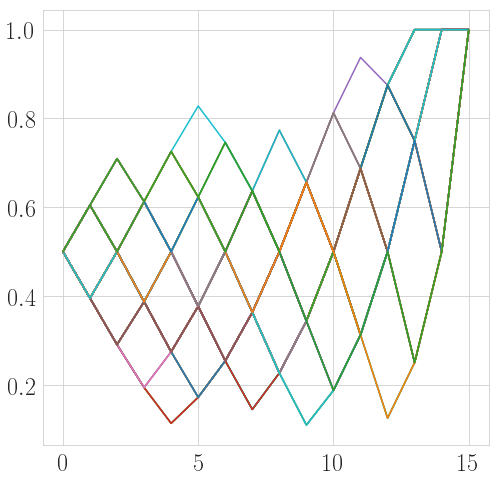

In [65]:
fig,ax=pl.subplots(1,1)
ax.plot(np.arange(T+1),np.vstack(dfp.loc[(dfp.lamb>0.154) & (dfp.lamb<0.155) & dfp.plus,'Pt_plus'].values).T);

look at decision time cumulative distribution based on diffusion to bound model $P_b(t)$

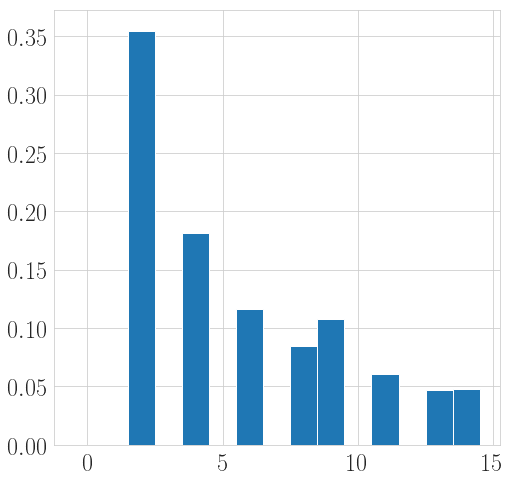

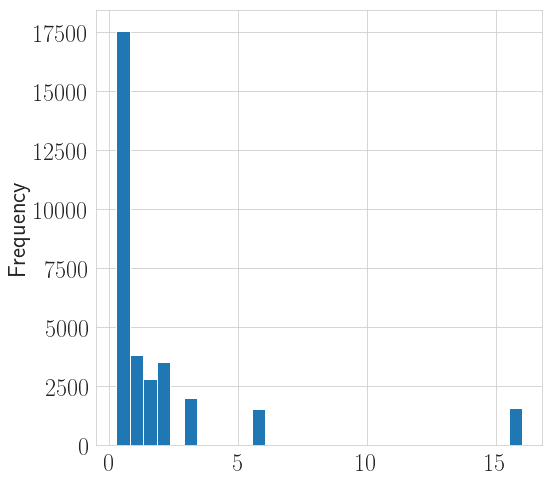

In [671]:
for b in [0.65]:#[0.55,0.6,0.65,0.7]:
    fig,ax=pl.subplots(1,1)
    dfp['tb']=dfp.Pt_plus.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)
    dfp.loc[~dfp['plus'],'tb']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)
    counts, bins=np.histogram(dfp.tb.values,np.arange(T+1))
    ax.bar(bins[:-1],counts/np.sum(counts),width=1.)

fig,ax=pl.subplots(1,1)
gamma=0.7
dfp['lambnew']=((1+gamma*(T-dfp['tb']))/(1+dfp['tb']))**(-1)
dfp.lambnew.plot.hist(bins=30)
# b=1
# dfp['tb']=dfp.evidence.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)
# dfp.loc[~dfp['plus'],'tb']=dfp.loc[~dfp['plus'],'evidence'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)
# counts, bins=np.histogram(dfp.tb.values,np.arange(T+1))
# ax.bar(bins[:-1],counts/np.sum(counts),width=1.)

    #ax.bar(bins[:-1],1-np.cumsum(counts/np.sum(counts)),width=1.)
#     ax.bar(bins[:-1],1-np.cumsum(counts),width=1.)
#     plot(np.arange(T+1),np.exp(np.arange(T+1))
#     ax.set_yscale('log')

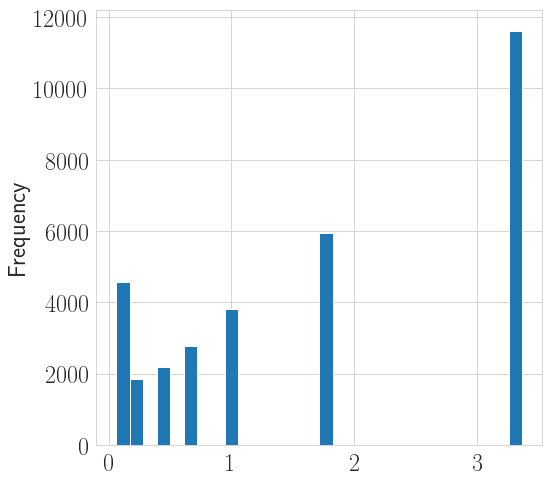

Now look at reward (TODO: change to actual model predictions

In [328]:
dfp['reward_p']=dfp.Pt_plus.apply(lambda x: (x*(1+1/(1+dfp.lamb.mean()*np.arange(T+1)))))
dfp['reward_m']=dfp.Pt_plus.apply(lambda x: ((1-x)*(1+1/(1+dfp.lamb.mean()*np.arange(T+1)))))

# dfp['reward']=dfp.Pt_plus.apply(lambda x: (x/(1+dfp.lamb.mean()*np.arange(T))))

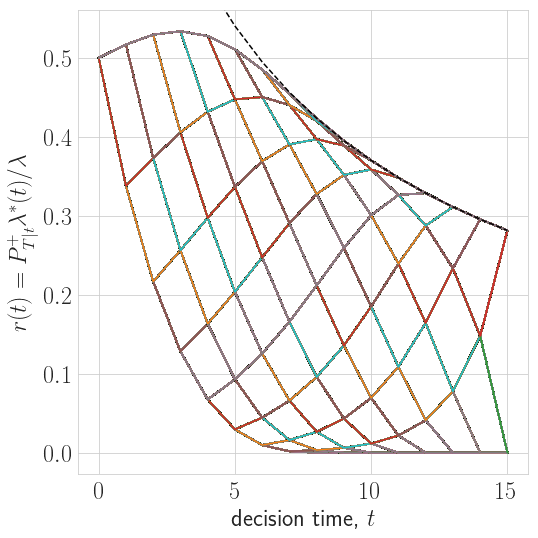

In [42]:
fig,ax=pl.subplots(1,1,figsize=(8,8))
ax.plot(np.arange(T+1),np.vstack(dfp.reward_p.values).T)
ylimits=ax.get_ylim()
ax.plot(1/(1+dfp.lamb.mean()*np.arange(T+1)),'k--')
ax.set_ylim(ylimits)
ax.set_ylabel('$r(t)=P^+_{T|t}\lambda^{*}(t)/\lambda$')
ax.set_xlabel('decision time, $t$')

# df['td']=df.Pt_plus.apply(lambda x:np.argmax(x/(1/dfp.lamb.mean()+np.arange(T+1))))
# df[df['Nt'].apply(lambda x:x[-1])>0].hist(ax=ax[1],column='td',label='decision time',bins=np.arange(T+1))
# ax[1].set_xticks(np.arange(0,T+1,2))
# ax[1].set_xlabel('optimal $t_{\mathrm{dec}}$')
# ax[1].set_ylabel('number of trajectories')
# ax[1].set_title('')

fig.tight_layout()

# fig.savefig('dec_times.jpg',format='jpg',dpi=300,bbox_inches='tight')
# fig.savefig(paperpath+'dec_times.jpg',format='jpg',dpi=300,bbox_inches='tight')

In [69]:
# # dfp.reward=dfp.Pt_plus.apply(lambda x: (x/(1+dfp.lamb.mean()*np.arange(T+1))))

# # dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x/(T_ITI+np.arange(T+1))))
# # dfp.loc[~dfp['plus'],'lamb']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.sum((1-x)/(T_ITI+np.arange(T+1))))
# dfp.other_Pt_plus=dfp.Pt_plus.apply(lambda x: np.sum(x/(T_ITI+np.arange(T+1))))
# def other(row):
#     if row.state==0:
#         return row.Pt_plus
#     else:
#         return other_P_row

# def calc_deccrit(row):
#     states=row.states
#     Pt_plus=row.Pt_plus
#     other_p=row.other_P
#     if 
#     Pt_plus[:-1]+Pt_plus[1:]
    
# dfp.dec_crit=dfp.Pt_plus.apply(lambda x: (x/(1+dfp.lamb.mean()*np.arange(T+1))))

Look at decision times obtained from the maximum of these rewards

In [43]:
dfp['tmax']=dfp.reward_p.apply(lambda x: np.argmax(x))
dfp.loc[~dfp.plus,'tmax']=dfp.reward_m.apply(lambda x: np.argmax(x))

<BarContainer object of 15 artists>

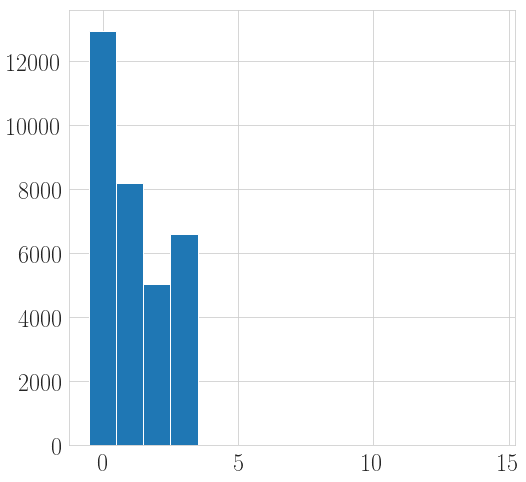

In [44]:
fig,ax=pl.subplots(1,1)
counts, bins=np.histogram(dfp.tmax.values,np.arange(T+1))
ax.bar(bins[:-1],counts,width=1.)

These times require full trial knowledge. The actual online decision time takes an average over all futur eexpected rewards

In [45]:
#create index over a mtrix of statesset of states
df_s=pd.DataFrame(index=pd.MultiIndex.from_product([range(T+1),range(T+1)]))
df_s['Nt']=[int(inds[0]-inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s['t']=[int(inds[0]+inds[1]) for inds in df_s.index.values] #define state, time =sum of indexes+2
df_s=df_s.drop(df_s[df_s.t>T].index) #drop rows having time>T 
df_s=df_s.drop((0,0))
df_s['Pt_plus']=df_s.apply(lambda x: get_pt_plus(T,x.t,x.Nt),axis=1) #add success probability
df_s['reward_p']=df_s.apply(lambda x:  x.Pt_plus/(1+dfp.lamb.mean()*x.t),axis=1) #add reward
df_s['reward_m']=df_s.apply(lambda x:  (1-x.Pt_plus)/(1+dfp.lamb.mean()*x.t),axis=1) #add reward

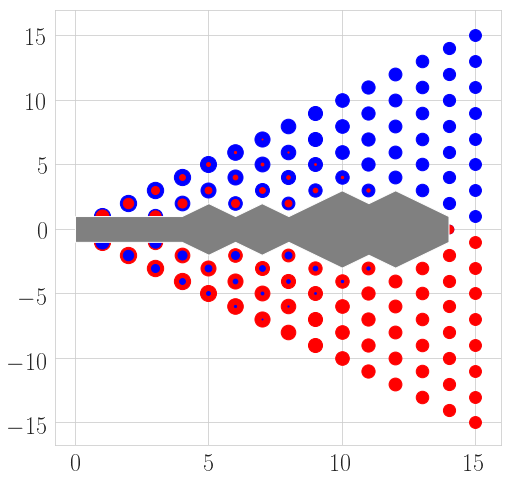

In [46]:
fig,ax=pl.subplots(1,1)
for row in df_s.itertuples():
#     print?(row.Index)
#     ax.scatter(row.t,row.Nt,s=500*1,edgecolors='k',facecolors='None')
    if row.reward_p<row.reward_m:
        ax.scatter(row.t,row.Nt,s=500*row.reward_m,c='r')
        ax.scatter(row.t,row.Nt,s=500*row.reward_p,c='b')
    else:
        ax.scatter(row.t,row.Nt,s=500*row.reward_p,c='b')
        ax.scatter(row.t,row.Nt,s=500*row.reward_m,c='r')
        
df_s['expected_reward_p']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_p.apply(lambda x: np.max(x[int(row.t)+1:])).mean() if row.t<T else 0,axis=1)
df_s['expected_reward_m']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_m.apply(lambda x: np.max(x[int(row.t)+1:])).mean() if row.t<T else 0,axis=1)
df_s['wait']=(df_s.expected_reward_m>df_s.reward_m) & (df_s.expected_reward_p>df_s.reward_p)
np.sum(~df_s['wait'])

dec_plus=np.zeros(T)
dec_minus=np.zeros(T)
for row in df_s.itertuples():
    if row.wait==1:
        dec_plus[row.t]=row.Nt if dec_plus[row.t]< row.Nt else dec_plus[row.t]
        dec_minus[row.t]=row.Nt if dec_minus[row.t]> row.Nt else dec_minus[row.t]                
ax.fill_between(np.arange(T),dec_plus+1,dec_minus-1,facecolor='gray')

In [74]:
df_s.head()

Nt  t   Pt_plus  reward_p  reward_m
0 1  -1  1  0.395264  0.375919  0.575140
  2  -2  2  0.290527  0.263417  0.643269
  3  -3  3  0.193848  0.167924  0.698344
  4  -4  4  0.113281  0.093944  0.735357
  5  -5  5  0.054688  0.043496  0.751863

In [34]:
#expected future reward as the average maximum reward over all future trajectories, performed here by selecting the sub set of trajectories having the state at that time, getting thier maximum future reward, and averaging
# df_s['expected_reward']=df_s.apply(lambda row: 
#                                    dfp.loc[dfp.Nt.apply(lambda x:x[row.t.values-1])==row.Nt].reward.apply(lambda x: np.mean(x[row.t-1:])).mean(),axis=1)

#expected future reward as the average maximum reward over all future trajectories, performed here by selecting the sub set of trajectories having the state at that time, getting thier maximum future reward, and averaging
df_s['expected_reward_p']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_p.apply(lambda x: np.max(x[int(row.t)+1:])).mean() if row.t<T else 0,axis=1)

In [35]:
df_s['expected_reward_m']=df_s.apply(lambda row: 
                                   dfp.loc[dfp.Nt.apply(lambda x:x[int(row.t)])==row.Nt].reward_m.apply(lambda x: np.max(x[int(row.t)+1:])).mean() if row.t<T else 0,axis=1)

In [36]:
df_s['wait']=(df_s.expected_reward_m>df_s.reward_m) & (df_s.expected_reward_p>df_s.reward_p)
np.sum(~df_s['wait'])

118

AttributeError: 'Pandas' object has no attribute 'wait'

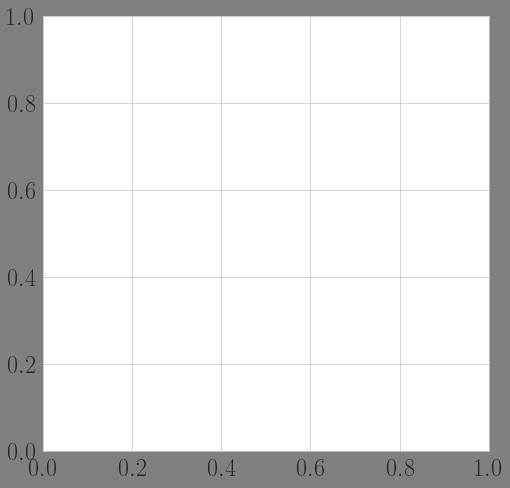

In [32]:
fig,ax=pl.subplots(1,1)

dec_plus=np.zeros(T)
dec_minus=np.zeros(T)
for row in df_s.itertuples():
    if row.wait==1:
        dec_plus[row.t]=row.Nt if dec_plus[row.t]< row.Nt else dec_plus[row.t]
        dec_minus[row.t]=row.Nt if dec_minus[row.t]> row.Nt else dec_minus[row.t]                
ax.fill_between(np.arange(T),dec_plus+1,dec_minus-1,facecolor='gray')

for row in df_s.itertuples():
#     print?(row.Index)
    
    if row.reward_p<row.reward_m:
        ax.scatter(row.t,row.Nt,s=500*row.expected_reward_m**2,c='r')
        ax.scatter(row.t,row.Nt,s=500*row.expected_reward_p**2,c='b')
    else:
        ax.scatter(row.t,row.Nt,s=500*row.expected_reward_p**2,c='b')
        ax.scatter(row.t,row.Nt,s=500*row.expected_reward_m**2,c='r')
ax.set_ylabel('$N_t=N_R-N_L$')
ax.set_xlabel('$t$ jumps')
from matplotlib.lines import Line2D
cust_dots=[Line2D([0],[0],color='w',marker='o',markerfacecolor='r',markersize=15,label=r'$\langle r^L_{max}\rangle_{s>t}$'),
            Line2D([0],[0],color='w',marker='o',markerfacecolor='b',markersize=15,label=r'$\langle r^R_{max}\rangle_{s>t}$')]
ax.legend(handles=cust_dots,frameon=False)
# fig.savefig('decision_boundary.jpg',format='jpg',dpi=300,bbox_inches='tight')


problem is that there is no wait at the beginning so that better to decide early on all trials!

C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


Text(0.5, 0.93, '$P(t_b|\\lambda)$')

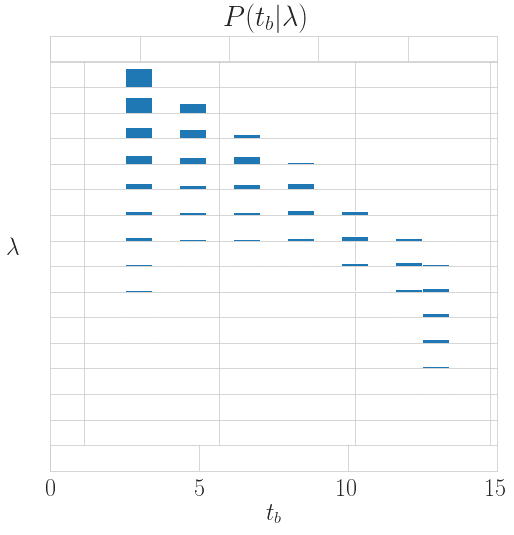

In [498]:
num_vals=16
dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x))
dfp.loc[~dfp['plus'],'lamb']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.sum(1-x))
# dfp['lamb']=((1+gamma*(T-dfp['tb']))/(1+dfp['tb']))
lamb_min=dfp['lamb'].min()
lamb_max=dfp['lamb'].max()
lambvec=np.linspace(lamb_min,lamb_max,num_vals+1)

b=0.7
#dfp['td']=dfp.Pt_plus.apply(lambda x: np.argmax(x))#/(T_ITI+T)))#np.arange(T+1))))
dfp['td']=dfp.Pt_plus.apply(lambda x: np.where(x>=b)[0][0] if np.where(x>=b)[0].size else T)
dfp.loc[~dfp['plus'],'td']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.where(x<=1-b)[0][0] if np.where(x<=1-b)[0].size else T)
   
fig,axarr=pl.subplots(len(lambvec),1)
n_trials=np.zeros(len(lambvec))
for lit,lamb in enumerate(lambvec[:-1]):
    n_trials[lit]=((dfp['lamb']>lamb) & (dfp['lamb']<lambvec[lit+1])).sum()
    dfp.loc[(dfp['lamb']>lamb) & (dfp['lamb']<lambvec[lit+1])].hist(ax=axarr[len(lambvec)-lit-1],column='td',bins=np.arange(15+1)-0.5)
    axarr[len(lambvec)-lit-1].set_ylim()
for ait,ax in enumerate(axarr):
    ax.set_yticks([])
    ax.set_ylim(0,4e3)
    ax.set_title('')
    if ait<len(lambvec)-1:
        ax.set_xticklabels([])
    
ax.set_xticks([0,5,10,15])
ax.set_xlim(0,15)
ax.set_xlabel('$t_b$')
fig.text(0.05,0.5,'$\lambda$')
fig.tight_layout()
fig.subplots_adjust(hspace = .001)
fig.suptitle(r'$P(t_b|\lambda)$',y=0.93)

Text(0.5, 1.01, '$P(t_b|b)$')

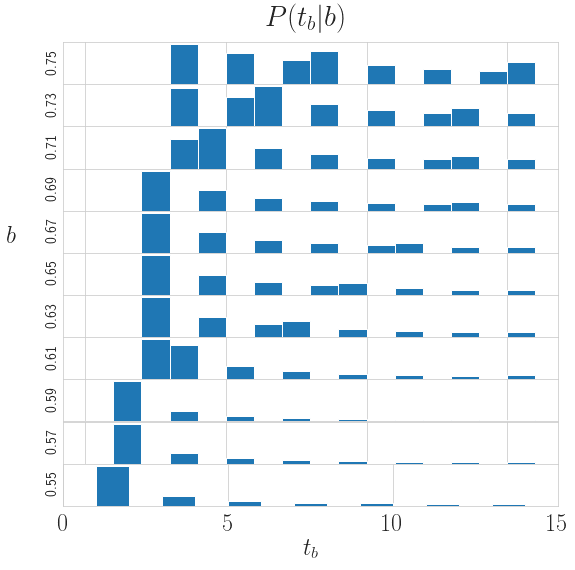

In [324]:
# dfp=df.loc[df['Nt'].apply(lambda x:x[-1])>0].reset_index(drop=True).copy()
# dfp=df.loc[df['Nt'].apply(lambda x:x[-1])<0].reset_index(drop=True).copy()
# dfp=df.copy()
# dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x))
# dfp['td']=dfp.Pt_plus.apply(lambda x: np.argmax(x/(T_ITI+np.arange(T+1))))
lamb_min=0.55
lamb_max=0.75
lambvec=0.55+0.02*np.arange(11)

# b=0.7
# dfp['td']=dfp.Pt_plus.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)#/(T_ITI+T)))#np.arange(T+1))))
# dfp.loc[~dfp['plus'],'td']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)
   
num_vals=16
# lambvec=np.arange(T+1)-(T+1)/2
fig,axarr=pl.subplots(len(lambvec),1)
n_trials=np.zeros(len(lambvec))
for lit,lamb in enumerate(lambvec):
    #n_trials[lit]=((dfp['lamb']>lamb) & (dfp['lamb']<lambvec[lit+1])).sum()
    dfp['td']=dfp.Pt_plus.apply(lambda x: np.where(x>lamb)[0][0] if np.where(x>lamb)[0].size else T)
    dfp.loc[~dfp['plus'],'td']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.where(x<1-lamb)[0][0] if np.where(x<1-lamb)[0].size else T)
  
    dfp.hist(ax=axarr[len(lambvec)-lit-1],column='td',bins=np.arange(num_vals+1))
    
for ait,ax in enumerate(axarr):
    ax.set_yticks([])
#     ax.set_xlim(0,T)
#     ax.set_ylim(0,800)
    #ax.set_ylabel('')#ax.get_title())
    ax.set_title('')
    if ait<len(lambvec)-1:
        ax.set_xticklabels([])
        
#     if np.mod(ait,2):
    ax.set_ylabel("{0:.2f}".format(lambvec[len(lambvec)-ait-1]),fontsize=14)
    #ax.set_ylabel(str(int(lambvec[len(lambvec)-ait-1])))
ax.set_xticks([0,5,10,15])
ax.set_xlim(0,num_vals-1)
ax.set_xlabel('$t_b$')
fig.text(-0.02,0.6,'$b$')
fig.tight_layout()
fig.subplots_adjust(hspace = .001)
fig.suptitle(r'$P(t_b|b)$',y=1.01)
# fig.savefig('condprob_tdec_lamb.jpg',format='jpg',dpi=300,bbox_inches='tight')

# fig,ax=pl.subplots(1,1)
# ax.barh(lambvec,n_trials);
# fig.savefig('condprob_tdec_lamb_trialstats.jpg',format='jpg',dpi=300,bbox_inches='tight')


rest is junk

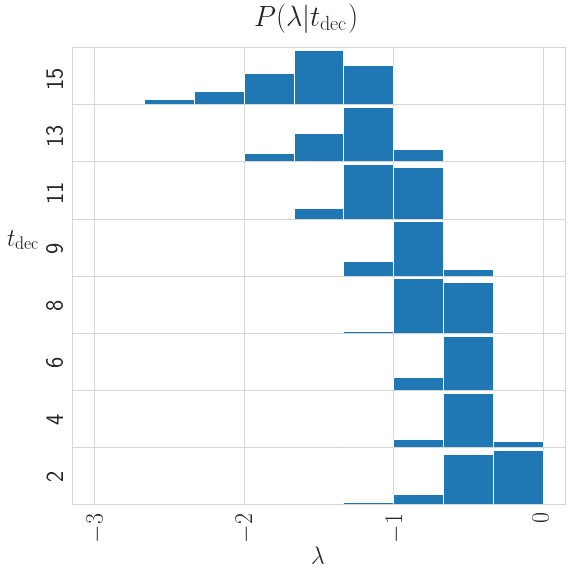

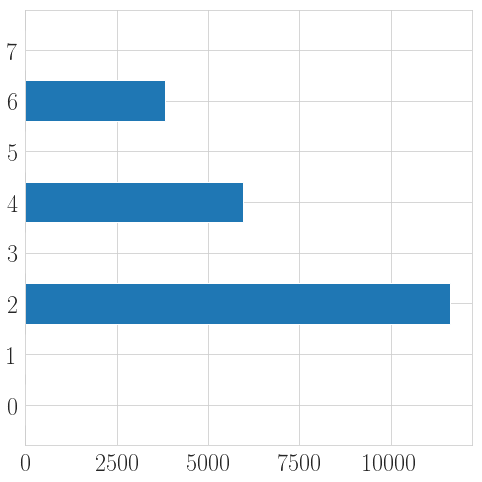

In [641]:
# dfp=df.loc[df['Nt'].apply(lambda x:x[-1])>0].reset_index(drop=True).copy()
# dfp=df.loc[df['Nt'].apply(lambda x:x[-1])<0].reset_index(drop=True).copy()
# dfp=df.copy()

# T=15
# dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x))
#T_ITI=10
b=0.65
#dfp['td']=dfp.Pt_plus.apply(lambda x: np.argmax(x))#/(T_ITI+T)))#np.arange(T+1))))
dfp['td']=dfp.Pt_plus.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)
dfp.loc[~dfp['plus'],'td']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)
    
num_vals=8 #the largest possible decision time 
fig,axarr=pl.subplots(num_vals,1)
dfp['lamb'].hist(by=dfp['td'],ax=axarr[::-1],bins=np.linspace(-3,0,10))#0,0.1,10))
n_trials=np.zeros(len(axarr))
for ait,ax in enumerate(axarr):
    n_trials[ait]=(dfp['td']==ait).sum()
    ax.set_yticks([])
#     ax.set_xlim(0,T)
#     ax.set_ylim(0,800)
    ax.set_ylabel(ax.get_title())
    ax.set_title('')
    if ait<num_vals-1:
        ax.set_xticklabels([])
ax.set_xlabel('$\lambda$')
fig.text(-0.02,0.6,'$t_{\mathrm{dec}}$')
fig.tight_layout()
fig.subplots_adjust(hspace = .001)
fig.suptitle(r'$P(\lambda|t_{\mathrm{dec}})$',y=1.02)
# fig.savefig('negcorr_td_vs_d.jpg',format='jpg',dpi=300,bbox_inches='tight')
# fig.savefig(paperpath+'negcorr_td_vs_d.jpg',format='jpg',dpi=300,bbox_inches='tight')
# fig.savefig('condprob_lamb_tdec.jpg',format='jpg',dpi=300,bbox_inches='tight')

fig,ax=pl.subplots(1,1)
ax.barh(range(num_vals),n_trials);
# fig.savefig('condprob_lamb_tdec_trialstats.jpg',format='jpg',dpi=300,bbox_inches='tight')


C:\Users\mptouzel\Anaconda3\lib\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


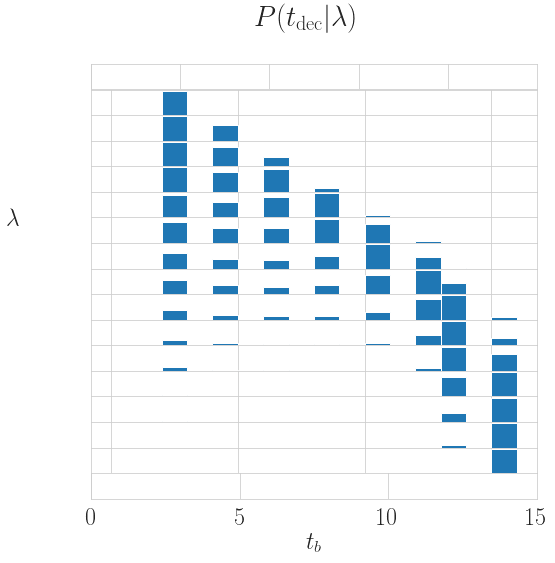

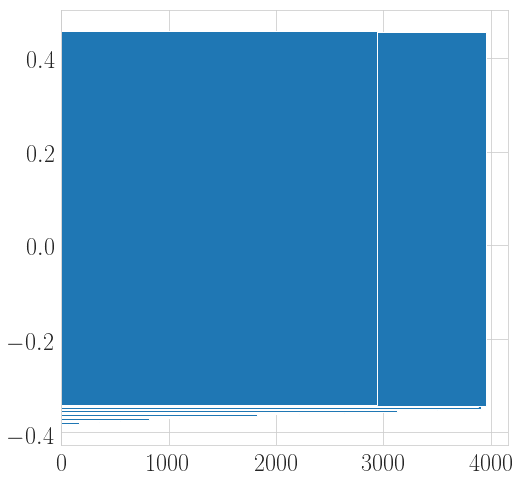

In [95]:
# dfp=df.loc[df['Nt'].apply(lambda x:x[-1])>0].reset_index(drop=True).copy()
# dfp=df.loc[df['Nt'].apply(lambda x:x[-1])<0].reset_index(drop=True).copy()
# dfp=df.copy()
# dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x))
# dfp['td']=dfp.Pt_plus.apply(lambda x: np.argmax(x/(T_ITI+np.arange(T+1))))
lamb_min=dfp['lamb'].min()
lamb_max=dfp['lamb'].max()
lambvec=np.linspace(lamb_min,lamb_max,num_vals+1)

b=0.7
#dfp['td']=dfp.Pt_plus.apply(lambda x: np.argmax(x))#/(T_ITI+T)))#np.arange(T+1))))
dfp['td']=dfp.Pt_plus.apply(lambda x: np.where(x>b)[0][0] if np.where(x>b)[0].size else T)
dfp.loc[~dfp['plus'],'td']=dfp.loc[~dfp['plus'],'Pt_plus'].apply(lambda x: np.where(x<1-b)[0][0] if np.where(x<1-b)[0].size else T)
   
num_vals=16
# lambvec=np.arange(T+1)-(T+1)/2
fig,axarr=pl.subplots(len(lambvec),1)
n_trials=np.zeros(len(lambvec))
for lit,lamb in enumerate(lambvec[:-1]):
    n_trials[lit]=((dfp['lamb']>lamb) & (dfp['lamb']<lambvec[lit+1])).sum()
    dfp.loc[(dfp['lamb']>lamb) & (dfp['lamb']<lambvec[lit+1])].hist(ax=axarr[len(lambvec)-lit-1],column='td',bins=np.arange(num_vals+1))
    
for ait,ax in enumerate(axarr):
    ax.set_yticks([])
#     ax.set_xlim(0,T)
#     ax.set_ylim(0,800)
    #ax.set_ylabel('')#ax.get_title())
    ax.set_title('')
    if ait<len(lambvec)-1:
        ax.set_xticklabels([])
    #ax.set_ylabel(str(int(lambvec[len(lambvec)-ait-1])))
ax.set_xticks([0,5,10,15])
ax.set_xlim(0,num_vals-1)
ax.set_xlabel('$t_b$')
fig.text(-0.02,0.6,'$\lambda$')
fig.tight_layout()
fig.subplots_adjust(hspace = .001)
fig.suptitle(r'$P(t_{\mathrm{dec}}|\lambda)$')
# fig.savefig('condprob_tdec_lamb.jpg',format='jpg',dpi=300,bbox_inches='tight')

fig,ax=pl.subplots(1,1)
ax.barh(lambvec,n_trials);
# fig.savefig('condprob_tdec_lamb_trialstats.jpg',format='jpg',dpi=300,bbox_inches='tight')


32768 trajectories, 8000 possible values of trial value (sum of P+). For teh subset of trials having values in the range [lambda,lambda+dlambda),

In [75]:

dfp=df.loc[df['Nt'].apply(lambda x:x[-1])>0].reset_index(drop=True).copy()
# dfp=df.loc[df['Nt'].apply(lambda x:x[-1])<0].reset_index(drop=True).copy()
# dfp=df.copy()

T=15
dfp['lamb']=dfp.Pt_plus.apply(lambda x: np.sum(x))
dfp['td']=dfp.Pt_plus.apply(lambda x: np.argmax(x/(T_ITI+np.arange(T+1))))
num_vals=9
fig,axarr=pl.subplots(num_vals,1)
dfp['lamb'].hist(by=dfp['td'],ax=axarr[::-1],bins=20)
for ait,ax in enumerate(axarr):
    ax.set_yticks([])
#     ax.set_xlim(0,T)
#     ax.set_ylim(0,800)
    ax.set_ylabel(ax.get_title())
    ax.set_title('')
    if ait<num_vals-1:
        ax.set_xticklabels([])
ax.set_xlabel('$lamb$')
fig.text(-0.02,0.6,'$t_{\mathrm{dec}}$')
fig.tight_layout()
fig.subplots_adjust(hspace = .001)
# fig.savefig('negcorr_td_vs_d.jpg',format='jpg',dpi=300,bbox_inches='tight')
# fig.savefig(paperpath+'negcorr_td_vs_d.jpg',format='jpg',dpi=300,bbox_inches='tight')

In [12]:
dfp['d']=dfp.Pt_plus.apply(lambda x: np.sum(x))
dfp['d'] = 1-(dfp['d'] - dfp['d'].min()) / (dfp['d'].max() - dfp['d'].min())

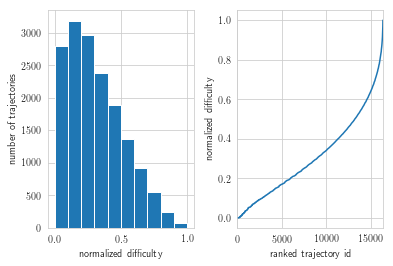

In [13]:
fig,ax=pl.subplots(1,2)
dfp.hist(ax=ax[0],column='d',label='difficulty',density=False)
ax[0].set_xlabel('normalized difficulty')
ax[0].set_ylabel('number of trajectories')
ax[0].set_title('')

dfp.sort_values(by='d').reset_index(drop=True).plot(ax=ax[1],y='d')
ax[1].set_ylabel('normalized difficulty')
ax[1].set_xlabel('ranked trajectory id')
ax[1].get_legend().remove()

# fig.savefig('difficulties.jpg',format='jpg',dpi=300,bbox_inches='tight')
# fig.savefig(paperpath+'difficulties.jpg',format='jpg',dpi=300,bbox_inches='tight')

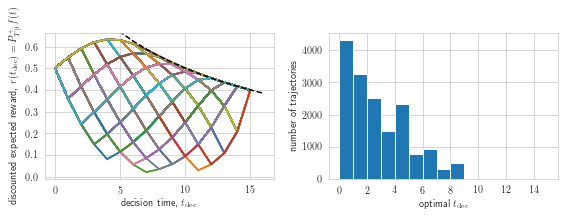

In [14]:
fig,ax=pl.subplots(1,2,figsize=(8,3))
T_ITI=10
ax[0].plot(np.arange(T+1),T_ITI*(np.vstack(df[df['Nt'].apply(lambda x:x[-1])>0].sample(500).Pt_plus.values)/(T_ITI+np.arange(T+1)[np.newaxis,:])).T)
ylimits=ax[0].get_ylim()
ax[0].plot(T_ITI/(T_ITI+np.arange(T+2)),'k--')
ax[0].set_ylim(ylimits)
ax[0].set_ylabel('discounted expected reward, $r(t_{\mathrm{dec}})=P^+_{T|t}f(t)$')
ax[0].set_xlabel('decision time, $t_{\mathrm{dec}}$')

df['td']=df.Pt_plus.apply(lambda x:np.argmax(x/(T_ITI+np.arange(T+1))))
df[df['Nt'].apply(lambda x:x[-1])>0].hist(ax=ax[1],column='td',label='decision time',bins=np.arange(T+1))
ax[1].set_xticks(np.arange(0,T+1,2))
ax[1].set_xlabel('optimal $t_{\mathrm{dec}}$')
ax[1].set_ylabel('number of trajectories')
ax[1].set_title('')

fig.tight_layout()

# fig.savefig('dec_times.jpg',format='jpg',dpi=300,bbox_inches='tight')
# fig.savefig(paperpath+'dec_times.jpg',format='jpg',dpi=300,bbox_inches='tight')

In [70]:
dfp.head()

seq  \
0  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
1  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
2  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
3  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   
4  [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...   

                                                  Nt  \
0  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
1  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
2  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
3  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   
4  [0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...   

                                             Pt_plus  \
0  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
1  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
2  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
3  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   
4  [0.5, 0.395263671875, 0.29052734375, 0.1938476...   

                                               Hnorm   plus  tb      lamb  
0  [0.0625, 0.06454083372052252, 0.06210010551559...  False   5  0.138243  
1  [0.0625, 0.06454083372052252, 0.06210010551559...  False   5  0.138243  
2  [0.0625, 0.06454083372052252, 0.06210010551559...  False   5  0.138243  
3  [0.0625, 0.06454083372052252, 0.06210010551559...  False   5  0.138243  
4  [0.0625, 0.06454083372052252, 0.06210010551559...  False   5  0.138243

In [92]:
dfp.lamb.mean()

0.6466555515945851

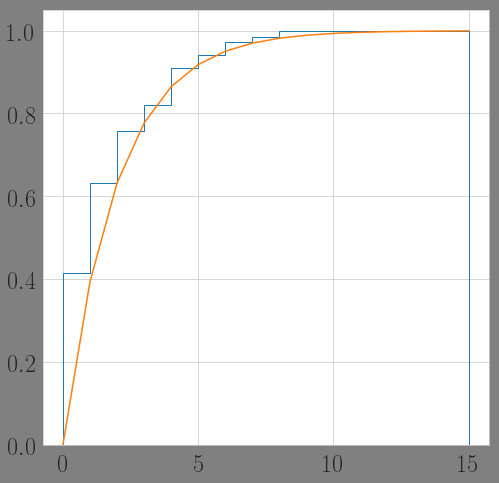

In [42]:
fig,ax=pl.subplots(1,1)
dfp['td'].hist(ax=ax,cumulative=True, histtype='step',bins=np.arange(T+1),weights=np.ones(len(dfp['td'])) / len(dfp['td']))
ax.plot(1-np.exp(-np.arange(T+1)/2))

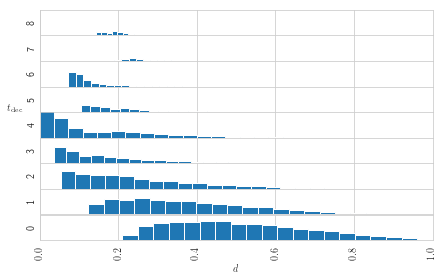

In [108]:
dfp['d']=dfp.Pt_plus.apply(lambda x: np.sum(x))
dfp['d'] = 1-(dfp['d'] - dfp['d'].min()) / (dfp['d'].max() - dfp['d'].min())
fig,axarr=pl.subplots(9,1)
dfp['d'].hist(by=dfp['td'],ax=axarr[::-1],bins=20)
for ait,ax in enumerate(axarr):
    ax.set_yticks([])
    ax.set_xlim(0,1)
    ax.set_ylim(0,500)
    ax.set_ylabel(ax.get_title())
    ax.set_title('')
    if ait<8:
        ax.set_xticklabels([])
ax.set_xlabel('$d$')
fig.text(-0.02,0.6,'$t_{\mathrm{dec}}$')
fig.tight_layout()
fig.subplots_adjust(hspace = .001)
fig.savefig('negcorr_td_vs_d.jpg',format='jpg',dpi=300,bbox_inches='tight')
fig.savefig(paperpath+'negcorr_td_vs_d.jpg',format='jpg',dpi=300,bbox_inches='tight')